<a href="https://colab.research.google.com/github/MinsooKwak/AI_Paper_Review/blob/main/arvix_cat_extract_test_to_structured_compress_hyde_query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Library**

In [ ]:
#!pip install -qU langchain-community arxiv pymupdf pdf2image pypdf PyPDF2
#!pip install tiktoken
#!pip install --upgrade pymupdf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
import config
import os
os.environ["OPENAI_API_KEY"] = config.OPEN_AI_API_KEY
os.environ["HUGGINGFACE_API_KEY"] = config.HUGGINGFACE_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = config.LANGCHAIN_TRACING_V2
os.environ["LANGCHAIN_ENDPOINT"] = config.LANGCHAIN_ENDPOINT
os.environ["LANGCHAIN_API_KEY"] = config.LANGCHAIN_API_KEY

**카테고리별로 가져올 수 있는지 확인 (가능)**

- 카테고리 정보 : https://arxiv.org/category_taxonomy
- 검색어 search (web) : https://arxiv.org/search/

- 대분류 / 소분류별 가져오기 (따로 구성)
  - 우선 대분류 진행
  - 추후 고도화시 소분류 반영 (이는 어떤 카테고리에서 분석이 부족한지 반영할 수 있음)

In [ ]:
#major_categories = ["cs", "math", "physics", "eess", "econ", "q-bio", "q-fin", "stat", "astro-ph"] # 아래 수정

In [ ]:
import os
import pandas as pd
from langchain.document_loaders import ArxivLoader
from langchain.document_loaders import PyPDFLoader
from pdf2image import convert_from_path
from huggingface_hub import hf_hub_download
#import cv2
#from doclayout_yolo import YOLOv10
from PIL import Image

# ArxivLoader를 활용해 논문을 가져옵니다
loader = ArxivLoader(
    query= "cat : q-bio.*",               # 카테고리별 추출 가능 여부 Test  #f"cat:{category}"
    load_max_docs=50,               # 최대 문서 수
    load_all_available_meta=True    # 메타데이터 전체 로드 여부
)
docs = loader.load()

print(f"Loaded documents: {len(docs)}")


# 메타데이터 정보를 데이터프레임으로 저장
metadata_list = []
for doc in docs:
    metadata = doc.metadata
    metadata_list.append({
        'Title': metadata.get('Title', ''),
        'Summary': metadata.get('Summary', ''),
        'PDF Link': metadata.get('links', [])[-1] if metadata.get('links') else ''
    })

dataframe = pd.DataFrame(metadata_list)

# 데이터프레임 확인
print(dataframe)

Loaded documents: 3
                                   Title  \
0      Semistability and CAT(0) Geometry   
1                  Quantum Mona Lisa Cat   
2  On the Topological Complexity of Maps   

                                             Summary  \
0  We explain why semistability of a one-ended pr...   
1  Schr\"{o}dinger's Cat was proposed by Erwin Sc...   
2  We define and develop a homotopy invariant not...   

                            PDF Link  
0  http://arxiv.org/pdf/1703.07003v1  
1  http://arxiv.org/pdf/2001.10184v2  
2  http://arxiv.org/pdf/2011.10646v1  


In [ ]:
dataframe.head()

Title  \
0      Semistability and CAT(0) Geometry   
1                  Quantum Mona Lisa Cat   
2  On the Topological Complexity of Maps   

                                             Summary  \
0  We explain why semistability of a one-ended pr...   
1  Schr\"{o}dinger's Cat was proposed by Erwin Sc...   
2  We define and develop a homotopy invariant not...   

                            PDF Link  
0  http://arxiv.org/pdf/1703.07003v1  
1  http://arxiv.org/pdf/2001.10184v2  
2  http://arxiv.org/pdf/2011.10646v1

In [ ]:
test_queries_lst = ["cat : cs.*", "cat : math.*", "cat : physics.*", "cat : eess.*", "cat : econ.*", "cat : q-bio.*", "cat : q-fin*", "cat : stat*", "cat : astro-ph.*"]
len(test_queries_lst)

9

In [ ]:
# 전체 카테고리(대분류) 추출 코드 (arxivloader편) - 미사용
import os
import pandas as pd
from langchain.document_loaders import ArxivLoader

# 쿼리 리스트 및 각 쿼리에 따른 최대 문서 수 설정
queries = ["cat : cs.*", "cat : math.*", "cat : physics.*", "cat : eess.*", "cat : econ.*", "cat : q-bio.*", "cat : q-fin*", "cat : stat*", "cat : astro-ph.*"]
load_max_docs_list = [5, 5, 5, 5, 5, 5, 5, 5, 5]  # 9개의 category이므로 우선 5개씩 저장해서 활용

# 결과를 저장할 리스트 초기화
metadata_list = []

# 각 쿼리에 대해 문서 로드 및 처리
for query, max_docs in zip(queries, load_max_docs_list):
    # ArxivLoader를 통해 문서 로드
    loader = ArxivLoader(
        query=query,                  # 현재 쿼리
        load_max_docs=max_docs,       # 최대 문서 수
        load_all_available_meta=True  # 메타데이터 전체 로드
    )
    docs = loader.load()

    # 각 문서에 대해 메타데이터 추출 및 저장
    for doc in docs:
        metadata = doc.metadata
        metadata_list.append({
            'Query': query,  # 쿼리 정보 추가
            'Title': metadata.get('Title', ''),
            'Summary': metadata.get('Summary', ''),
            'PDF Link': metadata.get('links', [])[-1] if metadata.get('links') else ''
        })

# 메타데이터 정보를 데이터프레임으로 변환
dataframe = pd.DataFrame(metadata_list)

# 데이터프레임 확인
print(dataframe)

# 데이터프레임 저장 (선택 사항)
output_path = "arxiv_metadata.csv"
dataframe.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Metadata saved to {output_path}")

               Query                                              Title  \
0         cat : cs.*  Barut-Girardello coherent states for sp(N,C) a...   
1         cat : cs.*  Demonstrating CAT: Synthesizing Data-Aware Con...   
2         cat : cs.*             Undirected Cat-and-Mouse is P-complete   
3       cat : math.*  Random groups have fixed points on CAT(0) cube...   
4       cat : math.*  Low-dimensional representations of matrix grou...   
5       cat : math.*                                       Hydra groups   
6    cat : physics.*  Is it possible to suspend the spread of an epi...   
7    cat : physics.*                         Free Will and Falling Cats   
8    cat : physics.*                    A Requiem For Schrödinger's Cat   
9       cat : eess.*  CAT: A CTC-CRF based ASR Toolkit Bridging the ...   
10      cat : eess.*                         CAT: CRF-based ASR Toolkit   
11      cat : eess.*  Assessing the Circadian Rhythm of Cats Living ...   
12      cat : econ.*  Seq

In [ ]:
# Langchain 기반 Loader 설정 확인
from langchain.document_loaders import ArxivLoader
#help(ArxivLoader)

#!pip show langchain

In [ ]:
# Test

import requests
import xml.etree.ElementTree as ET

# ArXiv API URL 구성
url = "http://export.arxiv.org/api/query"
params = {
    "search_query": "cat:q-bio.*",
    "start": 0,
    "max_results": 50
}
response = requests.get(url, params=params)

# API 응답 확인
print(response.status_code)  # 응답 코드 (200이어야 정상)
#print(response.text)         # 응답 내용 출력

# XML 응답 파싱
root = ET.fromstring(response.text)
entries = root.findall('{http://www.w3.org/2005/Atom}entry')

# 논문 메타데이터 추출
metadata_list = []
for entry in entries:
    title = entry.find('{http://www.w3.org/2005/Atom}title').text
    summary = entry.find('{http://www.w3.org/2005/Atom}summary').text
    pdf_link = None
    for link in entry.findall('{http://www.w3.org/2005/Atom}link'):
        if link.attrib.get('title') == 'pdf':
            pdf_link = link.attrib['href']
            break
    metadata_list.append({'Title': title, 'Summary': summary, 'PDF Link': pdf_link})

# 결과 출력
for meta in metadata_list:
    print(meta)

print(f'len : {len(metadata_list)}')

200
{'Title': 'Acto-myosin clusters as active units shaping living matter', 'Summary': '  Stress generation by the actin cytoskeleton shapes cells and tissues. Despite\nimpressive progress in live imaging and quantitative physical descriptions of\ncytoskeletal network dynamics, the connection between processes at molecular\nscales and cell-scale spatio-temporal patterns is still unclear. Here we review\nstudies reporting acto-myosin clusters of micrometer size and with lifetimes of\nseveral minutes in a large number of organisms ranging from fission yeast to\nhumans. Such structures have also been found in reconstituted systems in vitro\nand in theoretical analysis of cytoskeletal dynamics. We propose that tracking\nthese clusters can serve as a simple readout for characterising living matter.\nSpatio-temporal patterns of clusters could serve as determinants of\nmorphogenetic processes that play similar roles in diverse organisms.\n', 'PDF Link': 'http://arxiv.org/pdf/2408.05119v1'}
{'

In [ ]:
df_bio_metadata_list = pd.DataFrame(metadata_list)
print(len(df_bio_metadata_list))
df_bio_metadata_list.head()

50


Title  \
0  Acto-myosin clusters as active units shaping l...   
1  Genome-scale reconstruction of the metabolic n...   
2  Infer metabolic velocities from moment differe...   
3  Spatial cancer systems biology resolves hetero...   
4  Prediction of cellular burden with host-circui...   

                                             Summary  \
0    Stress generation by the actin cytoskeleton ...   
1    The gram-negative bacterium Yersinia pestis,...   
2    Metabolic pathways are fundamental maps in b...   
3    Spatially annotated single-cell datasets pro...   
4    Heterologous gene expression draws resources...   

                            PDF Link  
0  http://arxiv.org/pdf/2408.05119v1  
1   http://arxiv.org/pdf/0903.4219v1  
2  http://arxiv.org/pdf/2402.14887v4  
3  http://arxiv.org/pdf/2303.00933v1  
4  http://arxiv.org/pdf/2004.00995v2

In [ ]:
!pip install -qU langchain-community arxiv pymupdf pdf2image pypdf PyPDF2

In [ ]:
# 전체 카테고리 (API 활용 방식)
import os
import pandas as pd
from langchain.document_loaders import ArxivLoader
from langchain.document_loaders import PyPDFLoader
from pdf2image import convert_from_path
from huggingface_hub import hf_hub_download
#import cv2
#from doclayout_yolo import YOLOv10
from PIL import Image
import time
import requests
import xml.etree.ElementTree as ET
from PyPDF2 import PdfReader
import io

# ArXiv API URL 구성
url = "http://export.arxiv.org/api/query"

# Query 리스트와 최대 문서 수 정의
# 쿼리 리스트 및 각 쿼리에 따른 최대 문서 수 설정
queries = ["cat : cs.*", "cat : math.*", "cat : physics.*", "cat : eess.*", "cat : econ.*", "cat : q-bio.*", "cat : q-fin.*", "cat : stat.*", "cat : astro-ph.*"]
load_max_docs_list = [5, 5, 5, 5, 5, 5, 5, 5, 5]  # 9개의 category이므로 우선 5개씩 저장해서 활용

#### 본문 저장하기 위한 함수 (PdfReader)
"""
def extract_text_from_pdf(pdf_url):
    try:
        response = requests.get(pdf_url)
        response.raise_for_status()  # 요청 성공 여부 확인

        with io.BytesIO(response.content) as pdf_file:
            reader = PdfReader(pdf_file)
            text = ""
            for page in reader.pages:
                text += page.extract_text()
        return text
    except Exception as e:
        print(f"Error extracting text from {pdf_url}: {e}")
        return None
"""
#### 본문 반영
def extract_text_from_pdf(pdf_url):
    try:
      response = requests.get(pdf_url)
      if response.status_code == 200:
        pdf_file = io.BytesIO(response.content)
        reader = PdfReader(pdf_file)
        full_text = ""
        for page in reader.pages:
          full_text += page.extract_text()
        return full_text
      else:
        return f"Failed to download PDF (status code: {response.status_code})"
    except Exception as e:
      return f"Error: {str(e)}"

# 메타데이터 저장
metadata_list = []

for query, max_docs in zip(queries, load_max_docs_list):
    params = {
        "search_query": query,
        "start": 0,
        "max_results": max_docs
    }

    response = requests.get(url, params=params)

    # API 응답 확인
    if response.status_code != 200:
        print(f"Error: Failed to fetch data for query '{query}' with status code {response.status_code}")
        continue

    # XML 응답 파싱
    root = ET.fromstring(response.text)
    entries = root.findall('{http://www.w3.org/2005/Atom}entry')

    # 논문 메타데이터 추출
    category = query.split(':')[1].split('.')[0]  # 'cat:' 이후, '.' 이전 부분 추출

    # 논문 메타데이터 추출
    for entry in entries:
        title = entry.find('{http://www.w3.org/2005/Atom}title').text
        summary = entry.find('{http://www.w3.org/2005/Atom}summary').text
        pdf_link = None
        for link in entry.findall('{http://www.w3.org/2005/Atom}link'):
            if link.attrib.get('title') == 'pdf':
                pdf_link = link.attrib['href']
                break

        metadata_list.append({
            'Category': category,
            'Query': query,
            'Title': title,
            'Summary': summary,
            'PDF Link': pdf_link,
        })

        # PDF 본문 추출 (PdfReader 일 때)
        #pdf_text = extract_text_from_pdf(pdf_link) if pdf_link else None

# 결과 출력
for meta in metadata_list:
    print(meta)

print(f'Total number of papers fetched: {len(metadata_list)}')

{'Category': ' cs', 'Query': 'cat : cs.*', 'Title': 'Brittle System Analysis', 'Summary': '  The goal of this paper is to define and analyze systems which exhibit brittle\nbehavior. This behavior is characterized by a sudden and steep decline in\nperformance as the system approaches the limits of tolerance. This can be due\nto input parameters which exceed a specified input, or environmental conditions\nwhich exceed specified operating boundaries. An analogy is made between brittle\ncommmunication systems in particular and materials science.\n', 'PDF Link': 'http://arxiv.org/pdf/cs/9904016v1'}
{'Category': ' cs', 'Query': 'cat : cs.*', 'Title': 'The Unix KISS: A Case Study', 'Summary': '  In this paper we show that the initial philosophy used in designing and\ndeveloping UNIX in early times has been forgotten due to "fast practices". We\nquestion the leitmotif that microkernels, though being by design adherent to\nthe KISS principle, have a number of context switches higher than their\

In [ ]:
metadata_final = pd.DataFrame(metadata_list)
metadata_final['Title'] = metadata_final['Title'].astype(str)
metadata_final

Category             Query  \
0          cs        cat : cs.*   
1          cs        cat : cs.*   
2          cs        cat : cs.*   
3          cs        cat : cs.*   
4          cs        cat : cs.*   
5        math      cat : math.*   
6        math      cat : math.*   
7        math      cat : math.*   
8        math      cat : math.*   
9        math      cat : math.*   
10    physics   cat : physics.*   
11    physics   cat : physics.*   
12    physics   cat : physics.*   
13    physics   cat : physics.*   
14    physics   cat : physics.*   
15       eess      cat : eess.*   
16       eess      cat : eess.*   
17       eess      cat : eess.*   
18       eess      cat : eess.*   
19       eess      cat : eess.*   
20       econ      cat : econ.*   
21       econ      cat : econ.*   
22       econ      cat : econ.*   
23       econ      cat : econ.*   
24       econ      cat : econ.*   
25      q-bio     cat : q-bio.*   
26      q-bio     cat : q-bio.*   
27      q-bio     cat : q-bio.*   
28      q-bio     cat : q-bio.*   
29      q-bio     cat : q-bio.*   
30      q-fin     cat : q-fin.*   
31      q-fin     cat : q-fin.*   
32      q-fin     cat : q-fin.*   
33      q-fin     cat : q-fin.*   
34      q-fin     cat : q-fin.*   
35       stat      cat : stat.*   
36       stat      cat : stat.*   
37       stat      cat : stat.*   
38       stat      cat : stat.*   
39       stat      cat : stat.*   
40   astro-ph  cat : astro-ph.*   
41   astro-ph  cat : astro-ph.*   
42   astro-ph  cat : astro-ph.*   
43   astro-ph  cat : astro-ph.*   
44   astro-ph  cat : astro-ph.*   

                                                Title  \
0                             Brittle System Analysis   
1                         The Unix KISS: A Case Study   
2   ASC-Hook: fast and transparent system call hoo...   
3   Learnings from an Under the Hood Analysis of a...   
4   An Example of Clifford Algebras Calculations w...   
5         Generalized spaces for constructive algebra   
6                     Constructing projective modules   
7                      Quantalic spectra of semirings   
8     Von Neumann coordinatization is not first-order   
9                                     Analysis in J_2   
10  German to Spanish translation of Einstein's wo...   
11           How a fake Kepler portrait became iconic   
12  Scientific Metaphors in the journalistic disco...   
13  Review Article: Integral Role of Physics in Ad...   
14  Hollywood Blockbusters: Unlimited Fun but Limi...   
15  Optimized Sharing of Coefficients in Parallel ...   
16  Multi-Resolution Beta-Divergence NMF for Blind...   
17  A multispeaker dataset of raw and reconstructe...   
18  Superresolution photoacoustic tomography using...   
19  SRIB-LEAP submission to Far-field Multi-Channe...   
20  Sectorial Exclusion Criteria in the Marxist An...   
21            A Practical Approach to Social Learning   
22  Identification of hedonic equilibrium and nons...   
23  Second-order Inductive Inference: an axiomatic...   
24  Identifying Present-Bias from the Timing of Ch...   
25  Acto-myosin clusters as active units shaping l...   
26  Genome-scale reconstruction of the metabolic n...   
27  Infer metabolic velocities from moment differe...   
28  Spatial cancer systems biology resolves hetero...   
29  Prediction of cellular burden with host-circui...   
30  Efficient Pricing and Calibration of High-Dime...   
31  UNISWAP: Impermanent Loss and Risk Profile of ...   
32  Pricing Financial Derivatives Subject to Count...   
33  Randomization of Short-Rate Models, Analytic P...   
34  Risk aggregation and capital allocation using ...   
35  KernSmoothIRT: An R Package for Kernel Smoothi...   
36  DBKGrad: An R Package for Mortality Rates Grad...   
37  The effect of Hybrid Principal Components Anal...   
38  Bayesian Quantile Regression for Longitudinal ...   
39  A practically efficient fixed-pivot selection ...   
40  Laboratory Astrophysics and the State of Astro...   


In [ ]:
# URL LINK 바뀐 경우 'Failed to download PDF' 발생
# 대안 : 에러 케이스에서 Title을 통해 한 번 더 불러옴
metadata_final['Content'] = metadata_final['PDF Link'].apply(extract_text_from_pdf)
metadata_final

Category             Query  \
0          cs        cat : cs.*   
1          cs        cat : cs.*   
2          cs        cat : cs.*   
3          cs        cat : cs.*   
4          cs        cat : cs.*   
5        math      cat : math.*   
6        math      cat : math.*   
7        math      cat : math.*   
8        math      cat : math.*   
9        math      cat : math.*   
10    physics   cat : physics.*   
11    physics   cat : physics.*   
12    physics   cat : physics.*   
13    physics   cat : physics.*   
14    physics   cat : physics.*   
15       eess      cat : eess.*   
16       eess      cat : eess.*   
17       eess      cat : eess.*   
18       eess      cat : eess.*   
19       eess      cat : eess.*   
20       econ      cat : econ.*   
21       econ      cat : econ.*   
22       econ      cat : econ.*   
23       econ      cat : econ.*   
24       econ      cat : econ.*   
25      q-bio     cat : q-bio.*   
26      q-bio     cat : q-bio.*   
27      q-bio     cat : q-bio.*   
28      q-bio     cat : q-bio.*   
29      q-bio     cat : q-bio.*   
30      q-fin     cat : q-fin.*   
31      q-fin     cat : q-fin.*   
32      q-fin     cat : q-fin.*   
33      q-fin     cat : q-fin.*   
34      q-fin     cat : q-fin.*   
35       stat      cat : stat.*   
36       stat      cat : stat.*   
37       stat      cat : stat.*   
38       stat      cat : stat.*   
39       stat      cat : stat.*   
40   astro-ph  cat : astro-ph.*   
41   astro-ph  cat : astro-ph.*   
42   astro-ph  cat : astro-ph.*   
43   astro-ph  cat : astro-ph.*   
44   astro-ph  cat : astro-ph.*   

                                                Title  \
0                             Brittle System Analysis   
1                         The Unix KISS: A Case Study   
2   ASC-Hook: fast and transparent system call hoo...   
3   Learnings from an Under the Hood Analysis of a...   
4   An Example of Clifford Algebras Calculations w...   
5         Generalized spaces for constructive algebra   
6                     Constructing projective modules   
7                      Quantalic spectra of semirings   
8     Von Neumann coordinatization is not first-order   
9                                     Analysis in J_2   
10  German to Spanish translation of Einstein's wo...   
11           How a fake Kepler portrait became iconic   
12  Scientific Metaphors in the journalistic disco...   
13  Review Article: Integral Role of Physics in Ad...   
14  Hollywood Blockbusters: Unlimited Fun but Limi...   
15  Optimized Sharing of Coefficients in Parallel ...   
16  Multi-Resolution Beta-Divergence NMF for Blind...   
17  A multispeaker dataset of raw and reconstructe...   
18  Superresolution photoacoustic tomography using...   
19  SRIB-LEAP submission to Far-field Multi-Channe...   
20  Sectorial Exclusion Criteria in the Marxist An...   
21            A Practical Approach to Social Learning   
22  Identification of hedonic equilibrium and nons...   
23  Second-order Inductive Inference: an axiomatic...   
24  Identifying Present-Bias from the Timing of Ch...   
25  Acto-myosin clusters as active units shaping l...   
26  Genome-scale reconstruction of the metabolic n...   
27  Infer metabolic velocities from moment differe...   
28  Spatial cancer systems biology resolves hetero...   
29  Prediction of cellular burden with host-circui...   
30  Efficient Pricing and Calibration of High-Dime...   
31  UNISWAP: Impermanent Loss and Risk Profile of ...   
32  Pricing Financial Derivatives Subject to Count...   
33  Randomization of Short-Rate Models, Analytic P...   
34  Risk aggregation and capital allocation using ...   
35  KernSmoothIRT: An R Package for Kernel Smoothi...   
36  DBKGrad: An R Package for Mortality Rates Grad...   
37  The effect of Hybrid Principal Components Anal...   
38  Bayesian Quantile Regression for Longitudinal ...   
39  A practically efficient fixed-pivot selection ...   
40  Laboratory Astrophysics and the State of Astro...   


In [ ]:
import arxiv

def extract_text_from_pdf_by_title(title):
    try:
        # 제목으로 search
        search = arxiv.Search(
            query=title,
            max_results=1,  # Get the most relevant result
            sort_by=arxiv.SortCriterion.Relevance
        )

        # 존재하면 반환
        for result in search.results():
            pdf_url = result.pdf_url
            response = requests.get(pdf_url)

            if response.status_code == 200:
                # Step 3: Download and extract text from the PDF
                pdf_file = io.BytesIO(response.content)
                reader = PdfReader(pdf_file)
                full_text = ""
                for page in reader.pages:
                    page_text = page.extract_text()
                    full_text += page_text
                return full_text
            else:
                return f"Failed to download PDF from {pdf_url}. Status code: {response.status_code}"

        # 결과 없으면
        return "No matching paper found on arXiv."

    except Exception as e:
        return f"Error occurred: {str(e)}"

metadata_final["Content"] = metadata_final.apply(
    lambda row: extract_text_from_pdf_by_title(row["Title"]) if "Failed to download PDF" in row["Content"] else row["Content"],
    axis=1
)

<ipython-input-15-c7ccf84da305>:13: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


In [ ]:
metadata_final.loc[0]['Content']

"arXiv:cs/9904016v1  [cs.NI]  22 Apr 1999BUSH, HERSHEY,AND VOSBURGH:BRITTLESYSTEMS 1\nBrittle System Analysis\nStephen F. Bush, JohnHersheyand Kirby Vosburgh\nAbstract\nThe goal of this paper is to deﬁne and analyze systems which ex hibit brittle behavior. This behavior is characterized by a sudden and steep decline in\nperformance as the system state changes. This can be due to in put parameters which exceed a speciﬁed input, or environmen tal conditions which exceed speciﬁed\noperating boundaries.\nKeywords\nSystem Design, Catastrophe Theory, Quality\nI. INTRODUCTION\nBASED on vast experience watching the fruit of my hard work fal l apart time and again, I feel highly qualiﬁed to discuss the\nmanner in which systems break. In particular, the goal of thi s paper is to deﬁne and analyze systems which exhibit brittle\nbehavior. This behavior is characterized by a sudden and ste ep decline in performance as system state changes as shown by\npoint D along curve Phin Figure 1. Phis the per

In [ ]:
import re
def remove_newlines(text):
  "정규표현식으로 \n,\t 제거"
  return re.sub(r'[\n\t]', ' ', text)

In [ ]:
# 정규표현식으로 줄바꿈 제거
metadata_final['Content'] = metadata_final['Content'].apply(remove_newlines)
metadata_final.head(3)

Category       Query                                              Title  \
0       cs  cat : cs.*                            Brittle System Analysis   
1       cs  cat : cs.*                        The Unix KISS: A Case Study   
2       cs  cat : cs.*  ASC-Hook: fast and transparent system call hoo...   

                                             Summary  \
0    The goal of this paper is to define and anal...   
1    In this paper we show that the initial philo...   
2    Intercepting system calls is crucial for too...   

                            PDF Link  \
0  http://arxiv.org/pdf/cs/9904016v1   
1  http://arxiv.org/pdf/cs/0701021v2   
2  http://arxiv.org/pdf/2412.05784v3   

                                             Content  
0  arXiv:cs/9904016v1  [cs.NI]  22 Apr 1999BUSH, ...  
1  Perbandingan Shell Unix   Oleh : Spits Warnars...  
2  ASC-Hook: fast and transparent system call hoo...

- 논문 context만 남기는 방향은 좀 생각해보기..
- 앞에서 질문 만들면 안되기 때문

In [ ]:
# 평가셋 만들기 위해 column명 변경
metadata_final.rename(columns={'PDF Link': 'filename'}, inplace=True)
metadata_final.head(3)

Category       Query                                              Title  \
0       cs  cat : cs.*                            Brittle System Analysis   
1       cs  cat : cs.*                        The Unix KISS: A Case Study   
2       cs  cat : cs.*  ASC-Hook: fast and transparent system call hoo...   

                                             Summary  \
0    The goal of this paper is to define and anal...   
1    In this paper we show that the initial philo...   
2    Intercepting system calls is crucial for too...   

                            filename  \
0  http://arxiv.org/pdf/cs/9904016v1   
1  http://arxiv.org/pdf/cs/0701021v2   
2  http://arxiv.org/pdf/2412.05784v3   

                                             Content  
0  arXiv:cs/9904016v1  [cs.NI]  22 Apr 1999BUSH, ...  
1  Perbandingan Shell Unix   Oleh : Spits Warnars...  
2  ASC-Hook: fast and transparent system call hoo...

In [ ]:
#metadata_final.to_csv('arxiv_article_data.csv', index=False)

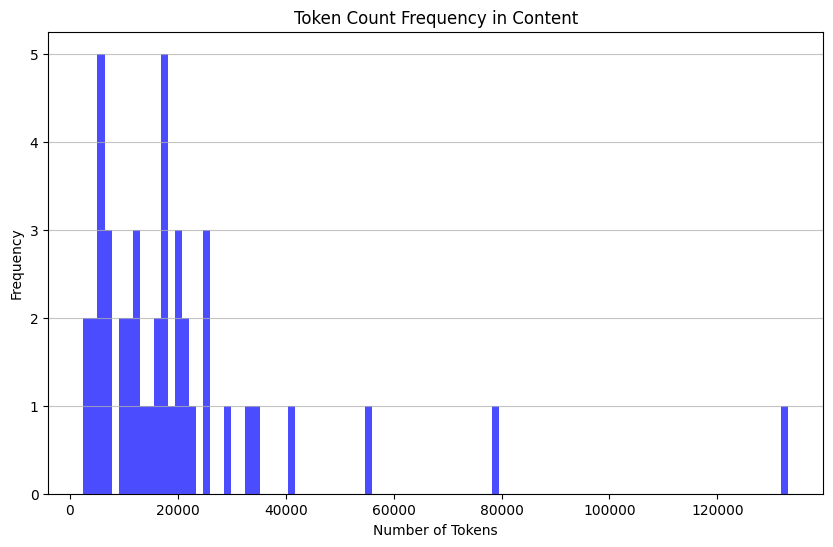

In [ ]:
import tiktoken
import matplotlib.pyplot as plt

def num_tokens_from_string(string:str, encoding_name:str) -> int:
  encoding = tiktoken.get_encoding(encoding_name)
  num_tokens = len(encoding.encode(string))
  return num_tokens

metadata_final['Token Count'] = metadata_final['Content'].apply(lambda x: num_tokens_from_string(x if isinstance(x, str) else "", encoding_name="cl100k_base"))

# 토큰 개수 시각화
plt.figure(figsize=(10, 6))
plt.hist(metadata_final["Token Count"], bins=100, color="blue", alpha=0.7)
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.title("Token Count Frequency in Content")
plt.grid(axis='y', alpha=0.75)
plt.show()

- 대부분 0~20,000 토큰 범위에 몰려있음. 이 범위의 텍스트 가진 논문이 가장 많음.
- 일부 긴 텍스트나 상세한 논문

In [ ]:
#### RAG (Raptor RAG) + CRAG
#### 쿼리 > 쿼리 변환(1.정규화 2.article 형태 3.Lingua)> Raptor + CRAG > generate

- indexing 방법은 여전히 고민중이긴 함..
  - Abstract
  - Keywords
  - Introduction
  -

### 디렉토리 생성해 데이터 추출

- 데이터 확보건

In [ ]:
#### 여기서 텍스트, 이미지, figure 추출하고 저장
#### 아래는 프롬프트로 LLM 통해 텍스트화 (프롬프트 고도화도 포함)
#### 벡터 DB 저장
#### 벡터 DB 저장 내용 가져와 사용 방안
#### 각 유형 따라 결과 도출

- Test 위한 데이터 확보건

평가 (Regas, Langsmith, LLM as a judge)


In [ ]:
!pip install -q langchain==0.2.16
!pip install -q ragas==0.1.19

In [ ]:
import langchain
import ragas

print(f"LangChain Version: {langchain.__version__}")
print(f"Ragas Version: {ragas.__version__}")

LangChain Version: 0.2.17
Ragas Version: 0.1.19


In [ ]:
# RAGAS로 질문과 답변 생성하기(Synthethic Dataset)
"""
사용자들이 잠정적으로 만들어낼 수 있는 질문과 답변 생성
Seed Question > Evolver가 좋은지 안좋은지 평가 >
좋은 질문과 나쁜 질문을 구분하고 좋은 질문을 선별해 그것에 대한 답변 생성
Evolution은 Text를 정제하는 과정 > 실제로 질문 할 것 같은 질문으로 만들어줌
Evolution Process : reasoning, conditioning, multi-context ...
QA Validator가 Validation 진행 (Hallucination 안나오게)
"""

"filename이 있는지 확인함.(위에서 filename 변경)"

'filename이 있는지 확인함.(위에서 filename 변경)'

In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context, conditional
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.extractor import KeyphraseExtractor
from ragas.testset.docstore import InMemoryDocumentStore

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 데이터셋 생성기
generator_llm = ChatOpenAI(model="gpt-4o-mini")
# 데이터셋 비평기
critic_llm = ChatOpenAI(model="gpt-4o-mini")
# 문서 임베딩
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [ ]:
# docs 준비
import pandas as pd

df = pd.read_csv("/content/arxiv_article_data.csv")
df.head(3)

Category       Query                                              Title  \
0       cs  cat : cs.*                            Brittle System Analysis   
1       cs  cat : cs.*                        The Unix KISS: A Case Study   
2       cs  cat : cs.*  ASC-Hook: fast and transparent system call hoo...   

                                             Summary  \
0    The goal of this paper is to define and anal...   
1    In this paper we show that the initial philo...   
2    Intercepting system calls is crucial for too...   

                            filename  \
0  http://arxiv.org/pdf/cs/9904016v1   
1  http://arxiv.org/pdf/cs/0701021v2   
2  http://arxiv.org/pdf/2412.05784v3   

                                             Content  Token Count  
0  arXiv:cs/9904016v1  [cs.NI]  22 Apr 1999BUSH, ...         6319  
1  Perbandingan Shell Unix   Oleh : Spits Warnars...         5133  
2  ASC-Hook: fast and transparent system call hoo...        11392

In [ ]:
df.Category.unique()

array([' cs', ' math', ' physics', ' eess', ' econ', ' q-bio', ' q-fin',
       ' stat', ' astro-ph'], dtype=object)

In [ ]:
# 카테고리별 데이터 분류 진행
cs_df = df[df['Category'] == ' cs']
math_df = df[df['Category'] == ' math']
physics_df = df[df['Category'] == ' physics']
eess_df = df[df['Category'] == ' eess']
econ_df = df[df['Category'] == ' econ']
qbio_df = df[df['Category'] == ' q-bio']
qfin_df = df[df['Category'] == ' q-fin']
stat_df = df[df['Category'] == ' stat']
astro_df = df[df['Category'] == ' astro-ph']

In [ ]:
dataframes = {
    "cs_df":cs_df,
    "math_df":math_df,
    "physics_df":physics_df,
    "eess_df":eess_df,
    "econ_df":econ_df,
    "qbio_df":qbio_df,
    "qfin_df":qfin_df,
    "stat_df":stat_df,
    "astro_df":astro_df
}

In [ ]:
from langchain.schema import Document

# 데이터프레임의 Content 열을 Document 객체 리스트로 변환
docs = [
    Document(
        page_content=row['Content'],  # 문서 내용
        metadata={
            "title": row['Title'],        # 문서 제목
            "category": row['Category'],  # 카테고리
            "query": row['Query'],        # 쿼리
            "filename": row['filename']   # PDF 링크
        }
    )
    for _, row in df.iterrows()
]

# 각 데이터프레임 변환 후 저장
for name, dataframe in dataframes.items():
    docs = [
        Document(
            page_content=row["Content"],
            metadata={
                "title": row["Title"],       # 문서 제목
                "category": row["Category"], # 카테고리
                "query": row["Query"],       # 쿼리
                "filename": row["filename"], # PDF 링크
            },
        )
        for _, row in dataframe.iterrows()
    ]
    globals()[f"{name}_docs"] = docs  # 동적으로 변수명 설정

# 결과 확인
for name in dataframes.keys():
    variable_name = f"{name}_docs"
    print(f"{variable_name}: {len(globals()[variable_name])} documents")

cs_df_docs: 5 documents
math_df_docs: 5 documents
physics_df_docs: 5 documents
eess_df_docs: 5 documents
econ_df_docs: 5 documents
qbio_df_docs: 5 documents
qfin_df_docs: 5 documents
stat_df_docs: 5 documents
astro_df_docs: 5 documents


In [ ]:
# 텍스트 분할기를 설정합니다.
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# LangChain의 ChatOpenAI 모델을 LangchainLLMWrapper로 감싸 Ragas와 호환되게 만듭니다.
langchain_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))

# 주요 구문 추출기를 초기화합니다. 위에서 정의한 LLM을 사용합니다.
keyphrase_extractor = KeyphraseExtractor(llm=langchain_llm)

# ragas_embeddings 생성
ragas_embeddings = LangchainEmbeddingsWrapper(embeddings)

# InMemoryDocumentStore를 초기화합니다.
# 이는 문서를 메모리에 저장하고 관리하는 저장소입니다.
docstore = InMemoryDocumentStore(
    splitter=splitter,
    embeddings=ragas_embeddings,
    extractor=keyphrase_extractor,
)

In [ ]:
generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    ragas_embeddings,
    docstore=docstore,
)

In [ ]:
# 질문 유형별 분포 결정
# simple: 간단한 질문, reasoning: 추론이 필요한 질문, multi_context: 여러 맥락을 고려해야 하는 질문, conditional: 조건부 질문
distributions = {simple: 0.2, reasoning: 0.4, multi_context: 0.3, conditional: 0.1}

In [ ]:
# 테스트셋 생성
# docs: 문서 데이터, 10: 생성할 질문의 수, distributions: 질문 유형별 분포, with_debugging_logs: 디버깅 로그 출력 여부
"""
testset = generator.generate_with_langchain_docs(
    documents=docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)
"""

'\ntestset = generator.generate_with_langchain_docs(\n    documents=docs,\n    test_size=10,\n    distributions=distributions,\n    with_debugging_logs=True,\n    raise_exceptions=False,\n)\n'

In [ ]:
# 문서를 기반으로 테스트셋 생성 및 동적 변수명 설정
"""
def generate_testset_with_global(generator, docs, test_size, distributions, variable_name):
    testset = generator.generate_with_langchain_docs(
        documents=docs,
        test_size=test_size,
        distributions=distributions,
        with_debugging_logs=True,
        raise_exceptions=False,
    )
    globals()[variable_name] = testset
    """

In [ ]:
cs_testset = generator.generate_with_langchain_docs(
    documents=cs_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

In [ ]:
cs_test_df = cs_testset.to_pandas()
cs_test_df

question  \
0  What is the purpose of the multi-level trampol...   
1  What are the performance and compatibility lim...   
2  How does the BIO structure manage IO requests ...   
3  What makes UNIX stable and adaptable on variou...   
4  What connects ext4's data mgmt and write-ahead...   
5            What affects Block IO on OSD workloads?   
6  How does the block IO scheduler manage IO requ...   
7  What are the benefits of host data mgmt in obj...   
8  How does the trampoline help with SVC instruct...   
9  How do IO requests affect OS optimization with...   

                                            contexts  \
0  [is roughly the same because they use similar ...   
1  [segment called __PAGEZERO, preventing the app...   
2  [OS opti- mization layer before dispatching IO...   
3  [Perbandingan Shell Unix   Oleh : Spits Warnar...   
4  [ext4 and xfs file-systems which a re most  wi...   
5  [for Object -Drive  based object -stores.     ...   
6  [OS opti- mization layer before dispatching IO...   
7  [hefty and redundant host ( OS +  applica- tio...   
8  [contain fewer SVC instructions compared to ot...   
9  [OS opti- mization layer before dispatching IO...   

                                        ground_truth evolution_type  \
0  The purpose of the multi-level trampoline desi...         simple   
1  ASC-Hook does not support hooking vDSO-based s...         simple   
2  The BIO structure manages IO requests pre-stor...      reasoning   
3  The UNIX system is considered stable and adapt...      reasoning   
4  The answer to given question is not present in...      reasoning   
5  The context does not provide specific informat...      reasoning   
6  The block IO scheduler manages IO request band...  multi_context   
7  The benefits of host data management in object...  multi_context   
8  The trampoline helps with SVC instructions by ...  multi_context   
9  The context discusses how the OS optimization ...    conditional   

                                            metadata  episode_done  
0  [{'title': 'ASC-Hook: fast and transparent sys...          True  
1  [{'title': 'ASC-Hook: fast and transparent sys...          True  
2  [{'title': 'Learnings from an Under the Hood A...          True  
3  [{'title': 'The Unix KISS: A Case Study', 'cat...          True  
4  [{'title': 'Learnings from an Under the Hood A...          True  
5  [{'title': 'Learnings from an Under the Hood A...          True  
6  [{'title': 'Learnings from an Under the Hood A...          True  
7  [{'title': 'Learnings from an Under the Hood A...          True  
8  [{'title': 'ASC-Hook: fast and transparent sys...          True  
9  [{'title': 'Learnings from an Under the Hood A...          True

In [ ]:
cs_test_df.to_csv('cs_arxiv_testset.csv', index=False)

In [ ]:
math_testset = generator.generate_with_langchain_docs(
    documents=math_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

In [ ]:
math_test_df = math_testset.to_pandas()
math_test_df

question  \
0  What condition on a locale or a topological sp...   
1  What is the role of the multiplicative submono...   
2  How are \\( \\iota \\)-open/closed classes def...   
3  How are projective modules linked to torsion-f...   
4  What's the role of a dual basis in universal o...   
5  What degree did Arthur Mattuck get in '54, and...   
6  How does overtness affect existential quantifi...   
7  What role do continuous real-valued functions ...   
8  What key Eilenberg-Mac Lane interactions shape...   
9  What are the effects of non-preserving propert...   

                                            contexts  \
0  [such that U|=ϕ. Hint.Consider the join of all...   
1  [to a prime ideal Q≥P. The complement of Qis a...   
2  [is a straight- forward generalization of mate...   
3  [it seems unlikely that considerations of pure...   
4  [the open prime monoidanti-ideals of a commuta...   
5  [Cheval- ley’s Fundamental concepts of algebra...   
6  [of the quantic spectrum. Remark 3.2.3. This d...   
7  [such that U|=ϕ. Hint.Consider the join of all...   
8  [is recou nted in other sources, with varying ...   
9  [that 0+≤aanda+a≤a. It is easy to these elemen...   

                                        ground_truth evolution_type  \
0  A condition on a locale or a topological space...         simple   
1  The role of the multiplicative submonoid, whic...         simple   
2  In \( \iota \)-metric spaces, an \( \iota \)-c...      reasoning   
3  The context mentions that most of the non-triv...      reasoning   
4  The role of a dual basis in universal open pri...      reasoning   
5  Arthur Mattuck received his Ph.D. in 1954 unde...      reasoning   
6  The concept of overtness allows for the existe...  multi_context   
7  The answer to given question is not present in...  multi_context   
8  The context discusses the interactions between...  multi_context   
9  The effects of non-preserving properties on di...    conditional   

                                            metadata  episode_done  
0  [{'title': 'Generalized spaces for constructiv...          True  
1  [{'title': 'Quantalic spectra of semirings', '...          True  
2  [{'title': 'Analysis in J_2', 'category': ' ma...          True  
3  [{'title': 'Constructing projective modules', ...          True  
4  [{'title': 'Quantalic spectra of semirings', '...          True  
5  [{'title': 'Constructing projective modules', ...          True  
6  [{'title': 'Quantalic spectra of semirings', '...          True  
7  [{'title': 'Generalized spaces for constructiv...          True  
8  [{'title': 'Constructing projective modules', ...          True  
9  [{'title': 'Quantalic spectra of semirings', '...          True

In [ ]:
math_test_df.to_csv('math_arxiv_testset.csv', index=False)

In [ ]:
physics_testset = generator.generate_with_langchain_docs(
    documents=physics_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

physics_test_df = physics_testset.to_pandas()
physics_test_df

In [ ]:
physics_test_df

question  \
0  What is the significance of the Méthode Alexan...   
1  What role does first-order predicate logic pla...   
2          Which films show sci-fi flaws in physics?   
3  What's the link between algebraic vector bundl...   
4  What are the implications of extending sheaf s...   
5  What defines a \ud835\udc56-class function reg...   
6  What's the role of the neutral ideal In = π⁻¹{...   
7  What are the implications of extending sheaf s...   
8  What are the implications of a global section ...   
9  What role do multi-variable analytic functions...   

                                            contexts  \
0  [l donne imm´ ediatement, de la mani` ere la p...   
1  [Lemma 8.3. Both subdirect products (8.1)and(8...   
2  [arXiv:0707.1167v1  [physics.soc-ph]  9 Jul 20...   
3  [have been identiﬁed as algebro-geometr ic ana...   
4  [to assume that Aitself is nontrivial. Give a ...   
5  [them). Deﬁnition 2.4. Anι-relation on anι-cla...   
6  [cpis a central idempotent of R, for each prim...   
7  [ideal, and such that it is not the case that,...   
8  [sensible answer is “except f or the empty ope...   
9  [enterprise in Fra nce was considerably dimin-...   

                                        ground_truth evolution_type  \
0  The significance of the Méthode Alexander–Lera...         simple   
1  The answer to given question is not present in...         simple   
2  The answer to given question is not present in...      reasoning   
3  The context discusses the identification of al...      reasoning   
4  The implications of extending sheaf semantics ...      reasoning   
5  The context does not provide a specific defini...      reasoning   
6  The context does not provide specific informat...  multi_context   
7  The implications of extending sheaf semantics ...  multi_context   
8  The implications of a global section in sheaf ...  multi_context   
9  The answer to given question is not present in...    conditional   

                                            metadata  episode_done  
0  [{'title': 'Constructing projective modules', ...          True  
1  [{'title': 'Von Neumann coordinatization is no...          True  
2  [{'title': 'Hollywood Blockbusters: Unlimited ...          True  
3  [{'title': 'Constructing projective modules', ...          True  
4  [{'title': 'Generalized spaces for constructiv...          True  
5  [{'title': 'Analysis in J_2', 'category': ' ma...          True  
6  [{'title': 'Von Neumann coordinatization is no...          True  
7  [{'title': 'Generalized spaces for constructiv...          True  
8  [{'title': 'Generalized spaces for constructiv...          True  
9  [{'title': 'Constructing projective modules', ...          True

In [ ]:
physics_test_df.to_csv('physics_arxiv_testset.csv', index=False)

In [ ]:
eess_testset = generator.generate_with_langchain_docs(
    documents=eess_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

eess_test_df = eess_testset.to_pandas()

In [ ]:
eess_test_df

question  \
0  What demographic information was collected abo...   
1  What is the significance of geometric logic in...   
2  How do finitely generated ideals affect quanta...   
3  What links localic semirings, commutative mono...   
4  How do 'i-sets' relate to 'i-classes' in terms...   
5  What must x and b meet to be a modular pair in...   
6  What's the role of the ClopU to ClopV embeddin...   
7  What social and political factors shaped proje...   
8  What aspects of group constructions and homomo...   
9  What does category theory imply for math struc...   

                                            contexts  \
0  [of Southern California (USC). The data were c...   
1  [Math. Structures Comp. Sci. 15 (6), 1089–1149...   
2  [(though a constructive ring-theoretic proof o...   
3  [Consider the following conditions: i)MMis a f...   
4  [is some sense in which the universe of sets c...   
5  [use for some more ﬁne-grained notions of modu...   
6  [. Of course, both KandLare 2-distributive com...   
7  [and sheaves as way-station in formulating “gl...   
8  [essentially the study of those constructions ...   
9  [Math. Structures Comp. Sci. 15 (6), 1089–1149...   

                                        ground_truth evolution_type  \
0  The demographic information collected about th...         simple   
1  The answer to given question is not present in...         simple   
2  The answer to given question is not present in...      reasoning   
3  The context discusses that a regular commutati...      reasoning   
4  The answer to given question is not present in...      reasoning   
5  In a lattice, a pair of elements (x, b) is sai...      reasoning   
6  The role of the ClopU to ClopV embedding in 2-...  multi_context   
7  The social and political factors that shaped p...  multi_context   
8  A vague idea of covariance and contravariance ...  multi_context   
9  The answer to given question is not present in...    conditional   

                                            metadata  episode_done  
0  [{'title': 'A multispeaker dataset of raw and ...          True  
1  [{'title': 'Generalized spaces for constructiv...          True  
2  [{'title': 'Quantalic spectra of semirings', '...          True  
3  [{'title': 'Quantalic spectra of semirings', '...          True  
4  [{'title': 'Analysis in J_2', 'category': ' ma...          True  
5  [{'title': 'Quantalic spectra of semirings', '...          True  
6  [{'title': 'Von Neumann coordinatization is no...          True  
7  [{'title': 'Constructing projective modules', ...          True  
8  [{'title': 'Constructing projective modules', ...          True  
9  [{'title': 'Generalized spaces for constructiv...          True

In [ ]:
eess_test_df.to_csv('eess_arxiv_testset.csv', index=False)

In [ ]:
econ_testset = generator.generate_with_langchain_docs(
    documents=econ_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

econ_test_df = econ_testset.to_pandas()

In [ ]:
econ_test_df

question  \
0  What are mathematical frames and how are they ...   
1  What were the economic effects of the trade co...   
2       How does structure fit into Bourbaki's math?   
3  What challenges does RT-MRI face with quick vo...   
4       What links semirings, quantales, and ideals?   
5  How do parallel filter banks boost signal proc...   
6  What links the quantale framework of monoid id...   
7  What role do classical physics metaphors like ...   
8  How do muscle flexion and friction help Aeon b...   
9  What benefits do parallel filter banks provide...   

                                            contexts  \
0  [Assume pholds. Then/logicalortext{1|q}is a co...   
1  [“fonte de atrito”, “ tensão social ”, “magne ...   
2  [i n a systematic and uni- ﬁed fashion, within...   
3  [a recognized impact in, for example, the doma...   
4  [of quantales, where the counit is given by th...   
5  [The ﬁlter coefﬁcients are grouped in a two st...   
6  [monoid (M,µ×,ε1)deﬂationary if µ×≤ι1. Proposi...   
7  [“amigo chegado ”, “manter a distância patrão ...   
8  [feet. In an eﬀort to exaggerate the abilities...   
9  [The ﬁlter coefﬁcients are grouped in a two st...   

                                        ground_truth evolution_type  \
0  Mathematical frames are best viewed as algebra...         simple   
1  The economic effects of the trade collapse on ...         simple   
2  The answer to given question is not present in...      reasoning   
3  RT-MRI faces several challenges with quick voc...      reasoning   
4  The answer to given question is not present in...      reasoning   
5  Parallel filter banks boost signal processing ...      reasoning   
6  The quantale framework of monoid ideals is lin...  multi_context   
7  Classical physics metaphors, such as 'social t...  multi_context   
8  Muscle flexion helps Aeon maintain her balance...  multi_context   
9  Parallel filter banks provide benefits for rad...    conditional   

                                            metadata  episode_done  
0  [{'title': 'Quantalic spectra of semirings', '...          True  
1  [{'title': 'Scientific Metaphors in the journa...          True  
2  [{'title': 'Constructing projective modules', ...          True  
3  [{'title': 'A multispeaker dataset of raw and ...          True  
4  [{'title': 'Quantalic spectra of semirings', '...          True  
5  [{'title': 'Optimized Sharing of Coefficients ...          True  
6  [{'title': 'Quantalic spectra of semirings', '...          True  
7  [{'title': 'Scientific Metaphors in the journa...          True  
8  [{'title': 'Hollywood Blockbusters: Unlimited ...          True  
9  [{'title': 'Optimized Sharing of Coefficients ...          True

In [ ]:
econ_test_df.to_csv('econ_arxiv_testset.csv', index=False)

In [ ]:
qbio_testset = generator.generate_with_langchain_docs(
    documents=qbio_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

qbio_test_df = qbio_testset.to_pandas()

In [ ]:
qbio_test_df

question  \
0  What is the significance of public belief conv...   
1  What does the concept of 'not equal' imply in ...   
2  What map comes from the initial homomorphism i...   
3  What role do normal epimorphisms play in subob...   
4     How do consumer prefs link to WTP for quality?   
5  What applies to Jacobi representations in impr...   
6  What are the implications of a global section ...   
7  What's the role of functor OPAIR in localic se...   
8  What multivariate quantile concept relates to ...   
9  What role does marginal distribution play in h...   

                                            contexts  \
0  [the occurrence of cascades (see [13]), assumi...   
1  [not notequal does not imply that they are act...   
2  [to algebraic geometry. Deﬁnition 1.8.1. LetRb...   
3  [the autoduality Sup∼=Supop. This exchanges 0w...   
4  [of consumers to pay for the attributes of the...   
5  [oflemma 2.2 . Thus, 1´λty,zuis nonzero and we...   
6  [sensible answer is “except f or the empty ope...   
7  [The resulting equaliser can be explicitly des...   
8  [Henry (2012) proposea notion o f multivariate...   
9  [the limit ¯P. By the stability of optimal tra...   

                                        ground_truth evolution_type  \
0  The significance of public belief convergence ...         simple   
1  The concept of 'not equal' in the context of s...         simple   
2  The answer to given question is not present in...      reasoning   
3  The context does not provide specific informat...      reasoning   
4  The answer to given question is not present in...      reasoning   
5  The answer to given question is not present in...      reasoning   
6  The implications of a global section in sheaf ...  multi_context   
7  The functor OPAIR plays a role in describing t...  multi_context   
8  The multivariate quantile concept that relates...  multi_context   
9  The answer to given question is not present in...    conditional   

                                            metadata  episode_done  
0  [{'title': 'A Practical Approach to Social Lea...          True  
1  [{'title': 'Generalized spaces for constructiv...          True  
2  [{'title': 'Quantalic spectra of semirings', '...          True  
3  [{'title': 'Quantalic spectra of semirings', '...          True  
4  [{'title': 'Identification of hedonic equilibr...          True  
5  [{'title': 'Second-order Inductive Inference: ...          True  
6  [{'title': 'Generalized spaces for constructiv...          True  
7  [{'title': 'Quantalic spectra of semirings', '...          True  
8  [{'title': 'Identification of hedonic equilibr...          True  
9  [{'title': 'Identification of hedonic equilibr...          True

In [ ]:
qbio_test_df.to_csv('qbio_arxiv_testset.csv', index=False)

In [ ]:
qfin_testset = generator.generate_with_langchain_docs(
    documents=qfin_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

qfin_test_df = qfin_testset.to_pandas()

In [ ]:
qfin_test_df

question  \
0  What condition must a ring satisfy to be class...   
1  What role did projective modules play in the d...   
2  What made projective modules go from handy to ...   
3  What links local systems, cohomology, and Lera...   
4  What metabolic changes happen for low vs. high...   
5  How do CVA differences for a 6-month single pa...   
6  How do maximal ideals in Gelfand's spectrum di...   
7  What challenges do researchers face in experim...   
8  What does Bourbaki represent for math unity, a...   
9  How do cellular processes affect tissue shapes...   

                                            contexts  \
0  [regardedasapproximationsto the hypotheticaltr...   
1  [inﬂuence of category-theoretic ideas in topol...   
2  [inﬂuence of category-theoretic ideas in topol...   
3  [cohomology [Sem55a, Expose 6]. In the expos ´...   
4  [weight of these 𝑛compounds of interest is giv...   
5  [true (or risky or  defaultable) portfolio val...   
6  [thereafter, Gelfand developed a spectrum for ...   
7  [information revealed by this action history, ...   
8  [[Bou50] . The Bourbaki ideology included vari...   
9  [which  play a key  role in determining  cellu...   

                                        ground_truth evolution_type  \
0  The answer to given question is not present in...         simple   
1  Projective modules initially were isolated as ...         simple   
2  Projective modules transitioned from being obj...      reasoning   
3  The context discusses local systems of groups,...      reasoning   
4  In centrabolic samples, for low molecular weig...      reasoning   
5  The results demonstrate that the CVAs under bo...      reasoning   
6  Maximal ideals in Gelfand's spectrum differ fr...  multi_context   
7  The main challenge facing researchers in exper...  multi_context   
8  Bourbaki represents a quest for unification an...  multi_context   
9  The answer to given question is not present in...    conditional   

                                            metadata  episode_done  
0  [{'title': 'Generalized spaces for constructiv...          True  
1  [{'title': 'Constructing projective modules', ...          True  
2  [{'title': 'Constructing projective modules', ...          True  
3  [{'title': 'Constructing projective modules', ...          True  
4  [{'title': 'Infer metabolic velocities from mo...          True  
5  [{'title': 'Pricing Financial Derivatives Subj...          True  
6  [{'title': 'Quantalic spectra of semirings', '...          True  
7  [{'title': 'A Practical Approach to Social Lea...          True  
8  [{'title': 'Constructing projective modules', ...          True  
9  [{'title': 'Acto-myosin clusters as active uni...          True

In [ ]:
qfin_test_df.to_csv('qfin_arxiv_testset.csv', index=False)

In [ ]:
stat_testset = generator.generate_with_langchain_docs(
    documents=stat_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

stat_test_df = stat_testset.to_pandas()

In [ ]:
stat_test_df

question  \
0  What role does self-organisation play in the f...   
1  What role does the localisation process play i...   
2  What are the implications of sublocales, their...   
3  What makes those focused on now put off boring...   
4  What causes acto-myosin gels to cluster on the...   
5  What impact did Artin have on Lang and others ...   
6  What are the implications of the Yoneda lemma ...   
7  What sets apart consumption for capital format...   
8  What limitation in bio circuitry comes from as...   
9  Which factors help spot invisible metaphors in...   

                                            contexts  \
0  [including  the  order  in which  the various ...   
1  [=/angbracketleftx0,x1|x0≤x1/angbracketright. ...   
2  [the theory of ‘places at which elements of Rc...   
3  [and encouraging comments. Part of the work on...   
4  [including  the  order  in which  the various ...   
5  [is a parallel development, not overlapping wi...   
6  [By the Prime Ideal Theorem for rings there is...   
7  [so that he/she can perform  his/her job in th...   
8  [own, mathematical modelling is playing an inc...   
9  [ou de dicionários/enciclopédias científicas  ...   

                                        ground_truth evolution_type  \
0  Self-organisation plays a crucial role in the ...         simple   
1  The answer to given question is not present in...         simple   
2  The implications of sublocales in frame theory...      reasoning   
3  Individuals who are present-focused tend to pr...      reasoning   
4  Acto-myosin gels can cluster on their own due ...      reasoning   
5  The answer to given question is not present in...      reasoning   
6  The Yoneda lemma implies that any natural tran...  multi_context   
7  Consumption for capital formation, referred to...  multi_context   
8  The limitation in bio circuitry that comes fro...  multi_context   
9  The answer to given question is not present in...    conditional   

                                            metadata  episode_done  
0  [{'title': 'Acto-myosin clusters as active uni...          True  
1  [{'title': 'Quantalic spectra of semirings', '...          True  
2  [{'title': 'Quantalic spectra of semirings', '...          True  
3  [{'title': 'Identifying Present-Bias from the ...          True  
4  [{'title': 'Acto-myosin clusters as active uni...          True  
5  [{'title': 'Constructing projective modules', ...          True  
6  [{'title': 'Quantalic spectra of semirings', '...          True  
7  [{'title': 'Sectorial Exclusion Criteria in th...          True  
8  [{'title': 'Prediction of cellular burden with...          True  
9  [{'title': 'Scientific Metaphors in the journa...          True

In [ ]:
stat_test_df.to_csv('stat_arxiv_testset.csv', index=False)

In [ ]:
astro_testset = generator.generate_with_langchain_docs(
    documents=astro_df_docs,
    test_size=10,
    distributions=distributions,
    with_debugging_logs=True,
    raise_exceptions=False,
)

astro_test_df = astro_testset.to_pandas()

In [ ]:
astro_test_df

question  \
0  What is the purpose of the quickselect algorit...   
1  What are the possible sources of detectable br...   
2  What algebraic topology ideas came from Poicna...   
3  What losses do liquidity providers face in cry...   
4  How does the ε-function relate to total bounde...   
5  What two service aspects should Marxist analys...   
6  What allows transient acto-myosin clusters to ...   
7  What funding strategies support lab astrophysi...   
8  How does the affine short-rate process help ke...   
9  What roles do acto-myosin clusters play in fas...   

                                            contexts  \
0  [Select element akas pivot at k; Build the set...   
1  [linear size Llocated at a dis-Fig. 7.— Bright...   
2  [P. Alexandroff and A. Urysohn who wer e inter...   
3  [thought of as bucketed and are represented by...   
4  [somen≤m. If such an mexists for eachkthen we ...   
5  [support from their husbands)? And what about ...   
6  [Fig. 8B. Descriptions  that include  filament...   
7  [NSF  Division of Astronom ical Sciences Advan...   
8  [by: P(t, T;ϑ) =Z [a,b]P(t, T;θ)dFϑ(θ) =Z [a,b...   
9  [Fig. 8B. Descriptions  that include  filament...   

                                        ground_truth evolution_type  \
0  The purpose of the quickselect algorithm, as d...         simple   
1  Possible sources of detectable brightness temp...         simple   
2  The answer to given question is not present in...      reasoning   
3  Liquidity providers face impermanent loss, whi...      reasoning   
4  The answer to given question is not present in...      reasoning   
5  Marxist analysis of services should address th...      reasoning   
6  Transient acto-myosin clusters are proposed to...  multi_context   
7  The context does not provide specific funding ...  multi_context   
8  The affine short-rate process helps keep rando...  multi_context   
9  Acto-myosin clusters are proposed to play a ro...    conditional   

                                            metadata  episode_done  
0  [{'title': 'A practically efficient fixed-pivo...          True  
1  [{'title': 'Surveying the Dynamic Radio Sky wi...          True  
2  [{'title': 'Constructing projective modules', ...          True  
3  [{'title': 'UNISWAP: Impermanent Loss and Risk...          True  
4  [{'title': 'Analysis in J_2', 'category': ' ma...          True  
5  [{'title': 'Sectorial Exclusion Criteria in th...          True  
6  [{'title': 'Acto-myosin clusters as active uni...          True  
7  [{'title': 'Laboratory Astrophysics and the St...          True  
8  [{'title': 'Randomization of Short-Rate Models...          True  
9  [{'title': 'Acto-myosin clusters as active uni...          True

In [ ]:
astro_test_df.to_csv('astro_arxiv_testset.csv', index=False)

In [ ]:
#### 이미지, figure 추출

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
article_df = pd.read_csv("arxiv_article_data.csv")
article_df.head(3)

Category       Query                                              Title  \
0       cs  cat : cs.*                            Brittle System Analysis   
1       cs  cat : cs.*                        The Unix KISS: A Case Study   
2       cs  cat : cs.*  ASC-Hook: fast and transparent system call hoo...   

                                             Summary  \
0    The goal of this paper is to define and anal...   
1    In this paper we show that the initial philo...   
2    Intercepting system calls is crucial for too...   

                            filename  \
0  http://arxiv.org/pdf/cs/9904016v1   
1  http://arxiv.org/pdf/cs/0701021v2   
2  http://arxiv.org/pdf/2412.05784v3   

                                             Content  Token Count  
0  arXiv:cs/9904016v1  [cs.NI]  22 Apr 1999BUSH, ...         6319  
1  Perbandingan Shell Unix   Oleh : Spits Warnars...         5133  
2  ASC-Hook: fast and transparent system call hoo...        11392

In [ ]:
# DocLayout-YOLO 및 필수 패키지 설치
os.system("pip install git+https://github.com/opendatalab/DocLayout-YOLO.git")
os.system("pip install pdf2image huggingface_hub")
os.system("sudo apt-get install poppler-utils")

0

In [ ]:
from langchain.document_loaders import ArxivLoader
from pdf2image import convert_from_path
from huggingface_hub import hf_hub_download
import cv2
from doclayout_yolo import YOLOv10
from PIL import Image
from tqdm import tqdm

# PDF 다운로드 함수
def download_pdf(pdf_url, filename):
    import requests
    response = requests.get(pdf_url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Downloaded: {filename}")

# PDF를 이미지로 변환
def convert_pdf_to_images(pdf_path, output_dir):
    try:
        os.makedirs(output_dir, exist_ok=True)
        images = convert_from_path(pdf_path)
        image_paths = []
        for i, image in enumerate(images):
            image_path = os.path.join(output_dir, f"page_{i+1}.jpg")
            image.save(image_path, "JPEG")
            image_paths.append(image_path)
        print(f"Converted {pdf_path} to images in {output_dir}")
        return image_paths
    except Exception as e:
        print(f"Error converting {pdf_path} to images: {e}")
        return []

# DocLayout-YOLO를 활용한 디텍션 및 저장

def extract_content_with_doclayout_yolo(image_paths, output_dir, pdf_index):
    os.makedirs(output_dir, exist_ok=True)

    # Pre-trained 모델 다운로드 및 로드
    model_path = hf_hub_download(repo_id="juliozhao/DocLayout-YOLO-DocStructBench", filename="doclayout_yolo_docstructbench_imgsz1024.pt")
    model = YOLOv10(model_path)

    metadata = []

    for page_number, image_path in enumerate(tqdm(image_paths, desc="Processing images", unit="image"), start=1):
    #for page_number, image_path in enumerate(image_paths, start=1):
        # 모델 예측
        det_res = model.predict(
            source=image_path,   # 이미지 경로
            imgsz=1024,          # 예측 이미지 크기
            conf=0.2,            # 신뢰도 임계값
            device="cpu"         # CPU에서 실행
        )

        # 결과 필터링 및 저장
        for det in det_res[0].boxes:
            bbox = det.xyxy.numpy().flatten()  # 바운딩 박스 좌표 추출
            cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출
            label = model.names[cls]

            if label in ["table","table_caption","table_footnote", "figure", "figure_caption","isolate_formula","formula_caption"]:
                image = Image.open(image_path)
                cropped = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

                output_label_dir = os.path.join(output_dir, label + "s")
                os.makedirs(output_label_dir, exist_ok=True)
                output_image_path = os.path.join(output_label_dir, os.path.basename(image_path).replace(".jpg", f"_{label}.jpg"))
                cropped.save(output_image_path)
                print(f"Saved {label} to {output_image_path}")

                # title 추가 저장
                title = output_image_path.split('/')[-3]

                metadata.append({
                    "title": title,
                    "pdf_index": pdf_index,
                    "page_number": page_number,
                    "label": label,
                    "bbox": bbox.tolist(),
                    "output_path": output_image_path,
                })
    return metadata

# PDF 다운로드 및 콘텐츠 추출 함수
def save_pdfs_and_extract_content(dataframe):
    extracted_data_dir = "extracted_data"
    detected_data_dir = "detected_data"
    os.makedirs(extracted_data_dir, exist_ok=True)

    all_metadata = []

    for index, row in tqdm(dataframe.iterrows(), desc="Processing PDFs", total=len(dataframe), unit="PDF"):
    #for index, row in dataframe.iterrows():
        pdf_link = row['filename']
        title = row['Title']
        if pdf_link:
            pdf_filename = os.path.join(extracted_data_dir, f"{title}.pdf")
            download_pdf(pdf_link, pdf_filename)

            # PDF를 이미지로 변환
            image_output_dir = os.path.join(extracted_data_dir, f"{title}/images")
            image_paths = convert_pdf_to_images(pdf_filename, image_output_dir)

            if image_paths:
                # DocLayout-YOLO 디텍션 및 결과 저장
                content_output_dir = os.path.join(detected_data_dir, f"{title}")
                #content_output_dir = os.path.join(detected_data_dir, f"{title}_num_{index}_content")
                metadata = extract_content_with_doclayout_yolo(image_paths, content_output_dir, pdf_index=index+1)
                all_metadata.extend(metadata)
                print(f"Extracted content from {pdf_filename} saved to {content_output_dir}")

    # 메타데이터를 CSV로 저장
    metadata_df = pd.DataFrame(all_metadata)
    metadata_df.to_csv(os.path.join(extracted_data_dir, "detection_metadata.csv"), index=False)
    print(f"Detection metadata saved to {os.path.join(extracted_data_dir, 'detection_metadata.csv')}.")

# 함수 실행
save_pdfs_and_extract_content(article_df)

Processing PDFs:   0%|          | 0/45 [00:00<?, ?PDF/s]

Downloaded: extracted_data/Brittle System Analysis.pdf
Converted extracted_data/Brittle System Analysis.pdf to images in extracted_data/Brittle System Analysis/images


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)clayout_yolo_docstructbench_imgsz1024.pt:   0%|          | 0.00/40.7M [00:00<?, ?B/s]


Processing images:   0%|          | 0/14 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Brittle System Analysis/images/page_1.jpg: 1024x800 4 titles, 8 plain texts, 6 abandons, 1 figure, 1 figure_caption, 5260.9ms
Speed: 34.5ms preprocess, 5260.9ms inference, 26.7ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   7%|▋         | 1/14 [00:06<01:27,  6.75s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_1_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_1_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_2.jpg: 1024x800 3 plain texts, 4 abandons, 1 figure, 2 figure_captions, 1 table, 2 table_captions, 1 table_footnote, 1 formula_caption, 6383.0ms
Speed: 9.1ms preprocess, 6383.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)
Saved figure to detected_data/Brittle System Analysis/figures/page_2_figure.jpg
Saved table to detected_data/Brittle System Analysis/tables/page_2_table.jpg
Saved formula_caption to detected_data/Brittle System Analysis/formula_captions/page_2_formula_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_2_figure_caption.jpg
Saved table_caption to detected_data/Brittle System Analysis/table_captions/page_2_table_caption.jpg
Saved table_caption to detected

Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_2_figure_caption.jpg
Saved table_footnote to detected_data/Brittle System Analysis/table_footnotes/page_2_table_footnote.jpg


Processing images:  14%|█▍        | 2/14 [00:13<01:20,  6.70s/image]


image 1/1 /content/extracted_data/Brittle System Analysis/images/page_3.jpg: 1024x800 2 titles, 3 plain texts, 3 abandons, 1 figure, 2 figure_captions, 2 isolate_formulas, 2 formula_captions, 4954.0ms
Speed: 13.9ms preprocess, 4954.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  21%|██▏       | 3/14 [00:18<01:05,  6.00s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_3_figure.jpg
Saved isolate_formula to detected_data/Brittle System Analysis/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Brittle System Analysis/isolate_formulas/page_3_isolate_formula.jpg
Saved formula_caption to detected_data/Brittle System Analysis/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/Brittle System Analysis/formula_captions/page_3_formula_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_3_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_3_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_4.jpg: 1024x800 1 title, 6 plain texts, 3 abandons, 2 figures, 4 figure_captions, 2 isolate_formulas, 2 formula_captions, 4770.8ms
Speed: 8.7ms preprocess, 4770.8ms inference, 1.3ms postprocess per image at shape 


Processing images:  29%|██▊       | 4/14 [00:23<00:56,  5.60s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_4_figure.jpg
Saved isolate_formula to detected_data/Brittle System Analysis/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Brittle System Analysis/isolate_formulas/page_4_isolate_formula.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_4_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_4_figure_caption.jpg
Saved formula_caption to detected_data/Brittle System Analysis/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/Brittle System Analysis/formula_captions/page_4_formula_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_4_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_4_figure_caption.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_4_figure.


Processing images:  36%|███▌      | 5/14 [00:30<00:54,  6.06s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_5_figure.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_5_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_5_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_5_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_5_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_5_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_6.jpg: 1024x800 4 plain texts, 3 abandons, 2 figures, 4 figure_captions, 3 isolate_formulas, 3 formula_captions, 4856.4ms
Speed: 8.6ms preprocess, 4856.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)
Saved figure to detected_data/Brittle System Analysis/figures/page_6_figure.jpg
Saved figure to detected_data/Brittle System Analys


Processing images:  43%|████▎     | 6/14 [00:35<00:45,  5.74s/image]

Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_6_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_7.jpg: 1024x800 1 plain text, 2 abandons, 2 figures, 3 figure_captions, 5769.2ms
Speed: 8.8ms preprocess, 5769.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  50%|█████     | 7/14 [00:41<00:40,  5.80s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_7_figure.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_7_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_7_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_7_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_7_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_8.jpg: 1024x800 3 titles, 6 plain texts, 3 abandons, 1 figure, 1 figure_caption, 5680.3ms
Speed: 14.2ms preprocess, 5680.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  57%|█████▋    | 8/14 [00:47<00:34,  5.81s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_8_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_8_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_9.jpg: 1024x800 2 abandons, 3 figures, 4 figure_captions, 5539.9ms
Speed: 45.4ms preprocess, 5539.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  64%|██████▍   | 9/14 [00:53<00:29,  5.80s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_9_figure.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_9_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_9_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_9_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_9_figure_caption.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_9_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_9_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_10.jpg: 1024x800 1 title, 9 plain texts, 3 abandons, 2 figures, 5 figure_captions, 6774.8ms
Speed: 8.7ms preprocess, 6774.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  71%|███████▏  | 10/14 [01:00<00:24,  6.16s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_10_figure.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_10_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_10_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_10_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_10_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_10_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_10_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_11.jpg: 1024x800 2 abandons, 2 figures, 3 figure_captions, 4893.1ms
Speed: 15.1ms preprocess, 4893.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  79%|███████▊  | 11/14 [01:05<00:17,  5.81s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_11_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_11_figure_caption.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_11_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_11_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_11_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_12.jpg: 1024x800 3 titles, 4 plain texts, 2 abandons, 2 figures, 3 figure_captions, 5850.2ms
Speed: 10.1ms preprocess, 5850.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  86%|████████▌ | 12/14 [01:11<00:11,  5.87s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_12_figure.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_12_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_12_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_12_figure_caption.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_12_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_13.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 2 figures, 1 figure_caption, 5774.9ms
Speed: 14.3ms preprocess, 5774.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  93%|█████████▎| 13/14 [01:16<00:05,  5.88s/image]

Saved figure to detected_data/Brittle System Analysis/figures/page_13_figure.jpg
Saved figure to detected_data/Brittle System Analysis/figures/page_13_figure.jpg
Saved figure_caption to detected_data/Brittle System Analysis/figure_captions/page_13_figure_caption.jpg

image 1/1 /content/extracted_data/Brittle System Analysis/images/page_14.jpg: 1024x800 2 titles, 3 plain texts, 2 abandons, 4982.0ms
Speed: 8.7ms preprocess, 4982.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:   2%|▏         | 1/45 [01:26<1:03:39, 86.81s/PDF]

Extracted content from extracted_data/Brittle System Analysis.pdf saved to detected_data/Brittle System Analysis
Downloaded: extracted_data/The Unix KISS: A Case Study.pdf
Error converting extracted_data/The Unix KISS: A Case Study.pdf to images: Unable to get page count.
Syntax Warning: May not be a PDF file (continuing anyway)
Syntax Error (2): Illegal character <21> in hex string
Syntax Error (4): Illegal character <4f> in hex string
Syntax Error (6): Illegal character <54> in hex string
Syntax Error (7): Illegal character <59> in hex string
Syntax Error (8): Illegal character <50> in hex string
Syntax Error (11): Illegal character <68> in hex string
Syntax Error (12): Illegal character <74> in hex string
Syntax Error (13): Illegal character <6d> in hex string
Syntax Error (14): Illegal character <6c> in hex string
Syntax Error (18): Illegal character <68> in hex string
Syntax Error (19): Illegal character <74> in hex string
Syntax Error (20): Illegal character <6d> in hex string
Sy


Processing images:   0%|          | 0/11 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_1.jpg: 1024x800 5 titles, 12 plain texts, 3 abandons, 4978.2ms
Speed: 10.3ms preprocess, 4978.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   9%|▉         | 1/11 [00:06<01:03,  6.32s/image]


image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_2.jpg: 1024x800 11 plain texts, 3 abandons, 1 figure, 1 figure_caption, 5230.9ms
Speed: 9.1ms preprocess, 5230.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  18%|█▊        | 2/11 [00:11<00:51,  5.76s/image]

Saved figure to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figures/page_2_figure.jpg
Saved figure_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figure_captions/page_2_figure_caption.jpg

image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_3.jpg: 1024x800 1 title, 12 plain texts, 4 abandons, 1 figure, 1 figure_caption, 6301.8ms
Speed: 14.2ms preprocess, 6301.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  27%|██▋       | 3/11 [00:18<00:48,  6.06s/image]

Saved figure to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figures/page_3_figure.jpg
Saved figure_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figure_captions/page_3_figure_caption.jpg

image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_4.jpg: 1024x800 5 plain texts, 4 abandons, 2 tables, 3 table_captions, 2 table_footnotes, 4984.4ms
Speed: 8.9ms preprocess, 4984.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  36%|███▋      | 4/11 [00:23<00:40,  5.72s/image]

Saved table to detected_data/ASC-Hook: fast and transparent system call hook for Arm/tables/page_4_table.jpg
Saved table to detected_data/ASC-Hook: fast and transparent system call hook for Arm/tables/page_4_table.jpg
Saved table_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/table_captions/page_4_table_caption.jpg
Saved table_footnote to detected_data/ASC-Hook: fast and transparent system call hook for Arm/table_footnotes/page_4_table_footnote.jpg
Saved table_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/table_captions/page_4_table_caption.jpg
Saved table_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/table_captions/page_4_table_caption.jpg
Saved table_footnote to detected_data/ASC-Hook: fast and transparent system call hook for Arm/table_footnotes/page_4_table_footnote.jpg

image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_5.jpg: 1


Processing images:  45%|████▌     | 5/11 [00:30<00:36,  6.09s/image]


image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_6.jpg: 1024x800 1 title, 7 plain texts, 3 abandons, 1 figure, 1 figure_caption, 5064.0ms
Speed: 16.8ms preprocess, 5064.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  55%|█████▍    | 6/11 [00:35<00:28,  5.78s/image]

Saved figure to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figures/page_6_figure.jpg
Saved figure_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figure_captions/page_6_figure_caption.jpg

image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_7.jpg: 1024x800 6 plain texts, 3 abandons, 1 figure, 1 figure_caption, 4958.1ms
Speed: 8.7ms preprocess, 4958.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  64%|██████▎   | 7/11 [00:40<00:22,  5.54s/image]

Saved figure to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figures/page_7_figure.jpg
Saved figure_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figure_captions/page_7_figure_caption.jpg

image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_8.jpg: 1024x800 2 titles, 8 plain texts, 3 abandons, 1 table, 1 table_caption, 1 table_footnote, 6800.7ms
Speed: 15.4ms preprocess, 6800.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  73%|███████▎  | 8/11 [00:47<00:17,  5.99s/image]

Saved table to detected_data/ASC-Hook: fast and transparent system call hook for Arm/tables/page_8_table.jpg
Saved table_footnote to detected_data/ASC-Hook: fast and transparent system call hook for Arm/table_footnotes/page_8_table_footnote.jpg
Saved table_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/table_captions/page_8_table_caption.jpg

image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_9.jpg: 1024x800 1 title, 14 plain texts, 3 abandons, 2 figures, 2 figure_captions, 4961.1ms
Speed: 8.8ms preprocess, 4961.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  82%|████████▏ | 9/11 [00:52<00:11,  5.71s/image]

Saved figure to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figures/page_9_figure.jpg
Saved figure to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figures/page_9_figure.jpg
Saved figure_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figure_captions/page_9_figure_caption.jpg
Saved figure_caption to detected_data/ASC-Hook: fast and transparent system call hook for Arm/figure_captions/page_9_figure_caption.jpg

image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_10.jpg: 1024x800 2 titles, 11 plain texts, 3 abandons, 6252.6ms
Speed: 8.6ms preprocess, 6252.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  91%|█████████ | 10/11 [00:58<00:05,  5.89s/image]


image 1/1 /content/extracted_data/ASC-Hook: fast and transparent system call hook for Arm/images/page_11.jpg: 1024x800 1 title, 3 plain texts, 3 abandons, 5423.6ms
Speed: 16.8ms preprocess, 5423.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:   7%|▋         | 3/45 [02:36<33:45, 48.23s/PDF]  

Extracted content from extracted_data/ASC-Hook: fast and transparent system call hook for Arm.pdf saved to detected_data/ASC-Hook: fast and transparent system call hook for Arm
Downloaded: extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack.pdf
Converted extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack.pdf to images in extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images



Processing images:   0%|          | 0/13 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_1.jpg: 1024x768 2 titles, 8 plain texts, 4 abandons, 1 figure, 6061.7ms
Speed: 8.2ms preprocess, 6061.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   8%|▊         | 1/13 [00:07<01:27,  7.32s/image]

Saved figure to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figures/page_1_figure.jpg

image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_2.jpg: 1024x768 1 title, 9 plain texts, 4 abandons, 5037.6ms
Speed: 15.5ms preprocess, 5037.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  15%|█▌        | 2/13 [00:12<01:06,  6.03s/image]


image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_3.jpg: 1024x768 3 titles, 11 plain texts, 5 abandons, 1 figure, 1 figure_caption, 4698.9ms
Speed: 8.7ms preprocess, 4698.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  23%|██▎       | 3/13 [00:17<00:54,  5.46s/image]

Saved figure to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figures/page_3_figure.jpg
Saved figure_caption to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figure_captions/page_3_figure_caption.jpg

image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_4.jpg: 1024x768 1 title, 9 plain texts, 4 abandons, 6488.3ms
Speed: 8.7ms preprocess, 6488.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  31%|███       | 4/13 [00:23<00:52,  5.89s/image]


image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_5.jpg: 1024x768 3 titles, 15 plain texts, 5 abandons, 4673.6ms
Speed: 8.6ms preprocess, 4673.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  38%|███▊      | 5/13 [00:28<00:43,  5.47s/image]


image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_6.jpg: 1024x768 2 titles, 7 plain texts, 1 abandon, 1 figure, 1 figure_caption, 1 isolate_formula, 4658.7ms
Speed: 10.5ms preprocess, 4658.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  46%|████▌     | 6/13 [00:33<00:36,  5.23s/image]

Saved figure to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figures/page_6_figure.jpg
Saved figure_caption to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figure_captions/page_6_figure_caption.jpg
Saved isolate_formula to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_7.jpg: 1024x768 2 titles, 8 plain texts, 5 abandons, 1 figure, 1 figure_caption, 1 table, 1 table_caption, 1 table_footnote, 6531.2ms
Speed: 8.5ms preprocess, 6531.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  54%|█████▍    | 7/13 [00:39<00:34,  5.71s/image]

Saved table to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/tables/page_7_table.jpg
Saved figure to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figures/page_7_figure.jpg
Saved figure_caption to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figure_captions/page_7_figure_caption.jpg
Saved table_footnote to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/table_footnotes/page_7_table_footnote.jpg
Saved table_caption to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/table_captions/page_7_table_caption.jpg

image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_8.jpg: 1024x768 5 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4650.2ms
Speed: 8.5ms preprocess, 4650.2ms inference, 1.4ms pos


Processing images:  62%|██████▏   | 8/13 [00:44<00:27,  5.41s/image]

Saved figure to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figures/page_8_figure.jpg
Saved figure_caption to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figure_captions/page_8_figure_caption.jpg

image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_9.jpg: 1024x768 2 titles, 6 plain texts, 3 abandons, 5300.1ms
Speed: 8.9ms preprocess, 5300.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  69%|██████▉   | 9/13 [00:50<00:21,  5.39s/image]


image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_10.jpg: 1024x768 1 title, 10 plain texts, 1 abandon, 1 figure, 1 figure_caption, 5757.7ms
Speed: 12.9ms preprocess, 5757.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  77%|███████▋  | 10/13 [00:55<00:16,  5.54s/image]

Saved figure to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figures/page_10_figure.jpg
Saved figure_caption to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/figure_captions/page_10_figure_caption.jpg

image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_11.jpg: 1024x768 2 titles, 5 plain texts, 4 abandons, 4639.5ms
Speed: 8.4ms preprocess, 4639.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  85%|████████▍ | 11/13 [01:00<00:10,  5.27s/image]


image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_12.jpg: 1024x768 3 plain texts, 1 abandon, 6022.6ms
Speed: 8.5ms preprocess, 6022.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)



Processing images:  92%|█████████▏| 12/13 [01:06<00:05,  5.52s/image]


image 1/1 /content/extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack/images/page_13.jpg: 1024x768 1 title, 2 plain texts, 2 abandons, 5108.8ms
Speed: 14.0ms preprocess, 5108.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 768)



Processing PDFs:   9%|▉         | 4/45 [03:50<39:02, 57.14s/PDF]

Extracted content from extracted_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack.pdf saved to detected_data/Learnings from an Under the Hood Analysis of an Object Storage Node IO
  Stack
Downloaded: extracted_data/An Example of Clifford Algebras Calculations with GiNaC.pdf
Converted extracted_data/An Example of Clifford Algebras Calculations with GiNaC.pdf to images in extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images



Processing images:   0%|          | 0/25 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_1.jpg: 1024x800 3 titles, 6 plain texts, 4 abandons, 2 figures, 6658.1ms
Speed: 9.0ms preprocess, 6658.1ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   4%|▍         | 1/25 [00:07<03:11,  7.98s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_1_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_1_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_2.jpg: 1024x800 20 plain texts, 3 abandons, 4947.7ms
Speed: 8.8ms preprocess, 4947.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   8%|▊         | 2/25 [00:12<02:23,  6.22s/image]


image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_3.jpg: 1024x800 1 title, 26 plain texts, 3 abandons, 1 figure, 2 isolate_formulas, 4955.2ms
Speed: 8.7ms preprocess, 4955.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  12%|█▏        | 3/25 [00:18<02:05,  5.70s/image]

Saved isolate_formula to detected_data/An Example of Clifford Algebras Calculations with GiNaC/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/An Example of Clifford Algebras Calculations with GiNaC/isolate_formulas/page_3_isolate_formula.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_3_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_4.jpg: 1024x800 1 title, 16 plain texts, 5 abandons, 2 figures, 6757.4ms
Speed: 14.0ms preprocess, 6757.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  16%|█▌        | 4/25 [00:24<02:09,  6.16s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_4_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_4_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_5.jpg: 1024x800 1 title, 14 plain texts, 5 abandons, 4 figures, 4937.5ms
Speed: 8.6ms preprocess, 4937.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  20%|██        | 5/25 [00:29<01:55,  5.76s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_5_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_5_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_5_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_5_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_6.jpg: 1024x800 1 title, 18 plain texts, 6 abandons, 1 isolate_formula, 8637.2ms
Speed: 10.6ms preprocess, 8637.2ms inference, 2.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  24%|██▍       | 6/25 [00:38<02:08,  6.78s/image]

Saved isolate_formula to detected_data/An Example of Clifford Algebras Calculations with GiNaC/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_7.jpg: 1024x800 8 plain texts, 5 abandons, 1 isolate_formula, 5932.1ms
Speed: 27.2ms preprocess, 5932.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  28%|██▊       | 7/25 [00:44<01:57,  6.55s/image]

Saved isolate_formula to detected_data/An Example of Clifford Algebras Calculations with GiNaC/isolate_formulas/page_7_isolate_formula.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_8.jpg: 1024x800 1 title, 9 plain texts, 4 abandons, 6 figures, 5076.9ms
Speed: 13.3ms preprocess, 5076.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  32%|███▏      | 8/25 [00:50<01:44,  6.13s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_8_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_8_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_8_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_8_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_8_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_8_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_9.jpg: 1024x800 12 plain texts, 7 abandons, 1 figure, 1 figure_caption, 6823.0ms
Speed: 10.1ms preprocess, 6823.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  36%|███▌      | 9/25 [00:56<01:42,  6.38s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_9_figure.jpg
Saved figure_caption to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figure_captions/page_9_figure_caption.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_10.jpg: 1024x800 9 plain texts, 6 abandons, 1 figure, 5043.1ms
Speed: 9.1ms preprocess, 5043.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  40%|████      | 10/25 [01:02<01:29,  5.98s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_10_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_11.jpg: 1024x800 8 plain texts, 4 abandons, 2 figures, 1 isolate_formula, 6306.7ms
Speed: 8.7ms preprocess, 6306.7ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 11/25 [01:08<01:25,  6.12s/image]

Saved isolate_formula to detected_data/An Example of Clifford Algebras Calculations with GiNaC/isolate_formulas/page_11_isolate_formula.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_11_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_11_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_12.jpg: 1024x800 1 title, 17 plain texts, 8 abandons, 2 figures, 1 isolate_formula, 5516.9ms
Speed: 17.4ms preprocess, 5516.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  48%|████▊     | 12/25 [01:14<01:17,  5.97s/image]

Saved isolate_formula to detected_data/An Example of Clifford Algebras Calculations with GiNaC/isolate_formulas/page_12_isolate_formula.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_12_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_12_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_13.jpg: 1024x800 12 plain texts, 9 abandons, 5 figures, 5003.5ms
Speed: 8.9ms preprocess, 5003.5ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  52%|█████▏    | 13/25 [01:19<01:08,  5.72s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_13_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_13_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_13_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_13_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_13_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_14.jpg: 1024x800 10 plain texts, 7 abandons, 3 figures, 6903.3ms
Speed: 8.8ms preprocess, 6903.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▌    | 14/25 [01:26<01:07,  6.11s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_14_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_14_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_14_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_15.jpg: 1024x800 1 title, 11 plain texts, 7 abandons, 3 figures, 5027.8ms
Speed: 13.3ms preprocess, 5027.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  60%|██████    | 15/25 [01:31<00:58,  5.82s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_15_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_15_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_15_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_16.jpg: 1024x800 1 title, 12 plain texts, 10 abandons, 3 figures, 5954.8ms
Speed: 12.9ms preprocess, 5954.8ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  64%|██████▍   | 16/25 [01:37<00:53,  5.90s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_16_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_16_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_16_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_17.jpg: 1024x800 9 plain texts, 5 abandons, 4 figures, 5739.4ms
Speed: 13.9ms preprocess, 5739.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  68%|██████▊   | 17/25 [01:43<00:47,  5.89s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_17_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_17_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_17_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_17_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_18.jpg: 1024x800 10 plain texts, 8 abandons, 4 figures, 1 isolate_formula, 5006.2ms
Speed: 8.9ms preprocess, 5006.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  72%|███████▏  | 18/25 [01:48<00:39,  5.66s/image]

Saved isolate_formula to detected_data/An Example of Clifford Algebras Calculations with GiNaC/isolate_formulas/page_18_isolate_formula.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_18_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_18_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_18_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_18_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_19.jpg: 1024x800 1 title, 21 plain texts, 6 abandons, 3 figures, 6846.4ms
Speed: 10.1ms preprocess, 6846.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  76%|███████▌  | 19/25 [01:55<00:36,  6.05s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_19_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_19_figure.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_19_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_20.jpg: 1024x800 6 plain texts, 4 abandons, 1 figure, 4989.9ms
Speed: 10.5ms preprocess, 4989.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|████████  | 20/25 [02:00<00:28,  5.75s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_20_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_21.jpg: 1024x800 1 title, 15 plain texts, 2 abandons, 5509.0ms
Speed: 10.1ms preprocess, 5509.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  84%|████████▍ | 21/25 [02:06<00:22,  5.69s/image]


image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_22.jpg: 1024x800 1 title, 5 plain texts, 3 abandons, 6209.2ms
Speed: 14.5ms preprocess, 6209.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  88%|████████▊ | 22/25 [02:12<00:17,  5.87s/image]


image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_23.jpg: 1024x800 3 abandons, 3 figures, 2 figure_captions, 5011.2ms
Speed: 8.7ms preprocess, 5011.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  92%|█████████▏| 23/25 [02:17<00:11,  5.66s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_23_figure.jpg
Saved figure_caption to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figure_captions/page_23_figure_caption.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_23_figure.jpg
Saved figure_caption to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figure_captions/page_23_figure_caption.jpg
Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_23_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_24.jpg: 1024x800 1 title, 1 plain text, 3 abandons, 1 figure, 6840.9ms
Speed: 11.1ms preprocess, 6840.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  96%|█████████▌| 24/25 [02:24<00:06,  6.04s/image]

Saved figure to detected_data/An Example of Clifford Algebras Calculations with GiNaC/figures/page_24_figure.jpg

image 1/1 /content/extracted_data/An Example of Clifford Algebras Calculations with GiNaC/images/page_25.jpg: 1024x800 1 plain text, 2 abandons, 5004.2ms
Speed: 13.2ms preprocess, 5004.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  11%|█         | 5/45 [06:22<59:06, 88.67s/PDF]

Extracted content from extracted_data/An Example of Clifford Algebras Calculations with GiNaC.pdf saved to detected_data/An Example of Clifford Algebras Calculations with GiNaC
Downloaded: extracted_data/Generalized spaces for constructive algebra.pdf
Converted extracted_data/Generalized spaces for constructive algebra.pdf to images in extracted_data/Generalized spaces for constructive algebra/images



Processing images:   0%|          | 0/78 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_1.jpg: 1024x736 3 titles, 7 plain texts, 4 abandons, 4436.9ms
Speed: 10.2ms preprocess, 4436.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   1%|▏         | 1/78 [00:05<07:18,  5.70s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_2.jpg: 1024x736 1 title, 6 plain texts, 6 abandons, 6181.5ms
Speed: 8.3ms preprocess, 6181.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   3%|▎         | 2/78 [00:11<07:36,  6.01s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_3.jpg: 1024x736 13 plain texts, 3 abandons, 2 isolate_formulas, 4622.7ms
Speed: 12.9ms preprocess, 4622.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   4%|▍         | 3/78 [00:16<06:46,  5.42s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_3_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_4.jpg: 1024x736 10 plain texts, 5 abandons, 4465.1ms
Speed: 8.3ms preprocess, 4465.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   5%|▌         | 4/78 [00:21<06:14,  5.06s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_5.jpg: 1024x736 8 plain texts, 3 abandons, 6241.4ms
Speed: 10.3ms preprocess, 6241.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   6%|▋         | 5/78 [00:27<06:41,  5.51s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_6.jpg: 1024x736 6 plain texts, 4 abandons, 4400.3ms
Speed: 14.7ms preprocess, 4400.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   8%|▊         | 6/78 [00:31<06:11,  5.15s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_7.jpg: 1024x736 2 titles, 7 plain texts, 3 abandons, 4411.5ms
Speed: 8.3ms preprocess, 4411.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   9%|▉         | 7/78 [00:36<05:49,  4.93s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_8.jpg: 1024x736 8 plain texts, 5 abandons, 6223.6ms
Speed: 8.3ms preprocess, 6223.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  10%|█         | 8/78 [00:42<06:14,  5.35s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_9.jpg: 1024x736 8 plain texts, 3 abandons, 4392.1ms
Speed: 9.0ms preprocess, 4392.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  12%|█▏        | 9/78 [00:47<05:49,  5.07s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_10.jpg: 1024x736 1 title, 8 plain texts, 4 abandons, 2 isolate_formulas, 4396.5ms
Speed: 9.6ms preprocess, 4396.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  13%|█▎        | 10/78 [00:51<05:32,  4.89s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_10_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_11.jpg: 1024x736 7 plain texts, 5 abandons, 6247.0ms
Speed: 8.5ms preprocess, 6247.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  14%|█▍        | 11/78 [00:57<05:56,  5.32s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_12.jpg: 1024x736 7 plain texts, 5 abandons, 1 isolate_formula, 4388.4ms
Speed: 8.2ms preprocess, 4388.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  15%|█▌        | 12/78 [01:02<05:33,  5.05s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_12_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_13.jpg: 1024x736 1 title, 8 plain texts, 3 abandons, 2 isolate_formulas, 4384.0ms
Speed: 12.0ms preprocess, 4384.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  17%|█▋        | 13/78 [01:06<05:17,  4.88s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_13_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_14.jpg: 1024x736 11 plain texts, 5 abandons, 6273.3ms
Speed: 8.9ms preprocess, 6273.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  18%|█▊        | 14/78 [01:13<05:40,  5.32s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_15.jpg: 1024x736 9 plain texts, 3 abandons, 4388.2ms
Speed: 9.5ms preprocess, 4388.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  19%|█▉        | 15/78 [01:17<05:18,  5.05s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_16.jpg: 1024x736 2 titles, 8 plain texts, 4 abandons, 1 figure_caption, 4393.5ms
Speed: 8.2ms preprocess, 4393.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  21%|██        | 16/78 [01:22<05:02,  4.87s/image]

Saved figure_caption to detected_data/Generalized spaces for constructive algebra/figure_captions/page_16_figure_caption.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_17.jpg: 1024x736 1 title, 10 plain texts, 3 abandons, 3 isolate_formulas, 6224.9ms
Speed: 14.2ms preprocess, 6224.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  22%|██▏       | 17/78 [01:28<05:24,  5.31s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_17_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_18.jpg: 1024x736 12 plain texts, 4 abandons, 1 isolate_formula, 4389.9ms
Speed: 8.2ms preprocess, 4389.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  23%|██▎       | 18/78 [01:32<05:03,  5.05s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_18_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_19.jpg: 1024x736 2 titles, 9 plain texts, 4 abandons, 4577.7ms
Speed: 10.8ms preprocess, 4577.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  24%|██▍       | 19/78 [01:37<04:50,  4.93s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_20.jpg: 1024x736 8 plain texts, 4 abandons, 3 isolate_formulas, 6034.7ms
Speed: 16.0ms preprocess, 6034.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  26%|██▌       | 20/78 [01:43<05:06,  5.29s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_20_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_20_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_20_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_21.jpg: 1024x736 9 plain texts, 3 abandons, 2 isolate_formulas, 4392.6ms
Speed: 9.9ms preprocess, 4392.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  27%|██▋       | 21/78 [01:48<04:47,  5.05s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_21_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_21_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_22.jpg: 1024x736 13 plain texts, 4 abandons, 3 isolate_formulas, 4730.2ms
Speed: 12.8ms preprocess, 4730.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  28%|██▊       | 22/78 [01:52<04:39,  4.99s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_22_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_22_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_22_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_23.jpg: 1024x736 7 plain texts, 4 abandons, 1 isolate_formula, 5778.2ms
Speed: 14.0ms preprocess, 5778.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  29%|██▉       | 23/78 [01:58<04:48,  5.25s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_23_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_24.jpg: 1024x736 3 plain texts, 5 abandons, 1 table, 4 isolate_formulas, 4407.2ms
Speed: 8.3ms preprocess, 4407.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  31%|███       | 24/78 [02:03<04:31,  5.04s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_24_isolate_formula.jpg
Saved table to detected_data/Generalized spaces for constructive algebra/tables/page_24_table.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_24_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_25.jpg: 1024x736 9 plain texts, 3 abandons, 4 isolate_formulas, 5019.6ms
Speed: 8.9ms preprocess, 5019.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  32%|███▏      | 25/78 [02:08<04:29,  5.08s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_25_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_26.jpg: 1024x736 8 plain texts, 5 abandons, 5628.5ms
Speed: 14.6ms preprocess, 5628.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  33%|███▎      | 26/78 [02:14<04:33,  5.26s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_27.jpg: 1024x736 11 plain texts, 3 abandons, 3 isolate_formulas, 4909.2ms
Speed: 13.6ms preprocess, 4909.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  35%|███▍      | 27/78 [02:19<04:24,  5.19s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_27_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_28.jpg: 1024x736 8 plain texts, 4 abandons, 2 isolate_formulas, 5564.2ms
Speed: 8.1ms preprocess, 5564.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  36%|███▌      | 28/78 [02:24<04:26,  5.34s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_28_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_28_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_29.jpg: 1024x736 1 title, 6 plain texts, 4 abandons, 4992.9ms
Speed: 13.1ms preprocess, 4992.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  37%|███▋      | 29/78 [02:29<04:17,  5.25s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_30.jpg: 1024x736 5 plain texts, 5 abandons, 4386.2ms
Speed: 9.3ms preprocess, 4386.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  38%|███▊      | 30/78 [02:34<04:00,  5.01s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_31.jpg: 1024x736 8 plain texts, 3 abandons, 2 isolate_formulas, 5789.2ms
Speed: 8.3ms preprocess, 5789.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  40%|███▉      | 31/78 [02:40<04:07,  5.27s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_31_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_32.jpg: 1024x736 1 title, 8 plain texts, 4 abandons, 4902.4ms
Speed: 30.4ms preprocess, 4902.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  41%|████      | 32/78 [02:45<03:58,  5.18s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_33.jpg: 1024x736 1 title, 9 plain texts, 3 abandons, 1 isolate_formula, 4394.4ms
Speed: 9.1ms preprocess, 4394.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  42%|████▏     | 33/78 [02:49<03:43,  4.96s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_33_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_34.jpg: 1024x736 1 title, 10 plain texts, 4 abandons, 1 isolate_formula, 5959.2ms
Speed: 11.4ms preprocess, 5959.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  44%|████▎     | 34/78 [02:55<03:52,  5.29s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_34_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_35.jpg: 1024x736 8 plain texts, 3 abandons, 4609.3ms
Speed: 12.4ms preprocess, 4609.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  45%|████▍     | 35/78 [03:00<03:39,  5.10s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_36.jpg: 1024x736 6 plain texts, 4 abandons, 4395.7ms
Speed: 8.3ms preprocess, 4395.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  46%|████▌     | 36/78 [03:04<03:25,  4.90s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_37.jpg: 1024x736 11 plain texts, 3 abandons, 1 isolate_formula, 6170.9ms
Speed: 8.5ms preprocess, 6170.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  47%|████▋     | 37/78 [03:11<03:37,  5.31s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_37_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_38.jpg: 1024x736 11 plain texts, 4 abandons, 2 isolate_formulas, 4454.7ms
Speed: 16.1ms preprocess, 4454.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  49%|████▊     | 38/78 [03:15<03:23,  5.08s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_38_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_39.jpg: 1024x736 11 plain texts, 4 abandons, 4391.0ms
Speed: 10.3ms preprocess, 4391.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|█████     | 39/78 [03:20<03:10,  4.89s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_40.jpg: 1024x736 9 plain texts, 4 abandons, 6218.6ms
Speed: 12.4ms preprocess, 6218.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  51%|█████▏    | 40/78 [03:26<03:21,  5.30s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_41.jpg: 1024x736 1 title, 17 plain texts, 4 abandons, 4414.8ms
Speed: 8.3ms preprocess, 4414.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  53%|█████▎    | 41/78 [03:30<03:06,  5.05s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_42.jpg: 1024x736 6 plain texts, 5 abandons, 4404.4ms
Speed: 8.2ms preprocess, 4404.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  54%|█████▍    | 42/78 [03:35<02:55,  4.87s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_43.jpg: 1024x736 1 title, 7 plain texts, 3 abandons, 6087.1ms
Speed: 8.3ms preprocess, 6087.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  55%|█████▌    | 43/78 [03:41<03:03,  5.25s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_44.jpg: 1024x736 2 titles, 14 plain texts, 4 abandons, 1 isolate_formula, 4431.4ms
Speed: 10.9ms preprocess, 4431.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  56%|█████▋    | 44/78 [03:45<02:50,  5.02s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_44_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_45.jpg: 1024x736 1 title, 13 plain texts, 3 abandons, 3 isolate_formulas, 4414.9ms
Speed: 8.5ms preprocess, 4414.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  58%|█████▊    | 45/78 [03:50<02:40,  4.87s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_45_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_45_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_45_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_46.jpg: 1024x736 1 title, 12 plain texts, 4 abandons, 6233.9ms
Speed: 8.3ms preprocess, 6233.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  59%|█████▉    | 46/78 [03:56<02:49,  5.29s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_47.jpg: 1024x736 1 title, 11 plain texts, 3 abandons, 2 tables, 1 table_caption, 4425.0ms
Speed: 12.2ms preprocess, 4425.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  60%|██████    | 47/78 [04:01<02:37,  5.07s/image]

Saved table to detected_data/Generalized spaces for constructive algebra/tables/page_47_table.jpg
Saved table to detected_data/Generalized spaces for constructive algebra/tables/page_47_table.jpg
Saved table_caption to detected_data/Generalized spaces for constructive algebra/table_captions/page_47_table_caption.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_48.jpg: 1024x736 8 plain texts, 4 abandons, 2 isolate_formulas, 4555.2ms
Speed: 11.2ms preprocess, 4555.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  62%|██████▏   | 48/78 [04:05<02:28,  4.94s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_48_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_48_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_49.jpg: 1024x736 10 plain texts, 3 abandons, 5937.3ms
Speed: 12.7ms preprocess, 5937.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  63%|██████▎   | 49/78 [04:11<02:32,  5.26s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_50.jpg: 1024x736 10 plain texts, 4 abandons, 3 isolate_formulas, 4432.6ms
Speed: 11.5ms preprocess, 4432.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  64%|██████▍   | 50/78 [04:16<02:21,  5.04s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_50_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_50_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_50_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_51.jpg: 1024x736 6 plain texts, 4 abandons, 4871.3ms
Speed: 8.1ms preprocess, 4871.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  65%|██████▌   | 51/78 [04:21<02:15,  5.01s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_52.jpg: 1024x736 1 title, 8 plain texts, 4 abandons, 5719.1ms
Speed: 15.8ms preprocess, 5719.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  67%|██████▋   | 52/78 [04:27<02:16,  5.24s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_53.jpg: 1024x736 7 plain texts, 3 abandons, 1 figure, 2 isolate_formulas, 4386.7ms
Speed: 8.3ms preprocess, 4386.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  68%|██████▊   | 53/78 [04:31<02:05,  5.01s/image]

Saved figure to detected_data/Generalized spaces for constructive algebra/figures/page_53_figure.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_53_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_53_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_54.jpg: 1024x736 8 plain texts, 4 abandons, 1 figure, 2 isolate_formulas, 5079.9ms
Speed: 8.2ms preprocess, 5079.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  69%|██████▉   | 54/78 [04:36<02:01,  5.07s/image]

Saved figure to detected_data/Generalized spaces for constructive algebra/figures/page_54_figure.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_54_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_54_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_55.jpg: 1024x736 9 plain texts, 4 abandons, 1 isolate_formula, 5475.3ms
Speed: 12.8ms preprocess, 5475.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  71%|███████   | 55/78 [04:42<02:00,  5.22s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_55_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_56.jpg: 1024x736 11 plain texts, 4 abandons, 4416.5ms
Speed: 8.4ms preprocess, 4416.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  72%|███████▏  | 56/78 [04:46<01:49,  4.99s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_57.jpg: 1024x736 1 title, 6 plain texts, 3 abandons, 3 isolate_formulas, 2 formula_captions, 5374.6ms
Speed: 11.2ms preprocess, 5374.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  73%|███████▎  | 57/78 [04:52<01:48,  5.16s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_57_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_57_isolate_formula.jpg
Saved formula_caption to detected_data/Generalized spaces for constructive algebra/formula_captions/page_57_formula_caption.jpg
Saved formula_caption to detected_data/Generalized spaces for constructive algebra/formula_captions/page_57_formula_caption.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_57_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_58.jpg: 1024x736 8 plain texts, 4 abandons, 4 isolate_formulas, 5165.3ms
Speed: 13.5ms preprocess, 5165.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  74%|███████▍  | 58/78 [04:57<01:44,  5.20s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_58_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_58_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_58_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_58_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_59.jpg: 1024x736 8 plain texts, 4 abandons, 1 isolate_formula, 4389.7ms
Speed: 8.4ms preprocess, 4389.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  76%|███████▌  | 59/78 [05:02<01:34,  4.98s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_59_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_60.jpg: 1024x736 10 plain texts, 5 abandons, 2 isolate_formulas, 5641.6ms
Speed: 15.3ms preprocess, 5641.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  77%|███████▋  | 60/78 [05:07<01:33,  5.21s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_60_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_60_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_61.jpg: 1024x736 9 plain texts, 3 abandons, 4936.8ms
Speed: 13.0ms preprocess, 4936.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  78%|███████▊  | 61/78 [05:12<01:27,  5.15s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_62.jpg: 1024x736 9 plain texts, 4 abandons, 2 isolate_formulas, 4406.5ms
Speed: 15.8ms preprocess, 4406.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  79%|███████▉  | 62/78 [05:17<01:19,  4.96s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_62_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_62_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_63.jpg: 1024x736 1 title, 11 plain texts, 3 abandons, 5930.4ms
Speed: 8.3ms preprocess, 5930.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  81%|████████  | 63/78 [05:23<01:18,  5.26s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_64.jpg: 1024x736 8 plain texts, 4 abandons, 4648.5ms
Speed: 14.7ms preprocess, 4648.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  82%|████████▏ | 64/78 [05:28<01:11,  5.10s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_65.jpg: 1024x736 14 plain texts, 5 abandons, 4405.5ms
Speed: 10.3ms preprocess, 4405.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  83%|████████▎ | 65/78 [05:32<01:03,  4.90s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_66.jpg: 1024x736 10 plain texts, 4 abandons, 6147.5ms
Speed: 8.3ms preprocess, 6147.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  85%|████████▍ | 66/78 [05:38<01:03,  5.29s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_67.jpg: 1024x736 7 plain texts, 4 abandons, 4554.8ms
Speed: 15.6ms preprocess, 4554.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  86%|████████▌ | 67/78 [05:43<00:55,  5.09s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_68.jpg: 1024x736 1 title, 11 plain texts, 4 abandons, 4386.1ms
Speed: 10.9ms preprocess, 4386.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  87%|████████▋ | 68/78 [05:47<00:48,  4.89s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_69.jpg: 1024x736 15 plain texts, 3 abandons, 6 isolate_formulas, 6136.3ms
Speed: 8.4ms preprocess, 6136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  88%|████████▊ | 69/78 [05:54<00:47,  5.31s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_69_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_69_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_69_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_69_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_69_isolate_formula.jpg
Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_69_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_70.jpg: 1024x736 1 title, 12 plain texts, 4 abandons, 4394.4ms
Speed: 8.7ms preprocess, 4394.4ms inference, 1.0ms postprocess per image at sh


Processing images:  90%|████████▉ | 70/78 [05:58<00:40,  5.05s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_71.jpg: 1024x736 12 plain texts, 3 abandons, 1 isolate_formula, 4403.7ms
Speed: 8.1ms preprocess, 4403.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  91%|█████████ | 71/78 [06:02<00:34,  4.88s/image]

Saved isolate_formula to detected_data/Generalized spaces for constructive algebra/isolate_formulas/page_71_isolate_formula.jpg

image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_72.jpg: 1024x736 2 titles, 11 plain texts, 5 abandons, 6122.5ms
Speed: 12.7ms preprocess, 6122.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  92%|█████████▏| 72/78 [06:09<00:31,  5.26s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_73.jpg: 1024x736 1 plain text, 4 abandons, 4419.8ms
Speed: 13.4ms preprocess, 4419.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  94%|█████████▎| 73/78 [06:13<00:25,  5.03s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_74.jpg: 1024x736 1 plain text, 5 abandons, 4385.9ms
Speed: 12.2ms preprocess, 4385.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  95%|█████████▍| 74/78 [06:18<00:19,  4.85s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_75.jpg: 1024x736 1 plain text, 4 abandons, 6248.7ms
Speed: 8.1ms preprocess, 6248.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  96%|█████████▌| 75/78 [06:24<00:15,  5.29s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_76.jpg: 1024x736 1 plain text, 5 abandons, 4401.8ms
Speed: 9.3ms preprocess, 4401.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  97%|█████████▋| 76/78 [06:28<00:10,  5.04s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_77.jpg: 1024x736 1 plain text, 4 abandons, 4516.3ms
Speed: 12.3ms preprocess, 4516.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  99%|█████████▊| 77/78 [06:33<00:04,  4.90s/image]


image 1/1 /content/extracted_data/Generalized spaces for constructive algebra/images/page_78.jpg: 1024x736 1 plain text, 5 abandons, 6146.6ms
Speed: 15.2ms preprocess, 6146.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  13%|█▎        | 6/45 [13:14<2:04:58, 192.26s/PDF]

Extracted content from extracted_data/Generalized spaces for constructive algebra.pdf saved to detected_data/Generalized spaces for constructive algebra
Downloaded: extracted_data/Constructing projective modules.pdf
Converted extracted_data/Constructing projective modules.pdf to images in extracted_data/Constructing projective modules/images



Processing images:   0%|          | 0/138 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_1.jpg: 1024x800 2 titles, 6 plain texts, 3 abandons, 6130.5ms
Speed: 9.0ms preprocess, 6130.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   1%|          | 1/138 [00:07<16:48,  7.36s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_2.jpg: 1024x800 8 titles, 11 plain texts, 3 abandons, 5340.1ms
Speed: 14.0ms preprocess, 5340.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   1%|▏         | 2/138 [00:12<14:03,  6.21s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_3.jpg: 1024x800 1 title, 8 plain texts, 2 abandons, 4891.1ms
Speed: 11.7ms preprocess, 4891.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   2%|▏         | 3/138 [00:17<12:40,  5.64s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_4.jpg: 1024x800 5 plain texts, 2 abandons, 6702.1ms
Speed: 9.2ms preprocess, 6702.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   3%|▎         | 4/138 [00:24<13:34,  6.08s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_5.jpg: 1024x800 7 plain texts, 5 abandons, 4862.3ms
Speed: 12.9ms preprocess, 4862.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   4%|▎         | 5/138 [00:29<12:32,  5.66s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_6.jpg: 1024x800 6 plain texts, 3 abandons, 5179.1ms
Speed: 11.4ms preprocess, 5179.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   4%|▍         | 6/138 [00:34<12:08,  5.52s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_7.jpg: 1024x800 1 title, 4 plain texts, 3 abandons, 6301.7ms
Speed: 25.0ms preprocess, 6301.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   5%|▌         | 7/138 [00:40<12:39,  5.80s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_8.jpg: 1024x800 9 plain texts, 3 abandons, 4898.2ms
Speed: 9.4ms preprocess, 4898.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   6%|▌         | 8/138 [00:45<11:58,  5.53s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_9.jpg: 1024x800 5 plain texts, 3 abandons, 6172.8ms
Speed: 13.3ms preprocess, 6172.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   7%|▋         | 9/138 [00:52<12:21,  5.75s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_10.jpg: 1024x800 11 plain texts, 5 abandons, 6147.1ms
Speed: 19.9ms preprocess, 6147.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   7%|▋         | 10/138 [00:58<12:34,  5.89s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_11.jpg: 1024x800 4 plain texts, 3 abandons, 8804.3ms
Speed: 10.1ms preprocess, 8804.3ms inference, 13.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   8%|▊         | 11/138 [01:07<14:25,  6.82s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_12.jpg: 1024x800 1 title, 8 plain texts, 3 abandons, 8740.9ms
Speed: 47.5ms preprocess, 8740.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   9%|▊         | 12/138 [01:16<15:44,  7.49s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_13.jpg: 1024x800 5 plain texts, 2 abandons, 4982.3ms
Speed: 9.7ms preprocess, 4982.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   9%|▉         | 13/138 [01:21<14:04,  6.75s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_14.jpg: 1024x800 8 plain texts, 3 abandons, 6283.5ms
Speed: 13.8ms preprocess, 6283.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  10%|█         | 14/138 [01:27<13:41,  6.63s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_15.jpg: 1024x800 2 titles, 6 plain texts, 3 abandons, 5016.9ms
Speed: 15.5ms preprocess, 5016.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  11%|█         | 15/138 [01:32<12:38,  6.17s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_16.jpg: 1024x800 2 plain texts, 2 abandons, 4861.3ms
Speed: 8.7ms preprocess, 4861.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  12%|█▏        | 16/138 [01:37<11:45,  5.79s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_17.jpg: 1024x800 3 titles, 5 plain texts, 2 abandons, 6735.9ms
Speed: 13.5ms preprocess, 6735.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  12%|█▏        | 17/138 [01:44<12:16,  6.09s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_18.jpg: 1024x800 8 plain texts, 3 abandons, 4881.6ms
Speed: 11.2ms preprocess, 4881.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  13%|█▎        | 18/138 [01:49<11:29,  5.74s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_19.jpg: 1024x800 10 plain texts, 3 abandons, 5462.9ms
Speed: 13.0ms preprocess, 5462.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  14%|█▍        | 19/138 [01:54<11:15,  5.68s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_20.jpg: 1024x800 8 plain texts, 3 abandons, 5968.5ms
Speed: 13.3ms preprocess, 5968.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  14%|█▍        | 20/138 [02:01<11:22,  5.79s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_21.jpg: 1024x800 8 plain texts, 2 abandons, 4846.8ms
Speed: 12.5ms preprocess, 4846.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  15%|█▌        | 21/138 [02:05<10:46,  5.52s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_22.jpg: 1024x800 7 plain texts, 2 abandons, 6549.4ms
Speed: 9.0ms preprocess, 6549.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  16%|█▌        | 22/138 [02:12<11:18,  5.85s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_23.jpg: 1024x800 8 plain texts, 4 abandons, 4981.6ms
Speed: 15.6ms preprocess, 4981.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  17%|█▋        | 23/138 [02:17<10:44,  5.61s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_24.jpg: 1024x800 4 plain texts, 3 abandons, 4841.3ms
Speed: 9.2ms preprocess, 4841.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  17%|█▋        | 24/138 [02:22<10:14,  5.39s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_25.jpg: 1024x800 7 plain texts, 4 abandons, 6689.1ms
Speed: 17.8ms preprocess, 6689.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  18%|█▊        | 25/138 [02:29<10:55,  5.80s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_26.jpg: 1024x800 11 plain texts, 2 abandons, 4864.6ms
Speed: 13.4ms preprocess, 4864.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  19%|█▉        | 26/138 [02:34<10:20,  5.54s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_27.jpg: 1024x800 8 plain texts, 3 abandons, 5582.8ms
Speed: 9.1ms preprocess, 5582.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  20%|█▉        | 27/138 [02:39<10:17,  5.57s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_28.jpg: 1024x800 7 plain texts, 4 abandons, 5869.9ms
Speed: 17.0ms preprocess, 5869.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  20%|██        | 28/138 [02:45<10:24,  5.68s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_29.jpg: 1024x800 7 plain texts, 3 abandons, 4819.3ms
Speed: 14.4ms preprocess, 4819.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  21%|██        | 29/138 [02:50<09:52,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_30.jpg: 1024x800 1 title, 10 plain texts, 3 abandons, 6689.5ms
Speed: 10.4ms preprocess, 6689.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  22%|██▏       | 30/138 [02:57<10:29,  5.83s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_31.jpg: 1024x800 9 plain texts, 2 abandons, 4839.5ms
Speed: 14.5ms preprocess, 4839.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  22%|██▏       | 31/138 [03:02<09:54,  5.55s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_32.jpg: 1024x800 9 plain texts, 3 abandons, 4839.6ms
Speed: 8.8ms preprocess, 4839.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  23%|██▎       | 32/138 [03:07<09:27,  5.35s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_33.jpg: 1024x800 5 plain texts, 3 abandons, 6718.9ms
Speed: 12.7ms preprocess, 6718.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  24%|██▍       | 33/138 [03:13<10:06,  5.78s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_34.jpg: 1024x800 8 plain texts, 3 abandons, 4841.1ms
Speed: 13.5ms preprocess, 4841.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  25%|██▍       | 34/138 [03:18<09:33,  5.51s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_35.jpg: 1024x800 2 titles, 5 plain texts, 3 abandons, 5707.9ms
Speed: 13.5ms preprocess, 5707.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  25%|██▌       | 35/138 [03:24<09:36,  5.59s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_36.jpg: 1024x800 6 plain texts, 2 abandons, 5761.3ms
Speed: 14.5ms preprocess, 5761.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  26%|██▌       | 36/138 [03:30<09:37,  5.66s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_37.jpg: 1024x800 8 plain texts, 3 abandons, 4859.1ms
Speed: 10.1ms preprocess, 4859.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  27%|██▋       | 37/138 [03:35<09:09,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_38.jpg: 1024x800 1 title, 8 plain texts, 3 abandons, 6704.7ms
Speed: 9.0ms preprocess, 6704.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  28%|██▊       | 38/138 [03:42<09:43,  5.83s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_39.jpg: 1024x800 7 plain texts, 3 abandons, 4919.0ms
Speed: 9.2ms preprocess, 4919.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  28%|██▊       | 39/138 [03:47<09:11,  5.58s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_40.jpg: 1024x800 6 plain texts, 3 abandons, 4869.8ms
Speed: 13.7ms preprocess, 4869.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  29%|██▉       | 40/138 [03:51<08:47,  5.38s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_41.jpg: 1024x800 7 plain texts, 3 abandons, 6685.8ms
Speed: 9.1ms preprocess, 6685.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  30%|██▉       | 41/138 [03:58<09:21,  5.79s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_42.jpg: 1024x800 5 plain texts, 3 abandons, 4825.3ms
Speed: 12.8ms preprocess, 4825.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  30%|███       | 42/138 [04:03<08:49,  5.52s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_43.jpg: 1024x800 9 plain texts, 3 abandons, 5727.7ms
Speed: 8.9ms preprocess, 5727.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  31%|███       | 43/138 [04:09<08:51,  5.59s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_44.jpg: 1024x800 10 plain texts, 2 abandons, 5756.8ms
Speed: 14.8ms preprocess, 5756.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  32%|███▏      | 44/138 [04:15<08:52,  5.66s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_45.jpg: 1024x800 1 title, 5 plain texts, 2 abandons, 4853.9ms
Speed: 10.9ms preprocess, 4853.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  33%|███▎      | 45/138 [04:20<08:25,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_46.jpg: 1024x800 1 title, 6 plain texts, 2 abandons, 6699.8ms
Speed: 10.2ms preprocess, 6699.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  33%|███▎      | 46/138 [04:26<08:56,  5.84s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_47.jpg: 1024x800 9 plain texts, 2 abandons, 4867.8ms
Speed: 10.2ms preprocess, 4867.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  34%|███▍      | 47/138 [04:31<08:26,  5.56s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_48.jpg: 1024x800 9 plain texts, 3 abandons, 4844.0ms
Speed: 16.9ms preprocess, 4844.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  35%|███▍      | 48/138 [04:36<08:02,  5.37s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_49.jpg: 1024x800 8 plain texts, 3 abandons, 6655.1ms
Speed: 14.7ms preprocess, 6655.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  36%|███▌      | 49/138 [04:43<08:33,  5.77s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_50.jpg: 1024x800 8 plain texts, 6 abandons, 4851.6ms
Speed: 9.1ms preprocess, 4851.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  36%|███▌      | 50/138 [04:48<08:05,  5.51s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_51.jpg: 1024x800 1 title, 6 plain texts, 3 abandons, 5845.1ms
Speed: 13.7ms preprocess, 5845.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  37%|███▋      | 51/138 [04:54<08:09,  5.63s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_52.jpg: 1024x800 6 plain texts, 2 abandons, 1 table, 5598.1ms
Speed: 15.4ms preprocess, 5598.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  38%|███▊      | 52/138 [04:59<08:05,  5.65s/image]

Saved table to detected_data/Constructing projective modules/tables/page_52_table.jpg

image 1/1 /content/extracted_data/Constructing projective modules/images/page_53.jpg: 1024x800 7 plain texts, 3 abandons, 4889.3ms
Speed: 8.9ms preprocess, 4889.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  38%|███▊      | 53/138 [05:04<07:41,  5.43s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_54.jpg: 1024x800 4 plain texts, 3 abandons, 6698.3ms
Speed: 8.8ms preprocess, 6698.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  39%|███▉      | 54/138 [05:11<08:09,  5.83s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_55.jpg: 1024x800 2 abandons, 1 table, 1 table_caption, 4883.7ms
Speed: 13.7ms preprocess, 4883.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  40%|███▉      | 55/138 [05:16<07:42,  5.57s/image]

Saved table to detected_data/Constructing projective modules/tables/page_55_table.jpg
Saved table_caption to detected_data/Constructing projective modules/table_captions/page_55_table_caption.jpg

image 1/1 /content/extracted_data/Constructing projective modules/images/page_56.jpg: 1024x800 6 plain texts, 2 abandons, 4999.9ms
Speed: 8.9ms preprocess, 4999.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  41%|████      | 56/138 [05:21<07:24,  5.42s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_57.jpg: 1024x800 11 plain texts, 2 abandons, 6467.8ms
Speed: 18.0ms preprocess, 6467.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  41%|████▏     | 57/138 [05:28<07:46,  5.76s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_58.jpg: 1024x800 8 plain texts, 2 abandons, 4885.8ms
Speed: 13.8ms preprocess, 4885.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  42%|████▏     | 58/138 [05:33<07:21,  5.52s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_59.jpg: 1024x800 11 plain texts, 5 abandons, 6039.0ms
Speed: 8.9ms preprocess, 6039.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  43%|████▎     | 59/138 [05:39<07:29,  5.69s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_60.jpg: 1024x800 1 title, 7 plain texts, 2 abandons, 5492.8ms
Speed: 15.4ms preprocess, 5492.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  43%|████▎     | 60/138 [05:44<07:20,  5.65s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_61.jpg: 1024x800 1 title, 4 plain texts, 3 abandons, 4887.1ms
Speed: 14.9ms preprocess, 4887.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 61/138 [05:49<06:58,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_62.jpg: 1024x800 1 title, 7 plain texts, 3 abandons, 6706.2ms
Speed: 12.6ms preprocess, 6706.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  45%|████▍     | 62/138 [05:56<07:23,  5.83s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_63.jpg: 1024x800 10 plain texts, 3 abandons, 4846.5ms
Speed: 13.6ms preprocess, 4846.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  46%|████▌     | 63/138 [06:01<06:56,  5.56s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_64.jpg: 1024x800 1 title, 6 plain texts, 3 abandons, 5117.2ms
Speed: 8.8ms preprocess, 5117.2ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  46%|████▋     | 64/138 [06:06<06:42,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_65.jpg: 1024x800 7 plain texts, 4 abandons, 6332.5ms
Speed: 15.1ms preprocess, 6332.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  47%|████▋     | 65/138 [06:13<06:58,  5.73s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_66.jpg: 1024x800 9 plain texts, 4 abandons, 4895.3ms
Speed: 14.1ms preprocess, 4895.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  48%|████▊     | 66/138 [06:17<06:35,  5.50s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_67.jpg: 1024x800 1 title, 5 plain texts, 3 abandons, 6178.5ms
Speed: 13.1ms preprocess, 6178.5ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  49%|████▊     | 67/138 [06:24<06:46,  5.72s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_68.jpg: 1024x800 7 plain texts, 6 abandons, 5364.9ms
Speed: 17.4ms preprocess, 5364.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  49%|████▉     | 68/138 [06:29<06:34,  5.64s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_69.jpg: 1024x800 8 plain texts, 5 abandons, 4870.0ms
Speed: 14.1ms preprocess, 4870.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  50%|█████     | 69/138 [06:34<06:14,  5.43s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_70.jpg: 1024x800 4 plain texts, 3 abandons, 6730.8ms
Speed: 12.3ms preprocess, 6730.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  51%|█████     | 70/138 [06:41<06:36,  5.83s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_71.jpg: 1024x800 7 plain texts, 4 abandons, 4898.9ms
Speed: 15.3ms preprocess, 4898.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  51%|█████▏    | 71/138 [06:46<06:13,  5.57s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_72.jpg: 1024x800 8 plain texts, 3 abandons, 5298.2ms
Speed: 14.3ms preprocess, 5298.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  52%|█████▏    | 72/138 [06:51<06:03,  5.51s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_73.jpg: 1024x800 6 plain texts, 6 abandons, 6201.6ms
Speed: 14.0ms preprocess, 6201.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  53%|█████▎    | 73/138 [06:57<06:12,  5.74s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_74.jpg: 1024x800 6 plain texts, 3 abandons, 4842.3ms
Speed: 19.2ms preprocess, 4842.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  54%|█████▎    | 74/138 [07:02<05:51,  5.49s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_75.jpg: 1024x800 10 plain texts, 3 abandons, 6256.0ms
Speed: 8.7ms preprocess, 6256.0ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  54%|█████▍    | 75/138 [07:09<06:01,  5.73s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_76.jpg: 1024x800 1 title, 6 plain texts, 3 abandons, 5271.2ms
Speed: 15.7ms preprocess, 5271.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  55%|█████▌    | 76/138 [07:14<05:48,  5.61s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_77.jpg: 1024x800 5 plain texts, 3 abandons, 4872.5ms
Speed: 14.3ms preprocess, 4872.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▌    | 77/138 [07:19<05:29,  5.41s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_78.jpg: 1024x800 1 title, 8 plain texts, 3 abandons, 6730.5ms
Speed: 13.3ms preprocess, 6730.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  57%|█████▋    | 78/138 [07:26<05:49,  5.82s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_79.jpg: 1024x800 8 plain texts, 2 abandons, 4859.0ms
Speed: 8.9ms preprocess, 4859.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  57%|█████▋    | 79/138 [07:31<05:27,  5.55s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_80.jpg: 1024x800 1 title, 6 plain texts, 3 abandons, 5336.2ms
Speed: 13.6ms preprocess, 5336.2ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  58%|█████▊    | 80/138 [07:36<05:19,  5.50s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_81.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 6188.4ms
Speed: 16.2ms preprocess, 6188.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  59%|█████▊    | 81/138 [07:42<05:26,  5.73s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_82.jpg: 1024x800 1 title, 5 plain texts, 7 abandons, 4894.9ms
Speed: 16.0ms preprocess, 4894.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  59%|█████▉    | 82/138 [07:47<05:07,  5.50s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_83.jpg: 1024x800 8 plain texts, 2 abandons, 6468.1ms
Speed: 12.0ms preprocess, 6468.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  60%|██████    | 83/138 [07:54<05:19,  5.81s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_84.jpg: 1024x800 2 titles, 6 plain texts, 3 abandons, 4969.6ms
Speed: 16.0ms preprocess, 4969.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  61%|██████    | 84/138 [07:59<05:01,  5.57s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_85.jpg: 1024x800 7 plain texts, 2 abandons, 4854.3ms
Speed: 13.8ms preprocess, 4854.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  62%|██████▏   | 85/138 [08:04<04:44,  5.38s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_86.jpg: 1024x800 8 plain texts, 2 abandons, 6703.5ms
Speed: 8.6ms preprocess, 6703.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  62%|██████▏   | 86/138 [08:10<05:00,  5.79s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_87.jpg: 1024x800 1 title, 8 plain texts, 6 abandons, 4872.3ms
Speed: 13.5ms preprocess, 4872.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  63%|██████▎   | 87/138 [08:15<04:41,  5.53s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_88.jpg: 1024x800 8 plain texts, 2 abandons, 5657.0ms
Speed: 13.9ms preprocess, 5657.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  64%|██████▍   | 88/138 [08:21<04:39,  5.58s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_89.jpg: 1024x800 8 plain texts, 2 abandons, 5821.8ms
Speed: 13.8ms preprocess, 5821.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  64%|██████▍   | 89/138 [08:27<04:37,  5.67s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_90.jpg: 1024x800 9 plain texts, 3 abandons, 4845.6ms
Speed: 8.9ms preprocess, 4845.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  65%|██████▌   | 90/138 [08:32<04:21,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_91.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 6668.0ms
Speed: 11.4ms preprocess, 6668.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  66%|██████▌   | 91/138 [08:39<04:33,  5.83s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_92.jpg: 1024x800 2 titles, 8 plain texts, 2 abandons, 4939.3ms
Speed: 14.2ms preprocess, 4939.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 92/138 [08:44<04:16,  5.58s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_93.jpg: 1024x800 8 plain texts, 2 abandons, 4957.9ms
Speed: 9.3ms preprocess, 4957.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 93/138 [08:49<04:03,  5.41s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_94.jpg: 1024x800 9 plain texts, 2 abandons, 6710.1ms
Speed: 16.1ms preprocess, 6710.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  68%|██████▊   | 94/138 [08:55<04:16,  5.82s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_95.jpg: 1024x800 1 title, 6 plain texts, 3 abandons, 4859.2ms
Speed: 13.7ms preprocess, 4859.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  69%|██████▉   | 95/138 [09:00<03:58,  5.55s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_96.jpg: 1024x800 1 title, 9 plain texts, 4 abandons, 5841.3ms
Speed: 14.2ms preprocess, 5841.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  70%|██████▉   | 96/138 [09:06<03:57,  5.66s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_97.jpg: 1024x800 6 plain texts, 5 abandons, 5720.5ms
Speed: 14.0ms preprocess, 5720.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  70%|███████   | 97/138 [09:12<03:53,  5.69s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_98.jpg: 1024x800 5 plain texts, 2 abandons, 4901.8ms
Speed: 12.4ms preprocess, 4901.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  71%|███████   | 98/138 [09:17<03:39,  5.48s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_99.jpg: 1024x800 4 plain texts, 3 abandons, 6738.3ms
Speed: 16.1ms preprocess, 6738.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  72%|███████▏  | 99/138 [09:24<03:49,  5.87s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_100.jpg: 1024x800 1 title, 10 plain texts, 3 abandons, 4867.3ms
Speed: 9.3ms preprocess, 4867.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  72%|███████▏  | 100/138 [09:29<03:32,  5.59s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_101.jpg: 1024x800 1 title, 5 plain texts, 3 abandons, 5009.5ms
Speed: 14.4ms preprocess, 5009.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  73%|███████▎  | 101/138 [09:34<03:21,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_102.jpg: 1024x800 1 title, 7 plain texts, 2 abandons, 6479.7ms
Speed: 21.1ms preprocess, 6479.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  74%|███████▍  | 102/138 [09:40<03:27,  5.77s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_103.jpg: 1024x800 10 plain texts, 2 abandons, 1 isolate_formula, 4891.0ms
Speed: 13.4ms preprocess, 4891.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  75%|███████▍  | 103/138 [09:45<03:13,  5.53s/image]

Saved isolate_formula to detected_data/Constructing projective modules/isolate_formulas/page_103_isolate_formula.jpg

image 1/1 /content/extracted_data/Constructing projective modules/images/page_104.jpg: 1024x800 7 plain texts, 3 abandons, 6054.1ms
Speed: 14.3ms preprocess, 6054.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  75%|███████▌  | 104/138 [09:51<03:14,  5.71s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_105.jpg: 1024x800 4 plain texts, 3 abandons, 5519.8ms
Speed: 17.4ms preprocess, 5519.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  76%|███████▌  | 105/138 [09:57<03:07,  5.67s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_106.jpg: 1024x800 1 title, 8 plain texts, 3 abandons, 4850.0ms
Speed: 13.8ms preprocess, 4850.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  77%|███████▋  | 106/138 [10:02<02:54,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_107.jpg: 1024x800 1 title, 6 plain texts, 2 abandons, 6701.9ms
Speed: 10.9ms preprocess, 6701.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  78%|███████▊  | 107/138 [10:09<03:00,  5.83s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_108.jpg: 1024x800 9 plain texts, 2 abandons, 4849.6ms
Speed: 15.0ms preprocess, 4849.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  78%|███████▊  | 108/138 [10:14<02:46,  5.56s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_109.jpg: 1024x800 1 title, 7 plain texts, 6 abandons, 5199.4ms
Speed: 11.4ms preprocess, 5199.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  79%|███████▉  | 109/138 [10:19<02:38,  5.47s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_110.jpg: 1024x800 1 title, 6 plain texts, 2 abandons, 6347.3ms
Speed: 14.1ms preprocess, 6347.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|███████▉  | 110/138 [10:25<02:41,  5.75s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_111.jpg: 1024x800 8 plain texts, 2 abandons, 4849.1ms
Speed: 13.7ms preprocess, 4849.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|████████  | 111/138 [10:30<02:28,  5.50s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_112.jpg: 1024x800 1 title, 6 plain texts, 2 abandons, 6176.4ms
Speed: 15.3ms preprocess, 6176.4ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  81%|████████  | 112/138 [10:36<02:28,  5.73s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_113.jpg: 1024x800 3 plain texts, 2 abandons, 5411.1ms
Speed: 18.1ms preprocess, 5411.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  82%|████████▏ | 113/138 [10:42<02:21,  5.65s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_114.jpg: 1024x800 3 titles, 12 plain texts, 2 abandons, 4916.0ms
Speed: 13.5ms preprocess, 4916.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  83%|████████▎ | 114/138 [10:47<02:10,  5.44s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_115.jpg: 1024x800 13 plain texts, 2 abandons, 6538.7ms
Speed: 14.9ms preprocess, 6538.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  83%|████████▎ | 115/138 [10:53<02:13,  5.79s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_116.jpg: 1024x800 11 plain texts, 3 abandons, 4861.9ms
Speed: 9.0ms preprocess, 4861.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  84%|████████▍ | 116/138 [10:58<02:01,  5.53s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_117.jpg: 1024x800 1 title, 13 plain texts, 2 abandons, 5368.3ms
Speed: 14.3ms preprocess, 5368.3ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  85%|████████▍ | 117/138 [11:04<01:55,  5.50s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_118.jpg: 1024x800 1 title, 14 plain texts, 2 abandons, 6149.6ms
Speed: 14.6ms preprocess, 6149.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  86%|████████▌ | 118/138 [11:10<01:54,  5.72s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_119.jpg: 1024x800 9 plain texts, 2 abandons, 6021.3ms
Speed: 14.8ms preprocess, 6021.3ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  86%|████████▌ | 119/138 [11:16<01:50,  5.83s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_120.jpg: 1024x800 2 titles, 9 plain texts, 2 abandons, 8929.8ms
Speed: 17.0ms preprocess, 8929.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  87%|████████▋ | 120/138 [11:25<02:02,  6.80s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_121.jpg: 1024x800 14 plain texts, 2 abandons, 5009.5ms
Speed: 13.0ms preprocess, 5009.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  88%|████████▊ | 121/138 [11:30<01:46,  6.28s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_122.jpg: 1024x800 1 title, 11 plain texts, 2 abandons, 5504.1ms
Speed: 13.9ms preprocess, 5504.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  88%|████████▊ | 122/138 [11:36<01:37,  6.07s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_123.jpg: 1024x800 1 title, 18 plain texts, 2 abandons, 6076.4ms
Speed: 14.1ms preprocess, 6076.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  89%|████████▉ | 123/138 [11:42<01:31,  6.09s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_124.jpg: 1024x800 3 titles, 9 plain texts, 4 abandons, 4893.1ms
Speed: 13.4ms preprocess, 4893.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  90%|████████▉ | 124/138 [11:47<01:20,  5.75s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_125.jpg: 1024x800 1 title, 9 plain texts, 3 abandons, 6624.6ms
Speed: 13.7ms preprocess, 6624.6ms inference, 2.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  91%|█████████ | 125/138 [11:54<01:18,  6.03s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_126.jpg: 1024x800 1 title, 12 plain texts, 2 abandons, 4884.3ms
Speed: 20.3ms preprocess, 4884.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  91%|█████████▏| 126/138 [11:59<01:08,  5.71s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_127.jpg: 1024x800 1 title, 11 plain texts, 3 abandons, 4868.8ms
Speed: 13.1ms preprocess, 4868.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  92%|█████████▏| 127/138 [12:03<01:00,  5.47s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_128.jpg: 1024x800 1 title, 1 plain text, 2 abandons, 6720.2ms
Speed: 9.6ms preprocess, 6720.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  93%|█████████▎| 128/138 [12:10<00:58,  5.86s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_129.jpg: 1024x800 1 plain text, 2 abandons, 4876.5ms
Speed: 14.4ms preprocess, 4876.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  93%|█████████▎| 129/138 [12:15<00:50,  5.58s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_130.jpg: 1024x800 1 plain text, 2 abandons, 5762.5ms
Speed: 14.2ms preprocess, 5762.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  94%|█████████▍| 130/138 [12:21<00:45,  5.66s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_131.jpg: 1024x800 1 plain text, 2 abandons, 5755.7ms
Speed: 14.4ms preprocess, 5755.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  95%|█████████▍| 131/138 [12:27<00:39,  5.70s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_132.jpg: 1024x800 1 plain text, 2 abandons, 4870.4ms
Speed: 13.9ms preprocess, 4870.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  96%|█████████▌| 132/138 [12:32<00:32,  5.47s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_133.jpg: 1024x800 1 plain text, 2 abandons, 6725.6ms
Speed: 10.5ms preprocess, 6725.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  96%|█████████▋| 133/138 [12:39<00:29,  5.86s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_134.jpg: 1024x800 1 plain text, 2 abandons, 4874.8ms
Speed: 13.8ms preprocess, 4874.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  97%|█████████▋| 134/138 [12:43<00:22,  5.58s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_135.jpg: 1024x800 1 plain text, 2 abandons, 5007.2ms
Speed: 13.8ms preprocess, 5007.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  98%|█████████▊| 135/138 [12:49<00:16,  5.43s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_136.jpg: 1024x800 1 plain text, 2 abandons, 6555.1ms
Speed: 18.1ms preprocess, 6555.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  99%|█████████▊| 136/138 [12:55<00:11,  5.79s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_137.jpg: 1024x800 1 plain text, 2 abandons, 4904.3ms
Speed: 13.9ms preprocess, 4904.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  99%|█████████▉| 137/138 [13:00<00:05,  5.54s/image]


image 1/1 /content/extracted_data/Constructing projective modules/images/page_138.jpg: 1024x800 2 plain texts, 2 abandons, 5982.2ms
Speed: 13.7ms preprocess, 5982.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  16%|█▌        | 7/45 [26:39<4:03:51, 385.03s/PDF]

Extracted content from extracted_data/Constructing projective modules.pdf saved to detected_data/Constructing projective modules
Downloaded: extracted_data/Quantalic spectra of semirings.pdf
Converted extracted_data/Quantalic spectra of semirings.pdf to images in extracted_data/Quantalic spectra of semirings/images



Processing images:   0%|          | 0/117 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_1.jpg: 1024x736 2 titles, 2 plain texts, 4448.8ms
Speed: 8.2ms preprocess, 4448.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   1%|          | 1/117 [00:05<11:00,  5.70s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_2.jpg: 1024x736 (no detections), 6303.9ms
Speed: 8.4ms preprocess, 6303.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   2%|▏         | 2/117 [00:12<11:39,  6.08s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_3.jpg: 1024x736 1 title, 2 plain texts, 1 abandon, 4407.9ms
Speed: 12.3ms preprocess, 4407.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   3%|▎         | 3/117 [00:16<10:08,  5.34s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_4.jpg: 1024x736 (no detections), 4447.8ms
Speed: 12.5ms preprocess, 4447.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   3%|▎         | 4/117 [00:20<09:25,  5.00s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_5.jpg: 1024x736 1 title, 4 plain texts, 6187.7ms
Speed: 12.3ms preprocess, 6187.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   4%|▍         | 5/117 [00:27<10:10,  5.45s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_6.jpg: 1024x736 1 title, 3 plain texts, 1 abandon, 4407.6ms
Speed: 13.8ms preprocess, 4407.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   5%|▌         | 6/117 [00:31<09:27,  5.11s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_7.jpg: 1024x736 1 title, 4 plain texts, 1 abandon, 4404.1ms
Speed: 12.7ms preprocess, 4404.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   6%|▌         | 7/117 [00:36<08:58,  4.90s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_8.jpg: 1024x736 (no detections), 6204.8ms
Speed: 15.1ms preprocess, 6204.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   7%|▋         | 8/117 [00:42<09:40,  5.33s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_9.jpg: 1024x736 9 titles, 7 plain texts, 4 abandons, 4417.3ms
Speed: 13.2ms preprocess, 4417.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   8%|▊         | 9/117 [00:46<09:06,  5.06s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_10.jpg: 1024x736 2 titles, 7 plain texts, 1 abandon, 4589.4ms
Speed: 14.9ms preprocess, 4589.4ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   9%|▊         | 10/117 [00:51<08:47,  4.93s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_11.jpg: 1024x736 2 titles, 6 plain texts, 1 abandon, 6051.7ms
Speed: 13.2ms preprocess, 6051.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   9%|▉         | 11/117 [00:57<09:20,  5.29s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_12.jpg: 1024x736 8 plain texts, 1 abandon, 4430.2ms
Speed: 12.5ms preprocess, 4430.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  10%|█         | 12/117 [01:02<08:49,  5.05s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_13.jpg: 1024x736 7 plain texts, 2 abandons, 2 isolate_formulas, 4743.1ms
Speed: 12.4ms preprocess, 4743.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  11%|█         | 13/117 [01:06<08:38,  4.99s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_13_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_14.jpg: 1024x736 5 plain texts, 2 abandons, 5821.1ms
Speed: 13.1ms preprocess, 5821.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  12%|█▏        | 14/117 [01:12<09:01,  5.26s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_15.jpg: 1024x736 6 plain texts, 2 abandons, 1 table, 4533.1ms
Speed: 15.1ms preprocess, 4533.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  13%|█▎        | 15/117 [01:17<08:36,  5.07s/image]

Saved table to detected_data/Quantalic spectra of semirings/tables/page_15_table.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_16.jpg: 1024x736 3 titles, 9 plain texts, 2 abandons, 5291.2ms
Speed: 13.2ms preprocess, 5291.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  14%|█▎        | 16/117 [01:22<08:40,  5.15s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_17.jpg: 1024x736 2 titles, 8 plain texts, 2 abandons, 5547.5ms
Speed: 15.9ms preprocess, 5547.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  15%|█▍        | 17/117 [01:28<08:49,  5.29s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_18.jpg: 1024x736 1 plain text, 2 abandons, 4509.8ms
Speed: 13.3ms preprocess, 4509.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  15%|█▌        | 18/117 [01:32<08:22,  5.07s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_19.jpg: 1024x736 2 titles, 11 plain texts, 2 abandons, 5663.4ms
Speed: 12.9ms preprocess, 5663.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  16%|█▌        | 19/117 [01:38<08:36,  5.27s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_20.jpg: 1024x736 1 title, 11 plain texts, 2 abandons, 5128.0ms
Speed: 13.0ms preprocess, 5128.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  17%|█▋        | 20/117 [01:43<08:28,  5.24s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_21.jpg: 1024x736 9 plain texts, 2 abandons, 4512.5ms
Speed: 15.2ms preprocess, 4512.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  18%|█▊        | 21/117 [01:48<08:04,  5.04s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_22.jpg: 1024x736 13 plain texts, 2 abandons, 1 isolate_formula, 6109.7ms
Speed: 15.1ms preprocess, 6109.7ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  19%|█▉        | 22/117 [01:54<08:32,  5.39s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_22_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_23.jpg: 1024x736 1 title, 10 plain texts, 2 abandons, 4738.6ms
Speed: 12.8ms preprocess, 4738.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  20%|█▉        | 23/117 [01:59<08:09,  5.21s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_24.jpg: 1024x736 14 plain texts, 1 abandon, 4457.4ms
Speed: 12.4ms preprocess, 4457.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  21%|██        | 24/117 [02:03<07:45,  5.00s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_25.jpg: 1024x736 13 plain texts, 1 abandon, 6255.7ms
Speed: 13.4ms preprocess, 6255.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  21%|██▏       | 25/117 [02:10<08:16,  5.39s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_26.jpg: 1024x736 1 title, 10 plain texts, 1 abandon, 1 isolate_formula, 4441.1ms
Speed: 8.7ms preprocess, 4441.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  22%|██▏       | 26/117 [02:14<07:46,  5.13s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_26_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_27.jpg: 1024x736 1 title, 10 plain texts, 1 abandon, 4433.1ms
Speed: 12.4ms preprocess, 4433.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  23%|██▎       | 27/117 [02:19<07:24,  4.94s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_28.jpg: 1024x736 1 title, 10 plain texts, 2 abandons, 6297.3ms
Speed: 12.4ms preprocess, 6297.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  24%|██▍       | 28/117 [02:25<07:57,  5.36s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_29.jpg: 1024x736 1 title, 6 plain texts, 2 abandons, 4427.9ms
Speed: 12.5ms preprocess, 4427.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  25%|██▍       | 29/117 [02:30<07:28,  5.10s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_30.jpg: 1024x736 7 plain texts, 1 abandon, 3 isolate_formulas, 8 formula_captions, 4433.0ms
Speed: 12.4ms preprocess, 4433.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_30_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_30_isolate_formula.jpg
Saved formula_caption to detected_data/Quantalic spectra of semirings/formula_captions/page_30_formula_caption.jpg
Saved formula_caption to detected_data/Quantalic spectra of semirings/formula_captions/page_30_formula_caption.jpg
Saved formula_caption to detected_data/Quantalic spectra of semirings/formula_captions/page_30_formula_caption.jpg
Saved formula_caption to detected_data/Quantalic spectra of semirings/formula_captions/page_30_formula_caption.jpg
Saved formula_caption to detected_data/


Processing images:  26%|██▌       | 30/117 [02:34<07:13,  4.98s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_30_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_31.jpg: 1024x736 1 title, 10 plain texts, 1 abandon, 6292.7ms
Speed: 11.6ms preprocess, 6292.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  26%|██▋       | 31/117 [02:41<07:43,  5.39s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_32.jpg: 1024x736 1 title, 12 plain texts, 1 abandon, 4421.4ms
Speed: 11.9ms preprocess, 4421.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  27%|██▋       | 32/117 [02:45<07:14,  5.12s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_33.jpg: 1024x736 13 plain texts, 1 abandon, 1 isolate_formula, 4572.4ms
Speed: 12.4ms preprocess, 4572.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  28%|██▊       | 33/117 [02:50<06:58,  4.98s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_33_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_34.jpg: 1024x736 2 titles, 15 plain texts, 1 abandon, 1 isolate_formula, 6154.8ms
Speed: 15.1ms preprocess, 6154.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  29%|██▉       | 34/117 [02:56<07:24,  5.36s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_34_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_35.jpg: 1024x736 10 plain texts, 1 abandon, 1 figure, 1 isolate_formula, 4427.6ms
Speed: 10.8ms preprocess, 4427.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  30%|██▉       | 35/117 [03:01<06:58,  5.11s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_35_figure.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_35_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_36.jpg: 1024x736 1 title, 13 plain texts, 1 abandon, 4805.9ms
Speed: 16.6ms preprocess, 4805.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  31%|███       | 36/117 [03:05<06:48,  5.04s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_37.jpg: 1024x736 10 plain texts, 1 abandon, 1 isolate_formula, 5822.4ms
Speed: 13.3ms preprocess, 5822.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  32%|███▏      | 37/117 [03:11<07:03,  5.30s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_37_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_38.jpg: 1024x736 1 title, 9 plain texts, 2 abandons, 4437.1ms
Speed: 8.2ms preprocess, 4437.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  32%|███▏      | 38/117 [03:16<06:39,  5.06s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_39.jpg: 1024x736 11 plain texts, 2 abandons, 1 isolate_formula, 5054.8ms
Speed: 12.2ms preprocess, 5054.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  33%|███▎      | 39/117 [03:21<06:36,  5.08s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_39_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_40.jpg: 1024x736 2 titles, 9 plain texts, 2 abandons, 2 figures, 3 isolate_formulas, 5668.2ms
Speed: 15.9ms preprocess, 5668.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  34%|███▍      | 40/117 [03:27<06:48,  5.30s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_40_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_40_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_40_isolate_formula.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_40_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_40_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_41.jpg: 1024x736 17 plain texts, 2 abandons, 4396.1ms
Speed: 8.0ms preprocess, 4396.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  35%|███▌      | 41/117 [03:31<06:23,  5.05s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_42.jpg: 1024x736 10 plain texts, 2 abandons, 2 figures, 1 isolate_formula, 5283.5ms
Speed: 12.5ms preprocess, 5283.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  36%|███▌      | 42/117 [03:37<06:27,  5.16s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_42_figure.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_42_isolate_formula.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_42_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_43.jpg: 1024x736 1 title, 14 plain texts, 1 abandon, 5326.4ms
Speed: 14.5ms preprocess, 5326.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  37%|███▋      | 43/117 [03:42<06:27,  5.23s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_44.jpg: 1024x736 1 title, 13 plain texts, 1 abandon, 4423.3ms
Speed: 13.4ms preprocess, 4423.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  38%|███▊      | 44/117 [03:47<06:05,  5.01s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_45.jpg: 1024x736 10 plain texts, 1 abandon, 5574.7ms
Speed: 13.1ms preprocess, 5574.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  38%|███▊      | 45/117 [03:52<06:13,  5.19s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_46.jpg: 1024x736 13 plain texts, 1 abandon, 5130.9ms
Speed: 13.2ms preprocess, 5130.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  39%|███▉      | 46/117 [03:57<06:08,  5.19s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_47.jpg: 1024x736 1 title, 10 plain texts, 1 abandon, 1 figure, 1 isolate_formula, 4451.4ms
Speed: 12.7ms preprocess, 4451.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  40%|████      | 47/117 [04:02<05:50,  5.00s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_47_figure.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_47_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_48.jpg: 1024x736 7 plain texts, 1 abandon, 5 figures, 1 figure_caption, 1 isolate_formula, 5802.7ms
Speed: 13.4ms preprocess, 5802.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_48_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_48_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_48_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_48_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_48_figure.jpg
Saved figure_caption to detected_data/Quantalic spectra of semirings/figure_ca


Processing images:  41%|████      | 48/117 [04:08<06:06,  5.31s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_49.jpg: 1024x736 15 plain texts, 1 abandon, 2 figures, 4793.8ms
Speed: 12.9ms preprocess, 4793.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  42%|████▏     | 49/117 [04:13<05:52,  5.19s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_49_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_49_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_50.jpg: 1024x736 1 title, 12 plain texts, 1 abandon, 4442.8ms
Speed: 8.2ms preprocess, 4442.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  43%|████▎     | 50/117 [04:17<05:33,  4.98s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_51.jpg: 1024x736 12 plain texts, 2 abandons, 4 isolate_formulas, 6254.1ms
Speed: 12.8ms preprocess, 6254.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  44%|████▎     | 51/117 [04:24<05:57,  5.41s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_51_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_51_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_51_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_51_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_52.jpg: 1024x736 1 title, 8 plain texts, 1 abandon, 1 table, 2 isolate_formulas, 4447.8ms
Speed: 18.0ms preprocess, 4447.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  44%|████▍     | 52/117 [04:28<05:35,  5.16s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_52_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_52_isolate_formula.jpg
Saved table to detected_data/Quantalic spectra of semirings/tables/page_52_table.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_53.jpg: 1024x736 15 plain texts, 3 abandons, 2 isolate_formulas, 4418.3ms
Speed: 8.5ms preprocess, 4418.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  45%|████▌     | 53/117 [04:33<05:18,  4.97s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_53_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_53_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_54.jpg: 1024x736 13 plain texts, 1 abandon, 6233.9ms
Speed: 13.0ms preprocess, 6233.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  46%|████▌     | 54/117 [04:39<05:38,  5.37s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_55.jpg: 1024x736 10 plain texts, 2 abandons, 2 isolate_formulas, 4455.5ms
Speed: 8.3ms preprocess, 4455.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  47%|████▋     | 55/117 [04:44<05:17,  5.12s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_55_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_55_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_56.jpg: 1024x736 1 title, 10 plain texts, 1 abandon, 1 figure, 1 isolate_formula, 4438.7ms
Speed: 12.6ms preprocess, 4438.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  48%|████▊     | 56/117 [04:48<05:01,  4.94s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_56_isolate_formula.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_56_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_57.jpg: 1024x736 14 plain texts, 1 abandon, 6319.1ms
Speed: 10.8ms preprocess, 6319.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  49%|████▊     | 57/117 [04:55<05:22,  5.37s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_58.jpg: 1024x736 15 plain texts, 5 abandons, 1 figure, 1 figure_caption, 4463.9ms
Speed: 12.5ms preprocess, 4463.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|████▉     | 58/117 [04:59<05:02,  5.13s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_58_figure.jpg
Saved figure_caption to detected_data/Quantalic spectra of semirings/figure_captions/page_58_figure_caption.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_59.jpg: 1024x736 4 titles, 6 plain texts, 2 abandons, 4464.1ms
Speed: 13.9ms preprocess, 4464.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|█████     | 59/117 [05:04<04:46,  4.94s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_60.jpg: 1024x736 18 plain texts, 1 abandon, 6216.4ms
Speed: 12.6ms preprocess, 6216.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  51%|█████▏    | 60/117 [05:10<05:04,  5.34s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_61.jpg: 1024x736 14 plain texts, 1 abandon, 1 isolate_formula, 4449.8ms
Speed: 8.1ms preprocess, 4449.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  52%|█████▏    | 61/117 [05:15<04:45,  5.10s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_61_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_62.jpg: 1024x736 14 plain texts, 2 abandons, 4662.7ms
Speed: 11.8ms preprocess, 4662.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  53%|█████▎    | 62/117 [05:19<04:34,  4.98s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_63.jpg: 1024x736 12 plain texts, 1 abandon, 1 figure, 6009.3ms
Speed: 13.2ms preprocess, 6009.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  54%|█████▍    | 63/117 [05:25<04:47,  5.32s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_63_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_64.jpg: 1024x736 21 plain texts, 1 abandon, 4433.3ms
Speed: 11.8ms preprocess, 4433.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  55%|█████▍    | 64/117 [05:30<04:28,  5.07s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_65.jpg: 1024x736 1 title, 8 plain texts, 1 abandon, 1 figure, 4882.5ms
Speed: 13.7ms preprocess, 4882.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  56%|█████▌    | 65/117 [05:35<04:22,  5.04s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_65_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_66.jpg: 1024x736 15 plain texts, 1 abandon, 2 isolate_formulas, 5761.7ms
Speed: 12.7ms preprocess, 5761.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  56%|█████▋    | 66/117 [05:41<04:29,  5.29s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_66_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_66_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_67.jpg: 1024x736 14 plain texts, 1 abandon, 4435.0ms
Speed: 7.8ms preprocess, 4435.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  57%|█████▋    | 67/117 [05:45<04:12,  5.05s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_68.jpg: 1024x736 1 title, 14 plain texts, 1 abandon, 5126.9ms
Speed: 13.9ms preprocess, 5126.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  58%|█████▊    | 68/117 [05:50<04:09,  5.09s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_69.jpg: 1024x736 12 plain texts, 1 abandon, 3 isolate_formulas, 5521.6ms
Speed: 17.5ms preprocess, 5521.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  59%|█████▉    | 69/117 [05:56<04:12,  5.26s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_69_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_69_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_69_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_70.jpg: 1024x736 11 plain texts, 1 abandon, 4423.3ms
Speed: 7.9ms preprocess, 4423.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  60%|█████▉    | 70/117 [06:00<03:56,  5.03s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_71.jpg: 1024x736 2 titles, 6 plain texts, 1 abandon, 5419.5ms
Speed: 15.3ms preprocess, 5419.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  61%|██████    | 71/117 [06:06<03:57,  5.16s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_72.jpg: 1024x736 1 title, 6 plain texts, 1 abandon, 1 isolate_formula, 5267.8ms
Speed: 13.7ms preprocess, 5267.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  62%|██████▏   | 72/117 [06:11<03:54,  5.22s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_72_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_73.jpg: 1024x736 1 title, 7 plain texts, 1 abandon, 1 isolate_formula, 4429.7ms
Speed: 11.6ms preprocess, 4429.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  62%|██████▏   | 73/117 [06:16<03:40,  5.01s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_73_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_74.jpg: 1024x736 1 title, 10 plain texts, 1 abandon, 1 isolate_formula, 5647.3ms
Speed: 8.8ms preprocess, 5647.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  63%|██████▎   | 74/117 [06:22<03:44,  5.23s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_74_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_75.jpg: 1024x736 8 plain texts, 1 abandon, 5062.5ms
Speed: 17.4ms preprocess, 5062.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  64%|██████▍   | 75/117 [06:27<03:38,  5.20s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_76.jpg: 1024x736 9 plain texts, 1 abandon, 2 figures, 2 isolate_formulas, 4424.7ms
Speed: 13.2ms preprocess, 4424.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  65%|██████▍   | 76/117 [06:31<03:25,  5.01s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_76_isolate_formula.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_76_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_76_figure.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_76_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_77.jpg: 1024x736 1 title, 12 plain texts, 2 abandons, 5946.1ms
Speed: 12.6ms preprocess, 5946.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  66%|██████▌   | 77/117 [06:37<03:32,  5.31s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_78.jpg: 1024x736 14 plain texts, 2 abandons, 1 isolate_formula, 4651.0ms
Speed: 13.9ms preprocess, 4651.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  67%|██████▋   | 78/117 [06:42<03:20,  5.14s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_78_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_79.jpg: 1024x736 11 plain texts, 1 abandon, 1 isolate_formula, 4538.4ms
Speed: 11.1ms preprocess, 4538.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  68%|██████▊   | 79/117 [06:47<03:09,  4.99s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_79_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_80.jpg: 1024x736 14 plain texts, 1 abandon, 3 isolate_formulas, 6179.7ms
Speed: 12.3ms preprocess, 6179.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  68%|██████▊   | 80/117 [06:53<03:19,  5.39s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_80_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_80_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_80_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_81.jpg: 1024x736 12 plain texts, 1 abandon, 1 isolate_formula, 4474.8ms
Speed: 18.9ms preprocess, 4474.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  69%|██████▉   | 81/117 [06:58<03:05,  5.15s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_81_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_82.jpg: 1024x736 15 plain texts, 1 abandon, 4 isolate_formulas, 4435.1ms
Speed: 13.5ms preprocess, 4435.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  70%|███████   | 82/117 [07:02<02:54,  4.97s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_82_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_82_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_82_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_82_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_83.jpg: 1024x736 15 plain texts, 1 abandon, 1 isolate_formula, 6285.2ms
Speed: 12.5ms preprocess, 6285.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  71%|███████   | 83/117 [07:08<03:03,  5.39s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_83_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_84.jpg: 1024x736 11 plain texts, 1 abandon, 1 isolate_formula, 4452.0ms
Speed: 13.5ms preprocess, 4452.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  72%|███████▏  | 84/117 [07:13<02:49,  5.13s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_84_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_85.jpg: 1024x736 8 plain texts, 1 abandon, 3 isolate_formulas, 4454.3ms
Speed: 11.1ms preprocess, 4454.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  73%|███████▎  | 85/117 [07:18<02:38,  4.97s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_85_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_85_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_85_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_86.jpg: 1024x736 1 title, 7 plain texts, 1 abandon, 2 isolate_formulas, 6289.8ms
Speed: 15.5ms preprocess, 6289.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  74%|███████▎  | 86/117 [07:24<02:47,  5.40s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_86_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_86_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_87.jpg: 1024x736 13 plain texts, 2 abandons, 1 isolate_formula, 4419.0ms
Speed: 8.0ms preprocess, 4419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  74%|███████▍  | 87/117 [07:29<02:34,  5.13s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_87_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_88.jpg: 1024x736 10 plain texts, 1 abandon, 4546.8ms
Speed: 12.5ms preprocess, 4546.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  75%|███████▌  | 88/117 [07:33<02:24,  4.97s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_89.jpg: 1024x736 9 plain texts, 2 abandons, 6070.5ms
Speed: 13.5ms preprocess, 6070.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  76%|███████▌  | 89/117 [07:39<02:29,  5.32s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_90.jpg: 1024x736 9 plain texts, 1 abandon, 4430.3ms
Speed: 11.4ms preprocess, 4430.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  77%|███████▋  | 90/117 [07:44<02:16,  5.07s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_91.jpg: 1024x736 8 plain texts, 1 abandon, 4750.6ms
Speed: 13.1ms preprocess, 4750.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  78%|███████▊  | 91/117 [07:49<02:09,  4.99s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_92.jpg: 1024x736 1 plain text, 1 abandon, 5910.6ms
Speed: 13.2ms preprocess, 5910.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  79%|███████▊  | 92/117 [07:55<02:12,  5.28s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_93.jpg: 1024x736 3 titles, 7 plain texts, 1 abandon, 3 isolate_formulas, 11365.0ms
Speed: 12.6ms preprocess, 11365.0ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  79%|███████▉  | 93/117 [08:06<02:51,  7.16s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_93_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_93_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_93_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_94.jpg: 1024x736 13 plain texts, 1 abandon, 3 isolate_formulas, 5665.8ms
Speed: 18.3ms preprocess, 5665.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  80%|████████  | 94/117 [08:12<02:35,  6.75s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_94_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_94_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_94_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_95.jpg: 1024x736 7 plain texts, 1 abandon, 1 figure, 4509.8ms
Speed: 14.3ms preprocess, 4509.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  81%|████████  | 95/117 [08:16<02:14,  6.10s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_95_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_96.jpg: 1024x736 11 plain texts, 1 abandon, 2 figures, 2 isolate_formulas, 5396.1ms
Speed: 13.1ms preprocess, 5396.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  82%|████████▏ | 96/117 [08:22<02:04,  5.93s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_96_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_96_isolate_formula.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_96_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_96_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_97.jpg: 1024x736 7 plain texts, 1 abandon, 3 figures, 1 figure_caption, 5343.6ms
Speed: 12.5ms preprocess, 5343.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  83%|████████▎ | 97/117 [08:27<01:56,  5.80s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_97_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_97_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_97_figure.jpg
Saved figure_caption to detected_data/Quantalic spectra of semirings/figure_captions/page_97_figure_caption.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_98.jpg: 1024x736 9 plain texts, 1 abandon, 1 figure, 1 isolate_formula, 4422.9ms
Speed: 12.5ms preprocess, 4422.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  84%|████████▍ | 98/117 [08:32<01:42,  5.42s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_98_figure.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_98_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_99.jpg: 1024x736 6 plain texts, 1 abandon, 4 figures, 1 isolate_formula, 5735.8ms
Speed: 13.3ms preprocess, 5735.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  85%|████████▍ | 99/117 [08:38<01:40,  5.56s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_99_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_99_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_99_figure.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_99_figure.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_99_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_100.jpg: 1024x736 1 title, 13 plain texts, 1 abandon, 4893.0ms
Speed: 12.9ms preprocess, 4893.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  85%|████████▌ | 100/117 [08:43<01:31,  5.38s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_101.jpg: 1024x736 8 plain texts, 1 abandon, 1 figure, 2 isolate_formulas, 4438.1ms
Speed: 12.8ms preprocess, 4438.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  86%|████████▋ | 101/117 [08:47<01:22,  5.13s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_101_figure.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_101_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_101_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_102.jpg: 1024x736 2 titles, 11 plain texts, 1 abandon, 6084.7ms
Speed: 19.6ms preprocess, 6084.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  87%|████████▋ | 102/117 [08:54<01:21,  5.44s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_103.jpg: 1024x736 8 plain texts, 1 abandon, 1 figure, 3 isolate_formulas, 4627.4ms
Speed: 16.8ms preprocess, 4627.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  88%|████████▊ | 103/117 [08:58<01:13,  5.24s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_103_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_103_isolate_formula.jpg
Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_103_isolate_formula.jpg
Saved figure to detected_data/Quantalic spectra of semirings/figures/page_103_figure.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_104.jpg: 1024x736 7 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4414.1ms
Speed: 11.9ms preprocess, 4414.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  89%|████████▉ | 104/117 [09:03<01:05,  5.02s/image]

Saved figure to detected_data/Quantalic spectra of semirings/figures/page_104_figure.jpg
Saved figure_caption to detected_data/Quantalic spectra of semirings/figure_captions/page_104_figure_caption.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_105.jpg: 1024x736 9 plain texts, 2 abandons, 1 isolate_formula, 6268.9ms
Speed: 12.5ms preprocess, 6268.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  90%|████████▉ | 105/117 [09:09<01:05,  5.42s/image]

Saved isolate_formula to detected_data/Quantalic spectra of semirings/isolate_formulas/page_105_isolate_formula.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_106.jpg: 1024x736 4 plain texts, 1 abandon, 4439.1ms
Speed: 15.4ms preprocess, 4439.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  91%|█████████ | 106/117 [09:14<00:56,  5.14s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_107.jpg: 1024x736 1 title, 15 plain texts, 1 abandon, 4485.8ms
Speed: 15.4ms preprocess, 4485.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  91%|█████████▏| 107/117 [09:18<00:49,  4.96s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_108.jpg: 1024x736 19 plain texts, 1 abandon, 6328.6ms
Speed: 12.6ms preprocess, 6328.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  92%|█████████▏| 108/117 [09:25<00:48,  5.39s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_109.jpg: 1024x736 17 plain texts, 1 abandon, 4415.1ms
Speed: 13.3ms preprocess, 4415.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  93%|█████████▎| 109/117 [09:29<00:40,  5.11s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_110.jpg: 1024x736 4 plain texts, 1 abandon, 4424.7ms
Speed: 12.5ms preprocess, 4424.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  94%|█████████▍| 110/117 [09:34<00:34,  4.92s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_111.jpg: 1024x736 2 titles, 1 plain text, 1 abandon, 2 tables, 6291.3ms
Speed: 12.4ms preprocess, 6291.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  95%|█████████▍| 111/117 [09:40<00:32,  5.36s/image]

Saved table to detected_data/Quantalic spectra of semirings/tables/page_111_table.jpg
Saved table to detected_data/Quantalic spectra of semirings/tables/page_111_table.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_112.jpg: 1024x736 1 abandon, 1 table, 4431.6ms
Speed: 13.1ms preprocess, 4431.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  96%|█████████▌| 112/117 [09:44<00:25,  5.11s/image]

Saved table to detected_data/Quantalic spectra of semirings/tables/page_112_table.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_113.jpg: 1024x736 3 titles, 3 plain texts, 1 abandon, 3 tables, 4619.8ms
Speed: 12.3ms preprocess, 4619.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  97%|█████████▋| 113/117 [09:49<00:20,  5.02s/image]

Saved table to detected_data/Quantalic spectra of semirings/tables/page_113_table.jpg
Saved table to detected_data/Quantalic spectra of semirings/tables/page_113_table.jpg
Saved table to detected_data/Quantalic spectra of semirings/tables/page_113_table.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_114.jpg: 1024x736 1 abandon, 1 table, 6152.8ms
Speed: 16.7ms preprocess, 6152.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  97%|█████████▋| 114/117 [09:56<00:16,  5.39s/image]

Saved table to detected_data/Quantalic spectra of semirings/tables/page_114_table.jpg

image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_115.jpg: 1024x736 1 title, 8 plain texts, 1 abandon, 4484.1ms
Speed: 12.7ms preprocess, 4484.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  98%|█████████▊| 115/117 [10:00<00:10,  5.14s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_116.jpg: 1024x736 9 plain texts, 1 abandon, 4969.1ms
Speed: 12.7ms preprocess, 4969.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  99%|█████████▉| 116/117 [10:05<00:05,  5.11s/image]


image 1/1 /content/extracted_data/Quantalic spectra of semirings/images/page_117.jpg: 1024x736 6 plain texts, 1 abandon, 5776.0ms
Speed: 15.1ms preprocess, 5776.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  18%|█▊        | 8/45 [37:12<4:44:42, 461.69s/PDF]

Extracted content from extracted_data/Quantalic spectra of semirings.pdf saved to detected_data/Quantalic spectra of semirings
Downloaded: extracted_data/Von Neumann coordinatization is not first-order.pdf
Converted extracted_data/Von Neumann coordinatization is not first-order.pdf to images in extracted_data/Von Neumann coordinatization is not first-order/images



Processing images:   0%|          | 0/20 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_1.jpg: 1024x800 3 titles, 8 plain texts, 4 abandons, 5530.5ms
Speed: 8.9ms preprocess, 5530.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   5%|▌         | 1/20 [00:06<02:08,  6.77s/image]


image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_2.jpg: 1024x800 13 plain texts, 2 abandons, 1 figure_caption, 1 isolate_formula, 5951.2ms
Speed: 15.0ms preprocess, 5951.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  10%|█         | 2/20 [00:12<01:54,  6.36s/image]

Saved figure_caption to detected_data/Von Neumann coordinatization is not first-order/figure_captions/page_2_figure_caption.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_2_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_3.jpg: 1024x800 1 title, 17 plain texts, 2 abandons, 4 isolate_formulas, 4918.7ms
Speed: 18.5ms preprocess, 4918.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  15%|█▌        | 3/20 [00:17<01:38,  5.77s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_3_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_4.jpg: 1024x800 1 title, 22 plain texts, 2 abandons, 2 isolate_formulas, 6777.2ms
Speed: 13.6ms preprocess, 6777.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  20%|██        | 4/20 [00:24<01:39,  6.21s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_4_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_5.jpg: 1024x800 1 title, 18 plain texts, 2 abandons, 4967.8ms
Speed: 14.3ms preprocess, 4967.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  25%|██▌       | 5/20 [00:29<01:26,  5.79s/image]


image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_6.jpg: 1024x800 1 title, 14 plain texts, 2 abandons, 3 isolate_formulas, 1 formula_caption, 5050.9ms
Speed: 13.4ms preprocess, 5050.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  30%|███       | 6/20 [00:35<01:18,  5.60s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_6_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_6_formula_caption.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_7.jpg: 1024x800 1 title, 15 plain texts, 2 abandons, 2 isolate_formulas, 6511.8ms
Speed: 17.3ms preprocess, 6511.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  35%|███▌      | 7/20 [00:41<01:17,  5.93s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_7_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_8.jpg: 1024x800 1 title, 18 plain texts, 2 abandons, 3 isolate_formulas, 2 formula_captions, 4985.7ms
Speed: 13.9ms preprocess, 4985.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  40%|████      | 8/20 [00:46<01:08,  5.68s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_8_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_8_formula_caption.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_8_formula_caption.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_8_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_9.jpg: 1024x800 1 title, 13 plain texts, 2 abandons, 6 isolate_formulas, 3 formula_captions, 6445.2ms
Speed: 13.8ms preprocess, 6445.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Von Neum


Processing images:  45%|████▌     | 9/20 [00:53<01:06,  6.03s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_9_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_10.jpg: 1024x800 19 plain texts, 3 abandons, 6 isolate_formulas, 5047.4ms
Speed: 17.5ms preprocess, 5047.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  50%|█████     | 10/20 [00:58<00:57,  5.79s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_10_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_11.jpg: 1024x800 1 title, 13 plain texts, 3 abandons, 6 isolate_formulas, 1 formula_caption, 4989.3ms
Speed: 16.9


Processing images:  55%|█████▌    | 11/20 [01:04<00:50,  5.61s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_11_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_11_formula_caption.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_11_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first


Processing images:  60%|██████    | 12/20 [01:11<00:48,  6.02s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_12_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_12_formula_caption.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_12_formula_caption.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first


Processing images:  65%|██████▌   | 13/20 [01:16<00:40,  5.76s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_13_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_13_formula_caption.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_13_formula_caption.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not f


Processing images:  70%|███████   | 14/20 [01:22<00:35,  5.97s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_14_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_15.jpg: 1024x800 10 plain texts, 2 abandons, 6 isolate_formulas, 4 formula_captions, 5389.1ms
Speed: 21.4ms preprocess, 5389.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  75%|███████▌  | 15/20 [01:28<00:29,  5.87s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_15_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_15_formula_caption.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_15_formula_caption.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not f


image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_16.jpg: 1024x800 11 plain texts, 2 abandons, 5 isolate_formulas, 2 formula_captions, 4992.7ms
Speed: 14.8ms preprocess, 4992.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|████████  | 16/20 [01:33<00:22,  5.66s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_16_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_16_formula_caption.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_16_formula_caption.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first


Processing images:  85%|████████▌ | 17/20 [01:40<00:18,  6.07s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_17_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_17_formula_caption.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_17_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_17_formula_caption.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_17_isolate_formula.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_18.jpg: 1024x800 2 titles, 15 plain texts, 2 abandons, 4 isolate_formulas, 2 formula_captions, 4992.3ms
Speed: 14


Processing images:  90%|█████████ | 18/20 [01:45<00:11,  5.80s/image]

Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Von Neumann coordinatization is not first-order/isolate_formulas/page_18_isolate_formula.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_18_formula_caption.jpg
Saved formula_caption to detected_data/Von Neumann coordinatization is not first-order/formula_captions/page_18_formula_caption.jpg

image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_19.jpg: 1024x800 2 titles, 15 plain texts, 2 abandons, 6058.6ms
Speed: 14.4ms preprocess, 6058.6ms inference, 1.8


Processing images:  95%|█████████▌| 19/20 [01:51<00:05,  5.90s/image]


image 1/1 /content/extracted_data/Von Neumann coordinatization is not first-order/images/page_20.jpg: 1024x800 2 plain texts, 3 abandons, 5630.5ms
Speed: 16.3ms preprocess, 5630.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  20%|██        | 9/45 [39:12<3:34:09, 356.92s/PDF]

Extracted content from extracted_data/Von Neumann coordinatization is not first-order.pdf saved to detected_data/Von Neumann coordinatization is not first-order
Downloaded: extracted_data/Analysis in J_2.pdf
Converted extracted_data/Analysis in J_2.pdf to images in extracted_data/Analysis in J_2/images



Processing images:   0%|          | 0/31 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_1.jpg: 1024x800 2 titles, 4 plain texts, 3 abandons, 6521.4ms
Speed: 9.0ms preprocess, 6521.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   3%|▎         | 1/31 [00:07<03:52,  7.76s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_2.jpg: 1024x800 1 title, 11 plain texts, 2 abandons, 2 isolate_formulas, 4653.5ms
Speed: 13.9ms preprocess, 4653.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   6%|▋         | 2/31 [00:12<02:53,  5.99s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_2_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_3.jpg: 1024x800 5 plain texts, 2 abandons, 2 isolate_formulas, 4816.1ms
Speed: 14.2ms preprocess, 4816.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  10%|▉         | 3/31 [00:17<02:34,  5.50s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_3_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_4.jpg: 1024x800 15 plain texts, 2 abandons, 1 isolate_formula, 6303.4ms
Speed: 13.9ms preprocess, 6303.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  13%|█▎        | 4/31 [00:23<02:38,  5.86s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_4_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_5.jpg: 1024x800 13 plain texts, 2 abandons, 4 isolate_formulas, 4663.1ms
Speed: 14.1ms preprocess, 4663.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  16%|█▌        | 5/31 [00:28<02:22,  5.48s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_5_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_6.jpg: 1024x800 8 plain texts, 2 abandons, 1 isolate_formula, 5640.1ms
Speed: 14.0ms preprocess, 5640.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  19%|█▉        | 6/31 [00:34<02:18,  5.56s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_7.jpg: 1024x800 1 title, 13 plain texts, 3 abandons, 1 isolate_formula, 5592.4ms
Speed: 17.7ms preprocess, 5592.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  23%|██▎       | 7/31 [00:40<02:14,  5.60s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_7_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_8.jpg: 1024x800 18 plain texts, 2 abandons, 8 isolate_formulas, 4708.1ms
Speed: 13.4ms preprocess, 4708.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  26%|██▌       | 8/31 [00:44<02:03,  5.38s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_8_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_9.jpg: 1024x800 14 plain texts, 3 abandons, 7 isolate_formulas, 6519.5ms
Speed: 14.1ms preprocess, 6519.5ms inference, 1.0ms postprocess per imag


Processing images:  29%|██▉       | 9/31 [00:51<02:07,  5.79s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_9_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_10.jpg: 1024x800 19 plain texts, 2 abandons, 1 isolate_formula, 4696.9ms
Speed: 13.6ms preprocess, 4696.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  32%|███▏      | 10/31 [00:56<01:55,  5.48s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_10_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_11.jpg: 1024x800 16 plain texts, 2 abandons, 4 isolate_formulas, 4692.8ms
Speed: 13.7ms preprocess, 4692.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  35%|███▌      | 11/31 [01:01<01:45,  5.28s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_11_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_12.jpg: 1024x800 9 plain texts, 2 abandons, 5 isolate_formulas, 6577.3ms
Speed: 16.9ms preprocess, 6577.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  39%|███▊      | 12/31 [01:07<01:48,  5.72s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_12_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_13.jpg: 1024x800 12 plain texts, 2 abandons, 1 isolate_formula, 4672.7ms
Speed: 15.7ms preprocess, 4672.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  42%|████▏     | 13/31 [01:12<01:37,  5.43s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_13_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_14.jpg: 1024x800 13 plain texts, 2 abandons, 2 isolate_formulas, 5407.0ms
Speed: 13.8ms preprocess, 5407.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  45%|████▌     | 14/31 [01:18<01:32,  5.46s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_14_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_15.jpg: 1024x800 1 title, 12 plain texts, 2 abandons, 5708.8ms
Speed: 13.9ms preprocess, 5708.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  48%|████▊     | 15/31 [01:24<01:28,  5.56s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_16.jpg: 1024x800 12 plain texts, 2 abandons, 2 isolate_formulas, 4705.9ms
Speed: 9.4ms preprocess, 4705.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  52%|█████▏    | 16/31 [01:28<01:19,  5.33s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_16_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_17.jpg: 1024x800 13 plain texts, 2 abandons, 4 isolate_formulas, 6185.2ms
Speed: 13.9ms preprocess, 6185.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  55%|█████▍    | 17/31 [01:35<01:18,  5.64s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_17_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_18.jpg: 1024x800 1 title, 18 plain texts, 3 abandons, 5 isolate_formulas, 5019.2ms
Speed: 15.1ms preprocess, 5019.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  58%|█████▊    | 18/31 [01:40<01:11,  5.50s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_18_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_19.jpg: 1024x800 15 plain texts, 2 abandons, 2 isolate_formulas, 4705.7ms
Speed: 15.2ms preprocess, 4705.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  61%|██████▏   | 19/31 [01:45<01:03,  5.29s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_19_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_19_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_20.jpg: 1024x800 2 titles, 18 plain texts, 2 abandons, 6584.5ms
Speed: 13.3ms preprocess, 6584.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  65%|██████▍   | 20/31 [01:51<01:02,  5.70s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_21.jpg: 1024x800 1 title, 14 plain texts, 2 abandons, 4681.8ms
Speed: 8.7ms preprocess, 4681.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  68%|██████▊   | 21/31 [01:56<00:54,  5.40s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_22.jpg: 1024x800 13 plain texts, 2 abandons, 4904.3ms
Speed: 13.7ms preprocess, 4904.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  71%|███████   | 22/31 [02:01<00:47,  5.27s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_23.jpg: 1024x800 1 title, 14 plain texts, 2 abandons, 6234.7ms
Speed: 18.1ms preprocess, 6234.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  74%|███████▍  | 23/31 [02:07<00:44,  5.58s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_24.jpg: 1024x800 13 plain texts, 2 abandons, 4722.9ms
Speed: 13.8ms preprocess, 4722.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  77%|███████▋  | 24/31 [02:12<00:37,  5.34s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_25.jpg: 1024x800 12 plain texts, 2 abandons, 5673.7ms
Speed: 14.1ms preprocess, 5673.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  81%|████████  | 25/31 [02:18<00:32,  5.46s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_26.jpg: 1024x800 14 plain texts, 2 abandons, 2 isolate_formulas, 5524.0ms
Speed: 22.3ms preprocess, 5524.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  84%|████████▍ | 26/31 [02:23<00:27,  5.51s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_26_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_26_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_27.jpg: 1024x800 1 title, 15 plain texts, 2 abandons, 2 isolate_formulas, 4686.2ms
Speed: 14.1ms preprocess, 4686.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  87%|████████▋ | 27/31 [02:28<00:21,  5.30s/image]

Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Analysis in J_2/isolate_formulas/page_27_isolate_formula.jpg

image 1/1 /content/extracted_data/Analysis in J_2/images/page_28.jpg: 1024x800 1 title, 9 plain texts, 2 abandons, 6513.3ms
Speed: 15.9ms preprocess, 6513.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  90%|█████████ | 28/31 [02:35<00:17,  5.68s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_29.jpg: 1024x800 7 plain texts, 2 abandons, 4751.6ms
Speed: 14.3ms preprocess, 4751.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  94%|█████████▎| 29/31 [02:40<00:10,  5.42s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_30.jpg: 1024x800 7 plain texts, 2 abandons, 4677.2ms
Speed: 14.3ms preprocess, 4677.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  97%|█████████▋| 30/31 [02:44<00:05,  5.21s/image]


image 1/1 /content/extracted_data/Analysis in J_2/images/page_31.jpg: 1024x800 1 title, 3 plain texts, 3 abandons, 6617.6ms
Speed: 13.7ms preprocess, 6617.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  22%|██▏       | 10/45 [42:07<2:55:57, 301.64s/PDF]

Extracted content from extracted_data/Analysis in J_2.pdf saved to detected_data/Analysis in J_2
Downloaded: extracted_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers.pdf
Converted extracted_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers.pdf to images in extracted_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/images



Processing images:   0%|          | 0/4 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/images/page_1.jpg: 1024x736 4 titles, 6 plain texts, 4 abandons, 4280.6ms
Speed: 8.4ms preprocess, 4280.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  25%|██▌       | 1/4 [00:05<00:16,  5.53s/image]


image 1/1 /content/extracted_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/images/page_2.jpg: 1024x736 2 plain texts, 1 abandon, 1 figure, 1 figure_caption, 5647.3ms
Speed: 14.0ms preprocess, 5647.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|█████     | 2/4 [00:11<00:11,  5.67s/image]

Saved figure to detected_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/figures/page_2_figure.jpg
Saved figure_caption to detected_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/figure_captions/page_2_figure_caption.jpg

image 1/1 /content/extracted_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/images/page_3.jpg: 1024x736 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4891.7ms
Speed: 13.0ms preprocess, 4891.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  75%|███████▌  | 3/4 [00:16<00:05,  5.37s/image]

Saved figure_caption to detected_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/figure_captions/page_3_figure_caption.jpg
Saved figure to detected_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/figures/page_3_figure.jpg

image 1/1 /content/extracted_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/images/page_4.jpg: 1024x736 1 title, 3 plain texts, 1 abandon, 2 figures, 1 figure_caption, 4319.6ms
Speed: 13.1ms preprocess, 4319.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  24%|██▍       | 11/45 [42:29<2:02:48, 216.72s/PDF]

Saved figure_caption to detected_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/figure_captions/page_4_figure_caption.jpg
Saved figure to detected_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/figures/page_4_figure.jpg
Saved figure to detected_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers/figures/page_4_figure.jpg
Extracted content from extracted_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers.pdf saved to detected_data/German to Spanish translation of Einstein's work on the formation of
  meanders in rivers
Downloaded: extracted_data/How a fake Kepler portrait became iconic.pdf
Converted extracted_data/How a fake Kepler portrait became iconic.pdf to images in extracted_data/How a fake Kepler portrait became iconic/images



Processing images:   0%|          | 0/3 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/How a fake Kepler portrait became iconic/images/page_1.jpg: 1024x736 1 title, 8 plain texts, 3 abandons, 5955.1ms
Speed: 12.6ms preprocess, 5955.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  33%|███▎      | 1/3 [00:07<00:14,  7.26s/image]


image 1/1 /content/extracted_data/How a fake Kepler portrait became iconic/images/page_2.jpg: 1024x736 1 title, 4 plain texts, 4 abandons, 1 figure, 1 figure_caption, 4262.0ms
Speed: 14.1ms preprocess, 4262.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  67%|██████▋   | 2/3 [00:11<00:05,  5.57s/image]

Saved figure to detected_data/How a fake Kepler portrait became iconic/figures/page_2_figure.jpg
Saved figure_caption to detected_data/How a fake Kepler portrait became iconic/figure_captions/page_2_figure_caption.jpg

image 1/1 /content/extracted_data/How a fake Kepler portrait became iconic/images/page_3.jpg: 1024x736 1 title, 4 plain texts, 4 abandons, 4460.1ms
Speed: 12.9ms preprocess, 4460.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  27%|██▋       | 12/45 [42:46<1:26:01, 156.40s/PDF]

Extracted content from extracted_data/How a fake Kepler portrait became iconic.pdf saved to detected_data/How a fake Kepler portrait became iconic
Downloaded: extracted_data/Scientific Metaphors in the journalistic discourse.pdf
Converted extracted_data/Scientific Metaphors in the journalistic discourse.pdf to images in extracted_data/Scientific Metaphors in the journalistic discourse/images



Processing images:   0%|          | 0/20 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_1.jpg: 1024x736 3 titles, 5 plain texts, 4312.1ms
Speed: 8.2ms preprocess, 4312.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   5%|▌         | 1/20 [00:05<01:45,  5.55s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_2.jpg: 1024x736 1 title, 6 plain texts, 4714.5ms
Speed: 12.8ms preprocess, 4714.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  10%|█         | 2/20 [00:10<01:31,  5.09s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_3.jpg: 1024x736 2 titles, 6 plain texts, 5648.3ms
Speed: 15.1ms preprocess, 5648.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  15%|█▌        | 3/20 [00:16<01:31,  5.38s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_4.jpg: 1024x736 2 titles, 5 plain texts, 4306.1ms
Speed: 9.1ms preprocess, 4306.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  20%|██        | 4/20 [00:20<01:19,  4.97s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_5.jpg: 1024x736 7 plain texts, 4699.8ms
Speed: 14.1ms preprocess, 4699.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  25%|██▌       | 5/20 [00:25<01:13,  4.90s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_6.jpg: 1024x736 2 titles, 5 plain texts, 5664.4ms
Speed: 18.9ms preprocess, 5664.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  30%|███       | 6/20 [00:30<01:12,  5.19s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_7.jpg: 1024x736 6 plain texts, 4352.5ms
Speed: 12.6ms preprocess, 4352.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  35%|███▌      | 7/20 [00:35<01:04,  4.93s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_8.jpg: 1024x736 2 titles, 5 plain texts, 4720.4ms
Speed: 13.0ms preprocess, 4720.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  40%|████      | 8/20 [00:40<00:58,  4.88s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_9.jpg: 1024x736 2 titles, 5 plain texts, 1 figure, 1 figure_caption, 5638.8ms
Speed: 21.0ms preprocess, 5638.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  45%|████▌     | 9/20 [00:45<00:56,  5.15s/image]

Saved figure to detected_data/Scientific Metaphors in the journalistic discourse/figures/page_9_figure.jpg
Saved figure_caption to detected_data/Scientific Metaphors in the journalistic discourse/figure_captions/page_9_figure_caption.jpg

image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_10.jpg: 1024x736 4 titles, 10 plain texts, 4292.1ms
Speed: 12.8ms preprocess, 4292.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|█████     | 10/20 [00:50<00:49,  4.90s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_11.jpg: 1024x736 3 titles, 6 plain texts, 4755.7ms
Speed: 13.0ms preprocess, 4755.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  55%|█████▌    | 11/20 [00:55<00:43,  4.88s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_12.jpg: 1024x736 1 title, 5 plain texts, 1 figure, 1 figure_caption, 5650.5ms
Speed: 21.9ms preprocess, 5650.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  60%|██████    | 12/20 [01:00<00:41,  5.15s/image]

Saved figure to detected_data/Scientific Metaphors in the journalistic discourse/figures/page_12_figure.jpg
Saved figure_caption to detected_data/Scientific Metaphors in the journalistic discourse/figure_captions/page_12_figure_caption.jpg

image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_13.jpg: 1024x736 4 titles, 10 plain texts, 4327.4ms
Speed: 13.4ms preprocess, 4327.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  65%|██████▌   | 13/20 [01:05<00:34,  4.92s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_14.jpg: 1024x736 3 titles, 9 plain texts, 4774.8ms
Speed: 13.1ms preprocess, 4774.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  70%|███████   | 14/20 [01:09<00:29,  4.89s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_15.jpg: 1024x736 6 plain texts, 5581.5ms
Speed: 17.7ms preprocess, 5581.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  75%|███████▌  | 15/20 [01:15<00:25,  5.12s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_16.jpg: 1024x736 2 titles, 6 plain texts, 4294.4ms
Speed: 8.2ms preprocess, 4294.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  80%|████████  | 16/20 [01:19<00:19,  4.88s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_17.jpg: 1024x736 1 title, 7 plain texts, 4704.5ms
Speed: 12.5ms preprocess, 4704.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  85%|████████▌ | 17/20 [01:24<00:14,  4.85s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_18.jpg: 1024x736 1 title, 5 plain texts, 5642.5ms
Speed: 21.0ms preprocess, 5642.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  90%|█████████ | 18/20 [01:30<00:10,  5.11s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_19.jpg: 1024x736 1 title, 15 plain texts, 4340.4ms
Speed: 12.9ms preprocess, 4340.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  95%|█████████▌| 19/20 [01:34<00:04,  4.89s/image]


image 1/1 /content/extracted_data/Scientific Metaphors in the journalistic discourse/images/page_20.jpg: 1024x736 16 plain texts, 4736.3ms
Speed: 12.5ms preprocess, 4736.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  29%|██▉       | 13/45 [44:31<1:15:03, 140.73s/PDF]

Extracted content from extracted_data/Scientific Metaphors in the journalistic discourse.pdf saved to detected_data/Scientific Metaphors in the journalistic discourse
Downloaded: extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research.pdf
Converted extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research.pdf to images in extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images



Processing images:   0%|          | 0/11 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_1.jpg: 1024x736 3 titles, 5 plain texts, 1 abandon, 1 table, 1 table_caption, 4392.7ms
Speed: 13.6ms preprocess, 4392.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   9%|▉         | 1/11 [00:05<00:57,  5.79s/image]

Saved table to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/tables/page_1_table.jpg
Saved table_caption to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/table_captions/page_1_table_caption.jpg

image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_2.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 4289.3ms
Speed: 15.2ms preprocess, 4289.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  18%|█▊        | 2/11 [00:10<00:44,  4.94s/image]


image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_3.jpg: 1024x736 5 plain texts, 2 abandons, 5848.5ms
Speed: 12.6ms preprocess, 5848.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  27%|██▋       | 3/11 [00:16<00:43,  5.38s/image]


image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_4.jpg: 1024x736 2 titles, 9 plain texts, 2 abandons, 2 isolate_formulas, 4395.5ms
Speed: 16.7ms preprocess, 4395.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  36%|███▋      | 4/11 [00:20<00:35,  5.04s/image]

Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_4_isolate_formula.jpg

image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_5.jpg: 1024x736 2 titles, 9 plain texts, 2 abandons, 2 isolate_formulas, 4299.2ms
Speed: 13.0ms preprocess, 4299.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  45%|████▌     | 5/11 [00:24<00:28,  4.81s/image]

Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_5_isolate_formula.jpg

image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_6.jpg: 1024x736 1 title, 8 plain texts, 2 abandons, 4 isolate_formulas, 6085.5ms
Speed: 15.1ms preprocess, 6085.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  55%|█████▍    | 6/11 [00:31<00:26,  5.30s/image]

Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_7.jpg: 1024x736 2 titles, 9 plain texts, 2 abandons, 1 isolate_formula, 5284.9ms
Speed: 13.6ms preprocess, 5284.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)


Processing images:  64%|██████▎   | 7/11 [00:36<00:21,  5.33s/image]

Saved isolate_formula to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/isolate_formulas/page_7_isolate_formula.jpg

image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_8.jpg: 1024x736 11 plain texts, 2 abandons, 5541.9ms
Speed: 12.7ms preprocess, 5541.9ms inference, 9.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  73%|███████▎  | 8/11 [00:42<00:16,  5.42s/image]


image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_9.jpg: 1024x736 1 title, 7 plain texts, 2 abandons, 6319.0ms
Speed: 23.9ms preprocess, 6319.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  82%|████████▏ | 9/11 [00:48<00:11,  5.73s/image]


image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_10.jpg: 1024x736 1 title, 3 plain texts, 2 abandons, 4341.3ms
Speed: 12.9ms preprocess, 4341.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  91%|█████████ | 10/11 [00:53<00:05,  5.32s/image]


image 1/1 /content/extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research/images/page_11.jpg: 1024x736 1 title, 16 plain texts, 2 abandons, 4373.3ms
Speed: 12.4ms preprocess, 4373.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  31%|███       | 14/45 [45:30<1:00:01, 116.16s/PDF]

Extracted content from extracted_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research.pdf saved to detected_data/Review Article: Integral Role of Physics in Advancing Pharmacy Education
  and Research
Downloaded: extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy.pdf
Converted extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy.pdf to images in extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images



Processing images:   0%|          | 0/20 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_1.jpg: 1024x800 4 titles, 4 plain texts, 3 abandons, 4614.9ms
Speed: 10.5ms preprocess, 4614.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   5%|▌         | 1/20 [00:05<01:53,  5.96s/image]


image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_2.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4810.7ms
Speed: 14.5ms preprocess, 4810.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  10%|█         | 2/20 [00:10<01:36,  5.35s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_2_figure.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_2_figure_caption.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_3.jpg: 1024x800 4 plain texts, 2 abandons, 2 figures, 1 figure_caption, 6225.8ms
Speed: 14.1ms preprocess, 6225.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  15%|█▌        | 3/20 [00:17<01:38,  5.81s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_3_figure.jpg
Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_3_figure.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_3_figure_caption.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_4.jpg: 1024x800 1 title, 5 plain texts, 2 abandons, 1 figure, 1 isolate_formula, 4673.0ms
Speed: 14.9ms preprocess, 4673.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  20%|██        | 4/20 [00:22<01:26,  5.41s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_4_figure.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_4_isolate_formula.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_5.jpg: 1024x800 4 plain texts, 1 abandon, 1 figure, 1 figure_caption, 1 isolate_formula, 5548.4ms
Speed: 16.9ms preprocess, 5548.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  25%|██▌       | 5/20 [00:27<01:22,  5.51s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_5_figure.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_5_isolate_formula.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_5_figure_caption.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_6.jpg: 1024x800 6 plain texts, 1 abandon, 1 figure, 4 isolate_formulas, 5503.5ms
Speed: 14.5ms preprocess, 5503.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  30%|███       | 6/20 [00:33<01:17,  5.56s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_6_figure.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_7.jpg: 1024x800 1 title, 3 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4637.5ms
Speed: 14.2ms preprocess, 4637.5ms inference, 1.1ms postprocess per image 


Processing images:  35%|███▌      | 7/20 [00:38<01:08,  5.30s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_7_figure.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_7_figure_caption.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_8.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 6425.0ms
Speed: 16.1ms preprocess, 6425.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  40%|████      | 8/20 [00:44<01:08,  5.70s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_8_figure.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_8_figure_caption.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_9.jpg: 1024x800 5 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 isolate_formulas, 4704.5ms
Speed: 19.3ms preprocess, 4704.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  45%|████▌     | 9/20 [00:49<00:59,  5.43s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_9_figure.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_9_isolate_formula.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_9_figure_caption.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_9_isolate_formula.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_10.jpg: 1024x800 10 plain texts, 1 abandon, 7 isolate_formulas, 4693.2ms
Speed: 14.2ms preprocess, 4693.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  50%|█████     | 10/20 [00:54<00:52,  5.26s/image]

Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Scien


Processing images:  55%|█████▌    | 11/20 [01:01<00:51,  5.68s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_11_figure.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_11_figure_caption.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_12.jpg: 1024x800 5 plain texts, 2 abandons, 2 isolate_formulas, 4648.4ms
Speed: 15.1ms preprocess, 4648.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  60%|██████    | 12/20 [01:05<00:43,  5.40s/image]

Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_12_isolate_formula.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_13.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 isolate_formulas, 5110.9ms
Speed: 16.9ms preprocess, 5110.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  65%|██████▌   | 13/20 [01:11<00:37,  5.37s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_13_figure.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_13_isolate_formula.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_13_figure_caption.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_14.jpg: 1024x800 7 plain texts, 1 abandon, 1 isolate_formula, 5894.9ms
Speed: 20.1ms preprocess, 5894.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  70%|███████   | 14/20 [01:17<00:33,  5.56s/image]

Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_14_isolate_formula.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_15.jpg: 1024x800 7 plain texts, 2 abandons, 4 isolate_formulas, 4713.4ms
Speed: 13.7ms preprocess, 4713.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  75%|███████▌  | 15/20 [01:21<00:26,  5.35s/image]

Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_15_isolate_formula.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_16.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 5915.3ms
Speed: 13.6ms preprocess, 5915.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|████████  | 16/20 [01:27<00:22,  5.53s/image]


image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_17.jpg: 1024x800 3 plain texts, 1 abandon, 2 figures, 2 figure_captions, 5214.0ms
Speed: 20.6ms preprocess, 5214.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  85%|████████▌ | 17/20 [01:33<00:16,  5.48s/image]

Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_17_figure.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_17_figure_caption.jpg
Saved figure_caption to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figure_captions/page_17_figure_caption.jpg
Saved figure to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/figures/page_17_figure.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_18.jpg: 1024x800 3 plain texts, 2 abandons, 1 isolate_formula, 4619.0ms
Speed: 13.8ms preprocess, 4619.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  90%|█████████ | 18/20 [01:38<00:10,  5.25s/image]

Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_18_isolate_formula.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_19.jpg: 1024x800 3 titles, 8 plain texts, 1 abandon, 1 isolate_formula, 6497.8ms
Speed: 13.8ms preprocess, 6497.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  95%|█████████▌| 19/20 [01:44<00:05,  5.65s/image]

Saved isolate_formula to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/isolate_formulas/page_19_isolate_formula.jpg

image 1/1 /content/extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy/images/page_20.jpg: 1024x800 13 plain texts, 1 abandon, 4635.0ms
Speed: 15.0ms preprocess, 4635.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  33%|███▎      | 15/45 [47:23<57:35, 115.19s/PDF]  

Extracted content from extracted_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy.pdf saved to detected_data/Hollywood Blockbusters: Unlimited Fun but Limited Science Literacy
Downloaded: extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks.pdf
Converted extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks.pdf to images in extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images



Processing images:   0%|          | 0/10 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_1.jpg: 1024x800 2 titles, 11 plain texts, 3 abandons, 6324.3ms
Speed: 8.7ms preprocess, 6324.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  10%|█         | 1/10 [00:07<01:08,  7.63s/image]


image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_2.jpg: 1024x800 1 title, 17 plain texts, 1 abandon, 13 isolate_formulas, 13 formula_captions, 4784.4ms
Speed: 19.3ms preprocess, 4784.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_2_


Processing images:  20%|██        | 2/10 [00:13<00:50,  6.34s/image]

Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_2_formula_caption.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_2_isolate_formula.jpg

image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_3.jpg: 1024x800 2 titles, 20 plain texts, 


Processing images:  30%|███       | 3/10 [00:18<00:40,  5.75s/image]

Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_3_formula_caption.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_3_isolate_formula.jpg

image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_4.jpg: 1024x800 1 title, 18 plain texts, 1 abandon, 10 isolate_formulas, 10 formula_captions, 6437.0ms
Speed: 14.7ms preprocess, 6437.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_4_


Processing images:  40%|████      | 4/10 [00:25<00:37,  6.23s/image]

Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_4_formula_caption.jpg

image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_5.jpg: 1024x800 1 title, 13 plain texts, 1 abandon, 2 figures, 8 figure_captions, 5 isolate_formulas, 6 formula_captions, 4674.5ms
Speed: 13.8ms preprocess, 4674.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)
Saved figure to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figures/page_5_figure.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_5


Processing images:  50%|█████     | 5/10 [00:30<00:29,  5.85s/image]

Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_5_formula_caption.jpg

image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_6.jpg: 1024x800 1 title, 18 plain texts, 1 abandon, 1 figure, 1 figure_caption, 9 isolate_formulas, 9 formula_captions, 5869.8ms
Speed: 14.0ms preprocess, 5869.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)
Saved figure to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figures/page_6_figure.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/isolate_formulas/page_6_i


Processing images:  60%|██████    | 6/10 [00:36<00:24,  6.09s/image]

Saved formula_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/formula_captions/page_6_formula_caption.jpg

image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_7.jpg: 1024x800 1 title, 7 plain texts, 1 abandon, 5 figures, 6 figure_captions, 5050.1ms
Speed: 15.7ms preprocess, 5050.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)
Saved figure_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figure_captions/page_7_figure_caption.jpg
Saved figure to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figures/page_7_figure.jpg
Saved figure_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figure_captions/page_7_figure_caption.jpg
Saved figure_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figure_captions/page_7_figure_caption.jpg
Saved figure_caption to detec


Processing images:  70%|███████   | 7/10 [00:42<00:17,  5.85s/image]

Saved figure to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figures/page_7_figure.jpg

image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_8.jpg: 1024x800 1 title, 6 plain texts, 1 abandon, 2 figures, 2 figure_captions, 1 table, 1 table_caption, 4659.0ms
Speed: 13.9ms preprocess, 4659.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|████████  | 8/10 [00:47<00:11,  5.53s/image]

Saved table to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/tables/page_8_table.jpg
Saved figure to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figures/page_8_figure.jpg
Saved figure to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figures/page_8_figure.jpg
Saved figure_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figure_captions/page_8_figure_caption.jpg
Saved figure_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/figure_captions/page_8_figure_caption.jpg
Saved table_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/table_captions/page_8_table_caption.jpg

image 1/1 /content/extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks/images/page_9.jpg: 1024x800 2 titles, 8 plain texts, 1 abandon, 4 tables, 4 table_captions, 6487.0ms
Speed: 13.6ms preprocess, 6487.0ms inference, 1.0


Processing images:  90%|█████████ | 9/10 [00:53<00:05,  5.91s/image]

Saved table to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/tables/page_9_table.jpg
Saved table to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/tables/page_9_table.jpg
Saved table to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/tables/page_9_table.jpg
Saved table to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/tables/page_9_table.jpg
Saved table_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/table_captions/page_9_table_caption.jpg
Saved table_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/table_captions/page_9_table_caption.jpg
Saved table_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/table_captions/page_9_table_caption.jpg
Saved table_caption to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks/table_captions/page_9_table_caption.jpg

image 1


Processing PDFs:  36%|███▌      | 16/45 [48:23<47:42, 98.71s/PDF] 

Extracted content from extracted_data/Optimized Sharing of Coefficients in Parallel Filter Banks.pdf saved to detected_data/Optimized Sharing of Coefficients in Parallel Filter Banks
Downloaded: extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing.pdf
Converted extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing.pdf to images in extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images



Processing images:   0%|          | 0/15 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_1.jpg: 1024x800 4 titles, 14 plain texts, 4 abandons, 1 isolate_formula, 6470.1ms
Speed: 8.9ms preprocess, 6470.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   7%|▋         | 1/15 [00:07<01:48,  7.75s/image]

Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_1_isolate_formula.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_2.jpg: 1024x800 2 titles, 15 plain texts, 2 abandons, 7 isolate_formulas, 6 formula_captions, 4643.3ms
Speed: 14.8ms preprocess, 4643.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectr


Processing images:  13%|█▎        | 2/15 [00:12<01:19,  6.14s/image]

Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_2_formula_caption.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_2_isolate_formula.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_3.jpg: 1024x800 2 titles, 12 plain texts, 2 abandons, 3 isolate_formulas, 5268.2ms
Speed: 13.2ms preprocess, 5268.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  20%|██        | 3/15 [00:18<01:09,  5.82s/image]

Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_3_isolate_formula.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_4.jpg: 1024x800 1 title, 18 plain texts, 3 abandons, 8 isolate_formulas, 6 formula_captions, 5766.5ms
Speed: 14.5ms preprocess, 5766.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectra


Processing images:  27%|██▋       | 4/15 [00:24<01:05,  5.96s/image]

Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_4_formula_caption.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_4_isolate_formula.jpg
Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_4_formula_caption.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_5.jpg: 1024x800 2 titles, 21 plain texts, 3 abandons, 5 isolate_formulas, 3 formula_captions, 4686.2ms
Speed: 16.2ms preprocess, 4686.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectr


Processing images:  33%|███▎      | 5/15 [00:29<00:56,  5.60s/image]

Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_5_formula_caption.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_6.jpg: 1024x800 3 titles, 13 plain texts, 2 abandons, 2 figures, 2 figure_captions, 4 isolate_formulas, 2 formula_captions, 6377.1ms
Speed: 21.2ms preprocess, 6377.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)
Saved figure to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/figures/page_6_figure.jpg
Saved figure to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/figures/page_6_figure.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_6_isolate_formula.jpg
Saved figure_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/figure_captio


Processing images:  40%|████      | 6/15 [00:36<00:54,  6.01s/image]

Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_6_formula_caption.jpg
Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_6_formula_caption.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_7.jpg: 1024x800 3 titles, 20 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 isolate_formulas, 2 formula_captions, 4661.2ms
Speed: 13.5ms preprocess, 4661.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  47%|████▋     | 7/15 [00:41<00:45,  5.63s/image]

Saved figure to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/figures/page_7_figure.jpg
Saved figure_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/figure_captions/page_7_figure_caption.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_7_isolate_formula.jpg
Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_7_formula_caption.jpg
Saved formula_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/formula_captions/page_7_formula_caption.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_8.jpg: 1024x800 15 plain texts


Processing images:  53%|█████▎    | 8/15 [00:45<00:37,  5.38s/image]

Saved table to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/tables/page_8_table.jpg
Saved table to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/tables/page_8_table.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/isolate_formulas/page_8_isolate_formula.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_9.jpg: 1024x800 2 titles, 20 plain texts, 3 abandons, 6514.4ms
Speed: 14.4ms preprocess, 6514.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  60%|██████    | 9/15 [00:52<00:34,  5.75s/image]


image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_10.jpg: 1024x800 2 titles, 6 plain texts, 2 abandons, 4644.9ms
Speed: 14.2ms preprocess, 4644.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 10/15 [00:57<00:27,  5.43s/image]


image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_11.jpg: 1024x800 2 abandons, 1 figure, 1 figure_caption, 5183.2ms
Speed: 13.5ms preprocess, 5183.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  73%|███████▎  | 11/15 [01:02<00:21,  5.41s/image]

Saved figure to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/figures/page_11_figure.jpg
Saved figure_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/figure_captions/page_11_figure_caption.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_12.jpg: 1024x800 2 plain texts, 2 abandons, 2 tables, 2 table_captions, 5911.7ms
Speed: 15.5ms preprocess, 5911.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|████████  | 12/15 [01:08<00:16,  5.62s/image]

Saved table to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/tables/page_12_table.jpg
Saved table to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/tables/page_12_table.jpg
Saved table_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/table_captions/page_12_table_caption.jpg
Saved table_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/table_captions/page_12_table_caption.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_13.jpg: 1024x800 3 plain texts, 2 abandons, 1 table, 4638.2ms
Speed: 9.1ms preprocess, 4638.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  87%|████████▋ | 13/15 [01:13<00:10,  5.35s/image]

Saved table to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/tables/page_13_table.jpg

image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_14.jpg: 1024x800 1 title, 7 plain texts, 2 abandons, 5897.9ms
Speed: 13.0ms preprocess, 5897.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  93%|█████████▎| 14/15 [01:19<00:05,  5.53s/image]


image 1/1 /content/extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/images/page_15.jpg: 1024x800 1 plain text, 2 abandons, 1 table, 1 table_caption, 5242.8ms
Speed: 17.1ms preprocess, 5242.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  38%|███▊      | 17/45 [49:50<44:28, 95.30s/PDF]

Saved table to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/tables/page_15_table.jpg
Saved table_caption to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing/table_captions/page_15_table_caption.jpg
Extracted content from extracted_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing.pdf saved to detected_data/Multi-Resolution Beta-Divergence NMF for Blind Spectral Unmixing
Downloaded: extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images.pdf
Converted extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images.pdf to images in extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images



Processing images:   0%|          | 0/27 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_1.jpg: 1024x800 2 titles, 5 plain texts, 3 abandons, 5633.5ms
Speed: 13.9ms preprocess, 5633.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   4%|▎         | 1/27 [00:07<03:02,  7.02s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_2.jpg: 1024x800 5 plain texts, 1 abandon, 4656.0ms
Speed: 10.4ms preprocess, 4656.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   7%|▋         | 2/27 [00:11<02:21,  5.66s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_3.jpg: 1024x800 2 titles, 4 plain texts, 1 abandon, 6052.0ms
Speed: 13.9ms preprocess, 6052.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  11%|█         | 3/27 [00:17<02:20,  5.86s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_4.jpg: 1024x800 1 abandon, 1 table, 1 table_caption, 5012.0ms
Speed: 20.6ms preprocess, 5012.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  15%|█▍        | 4/27 [00:22<02:08,  5.57s/image]

Saved table to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/tables/page_4_table.jpg
Saved table_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/table_captions/page_4_table_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_5.jpg: 1024x800 1 abandon, 1 table, 1 table_caption, 4658.3ms
Speed: 13.7ms preprocess, 4658.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  19%|█▊        | 5/27 [00:27<01:56,  5.28s/image]

Saved table to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/tables/page_5_table.jpg
Saved table_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/table_captions/page_5_table_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_6.jpg: 1024x800 2 titles, 4 plain texts, 1 abandon, 6438.8ms
Speed: 13.1ms preprocess, 6438.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  22%|██▏       | 6/27 [00:34<01:59,  5.69s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_7.jpg: 1024x800 1 title, 3 plain texts, 1 abandon, 1 table, 1 table_caption, 4677.2ms
Speed: 14.1ms preprocess, 4677.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  26%|██▌       | 7/27 [00:38<01:47,  5.39s/image]

Saved table to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/tables/page_7_table.jpg
Saved table_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/table_captions/page_7_table_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_8.jpg: 1024x800 1 abandon, 1 table, 1 table_caption, 4656.7ms
Speed: 16.3ms preprocess, 4656.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  30%|██▉       | 8/27 [00:43<01:38,  5.20s/image]

Saved table to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/tables/page_8_table.jpg
Saved table_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/table_captions/page_8_table_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_9.jpg: 1024x800 1 abandon, 1 table, 1 table_caption, 6442.7ms
Speed: 14.3ms preprocess, 6442.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  33%|███▎      | 9/27 [00:50<01:41,  5.62s/image]

Saved table to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/tables/page_9_table.jpg
Saved table_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/table_captions/page_9_table_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_10.jpg: 1024x800 2 titles, 4 plain texts, 1 abandon, 1 isolate_formula, 1 formula_caption, 4614.0ms
Speed: 14.2ms preprocess, 4614.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  37%|███▋      | 10/27 [00:55<01:30,  5.34s/image]

Saved isolate_formula to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/isolate_formulas/page_10_isolate_formula.jpg
Saved formula_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/formula_captions/page_10_formula_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_11.jpg: 1024x800 3 titles, 5 plain texts, 1 abandon, 5371.7ms
Speed: 13.6ms preprocess, 5371.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  41%|████      | 11/27 [01:00<01:25,  5.37s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_12.jpg: 1024x800 1 title, 2 plain texts, 1 abandon, 1 table, 1 table_caption, 5768.7ms
Speed: 14.1ms preprocess, 5768.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 12/27 [01:06<01:22,  5.52s/image]

Saved table to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/tables/page_12_table.jpg
Saved table_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/table_captions/page_12_table_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_13.jpg: 1024x800 3 titles, 5 plain texts, 1 abandon, 4639.7ms
Speed: 13.9ms preprocess, 4639.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  48%|████▊     | 13/27 [01:11<01:13,  5.27s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_14.jpg: 1024x800 2 titles, 9 plain texts, 1 abandon, 5950.7ms
Speed: 8.8ms preprocess, 5950.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  52%|█████▏    | 14/27 [01:17<01:11,  5.49s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_15.jpg: 1024x800 2 titles, 5 plain texts, 1 abandon, 5202.8ms
Speed: 17.7ms preprocess, 5202.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▌    | 15/27 [01:22<01:05,  5.42s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_16.jpg: 1024x800 4 titles, 5 plain texts, 1 abandon, 4685.9ms
Speed: 14.1ms preprocess, 4685.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  59%|█████▉    | 16/27 [01:27<00:57,  5.22s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_17.jpg: 1024x800 1 title, 1 plain text, 1 abandon, 1 figure, 1 figure_caption, 6500.4ms
Speed: 13.4ms preprocess, 6500.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  63%|██████▎   | 17/27 [01:33<00:56,  5.63s/image]

Saved figure to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figures/page_17_figure.jpg
Saved figure_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figure_captions/page_17_figure_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_18.jpg: 1024x800 1 abandon, 1 figure, 1 figure_caption, 4658.8ms
Speed: 13.4ms preprocess, 4658.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 18/27 [01:38<00:48,  5.37s/image]

Saved figure to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figures/page_18_figure.jpg
Saved figure_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figure_captions/page_18_figure_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_19.jpg: 1024x800 1 abandon, 1 figure, 1 figure_caption, 4656.3ms
Speed: 13.8ms preprocess, 4656.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  70%|███████   | 19/27 [01:43<00:41,  5.18s/image]

Saved figure to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figures/page_19_figure.jpg
Saved figure_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figure_captions/page_19_figure_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_20.jpg: 1024x800 1 abandon, 1 figure, 1 figure_caption, 6535.0ms
Speed: 16.0ms preprocess, 6535.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  74%|███████▍  | 20/27 [01:49<00:39,  5.61s/image]

Saved figure_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figure_captions/page_20_figure_caption.jpg
Saved figure to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figures/page_20_figure.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_21.jpg: 1024x800 1 abandon, 1 figure, 1 figure_caption, 4640.2ms
Speed: 13.4ms preprocess, 4640.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  78%|███████▊  | 21/27 [01:54<00:32,  5.35s/image]

Saved figure to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figures/page_21_figure.jpg
Saved figure_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figure_captions/page_21_figure_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_22.jpg: 1024x800 3 abandons, 1 figure, 1 figure_caption, 5231.7ms
Speed: 14.3ms preprocess, 5231.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  81%|████████▏ | 22/27 [01:59<00:26,  5.35s/image]

Saved figure to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figures/page_22_figure.jpg
Saved figure_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figure_captions/page_22_figure_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_23.jpg: 1024x800 2 plain texts, 1 abandon, 1 figure, 1 figure_caption, 1 table_caption, 5891.1ms
Speed: 19.6ms preprocess, 5891.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  85%|████████▌ | 23/27 [02:05<00:22,  5.55s/image]

Saved figure to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figures/page_23_figure.jpg
Saved table_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/table_captions/page_23_table_caption.jpg
Saved figure_caption to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/figure_captions/page_23_figure_caption.jpg

image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_24.jpg: 1024x800 1 title, 1 plain text, 1 abandon, 4671.5ms
Speed: 14.3ms preprocess, 4671.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  89%|████████▉ | 24/27 [02:10<00:15,  5.30s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_25.jpg: 1024x800 1 plain text, 1 abandon, 5889.1ms
Speed: 11.2ms preprocess, 5889.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  93%|█████████▎| 25/27 [02:16<00:10,  5.49s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_26.jpg: 1024x800 1 plain text, 1 abandon, 5242.5ms
Speed: 22.0ms preprocess, 5242.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  96%|█████████▋| 26/27 [02:21<00:05,  5.44s/image]


image 1/1 /content/extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images/images/page_27.jpg: 1024x800 1 plain text, 1 abandon, 4641.3ms
Speed: 14.1ms preprocess, 4641.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  40%|████      | 18/45 [52:24<50:46, 112.82s/PDF]

Extracted content from extracted_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images.pdf saved to detected_data/A multispeaker dataset of raw and reconstructed speech production
  real-time MRI video and 3D volumetric images
Downloaded: extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments.pdf
Converted extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments.pdf to images in extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/images



Processing images:   0%|          | 0/5 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/images/page_1.jpg: 1024x800 3 titles, 13 plain texts, 6 abandons, 1 figure, 1 figure_caption, 6111.6ms
Speed: 13.8ms preprocess, 6111.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  20%|██        | 1/5 [00:07<00:30,  7.51s/image]

Saved figure to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/figures/page_1_figure.jpg
Saved figure_caption to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/figure_captions/page_1_figure_caption.jpg

image 1/1 /content/extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/images/page_2.jpg: 1024x800 3 titles, 14 plain texts, 2 abandons, 7 isolate_formulas, 6 formula_captions, 4639.5ms
Speed: 14.4ms preprocess, 4639.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and se


Processing images:  40%|████      | 2/5 [00:12<00:18,  6.05s/image]

Saved formula_caption to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/formula_captions/page_2_formula_caption.jpg
Saved isolate_formula to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/isolate_formulas/page_2_isolate_formula.jpg

image 1/1 /content/extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/images/page_3.jpg: 1024x800 2 titles, 10 plain texts, 2 abandons, 1 table, 4 isolate_formulas, 4 formula_captions, 5830.5ms


Processing images:  60%|██████    | 3/5 [00:18<00:12,  6.12s/image]

Saved formula_caption to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/formula_captions/page_3_formula_caption.jpg

image 1/1 /content/extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/images/page_4.jpg: 1024x800 1 title, 5 plain texts, 2 abandons, 4 figures, 4 figure_captions, 5229.0ms
Speed: 19.5ms preprocess, 5229.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)
Saved figure to detected_data/Superresolution photoacoustic tomography using random speckle
  illuminati


Processing images:  80%|████████  | 4/5 [00:24<00:05,  5.88s/image]


image 1/1 /content/extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments/images/page_5.jpg: 1024x800 1 title, 17 plain texts, 2 abandons, 4648.2ms
Speed: 14.8ms preprocess, 4648.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  42%|████▏     | 19/45 [52:54<38:08, 88.01s/PDF] 

Extracted content from extracted_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments.pdf saved to detected_data/Superresolution photoacoustic tomography using random speckle
  illumination and second order moments
Downloaded: extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing.pdf
Converted extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing.pdf to images in extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/images



Processing images:   0%|          | 0/5 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/images/page_1.jpg: 1024x736 4 titles, 14 plain texts, 2 abandons, 5814.5ms
Speed: 12.7ms preprocess, 5814.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  20%|██        | 1/5 [00:07<00:28,  7.10s/image]


image 1/1 /content/extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/images/page_2.jpg: 1024x736 5 titles, 13 plain texts, 1 abandon, 1 figure, 1 figure_caption, 3 isolate_formulas, 4282.4ms
Speed: 13.2ms preprocess, 4282.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  40%|████      | 2/5 [00:11<00:16,  5.54s/image]

Saved figure to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/figures/page_2_figure.jpg
Saved isolate_formula to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/isolate_formulas/page_2_isolate_formula.jpg
Saved figure_caption to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/figure_captions/page_2_figure_caption.jpg
Saved isolate_formula to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/isolate_formulas/page_2_isolate_formula.jpg

image 1/1 /content/extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  C


Processing images:  60%|██████    | 3/5 [00:16<00:10,  5.19s/image]

Saved figure to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/figures/page_3_figure.jpg
Saved isolate_formula to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/isolate_formulas/page_3_isolate_formula.jpg
Saved figure_caption to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/figure_captions/page_3_figure_caption.jpg
Saved formula_caption to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/formula_captions/page_3_formula_caption.jpg

image 1/1 /content/extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/images/page_4.jpg: 1024x736 3 titles, 11 plain texts, 2 tables, 2 table_captions, 5751.5ms
Speed: 13.3ms preprocess, 5751.5ms inference, 1.0ms postproces


Processing images:  80%|████████  | 4/5 [00:22<00:05,  5.48s/image]

Saved table to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/tables/page_4_table.jpg
Saved table to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/tables/page_4_table.jpg
Saved table_caption to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/table_captions/page_4_table_caption.jpg
Saved table_caption to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/table_captions/page_4_table_caption.jpg

image 1/1 /content/extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing/images/page_5.jpg: 1024x736 1 title, 19 plain texts, 4289.6ms
Speed: 12.3ms preprocess, 4289.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  44%|████▍     | 20/45 [53:22<29:07, 69.89s/PDF]

Extracted content from extracted_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing.pdf saved to detected_data/SRIB-LEAP submission to Far-field Multi-Channel Speech Enhancement
  Challenge for Video Conferencing
Downloaded: extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020).pdf
Converted extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020).pdf to images in extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images



Processing images:   0%|          | 0/34 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_1.jpg: 1024x800 3 titles, 7 plain texts, 1 abandon, 5231.4ms
Speed: 14.8ms preprocess, 5231.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   3%|▎         | 1/34 [00:06<03:38,  6.61s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_2.jpg: 1024x800 1 title, 5 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4634.7ms
Speed: 13.6ms preprocess, 4634.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   6%|▌         | 2/34 [00:11<02:56,  5.51s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_2_figure.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_2_figure_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_3.jpg: 1024x800 3 titles, 6 plain texts, 1 abandon, 6498.2ms
Speed: 13.6ms preprocess, 6498.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   9%|▉         | 3/34 [00:17<03:05,  5.99s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_4.jpg: 1024x800 7 plain texts, 2 abandons, 4654.0ms
Speed: 13.9ms preprocess, 4654.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  12%|█▏        | 4/34 [00:22<02:44,  5.48s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_5.jpg: 1024x800 7 plain texts, 2 abandons, 4670.0ms
Speed: 13.7ms preprocess, 4670.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  15%|█▍        | 5/34 [00:27<02:31,  5.21s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_6.jpg: 1024x800 4 plain texts, 2 abandons, 6541.3ms
Speed: 14.8ms preprocess, 6541.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  18%|█▊        | 6/34 [00:33<02:39,  5.68s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_7.jpg: 1024x800 5 plain texts, 2 abandons, 4658.5ms
Speed: 13.9ms preprocess, 4658.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  21%|██        | 7/34 [00:38<02:24,  5.37s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_8.jpg: 1024x800 2 titles, 5 plain texts, 1 abandon, 5072.9ms
Speed: 9.5ms preprocess, 5072.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  24%|██▎       | 8/34 [00:43<02:17,  5.29s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_9.jpg: 1024x800 3 titles, 6 plain texts, 2 abandons, 1 table, 4 table_captions, 1 table_footnote, 6045.4ms
Speed: 13.8ms preprocess, 6045.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  26%|██▋       | 9/34 [00:50<02:19,  5.58s/image]

Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_9_table.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_9_table_caption.jpg
Saved table_footnote to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_footnotes/page_9_table_footnote.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_9_table_caption.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_9_table_caption.jpg
Saved table_caption to detected


Processing images:  29%|██▉       | 10/34 [00:54<02:07,  5.32s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_11.jpg: 1024x800 1 title, 3 plain texts, 2 abandons, 2 figures, 1 figure_caption, 1 table, 5808.4ms
Speed: 14.5ms preprocess, 5808.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  32%|███▏      | 11/34 [01:00<02:07,  5.53s/image]

Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_11_table.jpg
Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_11_figure.jpg
Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_11_figure.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_11_figure_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_12.jpg: 1024x800 5 plain texts, 2 abandons, 5324.3ms
Speed: 14.1ms preprocess, 5324.3ms inference, 


Processing images:  35%|███▌      | 12/34 [01:06<02:00,  5.49s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_13.jpg: 1024x800 1 title, 7 plain texts, 2 abandons, 4712.2ms
Speed: 23.9ms preprocess, 4712.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  38%|███▊      | 13/34 [01:10<01:50,  5.28s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_14.jpg: 1024x800 1 title, 6 plain texts, 2 abandons, 1 table, 1 table_caption, 6504.9ms
Speed: 9.9ms preprocess, 6504.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  41%|████      | 14/34 [01:17<01:53,  5.68s/image]

Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_14_table.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_14_table_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_15.jpg: 1024x800 1 title, 5 plain texts, 4 abandons, 1 figure, 4642.0ms
Speed: 15.1ms preprocess, 4642.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 15/34 [01:22<01:42,  5.39s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_15_figure.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_16.jpg: 1024x800 3 titles, 5 plain texts, 2 abandons, 1 figure, 2 figure_captions, 1 table_caption, 4695.5ms
Speed: 18.2ms preprocess, 4695.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  47%|████▋     | 16/34 [01:27<01:34,  5.22s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_16_figure.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_16_table_caption.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_16_figure_caption.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_16_figure_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_17.jpg: 1024x800 1 title, 3 plain texts, 1 abandon,


Processing images:  50%|█████     | 17/34 [01:33<01:36,  5.65s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_17_figure.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_18.jpg: 1024x800 1 title, 2 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4649.1ms
Speed: 13.8ms preprocess, 4649.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  53%|█████▎    | 18/34 [01:38<01:26,  5.38s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_18_figure.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_18_figure_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_19.jpg: 1024x800 1 abandon, 2 figures, 3 figure_captions, 5079.0ms
Speed: 15.2ms preprocess, 5079.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▌    | 19/34 [01:43<01:20,  5.35s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_19_figure.jpg
Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_19_figure.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_19_figure_caption.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_19_figure_caption.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_19_figure_caption.jpg

image 1/1 /content/extracted_data/Sec


Processing images:  59%|█████▉    | 20/34 [01:49<01:18,  5.57s/image]

Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_20_table.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_20_table_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_21.jpg: 1024x800 2 titles, 5 plain texts, 1 abandon, 1 figure, 4 figure_captions, 4641.5ms
Speed: 14.6ms preprocess, 4641.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  62%|██████▏   | 21/34 [01:54<01:09,  5.34s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_21_figure.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_21_figure_caption.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_21_figure_caption.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_21_figure_caption.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_21_figure_caption.jpg

image 1/1 /co


Processing images:  65%|██████▍   | 22/34 [02:00<01:06,  5.54s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_22_figure.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_22_figure_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_23.jpg: 1024x800 1 title, 3 plain texts, 3 abandons, 1 figure, 1 table, 2 table_captions, 5256.5ms
Speed: 17.9ms preprocess, 5256.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  68%|██████▊   | 23/34 [02:06<01:00,  5.50s/image]

Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_23_table.jpg
Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_23_figure.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_23_table_caption.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_23_table_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_24.jpg: 1024x800 1 title, 8 plain texts, 1 abandon, 2 tables, 1 table_caption, 46


Processing images:  71%|███████   | 24/34 [02:10<00:52,  5.27s/image]

Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_24_table.jpg
Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_24_table.jpg
Saved table_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/table_captions/page_24_table_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_25.jpg: 1024x800 1 title, 3 plain texts, 2 abandons, 1 table, 6515.3ms
Speed: 17.0ms preprocess, 6515.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  74%|███████▎  | 25/34 [02:17<00:51,  5.67s/image]

Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_25_table.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_26.jpg: 1024x800 1 title, 4 plain texts, 1 abandon, 1 figure, 4643.0ms
Speed: 15.4ms preprocess, 4643.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  76%|███████▋  | 26/34 [02:22<00:43,  5.39s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_26_figure.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_27.jpg: 1024x800 1 title, 2 plain texts, 1 abandon, 1 figure, 2 figure_captions, 1 table, 4671.7ms
Speed: 14.1ms preprocess, 4671.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  79%|███████▉  | 27/34 [02:26<00:36,  5.22s/image]

Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_27_figure.jpg
Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_27_table.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_27_figure_caption.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_27_figure_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_28.jpg: 1024x800 1 title, 3 plain texts, 2 abandons, 1 figure, 1 figure_cap


Processing images:  82%|████████▏ | 28/34 [02:33<00:33,  5.65s/image]

Saved table to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/tables/page_28_table.jpg
Saved figure to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figures/page_28_figure.jpg
Saved figure_caption to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/figure_captions/page_28_figure_caption.jpg

image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_29.jpg: 1024x800 1 title, 5 plain texts, 1 abandon, 4669.0ms
Speed: 13.6ms preprocess, 4669.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  85%|████████▌ | 29/34 [02:38<00:26,  5.37s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_30.jpg: 1024x800 1 title, 4 plain texts, 3 abandons, 5265.9ms
Speed: 10.2ms preprocess, 5265.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  88%|████████▊ | 30/34 [02:43<00:21,  5.36s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_31.jpg: 1024x800 15 plain texts, 1 abandon, 5867.5ms
Speed: 16.6ms preprocess, 5867.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  91%|█████████ | 31/34 [02:49<00:16,  5.53s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_32.jpg: 1024x800 12 plain texts, 1 abandon, 4640.9ms
Speed: 14.1ms preprocess, 4640.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  94%|█████████▍| 32/34 [02:54<00:10,  5.28s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_33.jpg: 1024x800 19 plain texts, 1 abandon, 5938.4ms
Speed: 14.0ms preprocess, 5938.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  97%|█████████▋| 33/34 [03:00<00:05,  5.49s/image]


image 1/1 /content/extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)/images/page_34.jpg: 1024x800 5 plain texts, 1 abandon, 5074.9ms
Speed: 27.7ms preprocess, 5074.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  47%|████▋     | 21/45 [56:33<42:31, 106.30s/PDF]

Extracted content from extracted_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020).pdf saved to detected_data/Sectorial Exclusion Criteria in the Marxist Analysis of the Average Rate
  of Profit: The United States Case (1960-2020)
Downloaded: extracted_data/A Practical Approach to Social Learning.pdf
Converted extracted_data/A Practical Approach to Social Learning.pdf to images in extracted_data/A Practical Approach to Social Learning/images



Processing images:   0%|          | 0/15 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_1.jpg: 1024x736 2 titles, 4 plain texts, 2 abandons, 4873.3ms
Speed: 8.4ms preprocess, 4873.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   7%|▋         | 1/15 [00:06<01:25,  6.14s/image]


image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_2.jpg: 1024x736 3 plain texts, 1 abandon, 5457.8ms
Speed: 18.6ms preprocess, 5457.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  13%|█▎        | 2/15 [00:11<01:15,  5.77s/image]


image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_3.jpg: 1024x736 1 title, 9 plain texts, 1 abandon, 1 isolate_formula, 4275.1ms
Speed: 17.5ms preprocess, 4275.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  20%|██        | 3/15 [00:16<01:01,  5.13s/image]

Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_3_isolate_formula.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_4.jpg: 1024x736 10 plain texts, 1 abandon, 7 isolate_formulas, 4 formula_captions, 4928.8ms
Speed: 15.2ms preprocess, 4928.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_4_isolate_formula.jpg
Saved formula_caption to detected_data/A Practical Approach to Social Learning/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/A Practical Approach to Social Learning/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/A Practical Approach to Social Learning/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/A Practical Approach to Social Learning/formula_captions/page_4_fo


Processing images:  27%|██▋       | 4/15 [00:21<00:57,  5.20s/image]

Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_4_isolate_formula.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_5.jpg: 1024x736 1 title, 9 plain texts, 1 abandon, 6 isolate_formulas, 2 formula_captions, 5394.5ms
Speed: 12.5ms preprocess, 5394.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  33%|███▎      | 5/15 [00:26<00:53,  5.34s/image]

Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_5_isolate_formula.jpg
Saved formula_caption to detected_data/A Practical Approach to Social Learning/formula_captions/page_5_formula_caption.jpg
Saved formula_caption to detected_data/A Practical Approach to Social Learning/formula_captions/page_5_formula_caption.jpg

image 1/1 /cont


Processing images:  40%|████      | 6/15 [00:31<00:45,  5.01s/image]


image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_7.jpg: 1024x736 1 title, 3 plain texts, 2 abandons, 1 table, 5068.6ms
Speed: 8.3ms preprocess, 5068.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  47%|████▋     | 7/15 [00:36<00:40,  5.06s/image]

Saved table to detected_data/A Practical Approach to Social Learning/tables/page_7_table.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_8.jpg: 1024x736 1 plain text, 2 abandons, 1 figure, 2 figure_captions, 5306.6ms
Speed: 12.9ms preprocess, 5306.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  53%|█████▎    | 8/15 [00:41<00:36,  5.17s/image]

Saved figure to detected_data/A Practical Approach to Social Learning/figures/page_8_figure.jpg
Saved figure_caption to detected_data/A Practical Approach to Social Learning/figure_captions/page_8_figure_caption.jpg
Saved figure_caption to detected_data/A Practical Approach to Social Learning/figure_captions/page_8_figure_caption.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_9.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 1 figure, 1 figure_caption, 1 isolate_formula, 4275.9ms
Speed: 14.1ms preprocess, 4275.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  60%|██████    | 9/15 [00:46<00:29,  4.93s/image]

Saved figure to detected_data/A Practical Approach to Social Learning/figures/page_9_figure.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_9_isolate_formula.jpg
Saved figure_caption to detected_data/A Practical Approach to Social Learning/figure_captions/page_9_figure_caption.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_10.jpg: 1024x736 13 plain texts, 1 abandon, 10 isolate_formulas, 6 formula_captions, 5015.7ms
Speed: 12.3ms preprocess, 5015.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg
Saved i


Processing images:  67%|██████▋   | 10/15 [00:51<00:25,  5.09s/image]

Saved formula_caption to detected_data/A Practical Approach to Social Learning/formula_captions/page_10_formula_caption.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_10_isolate_formula.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_11.jpg: 1024x736 1 title, 7 plain texts, 2 ab


Processing images:  73%|███████▎  | 11/15 [00:57<00:20,  5.17s/image]

Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_11_isolate_formula.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_12.jpg: 1024x736 1 title, 6 plain texts, 2 abandons, 2 isolate_formulas, 4274.6ms
Speed: 14.6ms preprocess, 4274.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  80%|████████  | 12/15 [01:01<00:14,  4.93s/image]

Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_12_isolate_formula.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_13.jpg: 1024x736 4 plain texts, 2 abandons, 1 figure, 5019.2ms
Speed: 14.2ms preprocess, 5019.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  87%|████████▋ | 13/15 [01:06<00:09,  4.98s/image]

Saved figure to detected_data/A Practical Approach to Social Learning/figures/page_13_figure.jpg

image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_14.jpg: 1024x736 1 title, 14 plain texts, 1 abandon, 5337.9ms
Speed: 12.9ms preprocess, 5337.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  93%|█████████▎| 14/15 [01:11<00:05,  5.11s/image]


image 1/1 /content/extracted_data/A Practical Approach to Social Learning/images/page_15.jpg: 1024x736 1 title, 5 plain texts, 1 abandon, 1 figure, 1 isolate_formula, 4303.2ms
Speed: 12.8ms preprocess, 4303.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  49%|████▉     | 22/45 [57:51<37:29, 97.80s/PDF] 

Saved isolate_formula to detected_data/A Practical Approach to Social Learning/isolate_formulas/page_15_isolate_formula.jpg
Saved figure to detected_data/A Practical Approach to Social Learning/figures/page_15_figure.jpg
Extracted content from extracted_data/A Practical Approach to Social Learning.pdf saved to detected_data/A Practical Approach to Social Learning
Downloaded: extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations.pdf
Converted extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations.pdf to images in extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images



Processing images:   0%|          | 0/42 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_1.jpg: 1024x800 1 title, 4 plain texts, 3 abandons, 6815.2ms
Speed: 27.7ms preprocess, 6815.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   2%|▏         | 1/42 [00:09<06:14,  9.13s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_2.jpg: 1024x800 1 title, 3 plain texts, 4 abandons, 4652.7ms
Speed: 16.1ms preprocess, 4652.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   5%|▍         | 2/42 [00:13<04:21,  6.53s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_3.jpg: 1024x800 2 plain texts, 3 abandons, 6570.9ms
Speed: 13.6ms preprocess, 6570.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   7%|▋         | 3/42 [00:20<04:16,  6.57s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_4.jpg: 1024x800 4 plain texts, 4 abandons, 4643.9ms
Speed: 16.9ms preprocess, 4643.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  10%|▉         | 4/42 [00:25<03:41,  5.83s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_5.jpg: 1024x800 3 plain texts, 3 abandons, 4837.5ms
Speed: 13.5ms preprocess, 4837.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  12%|█▏        | 5/42 [00:30<03:23,  5.49s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_6.jpg: 1024x800 2 plain texts, 3 abandons, 6315.5ms
Speed: 14.5ms preprocess, 6315.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  14%|█▍        | 6/42 [00:36<03:28,  5.79s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_7.jpg: 1024x800 1 title, 3 plain texts, 2 abandons, 4665.6ms
Speed: 14.2ms preprocess, 4665.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  17%|█▋        | 7/42 [00:41<03:10,  5.45s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_8.jpg: 1024x800 6 plain texts, 4 abandons, 1 isolate_formula, 5417.7ms
Speed: 9.3ms preprocess, 5417.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  19%|█▉        | 8/42 [00:46<03:05,  5.47s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_8_isolate_formula.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_9.jpg: 1024x800 1 title, 5 plain texts, 3 abandons, 5682.7ms
Speed: 16.0ms preprocess, 5682.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  21%|██▏       | 9/42 [00:52<03:03,  5.55s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_10.jpg: 1024x800 8 plain texts, 2 abandons, 3 isolate_formulas, 1 formula_caption, 4640.5ms
Speed: 15.4ms preprocess, 4640.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  24%|██▍       | 10/42 [00:57<02:49,  5.31s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_10_isolate_formula.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_10_formula_caption.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_11.jpg: 1024x800 2 titles, 6 plain texts, 2 abandons, 1 isolate_formula, 6058.0ms
Speed: 13.8ms preprocess, 6058.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  26%|██▌       | 11/42 [01:03<02:52,  5.57s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_11_isolate_formula.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_12.jpg: 1024x800 6 plain texts, 3 abandons, 1 isolate_formula, 5085.9ms
Speed: 16.8ms preprocess, 5085.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  29%|██▊       | 12/42 [01:08<02:43,  5.44s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_12_isolate_formula.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_13.jpg: 1024x800 6 plain texts, 2 abandons, 2 isolate_formulas, 2 formula_captions, 4651.3ms
Speed: 14.3ms preprocess, 4651.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  31%|███       | 13/42 [01:13<02:32,  5.24s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_13_isolate_formula.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_13_formula_caption.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_13_formula_caption.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_14.jpg: 1024x800 1 title, 8 plain texts, 2 abandons, 6485.6ms
Speed: 13.6ms preprocess, 6485.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  33%|███▎      | 14/42 [01:19<02:37,  5.63s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_15.jpg: 1024x800 9 plain texts, 2 abandons, 1 isolate_formula, 1 formula_caption, 4647.7ms
Speed: 15.8ms preprocess, 4647.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  36%|███▌      | 15/42 [01:24<02:24,  5.37s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_15_isolate_formula.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_15_formula_caption.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_16.jpg: 1024x800 2 titles, 5 plain texts, 3 abandons, 4637.2ms
Speed: 14.3ms preprocess, 4637.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  38%|███▊      | 16/42 [01:29<02:14,  5.16s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_17.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 6525.8ms
Speed: 13.8ms preprocess, 6525.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  40%|████      | 17/42 [01:35<02:19,  5.59s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_18.jpg: 1024x800 7 plain texts, 2 abandons, 4676.9ms
Speed: 13.9ms preprocess, 4676.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  43%|████▎     | 18/42 [01:40<02:07,  5.33s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_19.jpg: 1024x800 5 plain texts, 2 abandons, 2 isolate_formulas, 1 formula_caption, 5309.3ms
Speed: 14.6ms preprocess, 5309.3ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  45%|████▌     | 19/42 [01:46<02:03,  5.37s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_19_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_19_isolate_formula.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_19_formula_caption.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_20.jpg: 1024x800 1 title, 6 plain texts, 2 abandons, 5828.5ms
Speed: 14.0ms preprocess, 5828.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  48%|████▊     | 20/42 [01:51<02:01,  5.53s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_21.jpg: 1024x800 6 plain texts, 2 abandons, 4683.9ms
Speed: 14.1ms preprocess, 4683.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  50%|█████     | 21/42 [01:56<01:51,  5.29s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_22.jpg: 1024x800 1 title, 4 plain texts, 3 abandons, 6019.4ms
Speed: 14.2ms preprocess, 6019.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  52%|█████▏    | 22/42 [02:02<01:50,  5.53s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_23.jpg: 1024x800 1 title, 2 plain texts, 2 abandons, 5191.4ms
Speed: 16.7ms preprocess, 5191.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  55%|█████▍    | 23/42 [02:07<01:43,  5.44s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_24.jpg: 1024x800 14 plain texts, 3 abandons, 7 isolate_formulas, 4 formula_captions, 4656.8ms
Speed: 10.1ms preprocess, 4656.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  57%|█████▋    | 24/42 [02:12<01:34,  5.28s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_24_isolate_formula.jpg
Saved formula_ca


Processing images:  60%|█████▉    | 25/42 [02:19<01:37,  5.71s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_fo


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_26.jpg: 1024x800 6 plain texts, 4 abandons, 2 isolate_formulas, 2 formula_captions, 4666.1ms
Speed: 13.5ms preprocess, 4666.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  62%|██████▏   | 26/42 [02:24<01:27,  5.44s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_26_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_26_isolate_formula.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_26_formula_caption.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_26_formula_caption.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_27.jpg: 1024x800 1 title, 7 plain texts, 3 abandons, 3 isolate_formulas, 4687.3ms
Speed: 14.8ms preprocess, 4687.3ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  64%|██████▍   | 27/42 [02:29<01:18,  5.26s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_27_isolate_formula.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_28.jpg: 1024x800 5 plain texts, 3 abandons, 1 isolate_formula, 6456.4ms
Speed: 14.0ms preprocess, 6456.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 28/42 [02:35<01:18,  5.64s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_28_isolate_formula.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_29.jpg: 1024x800 9 plain texts, 2 abandons, 2 isolate_formulas, 2 formula_captions, 4632.3ms
Speed: 14.0ms preprocess, 4632.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  69%|██████▉   | 29/42 [02:40<01:09,  5.38s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_29_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_29_isolate_formula.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_29_formula_caption.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_29_formula_caption.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_30.jpg: 1024x800 1 title, 10 plain texts, 2 abandons, 5268.3ms
Speed: 14.3ms preprocess, 5268.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  71%|███████▏  | 30/42 [02:45<01:04,  5.36s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_31.jpg: 1024x800 8 plain texts, 2 abandons, 6 isolate_formulas, 2 formula_captions, 5811.5ms
Speed: 15.4ms preprocess, 5811.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  74%|███████▍  | 31/42 [02:51<01:01,  5.56s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_31_isolate_formula.jpg
Saved formula_ca


Processing images:  76%|███████▌  | 32/42 [02:56<00:53,  5.38s/image]

Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_32_formula_caption.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_32_formula_caption.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_33.jpg: 1024x800 6 plain texts, 2 abandons, 5 isolate_formulas, 3 formula_captions, 6096.3ms
Speed: 14.0ms preprocess, 6096.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  79%|███████▊  | 33/42 [03:03<00:51,  5.67s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_33_isolate_formula.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_33_formula_caption.jpg
Saved formula_ca


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_34.jpg: 1024x800 10 plain texts, 3 abandons, 6 isolate_formulas, 2 formula_captions, 5005.3ms
Speed: 14.0ms preprocess, 5005.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  81%|████████  | 34/42 [03:08<00:44,  5.53s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_34_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_34_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_34_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_34_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_34_isolate_formula.jpg
Saved formula_caption to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/formula_captions/page_34_formula_caption.jpg
Saved formula_ca


Processing images:  83%|████████▎ | 35/42 [03:13<00:37,  5.33s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_fo


Processing images:  86%|████████▌ | 36/42 [03:19<00:33,  5.67s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_36_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_36_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_36_isolate_formula.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_37.jpg: 1024x800 8 plain texts, 2 abandons, 3 isolate_formulas, 4627.3ms
Speed: 14.2ms preprocess, 4627.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  88%|████████▊ | 37/42 [03:24<00:26,  5.39s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_37_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_37_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_37_isolate_formula.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_38.jpg: 1024x800 1 title, 12 plain texts, 3 abandons, 5 isolate_formulas, 4857.0ms
Speed: 15.9ms preprocess, 4857.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  90%|█████████ | 38/42 [03:29<00:21,  5.29s/image]

Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/isolate_formulas/page_38_isolate_formula.jpg

image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_39.jpg: 1024x800 1 plain text, 2 abandons, 6215.9ms
S


Processing images:  93%|█████████▎| 39/42 [03:35<00:16,  5.59s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_40.jpg: 1024x800 1 plain text, 2 abandons, 4650.5ms
Speed: 15.9ms preprocess, 4650.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  95%|█████████▌| 40/42 [03:40<00:10,  5.32s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_41.jpg: 1024x800 2 plain texts, 2 abandons, 5510.7ms
Speed: 8.9ms preprocess, 5510.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  98%|█████████▊| 41/42 [03:46<00:05,  5.39s/image]


image 1/1 /content/extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations/images/page_42.jpg: 1024x800 2 plain texts, 2 abandons, 5645.2ms
Speed: 19.3ms preprocess, 5645.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  51%|█████     | 23/45 [1:01:49<51:14, 139.75s/PDF]

Extracted content from extracted_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations.pdf saved to detected_data/Identification of hedonic equilibrium and nonseparable simultaneous
  equations
Downloaded: extracted_data/Second-order Inductive Inference: an axiomatic approach.pdf
Converted extracted_data/Second-order Inductive Inference: an axiomatic approach.pdf to images in extracted_data/Second-order Inductive Inference: an axiomatic approach/images



Processing images:   0%|          | 0/53 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_1.jpg: 1024x736 6 titles, 9 plain texts, 2 abandons, 5638.5ms
Speed: 12.8ms preprocess, 5638.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   2%|▏         | 1/53 [00:07<06:04,  7.02s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_2.jpg: 1024x736 6 plain texts, 3 abandons, 4315.0ms
Speed: 12.9ms preprocess, 4315.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   4%|▍         | 2/53 [00:11<04:38,  5.46s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_3.jpg: 1024x736 6 plain texts, 3 abandons, 1 isolate_formula, 1 formula_caption, 4668.2ms
Speed: 11.2ms preprocess, 4668.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   6%|▌         | 3/53 [00:16<04:17,  5.15s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_3_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_3_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_4.jpg: 1024x736 5 plain texts, 2 abandons, 5699.5ms
Speed: 14.2ms preprocess, 5699.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   8%|▊         | 4/53 [00:21<04:24,  5.39s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_5.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 1 isolate_formula, 4297.3ms
Speed: 12.3ms preprocess, 4297.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   9%|▉         | 5/53 [00:26<04:01,  5.02s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_5_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_6.jpg: 1024x736 9 plain texts, 3 abandons, 2 isolate_formulas, 4600.7ms
Speed: 12.6ms preprocess, 4600.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  11%|█▏        | 6/53 [00:31<03:50,  4.91s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_7.jpg: 1024x736 14 plain texts, 2 abandons, 5854.2ms
Speed: 12.5ms preprocess, 5854.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  13%|█▎        | 7/53 [00:36<04:01,  5.24s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_8.jpg: 1024x736 1 title, 7 plain texts, 3 abandons, 4292.1ms
Speed: 13.2ms preprocess, 4292.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  15%|█▌        | 8/53 [00:41<03:42,  4.95s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_9.jpg: 1024x736 9 plain texts, 3 abandons, 4566.8ms
Speed: 7.8ms preprocess, 4566.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  17%|█▋        | 9/53 [00:45<03:33,  4.85s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_10.jpg: 1024x736 8 plain texts, 2 abandons, 5832.8ms
Speed: 16.7ms preprocess, 5832.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  19%|█▉        | 10/53 [00:51<03:42,  5.17s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_11.jpg: 1024x736 12 plain texts, 3 abandons, 1 isolate_formula, 4290.6ms
Speed: 13.4ms preprocess, 4290.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  21%|██        | 11/53 [00:56<03:27,  4.93s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_11_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_12.jpg: 1024x736 2 titles, 13 plain texts, 3 abandons, 4487.3ms
Speed: 15.2ms preprocess, 4487.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  23%|██▎       | 12/53 [01:00<03:17,  4.81s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_13.jpg: 1024x736 4 plain texts, 1 abandon, 5979.7ms
Speed: 13.3ms preprocess, 5979.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  25%|██▍       | 13/53 [01:06<03:27,  5.19s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_14.jpg: 1024x736 5 plain texts, 3 abandons, 4297.8ms
Speed: 13.2ms preprocess, 4297.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  26%|██▋       | 14/53 [01:11<03:12,  4.93s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_15.jpg: 1024x736 7 plain texts, 4 abandons, 1 isolate_formula, 4385.4ms
Speed: 8.5ms preprocess, 4385.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  28%|██▊       | 15/53 [01:15<03:02,  4.79s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_15_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_16.jpg: 1024x736 7 plain texts, 3 abandons, 3 isolate_formulas, 2 formula_captions, 5968.4ms
Speed: 13.6ms preprocess, 5968.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  30%|███       | 16/53 [01:21<03:12,  5.20s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_16_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_16_formula_caption.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_16_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_17.jpg: 1024x736 10 plain texts, 3 abandons, 4 isolate_formulas, 2 formula_captions, 4295.3ms
Speed: 13.9ms preprocess, 4295.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  32%|███▏      | 17/53 [01:26<02:59,  4.98s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_17_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_17_formula_caption.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_17_formula_caption.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_17_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_18.jpg: 1024x736 5 plain texts, 2 abandons, 4506.5ms
Spee


Processing images:  34%|███▍      | 18/53 [01:30<02:49,  4.85s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_19.jpg: 1024x736 3 plain texts, 2 abandons, 5892.6ms
Speed: 13.7ms preprocess, 5892.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  36%|███▌      | 19/53 [01:36<02:56,  5.18s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_20.jpg: 1024x736 1 title, 13 plain texts, 2 abandons, 4286.8ms
Speed: 13.1ms preprocess, 4286.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  38%|███▊      | 20/53 [01:41<02:42,  4.93s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_21.jpg: 1024x736 14 plain texts, 2 abandons, 4492.9ms
Speed: 15.0ms preprocess, 4492.9ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  40%|███▉      | 21/53 [01:45<02:34,  4.82s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_22.jpg: 1024x736 1 title, 10 plain texts, 2 abandons, 5934.7ms
Speed: 14.8ms preprocess, 5934.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  42%|████▏     | 22/53 [01:51<02:40,  5.17s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_23.jpg: 1024x736 5 plain texts, 2 abandons, 1 isolate_formula, 4323.4ms
Speed: 12.8ms preprocess, 4323.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  43%|████▎     | 23/53 [01:55<02:28,  4.94s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_23_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_24.jpg: 1024x736 15 plain texts, 2 abandons, 1 isolate_formula, 4442.0ms
Speed: 12.3ms preprocess, 4442.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  45%|████▌     | 24/53 [02:00<02:19,  4.82s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_24_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_25.jpg: 1024x736 11 plain texts, 2 abandons, 5976.0ms
Speed: 13.1ms preprocess, 5976.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  47%|████▋     | 25/53 [02:06<02:25,  5.18s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_26.jpg: 1024x736 1 title, 11 plain texts, 2 abandons, 3 isolate_formulas, 1 formula_caption, 4307.7ms
Speed: 12.9ms preprocess, 4307.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  49%|████▉     | 26/53 [02:10<02:13,  4.96s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_26_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_26_formula_caption.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_26_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_26_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_27.jpg: 1024x736 10 plain texts, 3 abandons, 4411.0ms
Speed: 12.6ms preprocess, 4411.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  51%|█████     | 27/53 [02:15<02:05,  4.81s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_28.jpg: 1024x736 3 plain texts, 2 abandons, 1 isolate_formula, 5991.6ms
Speed: 12.8ms preprocess, 5991.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  53%|█████▎    | 28/53 [02:21<02:09,  5.19s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_28_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_29.jpg: 1024x736 5 plain texts, 4 abandons, 1 figure, 1 figure_caption, 2 isolate_formulas, 1 formula_caption, 4277.8ms
Speed: 12.4ms preprocess, 4277.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  55%|█████▍    | 29/53 [02:25<01:59,  4.96s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_29_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_29_isolate_formula.jpg
Saved figure to detected_data/Second-order Inductive Inference: an axiomatic approach/figures/page_29_figure.jpg
Saved figure_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/figure_captions/page_29_figure_caption.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_29_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_30.jpg: 1024x736 8 plain texts, 2 abandons, 3 isolate_formulas, 4424.5ms
Speed: 13.0ms preprocess, 4424.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  57%|█████▋    | 30/53 [02:30<01:51,  4.84s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_30_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_30_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_30_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_31.jpg: 1024x736 12 plain texts, 2 abandons, 5982.4ms
Speed: 14.8ms preprocess, 5982.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  58%|█████▊    | 31/53 [02:36<01:54,  5.20s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_32.jpg: 1024x736 1 title, 6 plain texts, 2 abandons, 1 isolate_formula, 4287.2ms
Speed: 13.1ms preprocess, 4287.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  60%|██████    | 32/53 [02:40<01:43,  4.95s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_32_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_33.jpg: 1024x736 7 plain texts, 2 abandons, 4 isolate_formulas, 4399.6ms
Speed: 13.3ms preprocess, 4399.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  62%|██████▏   | 33/53 [02:45<01:36,  4.84s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_33_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_34.jpg: 1024x736 1 title, 9 plain texts, 2 abandons, 1 isolate_formula, 5935.9ms
Speed: 16.8ms preprocess, 5935.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  64%|██████▍   | 34/53 [02:51<01:38,  5.20s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_34_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_35.jpg: 1024x736 6 plain texts, 2 abandons, 3 isolate_formulas, 4286.0ms
Speed: 12.9ms preprocess, 4286.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  66%|██████▌   | 35/53 [02:55<01:29,  4.96s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_35_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_36.jpg: 1024x736 10 plain texts, 3 abandons, 2 isolate_formulas, 4486.6ms
Speed: 12.8ms preprocess, 4486.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  68%|██████▊   | 36/53 [03:00<01:22,  4.85s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_36_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_36_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_37.jpg: 1024x736 6 plain texts, 2 abandons, 2 isolate_formulas, 1 formula_caption, 5931.8ms
Speed: 12.6ms preprocess, 5931.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  70%|██████▉   | 37/53 [03:06<01:23,  5.21s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_37_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_37_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_37_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_38.jpg: 1024x736 8 plain texts, 2 abandons, 1 isolate_formula, 4304.5ms
Speed: 14.9ms preprocess, 4304.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  72%|███████▏  | 38/53 [03:10<01:14,  4.96s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_38_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_39.jpg: 1024x736 5 plain texts, 2 abandons, 1 figure, 1 figure_caption, 1 isolate_formula, 4484.2ms
Speed: 12.2ms preprocess, 4484.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  74%|███████▎  | 39/53 [03:15<01:08,  4.86s/image]

Saved figure to detected_data/Second-order Inductive Inference: an axiomatic approach/figures/page_39_figure.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_39_isolate_formula.jpg
Saved figure_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/figure_captions/page_39_figure_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_40.jpg: 1024x736 4 plain texts, 2 abandons, 5908.8ms
Speed: 13.4ms preprocess, 5908.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  75%|███████▌  | 40/53 [03:21<01:07,  5.19s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_41.jpg: 1024x736 7 plain texts, 3 abandons, 1 isolate_formula, 1 formula_caption, 4286.1ms
Speed: 13.6ms preprocess, 4286.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  77%|███████▋  | 41/53 [03:25<00:59,  4.95s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_41_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_41_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_42.jpg: 1024x736 7 plain texts, 3 abandons, 4 isolate_formulas, 3 formula_captions, 4469.7ms
Speed: 12.7ms preprocess, 4469.7ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_42_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_42_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_42_isolate_formula.jpg
Sav


Processing images:  79%|███████▉  | 42/53 [03:30<00:53,  4.88s/image]

Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_42_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_43.jpg: 1024x736 7 plain texts, 2 abandons, 4 isolate_formulas, 4 formula_captions, 5879.5ms
Speed: 12.4ms preprocess, 5879.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  81%|████████  | 43/53 [03:36<00:52,  5.24s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_43_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_43_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_43_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_43_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_43_formula_caption.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_43_formula_caption.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_43_formula_caption.jpg
Saved formula_captio


Processing images:  83%|████████▎ | 44/53 [03:41<00:45,  5.01s/image]

Saved figure to detected_data/Second-order Inductive Inference: an axiomatic approach/figures/page_44_figure.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_44_isolate_formula.jpg
Saved figure_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/figure_captions/page_44_figure_caption.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_44_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_44_formula_caption.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_44_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_45.jpg: 1024x736 4 plain texts, 2 abandons, 4558.2ms
Speed: 14.3ms preprocess, 4558.2ms


Processing images:  85%|████████▍ | 45/53 [03:45<00:39,  4.89s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_46.jpg: 1024x736 1 title, 7 plain texts, 6 abandons, 1 isolate_formula, 5825.3ms
Speed: 12.8ms preprocess, 5825.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  87%|████████▋ | 46/53 [03:51<00:36,  5.20s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_46_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_47.jpg: 1024x736 4 plain texts, 2 abandons, 4301.1ms
Speed: 13.3ms preprocess, 4301.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  89%|████████▊ | 47/53 [03:56<00:29,  4.95s/image]


image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_48.jpg: 1024x736 6 plain texts, 2 abandons, 2 isolate_formulas, 4566.2ms
Speed: 16.1ms preprocess, 4566.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  91%|█████████ | 48/53 [04:00<00:24,  4.87s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_48_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_48_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_49.jpg: 1024x736 7 plain texts, 3 abandons, 4 isolate_formulas, 1 formula_caption, 5915.1ms
Speed: 22.5ms preprocess, 5915.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  92%|█████████▏| 49/53 [04:06<00:21,  5.25s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_49_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_49_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_49_formula_caption.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_49_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_49_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_50.jpg: 1024x736 6 plain texts, 2 abandons, 2 isolate_formulas, 4410.7ms
Speed: 12.8ms preprocess, 4410.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  94%|█████████▍| 50/53 [04:11<00:15,  5.03s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_50_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_50_isolate_formula.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_51.jpg: 1024x736 5 plain texts, 2 abandons, 2 isolate_formulas, 1 formula_caption, 4976.0ms
Speed: 12.9ms preprocess, 4976.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  96%|█████████▌| 51/53 [04:16<00:10,  5.05s/image]

Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_51_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_51_isolate_formula.jpg
Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_51_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_52.jpg: 1024x736 6 plain texts, 2 abandons, 6 isolate_formulas, 6 formula_captions, 5569.2ms
Speed: 12.8ms preprocess, 5569.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_52_isolate_formula.jpg
Saved isolate_formula to detected_data/Second-order Inductive Inference: an axiomatic approach/isolate_formulas/page_52_isolate_formula.jpg
Sav


Processing images:  98%|█████████▊| 52/53 [04:22<00:05,  5.29s/image]

Saved formula_caption to detected_data/Second-order Inductive Inference: an axiomatic approach/formula_captions/page_52_formula_caption.jpg

image 1/1 /content/extracted_data/Second-order Inductive Inference: an axiomatic approach/images/page_53.jpg: 1024x736 2 plain texts, 2 abandons, 4387.6ms
Speed: 12.7ms preprocess, 4387.6ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  53%|█████▎    | 24/45 [1:06:23<1:03:01, 180.09s/PDF]

Extracted content from extracted_data/Second-order Inductive Inference: an axiomatic approach.pdf saved to detected_data/Second-order Inductive Inference: an axiomatic approach
Downloaded: extracted_data/Identifying Present-Bias from the Timing of Choices.pdf
Converted extracted_data/Identifying Present-Bias from the Timing of Choices.pdf to images in extracted_data/Identifying Present-Bias from the Timing of Choices/images



Processing images:   0%|          | 0/43 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_1.jpg: 1024x800 2 titles, 4 plain texts, 3 abandons, 4850.5ms
Speed: 14.7ms preprocess, 4850.5ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   2%|▏         | 1/43 [00:06<04:21,  6.23s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_2.jpg: 1024x800 2 titles, 2 plain texts, 2 abandons, 4854.7ms
Speed: 8.8ms preprocess, 4854.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   5%|▍         | 2/43 [00:11<03:43,  5.45s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_3.jpg: 1024x800 3 plain texts, 2 abandons, 6669.2ms
Speed: 15.1ms preprocess, 6669.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   7%|▋         | 3/43 [00:17<04:01,  6.04s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_4.jpg: 1024x800 3 plain texts, 1 abandon, 4814.9ms
Speed: 13.4ms preprocess, 4814.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   9%|▉         | 4/43 [00:22<03:37,  5.58s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_5.jpg: 1024x800 3 plain texts, 3 abandons, 5612.0ms
Speed: 14.2ms preprocess, 5612.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  12%|█▏        | 5/43 [00:28<03:33,  5.62s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_6.jpg: 1024x800 4 plain texts, 1 abandon, 5819.4ms
Speed: 13.9ms preprocess, 5819.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  14%|█▍        | 6/43 [00:34<03:31,  5.71s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_7.jpg: 1024x800 3 plain texts, 2 abandons, 4805.4ms
Speed: 13.9ms preprocess, 4805.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  16%|█▋        | 7/43 [00:39<03:15,  5.43s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_8.jpg: 1024x800 1 title, 4 plain texts, 3 abandons, 2 isolate_formulas, 2 formula_captions, 6570.4ms
Speed: 10.9ms preprocess, 6570.4ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  19%|█▊        | 8/43 [00:45<03:24,  5.85s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_8_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_8_formula_caption.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_8_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_9.jpg: 1024x800 1 title, 5 plain texts, 2 abandons, 4896.4ms
Speed: 16.9ms preprocess, 4896.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  21%|██        | 9/43 [00:50<03:09,  5.57s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_10.jpg: 1024x800 2 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4821.1ms
Speed: 13.6ms preprocess, 4821.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  23%|██▎       | 10/43 [00:55<02:57,  5.37s/image]

Saved figure to detected_data/Identifying Present-Bias from the Timing of Choices/figures/page_10_figure.jpg
Saved figure_caption to detected_data/Identifying Present-Bias from the Timing of Choices/figure_captions/page_10_figure_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_11.jpg: 1024x800 2 plain texts, 2 abandons, 1 table, 1 table_caption, 1 table_footnote, 6724.6ms
Speed: 14.2ms preprocess, 6724.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  26%|██▌       | 11/43 [01:02<03:06,  5.82s/image]

Saved table to detected_data/Identifying Present-Bias from the Timing of Choices/tables/page_11_table.jpg
Saved table_caption to detected_data/Identifying Present-Bias from the Timing of Choices/table_captions/page_11_table_caption.jpg
Saved table_footnote to detected_data/Identifying Present-Bias from the Timing of Choices/table_footnotes/page_11_table_footnote.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_12.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 1 isolate_formula, 4776.3ms
Speed: 15.7ms preprocess, 4776.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  28%|██▊       | 12/43 [01:07<02:51,  5.53s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_12_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_13.jpg: 1024x800 9 plain texts, 2 abandons, 5 isolate_formulas, 1 formula_caption, 5488.6ms
Speed: 14.1ms preprocess, 5488.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  30%|███       | 13/43 [01:13<02:47,  5.58s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_13_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_13_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_14.jpg: 1024x800 9 plain texts, 2 abandons, 6 isolate_formulas, 1 formula_caption, 58


Processing images:  33%|███▎      | 14/43 [01:19<02:45,  5.72s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_14_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_14_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying P


Processing images:  35%|███▍      | 15/43 [01:24<02:32,  5.45s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_16.jpg: 1024x800 9 plain texts, 2 abandons, 1 isolate_formula, 6584.9ms
Speed: 13.3ms preprocess, 6584.9ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  37%|███▋      | 16/43 [01:30<02:37,  5.82s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_16_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_17.jpg: 1024x800 7 plain texts, 1 abandon, 2 isolate_formulas, 4879.8ms
Speed: 24.8ms preprocess, 4879.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  40%|███▉      | 17/43 [01:35<02:25,  5.58s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_17_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_18.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 4800.2ms
Speed: 13.5ms preprocess, 4800.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  42%|████▏     | 18/43 [01:40<02:14,  5.36s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_19.jpg: 1024x800 3 titles, 7 plain texts, 1 abandon, 6710.8ms
Speed: 13.1ms preprocess, 6710.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 19/43 [01:47<02:18,  5.78s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_20.jpg: 1024x800 5 plain texts, 1 abandon, 4780.5ms
Speed: 13.4ms preprocess, 4780.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  47%|████▋     | 20/43 [01:52<02:06,  5.50s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_21.jpg: 1024x800 5 plain texts, 2 abandons, 5480.0ms
Speed: 13.5ms preprocess, 5480.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  49%|████▉     | 21/43 [01:57<02:01,  5.51s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_22.jpg: 1024x800 1 title, 6 plain texts, 1 abandon, 1 isolate_formula, 5950.4ms
Speed: 19.1ms preprocess, 5950.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  51%|█████     | 22/43 [02:03<01:59,  5.67s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_22_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_23.jpg: 1024x800 2 titles, 4 plain texts, 2 abandons, 4769.6ms
Speed: 22.3ms preprocess, 4769.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  53%|█████▎    | 23/43 [02:08<01:48,  5.42s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_24.jpg: 1024x800 4 plain texts, 3 abandons, 1 isolate_formula, 1 formula_caption, 6403.1ms
Speed: 12.5ms preprocess, 6403.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▌    | 24/43 [02:15<01:49,  5.75s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_24_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_24_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_25.jpg: 1024x800 5 plain texts, 2 abandons, 3 isolate_formulas, 4943.3ms
Speed: 15.8ms preprocess, 4943.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  58%|█████▊    | 25/43 [02:20<01:39,  5.55s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_25_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_26.jpg: 1024x800 4 plain texts, 1 abandon, 1 isolate_formula, 4793.1ms
Speed: 13.0ms preprocess, 4793.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  60%|██████    | 26/43 [02:25<01:30,  5.35s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_26_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_27.jpg: 1024x800 1 abandon, 1 figure, 1 figure_caption, 6648.5ms
Speed: 13.9ms preprocess, 6648.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  63%|██████▎   | 27/43 [02:31<01:32,  5.77s/image]

Saved figure to detected_data/Identifying Present-Bias from the Timing of Choices/figures/page_27_figure.jpg
Saved figure_caption to detected_data/Identifying Present-Bias from the Timing of Choices/figure_captions/page_27_figure_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_28.jpg: 1024x800 1 title, 3 plain texts, 2 abandons, 4810.3ms
Speed: 13.9ms preprocess, 4810.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  65%|██████▌   | 28/43 [02:36<01:22,  5.50s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_29.jpg: 1024x800 3 plain texts, 2 abandons, 5402.2ms
Speed: 11.3ms preprocess, 5402.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 29/43 [02:42<01:16,  5.49s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_30.jpg: 1024x800 1 title, 10 plain texts, 1 abandon, 2 isolate_formulas, 2 formula_captions, 6014.8ms
Speed: 14.6ms preprocess, 6014.8ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  70%|██████▉   | 30/43 [02:48<01:13,  5.69s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_30_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_30_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_30_formula_caption.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_30_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_31.jpg: 1024x800 9 plain texts, 2 abandons, 4 isolate_formulas, 1 formula_caption, 4746.8ms
Speed: 15.9ms preprocess, 4746.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  72%|███████▏  | 31/43 [02:53<01:05,  5.45s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_31_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_31_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_31_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_32.jpg: 1024x800 7 plain texts, 1 abandon, 4 isolate_formulas, 2 formula_captions, 6420.9ms
Speed: 13.7ms preprocess, 6420.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  74%|███████▍  | 32/43 [02:59<01:03,  5.81s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_32_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_32_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_32_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_32_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_32_formula_caption.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_32_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_33.jpg: 1024x800 6 plain texts, 1 abandon, 6 isolate_formulas, 3 formula_captions, 49


Processing images:  77%|███████▋  | 33/43 [03:05<00:56,  5.63s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_33_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_33_formula_caption.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_33_formula_caption.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_33_formula_caption.jpg
Saved isolate_formula to detected_data/Identifyi


Processing images:  79%|███████▉  | 34/43 [03:10<00:48,  5.43s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_34_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_34_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_34_formula_caption.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_34_formula_caption.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_34_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_34_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_35.jpg: 1024x800 5 plain texts, 2 abandons, 2 isolate_formulas, 6647.1ms
Speed: 14.2m


Processing images:  81%|████████▏ | 35/43 [03:16<00:46,  5.82s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_35_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_36.jpg: 1024x800 6 plain texts, 1 abandon, 5 isolate_formulas, 2 formula_captions, 4783.1ms
Speed: 13.4ms preprocess, 4783.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  84%|████████▎ | 36/43 [03:21<00:38,  5.56s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_36_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_36_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_36_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_36_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_36_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_36_formula_caption.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_36_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying P


Processing images:  86%|████████▌ | 37/43 [03:27<00:33,  5.63s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_37_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_37_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_37_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_38.jpg: 1024x800 7 plain texts, 2 abandons, 5 isolate_formulas, 5789.0ms
Speed: 13.7ms preprocess, 5789.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  88%|████████▊ | 38/43 [03:33<00:28,  5.72s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_38_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_38_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_39.jpg: 1024x800 7 plain texts, 2 abandons, 11 isolate_formulas, 6 formula_captions, 4798.4ms
Speed: 13.7ms preprocess, 4798.4ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to d


Processing images:  91%|█████████ | 39/43 [03:38<00:22,  5.55s/image]

Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_39_formula_caption.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_39_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_39_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_39_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_39_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_40.jpg: 1024x800 1 title, 12 plain texts, 2 abandons, 2 isolate_formulas, 1 formula_caption, 6673.9ms
Speed: 13.7ms preprocess, 6673.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  93%|█████████▎| 40/43 [03:45<00:17,  5.93s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_40_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_40_isolate_formula.jpg
Saved formula_caption to detected_data/Identifying Present-Bias from the Timing of Choices/formula_captions/page_40_formula_caption.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_41.jpg: 1024x800 16 plain texts, 1 abandon, 4750.4ms
Speed: 13.7ms preprocess, 4750.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  95%|█████████▌| 41/43 [03:50<00:11,  5.59s/image]


image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_42.jpg: 1024x800 1 title, 11 plain texts, 2 abandons, 4 isolate_formulas, 4879.6ms
Speed: 15.9ms preprocess, 4879.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  98%|█████████▊| 42/43 [03:55<00:05,  5.43s/image]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_42_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_42_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_42_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_42_isolate_formula.jpg

image 1/1 /content/extracted_data/Identifying Present-Bias from the Timing of Choices/images/page_43.jpg: 1024x800 5 plain texts, 1 abandon, 3 isolate_formulas, 6460.3ms
Speed: 14.3ms preprocess, 6460.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  56%|█████▌    | 25/45 [1:10:31<1:06:51, 200.56s/PDF]

Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_43_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_43_isolate_formula.jpg
Saved isolate_formula to detected_data/Identifying Present-Bias from the Timing of Choices/isolate_formulas/page_43_isolate_formula.jpg
Extracted content from extracted_data/Identifying Present-Bias from the Timing of Choices.pdf saved to detected_data/Identifying Present-Bias from the Timing of Choices
Downloaded: extracted_data/Acto-myosin clusters as active units shaping living matter.pdf
Converted extracted_data/Acto-myosin clusters as active units shaping living matter.pdf to images in extracted_data/Acto-myosin clusters as active units shaping living matter/images



Processing images:   0%|          | 0/32 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_1.jpg: 1024x736 1 title, 7 plain texts, 3 abandons, 5632.5ms
Speed: 8.1ms preprocess, 5632.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   3%|▎         | 1/32 [00:06<03:33,  6.89s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_2.jpg: 1024x736 2 titles, 7 plain texts, 2 abandons, 5041.9ms
Speed: 15.7ms preprocess, 5041.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   6%|▋         | 2/32 [00:12<02:55,  5.84s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_3.jpg: 1024x736 1 title, 6 plain texts, 2 abandons, 4438.2ms
Speed: 12.8ms preprocess, 4438.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   9%|▉         | 3/32 [00:16<02:31,  5.23s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_4.jpg: 1024x736 2 titles, 6 plain texts, 2 abandons, 5937.1ms
Speed: 14.1ms preprocess, 5937.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  12%|█▎        | 4/32 [00:22<02:34,  5.53s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_5.jpg: 1024x736 3 titles, 5 plain texts, 1 abandon, 4673.5ms
Speed: 16.2ms preprocess, 4673.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  16%|█▌        | 5/32 [00:27<02:21,  5.25s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_6.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 4449.4ms
Speed: 13.1ms preprocess, 4449.4ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  19%|█▉        | 6/32 [00:31<02:09,  4.99s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_7.jpg: 1024x736 6 plain texts, 1 abandon, 6178.0ms
Speed: 12.5ms preprocess, 6178.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  22%|██▏       | 7/32 [00:37<02:15,  5.40s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_8.jpg: 1024x736 2 titles, 6 plain texts, 2 abandons, 4567.9ms
Speed: 16.8ms preprocess, 4567.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  25%|██▌       | 8/32 [00:42<02:03,  5.16s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_9.jpg: 1024x736 2 titles, 5 plain texts, 2 abandons, 4439.2ms
Speed: 12.6ms preprocess, 4439.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  28%|██▊       | 9/32 [00:47<01:53,  4.95s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_10.jpg: 1024x736 1 title, 13 plain texts, 1 abandon, 6292.7ms
Speed: 13.0ms preprocess, 6292.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  31%|███▏      | 10/32 [00:53<01:58,  5.39s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_11.jpg: 1024x736 1 title, 6 plain texts, 1 abandon, 4463.8ms
Speed: 13.3ms preprocess, 4463.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  34%|███▍      | 11/32 [00:58<01:47,  5.12s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_12.jpg: 1024x736 1 title, 13 plain texts, 1 abandon, 4437.6ms
Speed: 12.6ms preprocess, 4437.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  38%|███▊      | 12/32 [01:02<01:38,  4.93s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_13.jpg: 1024x736 14 plain texts, 1 abandon, 6315.9ms
Speed: 16.5ms preprocess, 6315.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  41%|████      | 13/32 [01:08<01:42,  5.37s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_14.jpg: 1024x736 13 plain texts, 1 abandon, 4438.2ms
Speed: 12.6ms preprocess, 4438.2ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  44%|████▍     | 14/32 [01:13<01:31,  5.10s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_15.jpg: 1024x736 12 plain texts, 1 abandon, 4424.8ms
Speed: 12.6ms preprocess, 4424.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  47%|████▋     | 15/32 [01:17<01:23,  4.91s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_16.jpg: 1024x736 12 plain texts, 1 abandon, 9650.6ms
Speed: 13.1ms preprocess, 9650.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|█████     | 16/32 [01:27<01:41,  6.36s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_17.jpg: 1024x736 13 plain texts, 1 abandon, 6016.1ms
Speed: 12.8ms preprocess, 6016.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  53%|█████▎    | 17/32 [01:33<01:34,  6.27s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_18.jpg: 1024x736 14 plain texts, 1 abandon, 5905.6ms
Speed: 12.2ms preprocess, 5905.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  56%|█████▋    | 18/32 [01:39<01:26,  6.18s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_19.jpg: 1024x736 12 plain texts, 1 abandon, 4950.8ms
Speed: 12.5ms preprocess, 4950.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  59%|█████▉    | 19/32 [01:44<01:15,  5.83s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_20.jpg: 1024x736 1 plain text, 1 abandon, 4477.8ms
Speed: 12.7ms preprocess, 4477.8ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  62%|██████▎   | 20/32 [01:49<01:05,  5.44s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_21.jpg: 1024x736 7 titles, 7 plain texts, 2 abandons, 6033.4ms
Speed: 12.7ms preprocess, 6033.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  66%|██████▌   | 21/32 [01:55<01:01,  5.63s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_22.jpg: 1024x736 2 titles, 3 plain texts, 1 abandon, 4726.8ms
Speed: 14.6ms preprocess, 4726.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  69%|██████▉   | 22/32 [01:59<00:53,  5.38s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_23.jpg: 736x1024 1 abandon, 2 tables, 1 table_caption, 4448.7ms
Speed: 8.8ms preprocess, 4448.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1024)



Processing images:  72%|███████▏  | 23/32 [02:04<00:46,  5.14s/image]

Saved table to detected_data/Acto-myosin clusters as active units shaping living matter/tables/page_23_table.jpg
Saved table to detected_data/Acto-myosin clusters as active units shaping living matter/tables/page_23_table.jpg
Saved table_caption to detected_data/Acto-myosin clusters as active units shaping living matter/table_captions/page_23_table_caption.jpg

image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_24.jpg: 736x1024 1 abandon, 6138.3ms
Speed: 12.6ms preprocess, 6138.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1024)



Processing images:  75%|███████▌  | 24/32 [02:10<00:43,  5.46s/image]


image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_25.jpg: 768x1024 3 figures, 4673.5ms
Speed: 17.0ms preprocess, 4673.5ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)



Processing images:  78%|███████▊  | 25/32 [02:15<00:36,  5.25s/image]

Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_25_figure.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_25_figure.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_25_figure.jpg

image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_26.jpg: 704x1024 1 figure, 4214.7ms
Speed: 10.4ms preprocess, 4214.7ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)



Processing images:  81%|████████▏ | 26/32 [02:19<00:29,  4.96s/image]

Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_26_figure.jpg

image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_27.jpg: 800x1024 1 title, 3 plain texts, 3 figures, 6634.5ms
Speed: 11.4ms preprocess, 6634.5ms inference, 1.0ms postprocess per image at shape (1, 3, 800, 1024)



Processing images:  84%|████████▍ | 27/32 [02:26<00:27,  5.48s/image]

Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_27_figure.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_27_figure.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_27_figure.jpg

image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_28.jpg: 608x1024 1 plain text, 1 figure, 3646.9ms
Speed: 9.4ms preprocess, 3646.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 1024)



Processing images:  88%|████████▊ | 28/32 [02:30<00:19,  4.95s/image]

Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_28_figure.jpg

image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_29.jpg: 864x1024 3 plain texts, 5 figures, 1 figure_caption, 5429.6ms
Speed: 10.9ms preprocess, 5429.6ms inference, 1.3ms postprocess per image at shape (1, 3, 864, 1024)



Processing images:  91%|█████████ | 29/32 [02:35<00:15,  5.13s/image]

Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_29_figure.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_29_figure.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_29_figure.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_29_figure.jpg
Saved figure_caption to detected_data/Acto-myosin clusters as active units shaping living matter/figure_captions/page_29_figure_caption.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_29_figure.jpg

image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_30.jpg: 704x1024 1 plain text, 1 abandon, 2 figures, 5963.0ms
Speed: 27.3ms preprocess, 5963.0ms inference, 1.1ms postprocess per image at shape (1, 3, 704, 1024)



Processing images:  94%|█████████▍| 30/32 [02:41<00:10,  5.40s/image]

Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_30_figure.jpg
Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_30_figure.jpg

image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_31.jpg: 384x1024 1 plain text, 1 figure, 2158.6ms
Speed: 5.7ms preprocess, 2158.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 1024)



Processing images:  97%|█████████▋| 31/32 [02:44<00:04,  4.44s/image]

Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_31_figure.jpg

image 1/1 /content/extracted_data/Acto-myosin clusters as active units shaping living matter/images/page_32.jpg: 672x1024 1 figure, 4028.0ms
Speed: 10.3ms preprocess, 4028.0ms inference, 1.0ms postprocess per image at shape (1, 3, 672, 1024)



Processing PDFs:  58%|█████▊    | 26/45 [1:13:24<1:00:50, 192.12s/PDF]

Saved figure to detected_data/Acto-myosin clusters as active units shaping living matter/figures/page_32_figure.jpg
Extracted content from extracted_data/Acto-myosin clusters as active units shaping living matter.pdf saved to detected_data/Acto-myosin clusters as active units shaping living matter
Downloaded: extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001.pdf
Converted extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001.pdf to images in extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images



Processing images:   0%|          | 0/27 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_1.jpg: 1024x800 1 title, 6 plain texts, 1 abandon, 5858.7ms
Speed: 27.2ms preprocess, 5858.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   4%|▎         | 1/27 [00:07<03:08,  7.27s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_2.jpg: 1024x800 1 title, 3 plain texts, 1 abandon, 4876.3ms
Speed: 14.0ms preprocess, 4876.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   7%|▋         | 2/27 [00:12<02:27,  5.90s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_3.jpg: 1024x800 1 title, 3 plain texts, 1 abandon, 6770.3ms
Speed: 14.3ms preprocess, 6770.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  11%|█         | 3/27 [00:19<02:31,  6.32s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_4.jpg: 1024x800 2 titles, 3 plain texts, 1 abandon, 4884.9ms
Speed: 14.1ms preprocess, 4884.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  15%|█▍        | 4/27 [00:23<02:12,  5.78s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_5.jpg: 1024x800 1 title, 2 plain texts, 1 abandon, 5005.7ms
Speed: 13.6ms preprocess, 5005.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  19%|█▊        | 5/27 [00:29<02:01,  5.52s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_6.jpg: 1024x800 3 plain texts, 1 abandon, 6646.5ms
Speed: 13.8ms preprocess, 6646.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  22%|██▏       | 6/27 [00:35<02:04,  5.92s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_7.jpg: 1024x800 1 title, 3 plain texts, 1 abandon, 4911.9ms
Speed: 14.0ms preprocess, 4911.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  26%|██▌       | 7/27 [00:40<01:52,  5.60s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_8.jpg: 1024x800 3 plain texts, 1 abandon, 6006.6ms
Speed: 11.3ms preprocess, 6006.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  30%|██▉       | 8/27 [00:46<01:49,  5.75s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_9.jpg: 1024x800 3 plain texts, 1 abandon, 5578.2ms
Speed: 14.0ms preprocess, 5578.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  33%|███▎      | 9/27 [00:52<01:42,  5.72s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_10.jpg: 1024x800 3 plain texts, 1 abandon, 4916.3ms
Speed: 15.3ms preprocess, 4916.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  37%|███▋      | 10/27 [00:57<01:33,  5.49s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_11.jpg: 1024x800 1 title, 5 plain texts, 1 abandon, 6777.1ms
Speed: 14.1ms preprocess, 6777.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  41%|████      | 11/27 [01:04<01:34,  5.90s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_12.jpg: 1024x800 1 title, 2 plain texts, 1 abandon, 4908.5ms
Speed: 14.2ms preprocess, 4908.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 12/27 [01:09<01:24,  5.61s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_13.jpg: 1024x800 3 plain texts, 1 abandon, 5235.1ms
Speed: 9.8ms preprocess, 5235.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  48%|████▊     | 13/27 [01:14<01:17,  5.51s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_14.jpg: 1024x800 1 title, 3 plain texts, 1 abandon, 6379.5ms
Speed: 14.2ms preprocess, 6379.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  52%|█████▏    | 14/27 [01:20<01:15,  5.79s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_15.jpg: 1024x800 2 titles, 5 plain texts, 1 abandon, 4893.2ms
Speed: 14.2ms preprocess, 4893.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▌    | 15/27 [01:25<01:06,  5.53s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_16.jpg: 1024x800 1 title, 4 plain texts, 1 abandon, 3 isolate_formulas, 6195.6ms
Speed: 13.4ms preprocess, 6195.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  59%|█████▉    | 16/27 [01:32<01:03,  5.77s/image]

Saved isolate_formula to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/isolate_formulas/page_16_isolate_formula.jpg

image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_17.jpg: 1024x800 2 titles, 3 plain texts, 1 abandon, 5422.7ms
Speed: 16.9ms preprocess, 5422.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  63%|██████▎   | 17/27 [01:37<00:56,  5.69s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_18.jpg: 1024x800 1 title, 1 plain text, 1 abandon, 4980.3ms
Speed: 9.0ms preprocess, 4980.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 18/27 [01:42<00:49,  5.49s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_19.jpg: 1024x800 1 plain text, 1 abandon, 6800.0ms
Speed: 16.0ms preprocess, 6800.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  70%|███████   | 19/27 [01:49<00:47,  5.90s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_20.jpg: 1024x800 1 plain text, 1 abandon, 4944.3ms
Speed: 16.2ms preprocess, 4944.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  74%|███████▍  | 20/27 [01:54<00:39,  5.63s/image]


image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_21.jpg: 1024x800 2 titles, 1 plain text, 1 abandon, 1 figure, 1 figure_caption, 5623.1ms
Speed: 14.9ms preprocess, 5623.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  78%|███████▊  | 21/27 [02:00<00:33,  5.66s/image]

Saved figure to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/figures/page_21_figure.jpg
Saved figure_caption to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/figure_captions/page_21_figure_caption.jpg

image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_22.jpg: 1024x800 1 plain text, 1 abandon, 1 figure, 1 figure_caption, 6106.7ms
Speed: 17.0ms preprocess, 6106.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  81%|████████▏ | 22/27 [02:06<00:29,  5.83s/image]

Saved figure to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/figures/page_22_figure.jpg
Saved figure_caption to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/figure_captions/page_22_figure_caption.jpg

image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_23.jpg: 1024x800 1 plain text, 1 abandon, 1 figure, 1 figure_caption, 4917.1ms
Speed: 13.8ms preprocess, 4917.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  85%|████████▌ | 23/27 [02:11<00:22,  5.58s/image]

Saved figure to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/figures/page_23_figure.jpg
Saved figure_caption to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/figure_captions/page_23_figure_caption.jpg

image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_24.jpg: 1024x800 1 plain text, 1 abandon, 1 figure, 1 figure_caption, 6756.5ms
Speed: 19.9ms preprocess, 6756.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  89%|████████▉ | 24/27 [02:18<00:17,  5.97s/image]

Saved figure to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/figures/page_24_figure.jpg
Saved figure_caption to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/figure_captions/page_24_figure_caption.jpg

image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_25.jpg: 1024x800 1 title, 1 abandon, 1 table, 1 table_caption, 4956.3ms
Speed: 13.8ms preprocess, 4956.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  93%|█████████▎| 25/27 [02:23<00:11,  5.69s/image]

Saved table to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/tables/page_25_table.jpg
Saved table_caption to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/table_captions/page_25_table_caption.jpg

image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_26.jpg: 1024x800 1 abandon, 1 table, 1 table_caption, 2 table_footnotes, 5001.5ms
Speed: 13.9ms preprocess, 5001.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  96%|█████████▋| 26/27 [02:28<00:05,  5.53s/image]

Saved table to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/tables/page_26_table.jpg
Saved table_caption to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/table_captions/page_26_table_caption.jpg
Saved table_footnote to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/table_footnotes/page_26_table_footnote.jpg
Saved table_footnote to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/table_footnotes/page_26_table_footnote.jpg

image 1/1 /content/extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/images/page_27.jpg: 1024x800 1 abandon, 1 table, 1 table_caption, 6648.2ms
Speed: 17.7ms preprocess, 6648.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  60%|██████    | 27/45 [1:16:03<54:38, 182.14s/PDF]  

Saved table to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/tables/page_27_table.jpg
Saved table_caption to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001/table_captions/page_27_table_caption.jpg
Extracted content from extracted_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001.pdf saved to detected_data/Genome-scale reconstruction of the metabolic network in Yersinia pestis,
  strain 91001
Downloaded: extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions.pdf
Converted extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions.pdf to images in extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/images



Processing images:   0%|          | 0/5 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/images/page_1.jpg: 1024x800 3 titles, 7 plain texts, 7 abandons, 4811.1ms
Speed: 8.7ms preprocess, 4811.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  20%|██        | 1/5 [00:06<00:24,  6.07s/image]


image 1/1 /content/extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/images/page_2.jpg: 1024x800 1 title, 8 plain texts, 2 abandons, 1 figure, 1 figure_caption, 1 isolate_formula, 1 formula_caption, 6756.4ms
Speed: 15.2ms preprocess, 6756.4ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  40%|████      | 2/5 [00:13<00:19,  6.58s/image]

Saved figure to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/figures/page_2_figure.jpg
Saved figure_caption to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/figure_captions/page_2_figure_caption.jpg
Saved isolate_formula to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/isolate_formulas/page_2_isolate_formula.jpg
Saved formula_caption to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/formula_captions/page_2_formula_caption.jpg

image 1/1 /content/extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/images/page_3.jpg: 1024x800 3 titles, 6 plain texts, 2 abandons, 1 table, 1 table_caption, 2 table_footnotes, 4910.1ms
Speed: 14.1ms preprocess, 4910.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  60%|██████    | 3/5 [00:18<00:11,  5.89s/image]

Saved table to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/tables/page_3_table.jpg
Saved table_caption to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/table_captions/page_3_table_caption.jpg
Saved table_footnote to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/table_footnotes/page_3_table_footnote.jpg
Saved table_footnote to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/table_footnotes/page_3_table_footnote.jpg

image 1/1 /content/extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/images/page_4.jpg: 1024x800 1 title, 5 plain texts, 2 abandons, 1 table, 1 table_caption, 2 table_footnotes, 5705.1ms
Speed: 17.3ms preprocess, 5705.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|████████  | 4/5 [00:23<00:05,  5.90s/image]

Saved table to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/tables/page_4_table.jpg
Saved table_caption to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/table_captions/page_4_table_caption.jpg
Saved table_footnote to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/table_footnotes/page_4_table_footnote.jpg
Saved table_footnote to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/table_footnotes/page_4_table_footnote.jpg

image 1/1 /content/extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions/images/page_5.jpg: 1024x800 2 plain texts, 2 abandons, 5922.8ms
Speed: 18.1ms preprocess, 5922.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  62%|██████▏   | 28/45 [1:16:34<38:45, 136.80s/PDF]

Extracted content from extracted_data/Infer metabolic velocities from moment differences of molecular weight
  distributions.pdf saved to detected_data/Infer metabolic velocities from moment differences of molecular weight
  distributions
Downloaded: extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event.pdf
Converted extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event.pdf to images in extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/images



Processing images:   0%|          | 0/7 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/images/page_1.jpg: 1024x800 3 titles, 12 plain texts, 5339.1ms
Speed: 9.1ms preprocess, 5339.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  14%|█▍        | 1/7 [00:06<00:39,  6.59s/image]


image 1/1 /content/extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/images/page_2.jpg: 1024x800 1 title, 5 plain texts, 6235.6ms
Speed: 15.8ms preprocess, 6235.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  29%|██▊       | 2/7 [00:12<00:32,  6.42s/image]


image 1/1 /content/extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/images/page_3.jpg: 1024x800 3 titles, 5 plain texts, 1 figure, 1 figure_caption, 4899.7ms
Speed: 15.2ms preprocess, 4899.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  43%|████▎     | 3/7 [00:17<00:23,  5.78s/image]

Saved figure to detected_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/figures/page_3_figure.jpg
Saved figure_caption to detected_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/figure_captions/page_3_figure_caption.jpg

image 1/1 /content/extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/images/page_4.jpg: 1024x800 2 titles, 4 plain texts, 1 figure, 1 figure_caption, 6469.9ms
Speed: 14.8ms preprocess, 6469.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  57%|█████▋    | 4/7 [00:24<00:18,  6.11s/image]

Saved figure to detected_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/figures/page_4_figure.jpg
Saved figure_caption to detected_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/figure_captions/page_4_figure_caption.jpg

image 1/1 /content/extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/images/page_5.jpg: 1024x800 5 titles, 6 plain texts, 5180.9ms
Speed: 15.4ms preprocess, 5180.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  71%|███████▏  | 5/7 [00:29<00:11,  5.79s/image]


image 1/1 /content/extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/images/page_6.jpg: 1024x800 10 titles, 18 plain texts, 2 abandons, 4894.7ms
Speed: 13.3ms preprocess, 4894.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  86%|████████▌ | 6/7 [00:34<00:05,  5.51s/image]


image 1/1 /content/extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event/images/page_7.jpg: 1024x800 7 titles, 11 plain texts, 6808.5ms
Speed: 14.0ms preprocess, 6808.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  64%|██████▍   | 29/45 [1:17:16<28:58, 108.63s/PDF]

Extracted content from extracted_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event.pdf saved to detected_data/Spatial cancer systems biology resolves heterotypic interactions and
  identifies disruption of spatial hierarchy as a pathological driver event
Downloaded: extracted_data/Prediction of cellular burden with host-circuit models.pdf
Converted extracted_data/Prediction of cellular burden with host-circuit models.pdf to images in extracted_data/Prediction of cellular burden with host-circuit models/images



Processing images:   0%|          | 0/30 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_1.jpg: 1024x736 2 titles, 6 plain texts, 1 abandon, 5144.0ms
Speed: 9.2ms preprocess, 5144.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   3%|▎         | 1/30 [00:06<03:05,  6.41s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_2.jpg: 1024x736 3 plain texts, 2 abandons, 5654.0ms
Speed: 17.6ms preprocess, 5654.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   7%|▋         | 2/30 [00:12<02:48,  6.00s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_3.jpg: 1024x736 3 plain texts, 2 abandons, 4537.7ms
Speed: 13.6ms preprocess, 4537.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  10%|█         | 3/30 [00:16<02:24,  5.36s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_4.jpg: 1024x736 2 titles, 3 plain texts, 2 abandons, 1 figure, 1 figure_caption, 5484.3ms
Speed: 8.5ms preprocess, 5484.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  13%|█▎        | 4/30 [00:22<02:21,  5.46s/image]

Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_4_figure.jpg
Saved figure_caption to detected_data/Prediction of cellular burden with host-circuit models/figure_captions/page_4_figure_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_5.jpg: 1024x736 10 plain texts, 2 abandons, 3 isolate_formulas, 3 formula_captions, 5305.4ms
Speed: 13.6ms preprocess, 5305.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  17%|█▋        | 5/30 [00:27<02:16,  5.47s/image]

Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_5_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_5_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_5_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_5_formula_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_6.jpg: 1024x736 1 title, 4 plain texts, 2 abandons, 4508.4ms
Speed: 12


Processing images:  20%|██        | 6/30 [00:32<02:03,  5.16s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_7.jpg: 1024x736 3 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 tables, 1 table_caption, 2 isolate_formulas, 1 formula_caption, 5921.0ms
Speed: 13.3ms preprocess, 5921.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)
Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_7_figure.jpg
Saved table_caption to detected_data/Prediction of cellular burden with host-circuit models/table_captions/page_7_table_caption.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_7_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_7_formula_caption.jpg
Saved table to detected_data/Prediction of cellular burden with host-circuit models/tables/page_7_table.jpg
Saved table to detected_


Processing images:  23%|██▎       | 7/30 [00:38<02:06,  5.50s/image]

Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_7_isolate_formula.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_8.jpg: 1024x736 6 plain texts, 2 abandons, 5 isolate_formulas, 5 formula_captions, 4863.3ms
Speed: 13.3ms preprocess, 4863.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  27%|██▋       | 8/30 [00:43<01:58,  5.38s/image]

Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_8_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_8_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_8_formula_caption.jpg
Saved formula_caption to detected_


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_9.jpg: 1024x736 6 plain texts, 2 abandons, 5 isolate_formulas, 5 formula_captions, 4505.8ms
Speed: 12.8ms preprocess, 4505.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  30%|███       | 9/30 [00:48<01:48,  5.18s/image]

Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_9_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_9_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_9_formula_caption.jpg
Saved formula_caption to detected_


Processing images:  33%|███▎      | 10/30 [00:54<01:50,  5.53s/image]

Saved table to detected_data/Prediction of cellular burden with host-circuit models/tables/page_10_table.jpg
Saved table_caption to detected_data/Prediction of cellular burden with host-circuit models/table_captions/page_10_table_caption.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_10_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_10_formula_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_11.jpg: 1024x736 2 titles, 7 plain texts, 2 abandons, 3 isolate_formulas, 3 formula_captions, 4517.7ms
Speed: 13.3ms preprocess, 4517.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  37%|███▋      | 11/30 [00:59<01:40,  5.27s/image]

Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_11_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_11_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_11_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_11_formula_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_12.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 1 table, 1 


Processing images:  40%|████      | 12/30 [01:04<01:32,  5.14s/image]

Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_12_formula_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_13.jpg: 1024x736 7 plain texts, 2 abandons, 3 isolate_formulas, 3 formula_captions, 6207.3ms
Speed: 17.9ms preprocess, 6207.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  43%|████▎     | 13/30 [01:10<01:33,  5.53s/image]

Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_13_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_13_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_13_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_13_formula_caption.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_13_isolate_formula.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_14.jpg: 1024x736 5 plain texts, 2 abandons, 1 figure, 1 figure_c


Processing images:  47%|████▋     | 14/30 [01:15<01:24,  5.25s/image]

Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_14_figure.jpg
Saved figure_caption to detected_data/Prediction of cellular burden with host-circuit models/figure_captions/page_14_figure_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_15.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 5042.1ms
Speed: 12.9ms preprocess, 5042.1ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|█████     | 15/30 [01:20<01:18,  5.21s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_16.jpg: 1024x736 1 title, 4 plain texts, 2 abandons, 1 figure, 2 isolate_formulas, 2 formula_captions, 5759.1ms
Speed: 20.5ms preprocess, 5759.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  53%|█████▎    | 16/30 [01:26<01:16,  5.43s/image]

Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_16_figure.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_16_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_16_formula_caption.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_16_formula_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_17.jpg: 1024x736 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4498.7ms
Speed: 13.1ms preprocess, 4498.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  57%|█████▋    | 17/30 [01:30<01:07,  5.18s/image]

Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_17_figure.jpg
Saved figure_caption to detected_data/Prediction of cellular burden with host-circuit models/figure_captions/page_17_figure_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_18.jpg: 1024x736 1 title, 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 1 isolate_formula, 1 formula_caption, 5506.2ms
Speed: 13.2ms preprocess, 5506.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  60%|██████    | 18/30 [01:36<01:03,  5.33s/image]

Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_18_figure.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_18_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_18_formula_caption.jpg
Saved figure_caption to detected_data/Prediction of cellular burden with host-circuit models/figure_captions/page_18_figure_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_19.jpg: 1024x736 1 title, 4 plain texts, 2 abandons, 1 isolate_formula, 1 formula_caption, 5289.4ms
Speed: 15.9ms preprocess, 5289.4ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  63%|██████▎   | 19/30 [01:42<00:58,  5.35s/image]

Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_19_isolate_formula.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_19_formula_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_20.jpg: 1024x736 2 titles, 5 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 isolate_formulas, 1 formula_caption, 4541.9ms
Speed: 13.2ms preprocess, 4541.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  67%|██████▋   | 20/30 [01:46<00:51,  5.16s/image]

Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_20_figure.jpg
Saved formula_caption to detected_data/Prediction of cellular burden with host-circuit models/formula_captions/page_20_formula_caption.jpg
Saved figure_caption to detected_data/Prediction of cellular burden with host-circuit models/figure_captions/page_20_figure_caption.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_20_isolate_formula.jpg
Saved isolate_formula to detected_data/Prediction of cellular burden with host-circuit models/isolate_formulas/page_20_isolate_formula.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_21.jpg: 1024x736 1 title, 4 plain texts, 2 abandons, 5995.6ms
Speed: 13.4ms preprocess, 5995.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  70%|███████   | 21/30 [01:52<00:48,  5.42s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_22.jpg: 1024x736 2 plain texts, 2 abandons, 1 figure, 2 figure_captions, 4844.9ms
Speed: 17.0ms preprocess, 4844.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  73%|███████▎  | 22/30 [01:57<00:42,  5.29s/image]

Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_22_figure.jpg
Saved figure_caption to detected_data/Prediction of cellular burden with host-circuit models/figure_captions/page_22_figure_caption.jpg
Saved figure_caption to detected_data/Prediction of cellular burden with host-circuit models/figure_captions/page_22_figure_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_23.jpg: 1024x736 2 titles, 3 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4504.4ms
Speed: 12.9ms preprocess, 4504.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  77%|███████▋  | 23/30 [02:02<00:35,  5.09s/image]

Saved figure to detected_data/Prediction of cellular burden with host-circuit models/figures/page_23_figure.jpg
Saved figure_caption to detected_data/Prediction of cellular burden with host-circuit models/figure_captions/page_23_figure_caption.jpg

image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_24.jpg: 1024x736 1 title, 8 plain texts, 2 abandons, 6351.0ms
Speed: 13.3ms preprocess, 6351.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  80%|████████  | 24/30 [02:08<00:32,  5.48s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_25.jpg: 1024x736 11 plain texts, 2 abandons, 4587.3ms
Speed: 14.0ms preprocess, 4587.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  83%|████████▎ | 25/30 [02:13<00:26,  5.23s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_26.jpg: 1024x736 11 plain texts, 2 abandons, 4515.9ms
Speed: 14.7ms preprocess, 4515.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  87%|████████▋ | 26/30 [02:18<00:20,  5.04s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_27.jpg: 1024x736 10 plain texts, 2 abandons, 6390.0ms
Speed: 10.3ms preprocess, 6390.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  90%|█████████ | 27/30 [02:24<00:16,  5.46s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_28.jpg: 1024x736 12 plain texts, 2 abandons, 4528.2ms
Speed: 13.3ms preprocess, 4528.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  93%|█████████▎| 28/30 [02:29<00:10,  5.20s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_29.jpg: 1024x736 11 plain texts, 2 abandons, 4566.3ms
Speed: 12.4ms preprocess, 4566.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  97%|█████████▋| 29/30 [02:33<00:05,  5.03s/image]


image 1/1 /content/extracted_data/Prediction of cellular burden with host-circuit models/images/page_30.jpg: 1024x736 11 plain texts, 2 abandons, 6292.9ms
Speed: 20.9ms preprocess, 6292.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  67%|██████▋   | 30/45 [1:20:01<31:19, 125.29s/PDF]

Extracted content from extracted_data/Prediction of cellular burden with host-circuit models.pdf saved to detected_data/Prediction of cellular burden with host-circuit models
Downloaded: extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options.pdf
Converted extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options.pdf to images in extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images



Processing images:   0%|          | 0/23 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_1.jpg: 1024x736 3 titles, 6 plain texts, 3 abandons, 4929.7ms
Speed: 10.9ms preprocess, 4929.7ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   4%|▍         | 1/23 [00:06<02:16,  6.19s/image]


image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_2.jpg: 1024x736 7 plain texts, 2 abandons, 5903.3ms
Speed: 13.8ms preprocess, 5903.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   9%|▊         | 2/23 [00:12<02:07,  6.07s/image]


image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_3.jpg: 1024x736 5 plain texts, 2 abandons, 1 figure, 2 figure_captions, 4514.5ms
Speed: 13.2ms preprocess, 4514.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  13%|█▎        | 3/23 [00:16<01:48,  5.42s/image]

Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_3_figure.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_3_figure_caption.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_3_figure_caption.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_4.jpg: 1024x736 1 title, 8 plain texts, 2 abandons, 4 isolate_formulas, 3 formula_captions, 5304.1ms
Speed: 13.6ms preprocess, 5304.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options


Processing images:  17%|█▋        | 4/23 [00:22<01:44,  5.48s/image]



image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_5.jpg: 1024x736 1 title, 7 plain texts, 2 abandons, 2 isolate_formulas, 1 formula_caption, 5478.7ms
Speed: 14.1ms preprocess, 5478.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  22%|██▏       | 5/23 [00:28<01:39,  5.53s/image]

Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_5_isolate_formula.jpg
Saved formula_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/formula_captions/page_5_formula_caption.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_6.jpg: 1024x736 4 plain texts, 2 abandons, 2 figures, 3 figure_captions, 1 isolate_formula, 1 formula_caption, 4563.4ms
Speed: 13.4ms preprocess, 4563.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  26%|██▌       | 6/23 [00:32<01:29,  5.27s/image]

Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_6_figure.jpg
Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_6_figure.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_6_figure_caption.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_6_isolate_formula.jpg
Saved formula_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/formula_captions/page_6_formula_caption.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_6_figure_caption.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_6_figure_caption.jpg


Processing images:  30%|███       | 7/23 [00:38<01:29,  5.57s/image]

Saved formula_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/formula_captions/page_7_formula_caption.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_8.jpg: 1024x736 10 plain texts, 3 abandons, 7 isolate_formulas, 6 formula_captions, 4890.1ms
Speed: 13.3ms preprocess, 4890.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-D


Processing images:  35%|███▍      | 8/23 [00:44<01:21,  5.46s/image]

Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_8_isolate_formula.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_9.jpg: 1024x736 1 title, 10 plain texts, 1 abandon, 2 isolate_formulas, 4509.0ms
Speed: 13.0ms preprocess, 4509.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  39%|███▉      | 9/23 [00:48<01:12,  5.20s/image]

Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_9_isolate_formula.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_10.jpg: 1024x736 8 plain texts, 2 abandons, 1 figure, 1 figure_caption, 6 isolate_formulas, 4 formula_captions, 6388.5ms
Speed: 13.2ms preprocess, 6388.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)
Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_10_figure.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of Hig


Processing images:  43%|████▎     | 10/23 [00:55<01:13,  5.67s/image]

Saved formula_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/formula_captions/page_10_formula_caption.jpg
Saved formula_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/formula_captions/page_10_formula_caption.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_11.jpg: 1024x736 13 plain texts, 2 abandons, 8 isolate_formulas, 4 formula_captions, 4561.7ms
Speed: 13.9ms preprocess, 4561.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of H


Processing images:  48%|████▊     | 11/23 [01:00<01:05,  5.43s/image]

Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_11_isolate_formula.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_12.jpg: 1024x736 2 titles, 10 plain texts, 1 abandon, 1 table, 1 table_caption, 3 isolate_formulas, 2 formula_captions, 4602.5ms
Speed: 13.3ms preprocess, 4602.5ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 736)
Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_12_table.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration


Processing images:  52%|█████▏    | 12/23 [01:05<00:57,  5.27s/image]

Saved formula_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/formula_captions/page_12_formula_caption.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_13.jpg: 1024x736 8 plain texts, 1 abandon, 2 tables, 1 table_caption, 1 isolate_formula, 1 formula_caption, 6203.0ms
Speed: 12.9ms preprocess, 6203.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  57%|█████▋    | 13/23 [01:11<00:56,  5.60s/image]

Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_13_table.jpg
Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_13_table.jpg
Saved formula_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/formula_captions/page_13_formula_caption.jpg
Saved table_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/table_captions/page_13_table_caption.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_13_isolate_formula.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_14.jpg: 1024x736 6 plain texts, 1 abandon, 2 tables, 2 table_captions, 4527.2ms
Speed: 13.3ms preprocess, 4527.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  61%|██████    | 14/23 [01:16<00:47,  5.33s/image]

Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_14_table.jpg
Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_14_table.jpg
Saved table_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/table_captions/page_14_table_caption.jpg
Saved table_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/table_captions/page_14_table_caption.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_15.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 tables, 5090.5ms
Speed: 13.1ms preprocess, 5090.5ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  65%|██████▌   | 15/23 [01:21<00:42,  5.31s/image]

Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_15_figure.jpg
Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_15_table.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_15_figure_caption.jpg
Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_15_table.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_16.jpg: 1024x736 1 title, 4 plain texts, 1 abandon, 2 figures, 2 figure_captions, 5683.2ms
Speed: 19.0ms preprocess, 5683.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  70%|██████▉   | 16/23 [01:27<00:38,  5.47s/image]

Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_16_figure.jpg
Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_16_figure.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_16_figure_caption.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_16_figure_caption.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_17.jpg: 1024x736 4 plain texts, 1 abandon, 1 figure, 1 figure_caption, 2 tables, 3 table_captions, 4571.7ms
Speed: 15.9ms preprocess, 4571.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  74%|███████▍  | 17/23 [01:32<00:31,  5.26s/image]

Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_17_table.jpg
Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_17_table.jpg
Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_17_figure.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_17_figure_caption.jpg
Saved table_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/table_captions/page_17_table_caption.jpg
Saved table_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/table_captions/page_17_table_caption.jpg
Saved table_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/table_captions/page_17_table_caption.jpg

image 1/1 /content/extracted_data/Ef


Processing images:  78%|███████▊  | 18/23 [01:38<00:27,  5.47s/image]

Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_18_figure.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_18_isolate_formula.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_18_figure_caption.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_18_figure_caption.jpg
Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_18_figure.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_19.jpg: 1024x736 1 title, 5 plain texts, 1 abandon, 1 figure, 1 figure_caption, 1 table, 1 table_caption, 2 isolate_formulas, 5094.9ms
Speed: 19.1ms preprocess, 5094.9ms inference


Processing images:  83%|████████▎ | 19/23 [01:43<00:21,  5.42s/image]

Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_19_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_19_isolate_formula.jpg
Saved figure_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figure_captions/page_19_figure_caption.jpg
Saved table_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/table_captions/page_19_table_caption.jpg
Saved figure to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/figures/page_19_figure.jpg
Saved table to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/tables/page_19_table.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_20.jpg: 1024x736 1 title, 3 plai


Processing images:  87%|████████▋ | 20/23 [01:48<00:15,  5.17s/image]


image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_21.jpg: 1024x736 4 titles, 15 plain texts, 1 abandon, 4 isolate_formulas, 3 formula_captions, 6314.8ms
Speed: 13.6ms preprocess, 6314.8ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_21_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_21_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_21_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_21_isolate_formula.jpg
Saved formula_caption to detected_data/Efficient Pricing and Calibra


Processing images:  91%|█████████▏| 21/23 [01:54<00:11,  5.60s/image]

Saved formula_caption to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/formula_captions/page_21_formula_caption.jpg

image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_22.jpg: 1024x736 2 titles, 12 plain texts, 2 abandons, 10 isolate_formulas, 4558.6ms
Speed: 15.9ms preprocess, 4558.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  96%|█████████▌| 22/23 [01:59<00:05,  5.36s/image]

Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_22_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_22_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_22_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_22_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_22_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_22_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-D


image 1/1 /content/extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/images/page_23.jpg: 1024x736 9 plain texts, 1 abandon, 7 isolate_formulas, 5 formula_captions, 4560.9ms
Speed: 13.8ms preprocess, 4560.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_23_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_23_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_23_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_23_isolate_formula.jpg
Saved isolate_formula to detected_data/Efficient Pricing and Calibration of Hig


Processing PDFs:  69%|██████▉   | 31/45 [1:22:08<29:24, 126.03s/PDF]

Saved isolate_formula to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options/isolate_formulas/page_23_isolate_formula.jpg
Extracted content from extracted_data/Efficient Pricing and Calibration of High-Dimensional Basket Options.pdf saved to detected_data/Efficient Pricing and Calibration of High-Dimensional Basket Options
Downloaded: extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider.pdf
Converted extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider.pdf to images in extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images



Processing images:   0%|          | 0/16 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_1.jpg: 1024x800 2 titles, 11 plain texts, 1 abandon, 5033.7ms
Speed: 14.1ms preprocess, 5033.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   6%|▋         | 1/16 [00:06<01:36,  6.41s/image]


image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_2.jpg: 1024x800 1 title, 9 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 isolate_formulas, 3 formula_captions, 4916.4ms
Speed: 13.7ms preprocess, 4916.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  12%|█▎        | 2/16 [00:11<01:19,  5.66s/image]

Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_2_figure.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_2_isolate_formula.jpg
Saved figure_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figure_captions/page_2_figure_caption.jpg
Saved formula_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/formula_captions/page_2_


Processing images:  19%|█▉        | 3/16 [00:18<01:22,  6.35s/image]

Saved formula_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/formula_captions/page_3_formula_caption.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_3_isolate_formula.jpg
Saved formula_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/formula_captions/page_3_formula_caption.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_3_isolate_formula.jpg

image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_4.jpg: 1024x800 1 title, 8 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 isolate_formulas, 2 formula_captions, 4984.4ms
Speed: 13.8ms preprocess, 4984.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  25%|██▌       | 4/16 [00:23<01:10,  5.88s/image]

Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_4_figure.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_4_isolate_formula.jpg
Saved figure_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figure_captions/page_4_figure_caption.jpg
Saved formula_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/formula_captions/page_4_formula_caption.jpg

image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_5.jpg: 1024x800 


Processing images:  31%|███▏      | 5/16 [00:30<01:07,  6.12s/image]

Saved formula_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/formula_captions/page_5_formula_caption.jpg
Saved figure_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figure_captions/page_5_figure_caption.jpg

image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_6.jpg: 1024x800 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 2 isolate_formulas, 5406.5ms
Speed: 19.1ms preprocess, 5406.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  38%|███▊      | 6/16 [00:35<00:59,  5.93s/image]

Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_6_figure.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_6_isolate_formula.jpg
Saved figure_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figure_captions/page_6_figure_caption.jpg

image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_7.jpg: 1024x800 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 1 table, 1 table_caption, 4930.7ms
Speed: 14.2ms preprocess, 4930.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 7/16 [00:41<00:50,  5.65s/image]

Saved table to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/tables/page_7_table.jpg
Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_7_figure.jpg
Saved figure_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figure_captions/page_7_figure_caption.jpg
Saved table_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/table_captions/page_7_table_caption.jpg

image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_8.jpg: 1024x800 1 title, 3 plain texts, 2 abandons, 2 figures, 2 figure_captions, 6824.1ms
Speed: 13.6ms preprocess, 6824.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  50%|█████     | 8/16 [00:48<00:48,  6.07s/image]

Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_8_figure.jpg
Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_8_figure.jpg
Saved figure_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figure_captions/page_8_figure_caption.jpg
Saved figure_caption to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figure_captions/page_8_figure_caption.jpg

image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_9.jpg: 1024x800 1 title, 11 plain texts, 2 abandons, 4965.6ms
Speed: 14.1ms preprocess, 4965.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▋    | 9/16 [00:53<00:40,  5.74s/image]


image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_10.jpg: 1024x800 12 plain texts, 1 abandon, 10 isolate_formulas, 5744.3ms
Speed: 14.5ms preprocess, 5744.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/i


Processing images:  62%|██████▎   | 10/16 [00:59<00:34,  5.83s/image]

Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_10_isolate_formula.jpg



image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_11.jpg: 1024x800 1 title, 9 plain texts, 1 abandon, 2 figures, 1 isolate_formula, 5867.3ms
Speed: 19.2ms preprocess, 5867.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  69%|██████▉   | 11/16 [01:05<00:29,  5.88s/image]

Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_11_figure.jpg
Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_11_figure.jpg
Saved isolate_formula to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/isolate_formulas/page_11_isolate_formula.jpg

image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_12.jpg: 1024x800 3 titles, 9 plain texts, 2 abandons, 2 figures, 4903.1ms
Speed: 14.1ms preprocess, 4903.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  75%|███████▌  | 12/16 [01:10<00:22,  5.61s/image]

Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_12_figure.jpg
Saved figure to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/figures/page_12_figure.jpg

image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_13.jpg: 1024x800 1 plain text, 2 abandons, 6788.3ms
Speed: 17.7ms preprocess, 6788.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  81%|████████▏ | 13/16 [01:16<00:17,  5.99s/image]


image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_14.jpg: 1024x800 1 plain text, 2 abandons, 4951.5ms
Speed: 13.5ms preprocess, 4951.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  88%|████████▊ | 14/16 [01:21<00:11,  5.69s/image]


image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_15.jpg: 1024x800 1 plain text, 2 abandons, 5206.0ms
Speed: 14.6ms preprocess, 5206.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  94%|█████████▍| 15/16 [01:27<00:05,  5.56s/image]


image 1/1 /content/extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider/images/page_16.jpg: 1024x800 1 plain text, 2 abandons, 6484.4ms
Speed: 14.0ms preprocess, 6484.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  71%|███████   | 32/45 [1:23:46<25:26, 117.42s/PDF]

Extracted content from extracted_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider.pdf saved to detected_data/UNISWAP: Impermanent Loss and Risk Profile of a Liquidity Provider
Downloaded: extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment.pdf
Converted extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment.pdf to images in extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images



Processing images:   0%|          | 0/40 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_1.jpg: 1024x800 2 titles, 5 plain texts, 2 abandons, 6528.7ms
Speed: 9.8ms preprocess, 6528.7ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   2%|▎         | 1/40 [00:07<05:04,  7.80s/image]


image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_2.jpg: 1024x800 4 plain texts, 1 abandon, 5096.7ms
Speed: 20.1ms preprocess, 5096.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   5%|▌         | 2/40 [00:12<03:57,  6.25s/image]


image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_3.jpg: 1024x800 4 plain texts, 1 abandon, 4916.1ms
Speed: 14.0ms preprocess, 4916.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   8%|▊         | 3/40 [00:17<03:29,  5.67s/image]


image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_4.jpg: 1024x800 1 title, 6 plain texts, 1 abandon, 1 isolate_formula, 1 formula_caption, 6797.4ms
Speed: 19.0ms preprocess, 6797.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  10%|█         | 4/40 [00:24<03:41,  6.16s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_4_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_4_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_5.jpg: 1024x800 6 plain texts, 1 abandon, 5 isolate_formulas, 5 formula_captions, 4918.3ms
Speed: 14.1ms preprocess, 4918.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  12%|█▎        | 5/40 [00:30<03:22,  5.80s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_5_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_5_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_capt


Processing images:  15%|█▌        | 6/40 [00:36<03:19,  5.87s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_6_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_6_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_7.jpg: 1024x800 6 plain texts, 1 abandon, 3 isolate_formulas, 3 formula_captions, 5749.2ms
Speed: 14.2ms preprocess, 5749.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  18%|█▊        | 7/40 [00:41<03:14,  5.89s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_7_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_7_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_7_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_7_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_form


Processing images:  20%|██        | 8/40 [00:47<03:02,  5.69s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_8_isolate_formula.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_9.jpg: 1024x800 6 plain texts, 1 abandon, 3 isolate_formulas, 3 formula_captions, 6798.2ms
Speed: 16.6ms preprocess, 6798.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  22%|██▎       | 9/40 [00:54<03:08,  6.10s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_9_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_9_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_9_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_capt


Processing images:  25%|██▌       | 10/40 [00:59<02:53,  5.78s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_10_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_10_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_10_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula


Processing images:  28%|██▊       | 11/40 [01:05<02:48,  5.83s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_11_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_11_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_11_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_11_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_11_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate


Processing images:  30%|███       | 12/40 [01:11<02:46,  5.96s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_12_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula


Processing images:  32%|███▎      | 13/40 [01:16<02:33,  5.70s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_13_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_13_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_13_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_14.jpg: 1024x800 2 titles, 6 plain texts, 1 abandon, 1 table, 1 isolate_formula, 1 formula_caption, 6787.7ms
Speed: 14.1ms preprocess, 6787.7ms inference, 1.3ms postprocess


Processing images:  35%|███▌      | 14/40 [01:23<02:37,  6.06s/image]

Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_14_table.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_14_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_14_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_15.jpg: 1024x800 3 plain texts, 1 abandon, 4 isolate_formulas, 4 formula_captions, 4948.1ms
Speed: 16.6ms preprocess, 4948.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  38%|███▊      | 15/40 [01:28<02:24,  5.79s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_15_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_15_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula


Processing images:  40%|████      | 16/40 [01:34<02:17,  5.72s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_16_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_16_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_16_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_16_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_17.jpg: 1024x800 9 plain texts, 1 abandon, 8 isolate_formulas, 6 formula_captions, 6381.4ms
Speed: 14.4ms preprocess, 6381.4ms inference, 1.3ms postprocess per image at sha


Processing images:  42%|████▎     | 17/40 [01:40<02:18,  6.02s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_17_isolate_formula.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_18.jpg: 1024x800 1 title, 7 plain texts, 1 abandon, 8 isolate_formulas, 8 formula_captions, 4948.0ms
Speed: 14.6ms preprocess, 4948.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formula


Processing images:  45%|████▌     | 18/40 [01:46<02:07,  5.81s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_18_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_18_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_18_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_18_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_18_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page


Processing images:  48%|████▊     | 19/40 [01:53<02:10,  6.20s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_19_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_19_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_19_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_19_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_19_isolate_formula.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page


Processing images:  50%|█████     | 20/40 [01:58<01:56,  5.84s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_20_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_20_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_21.jpg: 1024x800 1 title, 7 plain texts, 1 abandon, 4938.8ms
Speed: 13.8ms preprocess, 4938.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  52%|█████▎    | 21/40 [02:03<01:46,  5.59s/image]


image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_22.jpg: 1024x800 1 title, 4 plain texts, 1 abandon, 1 figure, 1 figure_caption, 1 isolate_formula, 1 formula_caption, 6750.3ms
Speed: 13.9ms preprocess, 6750.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  55%|█████▌    | 22/40 [02:10<01:47,  5.98s/image]

Saved figure to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/figures/page_22_figure.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_22_isolate_formula.jpg
Saved figure_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/figure_captions/page_22_figure_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_22_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_23.jpg: 1024x800 2 titles, 6 plain texts, 1 abandon, 3 isolate_formulas, 3 formula_captions, 4953.1ms
Speed: 15.8ms preprocess, 4953.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)


Processing images:  57%|█████▊    | 23/40 [02:15<01:37,  5.72s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_23_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_23_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_23_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_23_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_23_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula


Processing images:  60%|██████    | 24/40 [02:21<01:34,  5.92s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_24_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_24_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_24_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_25.jpg: 1024x800 4 titles, 7 plain texts, 1 abandon, 3 isolate_formulas, 3 formula_captions, 5502.3ms
Speed: 14.3ms preprocess, 5502.3ms inference, 1.4ms postprocess per im


Processing images:  62%|██████▎   | 25/40 [02:27<01:27,  5.85s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_25_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_25_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_25_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_25_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_26_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_26_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_26_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_26_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_26_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate

Processing images:  65%|██████▌   | 26/40 [02:32<01:19,  5.65s/image]


image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_27.jpg: 1024x800 2 titles, 6 plain texts, 1 abandon, 4 isolate_formulas, 4 formula_captions, 6850.2ms
Speed: 14.3ms preprocess, 6850.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  68%|██████▊   | 27/40 [02:39<01:18,  6.07s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_27_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_27_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula


Processing images:  70%|███████   | 28/40 [02:44<01:09,  5.77s/image]

Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_28_table.jpg
Saved table_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/table_captions/page_28_table_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_29.jpg: 1024x800 2 titles, 3 plain texts, 1 abandon, 2 tables, 1 table_caption, 5727.8ms
Speed: 14.1ms preprocess, 5727.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  72%|███████▎  | 29/40 [02:50<01:03,  5.80s/image]

Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_29_table.jpg
Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_29_table.jpg
Saved table_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/table_captions/page_29_table_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_30.jpg: 1024x800 3 titles, 4 plain texts, 1 abandon, 3 tables, 2 table_captions, 5898.2ms
Speed: 13.8ms preprocess, 5898.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  75%|███████▌  | 30/40 [02:56<00:58,  5.87s/image]

Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_30_table.jpg
Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_30_table.jpg
Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_30_table.jpg
Saved table_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/table_captions/page_30_table_caption.jpg
Saved table_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/table_captions/page_30_table_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_31.jpg: 1024x800 3 titles, 4 plain texts, 1 abandon, 2 tables, 4963.8ms
Speed: 14.4ms preprocess, 496


Processing images:  78%|███████▊  | 31/40 [03:01<00:50,  5.63s/image]

Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_31_table.jpg
Saved table to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/tables/page_31_table.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_32.jpg: 1024x800 1 title, 6 plain texts, 1 abandon, 6 isolate_formulas, 5 formula_captions, 6805.8ms
Speed: 13.3ms preprocess, 6805.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_32_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_32_isolate_formula.jpg
Saved isolate_formula to detec


Processing images:  80%|████████  | 32/40 [03:08<00:48,  6.06s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_32_isolate_formula.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_33.jpg: 1024x800 6 plain texts, 1 abandon, 9 isolate_formulas, 8 formula_captions, 4945.3ms
Speed: 14.7ms preprocess, 4945.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_33


Processing images:  82%|████████▎ | 33/40 [03:14<00:40,  5.84s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_33_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_33_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_33_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_33_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_33_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate


Processing images:  85%|████████▌ | 34/40 [03:19<00:35,  5.85s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_34_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_34_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_34_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_34_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_34_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate


Processing images:  88%|████████▊ | 35/40 [03:26<00:29,  5.99s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_35_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_35_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_35_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_35_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula


Processing images:  90%|█████████ | 36/40 [03:31<00:22,  5.75s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_36_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_37.jpg: 1024x800 5 plain texts, 1 abandon, 9 isolate_formulas, 8 formula_captions, 6776.7ms
Speed: 14.5ms preprocess, 6776.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_37_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_37_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_37


Processing images:  92%|█████████▎| 37/40 [03:38<00:18,  6.18s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_37_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_37_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_37_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_37_formula_caption.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_37_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate


Processing images:  95%|█████████▌| 38/40 [03:43<00:11,  5.90s/image]

Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_38_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_38_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_39.jpg: 1024x800 1 title, 8 plain texts, 1 abandon, 2 isolate_formulas, 2 formula_captions, 5444.5ms
Speed: 14.1ms preprocess, 5444.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  98%|█████████▊| 39/40 [03:49<00:05,  5.82s/image]

Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_39_isolate_formula.jpg
Saved isolate_formula to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/isolate_formulas/page_39_isolate_formula.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_39_formula_caption.jpg
Saved formula_caption to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/formula_captions/page_39_formula_caption.jpg

image 1/1 /content/extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment/images/page_40.jpg: 1024x800 3 plain texts, 1 abandon, 6209.9ms
Speed: 13.8ms preprocess, 6209.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  73%|███████▎  | 33/45 [1:27:46<30:50, 154.21s/PDF]

Extracted content from extracted_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment.pdf saved to detected_data/Pricing Financial Derivatives Subject to Counterparty Risk and Credit
  Value Adjustment
Downloaded: extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities.pdf
Converted extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities.pdf to images in extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images



Processing images:   0%|          | 0/22 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_1.jpg: 1024x736 3 titles, 6 plain texts, 3 abandons, 5575.8ms
Speed: 9.5ms preprocess, 5575.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   5%|▍         | 1/22 [00:06<02:24,  6.88s/image]


image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_2.jpg: 1024x736 6 plain texts, 1 abandon, 5246.3ms
Speed: 17.1ms preprocess, 5246.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   9%|▉         | 2/22 [00:12<01:59,  5.97s/image]


image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_3.jpg: 1024x736 2 titles, 11 plain texts, 1 abandon, 4 isolate_formulas, 3 formula_captions, 4548.3ms
Speed: 13.2ms preprocess, 4548.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  14%|█▎        | 3/22 [00:16<01:42,  5.42s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_3_isolate_formula.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/Randomizati


Processing images:  18%|█▊        | 4/22 [00:23<01:45,  5.85s/image]

Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/Randomizati


Processing images:  23%|██▎       | 5/22 [00:28<01:33,  5.52s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_5_isolate_formula.jpg
Saved formula_caption to detected_data/Randomizati


Processing images:  27%|██▋       | 6/22 [00:33<01:23,  5.25s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_6_isolate_formula.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_6_formula_caption.jpg
Saved formula_caption to detected_data/Randomizati


Processing images:  32%|███▏      | 7/22 [00:39<01:26,  5.75s/image]

Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_7_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_7_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_7_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_7_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_7_formula_caption.jpg

image 1/1 /content/extracted_data/Randomization o


Processing images:  36%|███▋      | 8/22 [00:44<01:16,  5.49s/image]

Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_8_formula_caption.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_8_isolate_formula.jpg

image 1/1 /content/extracted_data/Randomization o


Processing images:  41%|████      | 9/22 [00:50<01:10,  5.39s/image]

Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_9_formula_caption.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_10.jpg: 1024x736 14 plain texts, 2 abandons, 10 isolate_formulas, 6 formula_captions, 6056.7ms
Speed: 13.4ms preprocess, 6056.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Ana


Processing images:  45%|████▌     | 10/22 [00:56<01:08,  5.72s/image]


Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_10_formula_caption.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_10_isolate_formula.jpg

image 1/1 /content/extracted_data/Randomiza


Processing images:  50%|█████     | 11/22 [01:01<00:59,  5.42s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_11_isolate_formula.jpg
Saved formula_caption to detected_data/Random


Processing images:  55%|█████▍    | 12/22 [01:06<00:55,  5.51s/image]

Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_12_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_12_formula_caption.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_13.jpg: 1024x736 16 plain texts, 1 abandon, 9 isolate_formulas, 2 formula_captions, 5347.3ms
Speed: 19.6ms preprocess, 5347.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Anal


Processing images:  59%|█████▉    | 13/22 [01:12<00:49,  5.55s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_13_isolate_formula.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_14.jpg: 1024x736 12 plain texts, 1 abandon, 5 isolate_formulas, 3 formula_captions, 4549.2ms
Speed: 13.3ms preprocess, 4549.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  64%|██████▎   | 14/22 [01:17<00:42,  5.32s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_14_isolate_formula.jpg
Saved formula_caption to detected_data/Random


Processing images:  68%|██████▊   | 15/22 [01:23<00:39,  5.61s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_15_isolate_formula.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_15_formula_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_15_formula_caption.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_16.jpg: 1024x736 4 plain texts, 1 abandon, 2 figures, 2 figure_captions, 4705.1ms



Processing images:  73%|███████▎  | 16/22 [01:28<00:32,  5.39s/image]

Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figures/page_16_figure.jpg
Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_16_figure_caption.jpg
Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figures/page_16_figure.jpg
Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_16_figure_caption.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_17.jpg: 1024x736 1 title, 4 plain texts, 1 abandon, 2 figures, 2 figure_captions, 4486.3ms
Speed: 13.0ms preprocess, 4486.3ms inference, 1.3ms


Processing images:  77%|███████▋  | 17/22 [01:33<00:25,  5.16s/image]

Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figures/page_17_figure.jpg
Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figures/page_17_figure.jpg
Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_17_figure_caption.jpg
Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_17_figure_caption.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_18.jpg: 1024x736 1 title, 9 plain texts, 1 abandon, 1 table, 1 table_caption, 1 isolate_formula, 1 formula_caption, 6363.4ms
Speed: 15.3ms pre


Processing images:  82%|████████▏ | 18/22 [01:39<00:22,  5.57s/image]

Saved table to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/tables/page_18_table.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_18_isolate_formula.jpg
Saved table_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/table_captions/page_18_table_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_18_formula_caption.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_19.jpg: 1024x736 1 abandon, 4 figures, 4 figure_captions, 4487.5ms
Speed: 15.0ms preprocess, 4487.5ms inference, 1.2ms


Processing images:  86%|████████▋ | 19/22 [01:44<00:15,  5.31s/image]

Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_19_figure_caption.jpg
Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figures/page_19_figure.jpg
Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_19_figure_caption.jpg
Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figures/page_19_figure.jpg
Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_19_figure_caption.jpg
Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Cont


Processing images:  91%|█████████ | 20/22 [01:49<00:10,  5.13s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_20_isolate_formula.jpg
Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figures/page_20_figure.jpg
Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_20_figure_caption.jpg
Saved formula_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/formula_captions/page_20_formula_caption.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_21.jpg: 1024x736 1 title, 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6346.9ms
Speed: 14.4ms preproces


Processing images:  95%|█████████▌| 21/22 [01:55<00:05,  5.53s/image]

Saved figure to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figures/page_21_figure.jpg
Saved figure_caption to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/figure_captions/page_21_figure_caption.jpg

image 1/1 /content/extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/images/page_22.jpg: 1024x736 1 title, 10 plain texts, 2 abandons, 1 table, 1 table_caption, 5 isolate_formulas, 3 formula_captions, 4502.5ms
Speed: 13.7ms preprocess, 4502.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)
Saved table to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/tables/page_22_table.jpg
Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibi


Processing images: 100%|██████████| 22/22 [02:00<00:00,  5.47s/image]

Saved isolate_formula to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities/isolate_formulas/page_22_isolate_formula.jpg



Processing PDFs:  76%|███████▌  | 34/45 [1:29:49<26:35, 145.06s/PDF]

Extracted content from extracted_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities.pdf saved to detected_data/Randomization of Short-Rate Models, Analytic Pricing and Flexibility in
  Controlling Implied Volatilities
Downloaded: extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula.pdf
Converted extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula.pdf to images in extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images



Processing images:   0%|          | 0/21 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_1.jpg: 1024x800 3 titles, 5 plain texts, 5 abandons, 6541.9ms
Speed: 14.1ms preprocess, 6541.9ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   5%|▍         | 1/21 [00:07<02:36,  7.85s/image]


image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_2.jpg: 1024x800 6 plain texts, 1 abandon, 4 isolate_formulas, 2 formula_captions, 4794.8ms
Speed: 17.8ms preprocess, 4794.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  10%|▉         | 2/21 [00:12<01:57,  6.17s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_2_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_2_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_2_formula_caption.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_2_formula_capt

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_3_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_3_formula_capt

Processing images:  14%|█▍        | 3/21 [00:19<01:53,  6.31s/image]


image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_4.jpg: 1024x800 10 plain texts, 2 abandons, 7 isolate_formulas, 5 formula_captions, 5471.3ms
Speed: 17.2ms preprocess, 5471.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_4_isolate_formula.jpg
Sa


Processing images:  19%|█▉        | 4/21 [00:25<01:43,  6.10s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_4_isolate_formula.jpg

image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_5.jpg: 1024x800 9 plain texts, 1 abandon, 7 isolate_formulas, 4 formula_captions, 4947.4ms
Speed: 20.4ms preprocess, 4947.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_5_isolate_formula.jpg
Save


Processing images:  24%|██▍       | 5/21 [00:30<01:32,  5.79s/image]

Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_5_formula_caption.jpg

image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_6.jpg: 1024x800 11 plain texts, 3 abandons, 5 isolate_formulas, 3 formula_captions, 6688.3ms
Speed: 14.5ms preprocess, 6688.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  29%|██▊       | 6/21 [00:37<01:32,  6.16s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_6_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_6_formula_capt


Processing images:  33%|███▎      | 7/21 [00:42<01:21,  5.82s/image]

Saved figure to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/figures/page_7_figure.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_7_isolate_formula.jpg
Saved figure_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/figure_captions/page_7_figure_caption.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_7_formula_caption.jpg

image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_8.jpg: 1024x800 1 title, 8 plain texts, 1 abandon, 4 isola


Processing images:  38%|███▊      | 8/21 [00:48<01:17,  6.00s/image]

Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_8_formula_caption.jpg

image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_9.jpg: 1024x800 7 plain texts, 2 abandons, 5 isolate_formulas, 2 formula_captions, 5545.1ms
Speed: 19.5ms preprocess, 5545.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  43%|████▎     | 9/21 [00:54<01:10,  5.91s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_9_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_9_formula_capt


Processing images:  48%|████▊     | 10/21 [00:59<01:02,  5.67s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_10_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_10_formula_caption.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_10_isolat


Processing images:  52%|█████▏    | 11/21 [01:06<01:00,  6.10s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_11_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_11_formula_caption.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_11_isolat


Processing images:  57%|█████▋    | 12/21 [01:11<00:52,  5.78s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_12_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_12_formula_caption.jpg

image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_13.jpg: 1024x800 9 plai


Processing images:  62%|██████▏   | 13/21 [01:17<00:46,  5.87s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_13_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_13_isolate_formula.jpg

image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_14.jpg: 1024x800 7 plain texts, 1 abandon, 5 isolate_formulas, 3 formula_captions, 5895.7ms
Speed: 14.1ms preprocess, 5895.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 14/21 [01:23<00:41,  5.94s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_14_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_14_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_14_formul


Processing images:  71%|███████▏  | 15/21 [01:28<00:34,  5.68s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_15_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_15_isolate_formula.jpg
Saved formula_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/formula_captions/page_15_formul


Processing images:  76%|███████▌  | 16/21 [01:36<00:30,  6.10s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_16_isolate_formula.jpg

image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_17.jpg: 1024x800 1 title, 10 plain texts, 2 abandons, 6 isolate_formulas, 4 formula_captions, 4936.1ms
Speed: 14.5ms preprocess, 4936.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  81%|████████  | 17/21 [01:41<00:23,  5.82s/image]

Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_17_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_17_isolat


Processing images:  86%|████████▌ | 18/21 [01:46<00:17,  5.79s/image]

Saved table to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/tables/page_18_table.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_18_isolate_formula.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_18_isolate_formula.jpg
Saved table_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/table_captions/page_18_table_caption.jpg



image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_19.jpg: 1024x800 1 title, 8 plain texts, 1 abandon, 1 table, 1 table_caption, 1 isolate_formula, 6153.4ms
Speed: 18.0ms preprocess, 6153.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  90%|█████████ | 19/21 [01:53<00:11,  5.94s/image]

Saved table to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/tables/page_19_table.jpg
Saved isolate_formula to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/isolate_formulas/page_19_isolate_formula.jpg
Saved table_caption to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/table_captions/page_19_table_caption.jpg

image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_20.jpg: 1024x800 18 plain texts, 1 abandon, 4920.9ms
Speed: 15.0ms preprocess, 4920.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  95%|█████████▌| 20/21 [01:58<00:05,  5.66s/image]


image 1/1 /content/extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula/images/page_21.jpg: 1024x800 13 plain texts, 1 abandon, 6761.0ms
Speed: 15.3ms preprocess, 6761.0ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  78%|███████▊  | 35/45 [1:31:57<23:18, 139.81s/PDF]

Extracted content from extracted_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula.pdf saved to detected_data/Risk aggregation and capital allocation using a new generalized
  Archimedean copula
Downloaded: extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory.pdf
Converted extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory.pdf to images in extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images



Processing images:   0%|          | 0/33 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_1.jpg: 1024x736 3 titles, 8 plain texts, 2 abandons, 5545.3ms
Speed: 8.8ms preprocess, 5545.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   3%|▎         | 1/33 [00:06<03:38,  6.82s/image]


image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_2.jpg: 1024x736 4 plain texts, 1 abandon, 1 isolate_formula, 5298.1ms
Speed: 15.1ms preprocess, 5298.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   6%|▌         | 2/33 [00:12<03:05,  5.99s/image]

Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_2_isolate_formula.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_3.jpg: 1024x736 1 title, 4 plain texts, 2 abandons, 1 isolate_formula, 1 formula_caption, 4500.4ms
Speed: 13.4ms preprocess, 4500.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   9%|▉         | 3/33 [00:16<02:40,  5.36s/image]

Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_3_isolate_formula.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_3_formula_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_4.jpg: 1024x736 1 title, 7 plain texts, 1 abandon, 4 isolate_formulas, 2 formula_captions, 5932.1ms
Speed: 13.8ms preprocess, 5932.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  12%|█▏        | 4/33 [00:23<02:44,  5.68s/image]

Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_4_isolate_formula.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_4_formula_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package f


Processing images:  15%|█▌        | 5/33 [00:28<02:32,  5.44s/image]

Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_5_isolate_formula.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_5_formula_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_6.jpg: 1024x736 1 title, 8 plain texts, 1 abandon, 6 isolate_formulas, 1 formula_caption, 4512.4ms
Speed: 13.5ms preprocess, 4512.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  18%|█▊        | 6/33 [00:32<02:20,  5.20s/image]

Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_6_isolate_formula.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_6_formula_caption.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Packa


Processing images:  21%|██        | 7/33 [00:39<02:26,  5.64s/image]

Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_7_isolate_formula.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_7_formula_caption.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_7_formula_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package f


Processing images:  24%|██▍       | 8/33 [00:44<02:13,  5.35s/image]

Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_8_isolate_formula.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_8_formula_caption.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Packa


Processing images:  27%|██▋       | 9/33 [00:48<02:03,  5.13s/image]

Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_9_isolate_formula.jpg
Saved formula_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/formula_captions/page_9_formula_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_10.jpg: 1024x736 1 title, 6 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6387.0ms
Speed: 13.2ms preprocess, 6387.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  30%|███       | 10/33 [00:55<02:07,  5.55s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_10_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_10_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_11.jpg: 1024x736 3 titles, 12 plain texts, 2 abandons, 4480.5ms
Speed: 13.7ms preprocess, 4480.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  33%|███▎      | 11/33 [00:59<01:55,  5.24s/image]


image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_12.jpg: 1024x736 3 plain texts, 1 abandon, 1 table, 3 table_captions, 4642.6ms
Speed: 13.1ms preprocess, 4642.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  36%|███▋      | 12/33 [01:04<01:47,  5.11s/image]

Saved table to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/tables/page_12_table.jpg
Saved table_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/table_captions/page_12_table_caption.jpg
Saved table_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/table_captions/page_12_table_caption.jpg
Saved table_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/table_captions/page_12_table_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_13.jpg: 1024x736 2 abandons, 2 tables, 2 table_captions, 6145.6ms
Speed: 17.0ms preprocess, 6145.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  39%|███▉      | 13/33 [01:10<01:49,  5.48s/image]

Saved table to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/tables/page_13_table.jpg
Saved table to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/tables/page_13_table.jpg
Saved table_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/table_captions/page_13_table_caption.jpg
Saved table_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/table_captions/page_13_table_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_14.jpg: 1024x736 5 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4510.3ms
Speed: 12.6ms preprocess, 4510.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  42%|████▏     | 14/33 [01:15<01:39,  5.22s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_14_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_14_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_15.jpg: 1024x736 2 titles, 8 plain texts, 2 abandons, 5143.1ms
Speed: 15.5ms preprocess, 5143.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  45%|████▌     | 15/33 [01:20<01:33,  5.22s/image]


image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_16.jpg: 1024x736 3 plain texts, 2 abandons, 1 figure, 1 figure_caption, 5721.5ms
Speed: 18.8ms preprocess, 5721.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  48%|████▊     | 16/33 [01:26<01:31,  5.40s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_16_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_16_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_17.jpg: 1024x736 6 plain texts, 2 abandons, 1 figure, 3 figure_captions, 4509.1ms
Speed: 13.5ms preprocess, 4509.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  52%|█████▏    | 17/33 [01:31<01:22,  5.18s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_17_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_17_figure_caption.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_17_figure_caption.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_17_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_18.jpg: 1024x736 2 titles, 7 plain texts, 2 abandons, 1 figure, 2 figure_captions, 5551.3ms
Speed: 13.3ms preprocess, 5551.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  55%|█████▍    | 18/33 [01:36<01:20,  5.34s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_18_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_18_figure_caption.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_18_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_19.jpg: 1024x736 8 plain texts, 2 abandons, 1 figure, 1 figure_caption, 7220.0ms
Speed: 13.9ms preprocess, 7220.0ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  58%|█████▊    | 19/33 [01:44<01:23,  5.97s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_19_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_19_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_20.jpg: 1024x736 1 plain text, 2 abandons, 1 figure, 1 figure_caption, 7779.7ms
Speed: 13.4ms preprocess, 7779.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  61%|██████    | 20/33 [01:52<01:25,  6.55s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_20_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_20_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_21.jpg: 1024x736 12 plain texts, 2 abandons, 1 figure, 1 figure_caption, 5411.0ms
Speed: 13.6ms preprocess, 5411.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  64%|██████▎   | 21/33 [01:57<01:14,  6.25s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_21_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_21_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_22.jpg: 1024x736 2 titles, 4 plain texts, 1 abandon, 2 tables, 4513.0ms
Speed: 13.3ms preprocess, 4513.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  67%|██████▋   | 22/33 [02:02<01:03,  5.76s/image]

Saved table to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/tables/page_22_table.jpg
Saved table to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/tables/page_22_table.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_23.jpg: 1024x736 13 plain texts, 2 abandons, 1 table, 1 isolate_formula, 6063.4ms
Speed: 13.3ms preprocess, 6063.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  70%|██████▉   | 23/33 [02:08<00:58,  5.89s/image]

Saved table to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/tables/page_23_table.jpg
Saved isolate_formula to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/isolate_formulas/page_23_isolate_formula.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_24.jpg: 1024x736 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4677.0ms
Speed: 17.1ms preprocess, 4677.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  73%|███████▎  | 24/33 [02:13<00:50,  5.56s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_24_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_24_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_25.jpg: 1024x736 1 title, 6 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4543.7ms
Speed: 13.1ms preprocess, 4543.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  76%|███████▌  | 25/33 [02:18<00:42,  5.29s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_25_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_25_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_26.jpg: 1024x736 1 plain text, 2 abandons, 1 figure, 1 figure_caption, 6430.7ms
Speed: 12.5ms preprocess, 6430.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  79%|███████▉  | 26/33 [02:24<00:39,  5.67s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_26_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_26_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_27.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4520.9ms
Speed: 13.4ms preprocess, 4520.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  82%|████████▏ | 27/33 [02:29<00:32,  5.36s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_27_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_27_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_28.jpg: 1024x736 1 plain text, 2 abandons, 1 figure, 2 figure_captions, 4504.5ms
Speed: 13.1ms preprocess, 4504.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  85%|████████▍ | 28/33 [02:33<00:25,  5.14s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_28_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_28_figure_caption.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_28_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_29.jpg: 1024x736 2 titles, 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 6419.3ms
Speed: 12.9ms preprocess, 6419.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  88%|████████▊ | 29/33 [02:40<00:22,  5.56s/image]

Saved figure to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figures/page_29_figure.jpg
Saved figure_caption to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/figure_captions/page_29_figure_caption.jpg

image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_30.jpg: 1024x736 16 plain texts, 1 abandon, 4538.3ms
Speed: 12.9ms preprocess, 4538.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  91%|█████████ | 30/33 [02:44<00:15,  5.27s/image]


image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_31.jpg: 1024x736 15 plain texts, 2 abandons, 4875.2ms
Speed: 13.5ms preprocess, 4875.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  94%|█████████▍| 31/33 [02:49<00:10,  5.17s/image]


image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_32.jpg: 1024x736 18 plain texts, 1 abandon, 6066.2ms
Speed: 15.1ms preprocess, 6066.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  97%|█████████▋| 32/33 [02:56<00:05,  5.46s/image]


image 1/1 /content/extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory/images/page_33.jpg: 1024x736 1 title, 10 plain texts, 2 abandons, 4528.2ms
Speed: 13.3ms preprocess, 4528.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  80%|████████  | 36/45 [1:35:19<23:45, 158.42s/PDF]

Extracted content from extracted_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory.pdf saved to detected_data/KernSmoothIRT: An R Package for Kernel Smoothing in Item Response Theory
Downloaded: extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques.pdf
Converted extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques.pdf to images in extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images



Processing images:   0%|          | 0/19 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_1.jpg: 1024x736 3 titles, 8 plain texts, 2 abandons, 5953.7ms
Speed: 13.7ms preprocess, 5953.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   5%|▌         | 1/19 [00:07<02:11,  7.28s/image]


image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_2.jpg: 1024x736 4 plain texts, 2 abandons, 4518.1ms
Speed: 13.9ms preprocess, 4518.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  11%|█         | 2/19 [00:11<01:36,  5.70s/image]


image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_3.jpg: 1024x736 1 title, 7 plain texts, 2 abandons, 3 isolate_formulas, 2 formula_captions, 5270.6ms
Speed: 13.2ms preprocess, 5270.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  16%|█▌        | 3/19 [00:17<01:29,  5.59s/image]

Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_3_isolate_formula.jpg
Saved formula_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/formula_captions/page_3_formula_caption.jpg

image 1/1 /content/extracted_data/DBKGr


Processing images:  21%|██        | 4/19 [00:23<01:25,  5.70s/image]

Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_4_figure.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_4_isolate_formula.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_4_figure_caption.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_4_isolate_formula.jpg
Saved formula_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/DBKGrad: An R Package for Morta


Processing images:  26%|██▋       | 5/19 [00:27<01:14,  5.35s/image]

Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_5_figure.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_5_isolate_formula.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mor


Processing images:  32%|███▏      | 6/19 [00:33<01:12,  5.59s/image]

Saved formula_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/formula_captions/page_6_formula_caption.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_7.jpg: 1024x736 4 titles, 7 plain texts, 2 abandons, 3 isolate_formulas, 1 formula_caption, 5071.3ms
Speed: 13.2ms preprocess, 5071.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  37%|███▋      | 7/19 [00:39<01:05,  5.47s/image]

Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_7_isolate_formula.jpg
Saved formula_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/formula_captions/page_7_formula_caption.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_8.jpg: 1024x736 2 titles, 8 plain texts, 2 abandons, 2 isolate_formulas, 1 f


Processing images:  42%|████▏     | 8/19 [00:43<00:57,  5.21s/image]

Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/isolate_formulas/page_8_isolate_formula.jpg
Saved formula_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/formula_captions/page_8_formula_caption.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_9.jpg: 1024x736 9 plain texts, 2 abandons, 6402.2ms
Speed: 15.0ms preprocess, 6402.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  47%|████▋     | 9/19 [00:50<00:56,  5.60s/image]


image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_10.jpg: 1024x736 2 titles, 9 plain texts, 3 abandons, 1 figure, 1 figure_caption, 4559.2ms
Speed: 13.6ms preprocess, 4559.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  53%|█████▎    | 10/19 [00:54<00:47,  5.31s/image]

Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_10_figure.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_10_figure_caption.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_11.jpg: 1024x736 1 title, 7 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4506.9ms
Speed: 19.0ms preprocess, 4506.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  58%|█████▊    | 11/19 [00:59<00:40,  5.10s/image]

Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_11_figure.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_11_figure_caption.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_12.jpg: 1024x736 1 title, 6 plain texts, 3 abandons, 2 figures, 1 figure_caption, 6394.3ms
Speed: 14.7ms preprocess, 6394.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  63%|██████▎   | 12/19 [01:06<00:38,  5.54s/image]

Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_12_figure_caption.jpg
Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_12_figure.jpg
Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_12_figure.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_13.jpg: 1024x736 7 plain texts, 2 abandons, 1 figure, 1 figure_caption, 4846.7ms
Speed: 13.1ms preprocess, 4846.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  68%|██████▊   | 13/19 [01:11<00:32,  5.36s/image]

Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_13_figure.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_13_figure_caption.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_14.jpg: 1024x736 3 plain texts, 3 abandons, 1 figure, 1 figure_caption, 1 table, 4875.6ms
Speed: 13.9ms preprocess, 4875.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  74%|███████▎  | 14/19 [01:16<00:26,  5.26s/image]

Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_14_figure_caption.jpg
Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_14_figure.jpg
Saved table to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/tables/page_14_table.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_15.jpg: 1024x736 3 abandons, 2 figures, 2 figure_captions, 5972.8ms
Speed: 13.4ms preprocess, 5972.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  79%|███████▉  | 15/19 [01:22<00:22,  5.52s/image]

Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_15_figure.jpg
Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_15_figure.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_15_figure_caption.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_15_figure_caption.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_16.jpg: 1024x736 1 plain text, 3 abandons, 1 figure, 1 figure_caption, 1 table, 4515.2ms
Speed: 13.6ms preprocess, 4515.2ms inferenc


Processing images:  84%|████████▍ | 16/19 [01:26<00:15,  5.26s/image]

Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_16_figure.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_16_figure_caption.jpg
Saved table to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/tables/page_16_table.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_17.jpg: 1024x736 1 title, 1 plain text, 2 abandons, 1 figure, 1 figure_caption, 5228.4ms
Speed: 14.1ms preprocess, 5228.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  89%|████████▉ | 17/19 [01:32<00:10,  5.29s/image]

Saved figure to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figures/page_17_figure.jpg
Saved figure_caption to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/figure_captions/page_17_figure_caption.jpg

image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_18.jpg: 1024x736 1 title, 6 plain texts, 2 abandons, 5587.8ms
Speed: 18.1ms preprocess, 5587.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  95%|█████████▍| 18/19 [01:37<00:05,  5.40s/image]


image 1/1 /content/extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques/images/page_19.jpg: 1024x736 1 title, 12 plain texts, 2 abandons, 4546.5ms
Speed: 13.6ms preprocess, 4546.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  82%|████████▏ | 37/45 [1:37:05<19:01, 142.63s/PDF]

Extracted content from extracted_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques.pdf saved to detected_data/DBKGrad: An R Package for Mortality Rates Graduation by Fixed and
  Adaptive Discrete Beta Kernel Techniques
Downloaded: extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application.pdf
Converted extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application.pdf to images in extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images



Processing images:   0%|          | 0/16 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_1.jpg: 1024x736 1 title, 5 plain texts, 6091.5ms
Speed: 18.8ms preprocess, 6091.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   6%|▋         | 1/16 [00:07<01:51,  7.40s/image]


image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_2.jpg: 1024x736 1 title, 2 plain texts, 4548.9ms
Speed: 13.4ms preprocess, 4548.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  12%|█▎        | 2/16 [00:12<01:20,  5.76s/image]


image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_3.jpg: 1024x736 3 titles, 6 plain texts, 1 isolate_formula, 2 formula_captions, 5036.0ms
Speed: 13.0ms preprocess, 5036.0ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  19%|█▉        | 3/16 [00:17<01:11,  5.50s/image]

Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_3_isolate_formula.jpg
Saved formula_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/formula_captions/page_3_formula_caption.jpg
Saved formula_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/formula_captions/page_3_formula_caption.jpg

image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_4.jpg: 1024x736 5 plain texts, 2 isolate_formulas, 3 formula_captions, 5770.9ms
Speed: 17.4ms preprocess, 5770.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  25%|██▌       | 4/16 [00:23<01:08,  5.68s/image]

Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_4_isolate_formula.jpg
Saved formula_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI A


Processing images:  31%|███▏      | 5/16 [00:27<00:58,  5.30s/image]

Saved table to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/tables/page_5_table.jpg
Saved formula_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/formula_captions/page_5_formula_caption.jpg
Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_5_isolate_formula.jpg
Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_5_isolate_formula.jpg

image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_6.jpg: 1024


Processing images:  38%|███▊      | 6/16 [00:33<00:54,  5.41s/image]

Saved table to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/tables/page_6_table.jpg
Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_7.jpg: 1024


Processing images:  44%|████▍     | 7/16 [00:38<00:48,  5.43s/image]

Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_7_isolate_formula.jpg

image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_8.jpg: 1024x736 1 title, 9 plain texts, 3 isolate_formulas, 1 formula_caption, 4540.1ms
Speed: 14.0ms preprocess, 4540.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|█████     | 8/16 [00:43<00:41,  5.19s/image]

Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/isolate_formulas/page_8_isolate_formula.jpg
Saved formula_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/formula_captions/page_8_formula_caption.jpg

image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Appli


Processing images:  56%|█████▋    | 9/16 [00:49<00:37,  5.39s/image]


image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_10.jpg: 1024x736 1 title, 2 plain texts, 5098.5ms
Speed: 13.9ms preprocess, 5098.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  62%|██████▎   | 10/16 [00:54<00:31,  5.32s/image]


image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_11.jpg: 1024x736 1 title, 2 plain texts, 4519.0ms
Speed: 13.7ms preprocess, 4519.0ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  69%|██████▉   | 11/16 [00:59<00:25,  5.09s/image]


image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_12.jpg: 1024x736 1 plain text, 6142.0ms
Speed: 13.6ms preprocess, 6142.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  75%|███████▌  | 12/16 [01:05<00:21,  5.42s/image]


image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_13.jpg: 1024x736 2 tables, 2 table_captions, 1 table_footnote, 4754.6ms
Speed: 13.5ms preprocess, 4754.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  81%|████████▏ | 13/16 [01:10<00:15,  5.28s/image]

Saved table to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/tables/page_13_table.jpg
Saved table to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/tables/page_13_table.jpg
Saved table_footnote to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/table_footnotes/page_13_table_footnote.jpg
Saved table_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/table_captions/page_13_table_caption.jpg
Saved table_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/table_captions/page_13_table_caption.jpg

image 1/1 /con


Processing images:  88%|████████▊ | 14/16 [01:14<00:10,  5.09s/image]

Saved table to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/tables/page_14_table.jpg
Saved table_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/table_captions/page_14_table_caption.jpg

image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_15.jpg: 1024x736 2 figures, 2 figure_captions, 6466.4ms
Speed: 14.9ms preprocess, 6466.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  94%|█████████▍| 15/16 [01:21<00:05,  5.55s/image]

Saved figure to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/figures/page_15_figure.jpg
Saved figure to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/figures/page_15_figure.jpg
Saved figure_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/figure_captions/page_15_figure_caption.jpg
Saved figure_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/figure_captions/page_15_figure_caption.jpg

image 1/1 /content/extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/images/page_16.jpg: 1024x736 1 figure, 1 figure_c


Processing PDFs:  84%|████████▍ | 38/45 [1:38:33<14:44, 126.31s/PDF]

Saved figure to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/figures/page_16_figure.jpg
Saved figure_caption to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application/figure_captions/page_16_figure_caption.jpg
Extracted content from extracted_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application.pdf saved to detected_data/The effect of Hybrid Principal Components Analysis on the Signal
  Compression Functional Regression: With EEG-fMRI Application
Downloaded: extracted_data/Bayesian Quantile Regression for Longitudinal Count Data.pdf
Converted extracted_data/Bayesian Quantile Regression for Longitudinal Count Data.pdf to images in extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images



Processing images:   0%|          | 0/27 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_1.jpg: 1024x800 4 titles, 7 plain texts, 3 abandons, 6400.1ms
Speed: 17.3ms preprocess, 6400.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   4%|▎         | 1/27 [00:07<03:20,  7.71s/image]


image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_2.jpg: 1024x800 6 plain texts, 1 abandon, 4912.9ms
Speed: 14.6ms preprocess, 4912.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:   7%|▋         | 2/27 [00:12<02:32,  6.10s/image]


image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_3.jpg: 1024x800 1 title, 9 plain texts, 1 abandon, 5 isolate_formulas, 3 formula_captions, 6295.1ms
Speed: 13.4ms preprocess, 6295.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_3_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_3_isolate_formula


Processing images:  11%|█         | 3/27 [00:19<02:31,  6.31s/image]

Saved formula_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/formula_captions/page_3_formula_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_4.jpg: 1024x800 5 plain texts, 1 abandon, 1 figure, 1 figure_caption, 3 isolate_formulas, 2 formula_captions, 5341.6ms
Speed: 14.2ms preprocess, 5341.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  15%|█▍        | 4/27 [00:24<02:18,  6.00s/image]

Saved figure to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figures/page_4_figure.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_4_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_4_isolate_formula.jpg
Saved figure_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figure_captions/page_4_figure_caption.jpg
Saved formula_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/formula_captions/page_4_formula_caption.jpg
Saved formula_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/formula_captions/page_4_formula_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quanti


Processing images:  19%|█▊        | 5/27 [00:29<02:05,  5.71s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_5_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_6.jpg: 1024x800 1 title, 7 plain texts, 1 abandon, 5 isolate_formulas, 1 formula_caption, 6850.4ms
Speed: 13.9ms preprocess, 6850.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  22%|██▏       | 6/27 [00:36<02:09,  6.16s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_6_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_6_isolate_formula.jpg
Saved formula_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/formula_captions/page_6_formula_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_7.jpg: 1024x800 8 plain texts, 1 abandon, 6 isolate_form


Processing images:  26%|██▌       | 7/27 [00:42<01:56,  5.81s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_7_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_7_isolate_formula.jpg
Saved formula_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/formula_captions/page_7_formula_caption.jpg

image 1/1 /content/


Processing images:  30%|██▉       | 8/27 [00:47<01:50,  5.83s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_8_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_8_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_9.jpg: 1024x800 1 title, 8 plain texts, 1 abandon, 4 isolate_formulas, 5844.8ms
Speed: 14.2ms preprocess, 5844.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  33%|███▎      | 9/27 [00:53<01:45,  5.88s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_9_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_9_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_10.jpg: 1024x800 3 titles, 7 plain texts, 1 abandon, 3 isolate_formulas, 2 formula_captions, 4899.2ms
Speed: 13.7ms preprocess, 4899.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  37%|███▋      | 10/27 [00:59<01:35,  5.63s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_10_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_10_isolate_formula.jpg
Saved formula_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/formula_captions/page_10_formula_caption.jpg
Saved formula_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/formula_captions/page_10_formula_caption.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_10_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_11.jpg: 1024x800 4 plain texts, 1 abandon, 1 figure, 1 figure_caption, 2 isolate_formulas, 1 formula_caption, 6813.2ms
Speed: 14.6ms preprocess, 6813.2ms inference, 1.3ms postprocess per imag


Processing images:  41%|████      | 11/27 [01:05<01:36,  6.04s/image]

Saved figure to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figures/page_11_figure.jpg
Saved figure_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figure_captions/page_11_figure_caption.jpg
Saved formula_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/formula_captions/page_11_formula_caption.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_11_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_12.jpg: 1024x800 1 plain text, 1 abandon, 2 tables, 2 table_captions, 4907.9ms
Speed: 16.3ms preprocess, 4907.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 12/27 [01:11<01:26,  5.74s/image]

Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_12_table.jpg
Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_12_table.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_12_table_caption.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_12_table_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_13.jpg: 1024x800 1 title, 2 plain texts, 1 abandon, 2 figures, 2 figure_captions, 1 isolate_formula, 5130.1ms
Speed: 14.3ms preprocess, 5130.1ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  48%|████▊     | 13/27 [01:16<01:18,  5.61s/image]

Saved figure to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figures/page_13_figure.jpg
Saved figure to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figures/page_13_figure.jpg
Saved figure_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figure_captions/page_13_figure_caption.jpg
Saved figure_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figure_captions/page_13_figure_caption.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_13_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_14.jpg: 1024x800 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6453.0ms
Speed: 14.0ms preprocess, 6453.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  52%|█████▏    | 14/27 [01:22<01:16,  5.90s/image]

Saved figure to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figures/page_14_figure.jpg
Saved figure_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figure_captions/page_14_figure_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_15.jpg: 1024x800 1 abandon, 2 tables, 4 table_captions, 4892.7ms
Speed: 14.6ms preprocess, 4892.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▌    | 15/27 [01:28<01:07,  5.65s/image]

Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_15_table.jpg
Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_15_table.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_15_table_caption.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_15_table_caption.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_15_table_caption.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_15_table_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_16.jpg: 1024x800 1 abandon, 2 figures, 2 figure_captions, 6329.3ms
Speed: 13.5ms preprocess, 6329.3ms inference, 1.8ms postprocess per


Processing images:  59%|█████▉    | 16/27 [01:34<01:04,  5.91s/image]

Saved figure to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figures/page_16_figure.jpg
Saved figure to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figures/page_16_figure.jpg
Saved figure_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figure_captions/page_16_figure_caption.jpg
Saved figure_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figure_captions/page_16_figure_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_17.jpg: 1024x800 1 title, 4 plain texts, 1 abandon, 1 figure, 1 figure_caption, 5266.8ms
Speed: 19.7ms preprocess, 5266.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  63%|██████▎   | 17/27 [01:39<00:57,  5.75s/image]

Saved figure_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figure_captions/page_17_figure_caption.jpg
Saved figure to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/figures/page_17_figure.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_18.jpg: 1024x800 2 plain texts, 1 abandon, 3 tables, 3 table_captions, 4895.7ms
Speed: 13.5ms preprocess, 4895.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 18/27 [01:44<00:49,  5.55s/image]

Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_18_table.jpg
Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_18_table.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_18_table_caption.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_18_table_caption.jpg
Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_18_table.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_18_table_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_19.jpg: 1024x800 4 plain texts, 1 abandon, 1 table, 1 table_caption, 6811.6ms
Speed: 14.0ms preprocess, 6811.6ms inference, 1.2ms postprocess per image at sha


Processing images:  70%|███████   | 19/27 [01:51<00:47,  5.96s/image]

Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_19_table.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_19_table_caption.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_20.jpg: 1024x800 1 title, 1 plain text, 1 abandon, 3 tables, 2 table_captions, 4923.2ms
Speed: 13.9ms preprocess, 4923.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  74%|███████▍  | 20/27 [01:56<00:39,  5.70s/image]

Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_20_table.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_20_table_caption.jpg
Saved table_caption to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/table_captions/page_20_table_caption.jpg
Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_20_table.jpg
Saved table to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/tables/page_20_table.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_21.jpg: 1024x800 1 title, 1 plain text, 1 abandon, 5693.8ms
Speed: 13.5ms preprocess, 5693.8ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  78%|███████▊  | 21/27 [02:02<00:34,  5.71s/image]


image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_22.jpg: 1024x800 1 plain text, 1 abandon, 5955.2ms
Speed: 13.7ms preprocess, 5955.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  81%|████████▏ | 22/27 [02:08<00:29,  5.80s/image]


image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_23.jpg: 1024x800 1 plain text, 1 abandon, 4939.8ms
Speed: 13.8ms preprocess, 4939.8ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  85%|████████▌ | 23/27 [02:13<00:22,  5.56s/image]


image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_24.jpg: 1024x800 1 title, 4 plain texts, 1 abandon, 4 isolate_formulas, 6744.3ms
Speed: 14.3ms preprocess, 6744.3ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  89%|████████▉ | 24/27 [02:20<00:17,  5.97s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_24_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_24_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_25.jpg: 1024x800 5 plain texts, 1 abandon, 4 isolate_formulas, 4928.0ms
Speed: 14.4ms preprocess, 4928.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  93%|█████████▎| 25/27 [02:25<00:11,  5.70s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_25_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_25_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_26.jpg: 1024x800 6 plain texts, 1 abandon, 5 isolate_formulas, 4948.0ms
Speed: 14.5ms preprocess, 4948.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  96%|█████████▋| 26/27 [02:30<00:05,  5.53s/image]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_26_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_26_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_26_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_26_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_26_isolate_formula.jpg

image 1/1 /content/extracted_data/Bayesian Quantile Regression for Longitudinal Count Data/images/page_27.jpg: 1024x800 4 plain texts, 1 abandon, 3 isolate_formulas, 6693.4ms
Speed: 20.9ms preprocess, 6693.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  87%|████████▋ | 39/45 [1:41:15<13:43, 137.17s/PDF]

Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_27_isolate_formula.jpg
Saved isolate_formula to detected_data/Bayesian Quantile Regression for Longitudinal Count Data/isolate_formulas/page_27_isolate_formula.jpg
Extracted content from extracted_data/Bayesian Quantile Regression for Longitudinal Count Data.pdf saved to detected_data/Bayesian Quantile Regression for Longitudinal Count Data
Downloaded: extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite.pdf
Converted extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite.pdf to images in extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images



Processing images:   0%|          | 0/27 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_1.jpg: 1024x736 3 titles, 9 plain texts, 4 abandons, 5153.3ms
Speed: 14.8ms preprocess, 5153.3ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   4%|▎         | 1/27 [00:06<02:47,  6.43s/image]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_2.jpg: 1024x736 2 titles, 9 plain texts, 1 abandon, 5669.7ms
Speed: 21.1ms preprocess, 5669.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   7%|▋         | 2/27 [00:12<02:30,  6.03s/image]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_3.jpg: 1024x736 1 title, 10 plain texts, 1 abandon, 1 isolate_formula, 4536.3ms
Speed: 14.2ms preprocess, 4536.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  11%|█         | 3/27 [00:16<02:09,  5.39s/image]

Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_3_isolate_formula.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_4.jpg: 1024x736 2 titles, 3 plain texts, 1 abandon, 1 table, 1 table_caption, 5478.8ms
Speed: 13.5ms preprocess, 5478.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  15%|█▍        | 4/27 [00:22<02:05,  5.47s/image]

Saved table_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/table_captions/page_4_table_caption.jpg
Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_4_table.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_5.jpg: 1024x736 4 plain texts, 1 abandon, 2 figures, 2 figure_captions, 4 isolate_formulas, 1 formula_caption, 5370.1ms
Speed: 15.4ms preprocess, 5370.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  19%|█▊        | 5/27 [00:27<02:01,  5.51s/image]

Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_5_figure.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_5_isolate_formula.jpg
Saved figure_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figure_captions/page_5_figure_caption.jpg
Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_5_figure.jpg
Saved figure_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figure_captions/page_5_figure_caption.jpg
Saved formula_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/formula_captions/page_5_formula_caption.jpg
Saved isolate_formula 


Processing images:  22%|██▏       | 6/27 [00:32<01:49,  5.22s/image]

Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_6_isolate_formula.jpg
Saved formula_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/formula_captions/page_6_formula_caption.jpg
Saved formula_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/formula_captions/page_6_formula_caption.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_6_isolate_formula.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_7.jpg: 1024x736 1 title, 5 plain texts, 1 abandon, 5901.3ms
Speed: 13.6ms preprocess, 5901.3ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  26%|██▌       | 7/27 [00:38<01:49,  5.46s/image]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_8.jpg: 1024x736 4 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4979.0ms
Speed: 13.0ms preprocess, 4979.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  30%|██▉       | 8/27 [00:43<01:41,  5.34s/image]

Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_8_figure.jpg
Saved figure_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figure_captions/page_8_figure_caption.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_9.jpg: 1024x736 1 title, 5 plain texts, 3 abandons, 4549.8ms
Speed: 17.3ms preprocess, 4549.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  33%|███▎      | 9/27 [00:48<01:32,  5.11s/image]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_10.jpg: 1024x736 3 plain texts, 1 abandon, 2 figures, 1 figure_caption, 1 table, 1 isolate_formula, 6307.8ms
Speed: 10.7ms preprocess, 6307.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  37%|███▋      | 10/27 [00:54<01:34,  5.54s/image]

Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_10_figure.jpg
Saved figure_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figure_captions/page_10_figure_caption.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_10_isolate_formula.jpg
Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_10_figure.jpg
Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_10_table.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_11.jpg: 1024x736 2 titles, 6 plain texts, 1 abandon, 2 isolate_formulas, 2 formu


Processing images:  41%|████      | 11/27 [00:59<01:24,  5.27s/image]

Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_11_isolate_formula.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_11_isolate_formula.jpg
Saved formula_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/formula_captions/page_11_formula_caption.jpg
Saved formula_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/formula_captions/page_11_formula_caption.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_12.jpg: 1024x736 1 title, 6 plain texts, 1 abandon, 2 isolate_formulas, 2 formula_captions, 4497.1ms
Speed: 13.3ms preprocess, 4497.1ms inference, 1.2ms postprocess pe


Processing images:  44%|████▍     | 12/27 [01:04<01:16,  5.08s/image]

Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_12_isolate_formula.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_12_isolate_formula.jpg
Saved formula_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/formula_captions/page_12_formula_caption.jpg
Saved formula_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/formula_captions/page_12_formula_caption.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_13.jpg: 1024x736 1 title, 5 plain texts, 1 abandon, 2 figures, 1 figure_caption, 1 isolate_formula, 6420.5ms
Speed: 13.2ms preprocess, 6420.5ms inference, 1.2ms postpr


Processing images:  48%|████▊     | 13/27 [01:10<01:17,  5.53s/image]

Saved figure_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figure_captions/page_13_figure_caption.jpg
Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_13_figure.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_13_isolate_formula.jpg
Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_13_figure.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_14.jpg: 1024x736 1 plain text, 1 abandon, 1 table, 1 table_caption, 4499.5ms
Speed: 13.3ms preprocess, 4499.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  52%|█████▏    | 14/27 [01:15<01:08,  5.25s/image]

Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_14_table.jpg
Saved table_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/table_captions/page_14_table_caption.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_15.jpg: 1024x736 2 titles, 6 plain texts, 1 abandon, 1 table, 1 table_caption, 1 isolate_formula, 4671.7ms
Speed: 13.1ms preprocess, 4671.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  56%|█████▌    | 15/27 [01:20<01:01,  5.12s/image]

Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_15_table.jpg
Saved table_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/table_captions/page_15_table_caption.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_15_isolate_formula.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_16.jpg: 1024x736 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6186.2ms
Speed: 13.3ms preprocess, 6186.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  59%|█████▉    | 16/27 [01:26<01:00,  5.47s/image]

Saved figure_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figure_captions/page_16_figure_caption.jpg
Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_16_figure.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_17.jpg: 1024x736 2 titles, 2 plain texts, 1 abandon, 1 figure, 1 table, 1 isolate_formula, 1 formula_caption, 4486.8ms
Speed: 13.2ms preprocess, 4486.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  63%|██████▎   | 17/27 [01:30<00:52,  5.22s/image]

Saved formula_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/formula_captions/page_17_formula_caption.jpg
Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_17_figure.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_17_isolate_formula.jpg
Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_17_table.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_18.jpg: 1024x736 2 titles, 8 plain texts, 1 abandon, 5 isolate_formulas, 2 formula_captions, 4983.4ms
Speed: 13.9ms preprocess, 4983.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)
Saved isolate_formula


Processing images:  67%|██████▋   | 18/27 [01:36<00:47,  5.23s/image]

Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_18_isolate_formula.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_19.jpg: 1024x736 1 title, 2 plain texts, 1 abandon, 1 figure, 1 table, 1 table_caption, 5763.6ms
Speed: 15.8ms preprocess, 5763.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  70%|███████   | 19/27 [01:42<00:43,  5.43s/image]

Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_19_table.jpg
Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_19_figure.jpg
Saved table_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/table_captions/page_19_table_caption.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_20.jpg: 1024x736 2 titles, 3 plain texts, 1 abandon, 1 figure, 1 table, 1 table_caption, 4524.1ms
Speed: 17.2ms preprocess, 4524.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  74%|███████▍  | 20/27 [01:46<00:36,  5.20s/image]

Saved table_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/table_captions/page_20_table_caption.jpg
Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_20_table.jpg
Saved figure to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/figures/page_20_figure.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_21.jpg: 1024x736 12 plain texts, 1 abandon, 3 tables, 1 table_caption, 2 isolate_formulas, 5525.2ms
Speed: 13.1ms preprocess, 5525.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  78%|███████▊  | 21/27 [01:52<00:32,  5.36s/image]

Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_21_isolate_formula.jpg
Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_21_table.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_21_isolate_formula.jpg
Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_21_table.jpg
Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_21_table.jpg
Saved table_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/table_captions/page_21_table_caption.jpg

image 1/1 /content/extracted_data/A practically eff


Processing images:  81%|████████▏ | 22/27 [01:57<00:26,  5.39s/image]

Saved table to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/tables/page_22_table.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_22_isolate_formula.jpg
Saved table_caption to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/table_captions/page_22_table_caption.jpg
Saved isolate_formula to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/isolate_formulas/page_22_isolate_formula.jpg

image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_23.jpg: 1024x736 2 plain texts, 2 abandons, 4498.0ms
Speed: 13.3ms preprocess, 4498.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  85%|████████▌ | 23/27 [02:02<00:20,  5.13s/image]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_24.jpg: 1024x736 1 title, 16 plain texts, 1 abandon, 5953.0ms
Speed: 13.9ms preprocess, 5953.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  89%|████████▉ | 24/27 [02:08<00:16,  5.40s/image]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_25.jpg: 1024x736 14 plain texts, 1 abandon, 4906.9ms
Speed: 13.2ms preprocess, 4906.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  93%|█████████▎| 25/27 [02:13<00:10,  5.27s/image]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_26.jpg: 1024x736 17 plain texts, 1 abandon, 4519.0ms
Speed: 16.1ms preprocess, 4519.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  96%|█████████▋| 26/27 [02:18<00:05,  5.06s/image]


image 1/1 /content/extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite/images/page_27.jpg: 1024x736 12 plain texts, 1 abandon, 6284.2ms
Speed: 13.9ms preprocess, 6284.2ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  89%|████████▉ | 40/45 [1:43:43<11:41, 140.38s/PDF]

Extracted content from extracted_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite.pdf saved to detected_data/A practically efficient fixed-pivot selection algorithm and its
  extensible MATLAB suite
Downloaded: extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics.pdf
Converted extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics.pdf to images in extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images



Processing images:   0%|          | 0/9 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_1.jpg: 1024x800 15 plain texts, 2 abandons, 4893.8ms
Speed: 16.7ms preprocess, 4893.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  11%|█         | 1/9 [00:06<00:49,  6.17s/image]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_2.jpg: 1024x800 2 titles, 4 plain texts, 2 abandons, 6102.4ms
Speed: 15.5ms preprocess, 6102.4ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  22%|██▏       | 2/9 [00:12<00:43,  6.17s/image]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_3.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 5551.4ms
Speed: 22.8ms preprocess, 5551.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  33%|███▎      | 3/9 [00:17<00:35,  5.93s/image]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_4.jpg: 1024x800 4 plain texts, 1 abandon, 4925.1ms
Speed: 18.6ms preprocess, 4925.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  44%|████▍     | 4/9 [00:22<00:27,  5.56s/image]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_5.jpg: 1024x800 12 plain texts, 2 abandons, 6812.6ms
Speed: 12.9ms preprocess, 6812.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  56%|█████▌    | 5/9 [00:29<00:24,  6.03s/image]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_6.jpg: 1024x800 1 title, 4 plain texts, 1 abandon, 4900.5ms
Speed: 14.0ms preprocess, 4900.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  67%|██████▋   | 6/9 [00:34<00:17,  5.67s/image]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_7.jpg: 1024x800 5 plain texts, 1 abandon, 5248.8ms
Speed: 15.2ms preprocess, 5248.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  78%|███████▊  | 7/9 [00:40<00:11,  5.55s/image]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_8.jpg: 1024x800 2 titles, 6 plain texts, 1 abandon, 6382.0ms
Speed: 21.6ms preprocess, 6382.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  89%|████████▉ | 8/9 [00:46<00:05,  5.84s/image]


image 1/1 /content/extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics/images/page_9.jpg: 1024x800 1 title, 12 plain texts, 1 abandon, 4878.8ms
Speed: 14.3ms preprocess, 4878.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  91%|█████████ | 41/45 [1:44:36<07:36, 114.13s/PDF]

Extracted content from extracted_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics.pdf saved to detected_data/Laboratory Astrophysics and the State of Astronomy and Astrophysics
Downloaded: extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery.pdf
Converted extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery.pdf to images in extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images



Processing images:   0%|          | 0/8 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images/page_1.jpg: 1024x800 1 title, 3 plain texts, 4 abandons, 1 figure, 6493.3ms
Speed: 14.0ms preprocess, 6493.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  12%|█▎        | 1/8 [00:07<00:55,  7.87s/image]

Saved figure to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/figures/page_1_figure.jpg

image 1/1 /content/extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images/page_2.jpg: 1024x800 3 titles, 10 plain texts, 4933.5ms
Speed: 14.0ms preprocess, 4933.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  25%|██▌       | 2/8 [00:12<00:37,  6.18s/image]


image 1/1 /content/extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images/page_3.jpg: 1024x800 2 titles, 5 plain texts, 2 abandons, 1 table, 2 table_captions, 6206.2ms
Speed: 14.7ms preprocess, 6206.2ms inference, 3.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  38%|███▊      | 3/8 [00:19<00:31,  6.27s/image]

Saved table to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/tables/page_3_table.jpg
Saved table_caption to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/table_captions/page_3_table_caption.jpg
Saved table_caption to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/table_captions/page_3_table_caption.jpg

image 1/1 /content/extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images/page_4.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 1 figure, 1 figure_caption, 5408.3ms
Speed: 14.4ms preprocess, 5408.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  50%|█████     | 4/8 [00:24<00:23,  5.98s/image]

Saved figure to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/figures/page_4_figure.jpg
Saved figure_caption to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/figure_captions/page_4_figure_caption.jpg

image 1/1 /content/extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images/page_5.jpg: 1024x800 1 title, 4 plain texts, 2 abandons, 1 figure, 4912.4ms
Speed: 13.7ms preprocess, 4912.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  62%|██████▎   | 5/8 [00:29<00:16,  5.63s/image]

Saved figure to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/figures/page_5_figure.jpg

image 1/1 /content/extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images/page_6.jpg: 1024x800 6 plain texts, 2 abandons, 6853.0ms
Speed: 14.0ms preprocess, 6853.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  75%|███████▌  | 6/8 [00:36<00:12,  6.07s/image]


image 1/1 /content/extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images/page_7.jpg: 1024x800 1 title, 7 plain texts, 3 abandons, 1 isolate_formula, 1 formula_caption, 4891.5ms
Speed: 14.1ms preprocess, 4891.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  88%|████████▊ | 7/8 [00:41<00:05,  5.72s/image]

Saved isolate_formula to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/isolate_formulas/page_7_isolate_formula.jpg
Saved formula_caption to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery/formula_captions/page_7_formula_caption.jpg

image 1/1 /content/extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery/images/page_8.jpg: 1024x800 1 title, 5 plain texts, 2 abandons, 5511.8ms
Speed: 14.1ms preprocess, 5511.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  93%|█████████▎| 42/45 [1:45:25<04:43, 94.59s/PDF] 

Extracted content from extracted_data/The Dynamic Radio Sky: An Opportunity for Discovery.pdf saved to detected_data/The Dynamic Radio Sky: An Opportunity for Discovery
Downloaded: extracted_data/Astronomy in Antarctica.pdf
Converted extracted_data/Astronomy in Antarctica.pdf to images in extracted_data/Astronomy in Antarctica/images



Processing images:   0%|          | 0/52 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_1.jpg: 1024x736 1 title, 4 plain texts, 4 abandons, 5019.4ms
Speed: 11.7ms preprocess, 5019.4ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   2%|▏         | 1/52 [00:06<05:20,  6.28s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_2.jpg: 1024x736 2 titles, 8 plain texts, 5870.9ms
Speed: 16.2ms preprocess, 5870.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   4%|▍         | 2/52 [00:12<05:03,  6.08s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_3.jpg: 1024x736 2 titles, 4 plain texts, 4543.6ms
Speed: 14.3ms preprocess, 4543.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   6%|▌         | 3/52 [00:16<04:24,  5.40s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_4.jpg: 1024x736 2 plain texts, 1 figure, 1 figure_caption, 5376.7ms
Speed: 14.2ms preprocess, 5376.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:   8%|▊         | 4/52 [00:22<04:21,  5.44s/image]

Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_4_figure_caption.jpg
Saved figure to detected_data/Astronomy in Antarctica/figures/page_4_figure.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_5.jpg: 1024x736 2 plain texts, 1 abandon, 1 figure, 1 figure_caption, 1 table, 1 table_caption, 1 table_footnote, 5277.6ms
Speed: 13.3ms preprocess, 5277.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  10%|▉         | 5/52 [00:27<04:16,  5.45s/image]

Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_5_figure_caption.jpg
Saved table to detected_data/Astronomy in Antarctica/tables/page_5_table.jpg
Saved figure to detected_data/Astronomy in Antarctica/figures/page_5_figure.jpg
Saved table_footnote to detected_data/Astronomy in Antarctica/table_footnotes/page_5_table_footnote.jpg
Saved table_caption to detected_data/Astronomy in Antarctica/table_captions/page_5_table_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_6.jpg: 1024x736 2 figures, 2 figure_captions, 4530.6ms
Speed: 13.2ms preprocess, 4530.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  12%|█▏        | 6/52 [00:32<03:58,  5.19s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_6_figure.jpg
Saved figure to detected_data/Astronomy in Antarctica/figures/page_6_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_6_figure_caption.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_6_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_7.jpg: 1024x736 1 abandon, 2 figures, 2 figure_captions, 6046.2ms
Speed: 13.5ms preprocess, 6046.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  13%|█▎        | 7/52 [00:38<04:08,  5.52s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_7_figure.jpg
Saved figure to detected_data/Astronomy in Antarctica/figures/page_7_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_7_figure_caption.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_7_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_8.jpg: 1024x736 4 plain texts, 1 abandon, 1 table, 1 table_caption, 4707.5ms
Speed: 14.2ms preprocess, 4707.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  15%|█▌        | 8/52 [00:43<03:53,  5.30s/image]

Saved table to detected_data/Astronomy in Antarctica/tables/page_8_table.jpg
Saved table_caption to detected_data/Astronomy in Antarctica/table_captions/page_8_table_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_9.jpg: 1024x736 2 titles, 2 plain texts, 1 abandon, 1 table, 1 table_caption, 1 table_footnote, 4522.2ms
Speed: 12.6ms preprocess, 4522.2ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  17%|█▋        | 9/52 [00:48<03:39,  5.10s/image]

Saved table to detected_data/Astronomy in Antarctica/tables/page_9_table.jpg
Saved table_footnote to detected_data/Astronomy in Antarctica/table_footnotes/page_9_table_footnote.jpg
Saved table_caption to detected_data/Astronomy in Antarctica/table_captions/page_9_table_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_10.jpg: 1024x736 1 title, 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6443.6ms
Speed: 13.5ms preprocess, 6443.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  19%|█▉        | 10/52 [00:54<03:52,  5.55s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_10_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_10_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_11.jpg: 1024x736 4 plain texts, 1 abandon, 1 table, 1 table_caption, 1 table_footnote, 4509.4ms
Speed: 13.6ms preprocess, 4509.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  21%|██        | 11/52 [00:59<03:35,  5.27s/image]

Saved table to detected_data/Astronomy in Antarctica/tables/page_11_table.jpg
Saved table_caption to detected_data/Astronomy in Antarctica/table_captions/page_11_table_caption.jpg
Saved table_footnote to detected_data/Astronomy in Antarctica/table_footnotes/page_11_table_footnote.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_12.jpg: 1024x736 2 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4515.5ms
Speed: 13.5ms preprocess, 4515.5ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  23%|██▎       | 12/52 [01:03<03:22,  5.07s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_12_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_12_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_13.jpg: 1024x736 1 title, 2 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6320.9ms
Speed: 13.1ms preprocess, 6320.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  25%|██▌       | 13/52 [01:10<03:33,  5.48s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_13_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_13_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_14.jpg: 1024x736 6 plain texts, 1 abandon, 4539.1ms
Speed: 15.4ms preprocess, 4539.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  27%|██▋       | 14/52 [01:14<03:18,  5.21s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_15.jpg: 1024x736 1 title, 5 plain texts, 1 abandon, 4866.1ms
Speed: 13.2ms preprocess, 4866.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  29%|██▉       | 15/52 [01:19<03:09,  5.13s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_16.jpg: 1024x736 5 plain texts, 1 abandon, 6016.7ms
Speed: 13.8ms preprocess, 6016.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  31%|███       | 16/52 [01:25<03:14,  5.42s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_17.jpg: 1024x736 1 title, 7 plain texts, 1 abandon, 4562.9ms
Speed: 16.1ms preprocess, 4562.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  33%|███▎      | 17/52 [01:30<03:01,  5.18s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_18.jpg: 1024x736 1 abandon, 1 figure, 1 figure_caption, 5164.4ms
Speed: 15.0ms preprocess, 5164.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  35%|███▍      | 18/52 [01:35<02:57,  5.21s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_18_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_18_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_19.jpg: 1024x736 1 abandon, 1 figure, 1 figure_caption, 5738.2ms
Speed: 14.0ms preprocess, 5738.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  37%|███▋      | 19/52 [01:41<02:58,  5.39s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_19_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_19_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_20.jpg: 1024x736 5 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4523.9ms
Speed: 18.2ms preprocess, 4523.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  38%|███▊      | 20/52 [01:46<02:45,  5.17s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_20_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_20_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_21.jpg: 1024x736 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 5533.8ms
Speed: 13.5ms preprocess, 5533.8ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  40%|████      | 21/52 [01:52<02:44,  5.32s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_21_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_21_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_22.jpg: 1024x736 1 title, 5 plain texts, 1 abandon, 5343.2ms
Speed: 14.0ms preprocess, 5343.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  42%|████▏     | 22/52 [01:57<02:40,  5.34s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_23.jpg: 1024x736 1 title, 3 plain texts, 2 abandons, 4562.1ms
Speed: 16.3ms preprocess, 4562.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  44%|████▍     | 23/52 [02:02<02:28,  5.13s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_24.jpg: 1024x736 6 plain texts, 1 abandon, 5988.0ms
Speed: 13.0ms preprocess, 5988.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  46%|████▌     | 24/52 [02:08<02:31,  5.40s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_25.jpg: 1024x736 2 titles, 5 plain texts, 1 abandon, 5024.0ms
Speed: 13.4ms preprocess, 5024.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  48%|████▊     | 25/52 [02:13<02:23,  5.30s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_26.jpg: 1024x736 1 title, 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4533.5ms
Speed: 13.3ms preprocess, 4533.5ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  50%|█████     | 26/52 [02:17<02:12,  5.10s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_26_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_26_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_27.jpg: 1024x736 2 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6343.2ms
Speed: 13.4ms preprocess, 6343.2ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  52%|█████▏    | 27/52 [02:24<02:18,  5.52s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_27_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_27_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_28.jpg: 1024x736 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4583.2ms
Speed: 17.9ms preprocess, 4583.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  54%|█████▍    | 28/52 [02:28<02:06,  5.27s/image]

Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_28_figure_caption.jpg
Saved figure to detected_data/Astronomy in Antarctica/figures/page_28_figure.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_29.jpg: 1024x736 2 plain texts, 1 abandon, 1 figure, 1 figure_caption, 4538.1ms
Speed: 13.9ms preprocess, 4538.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  56%|█████▌    | 29/52 [02:33<01:56,  5.08s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_29_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_29_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_30.jpg: 1024x736 1 title, 3 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6452.4ms
Speed: 14.8ms preprocess, 6452.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  58%|█████▊    | 30/52 [02:40<02:01,  5.53s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_30_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_30_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_31.jpg: 1024x736 1 plain text, 1 abandon, 1 figure, 1 figure_caption, 4521.8ms
Speed: 17.3ms preprocess, 4521.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  60%|█████▉    | 31/52 [02:44<01:50,  5.26s/image]

Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_31_figure_caption.jpg
Saved figure to detected_data/Astronomy in Antarctica/figures/page_31_figure.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_32.jpg: 1024x736 2 titles, 5 plain texts, 1 abandon, 4521.7ms
Speed: 13.2ms preprocess, 4521.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  62%|██████▏   | 32/52 [02:49<01:41,  5.06s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_33.jpg: 1024x736 1 abandon, 1 figure, 1 figure_caption, 6401.1ms
Speed: 16.4ms preprocess, 6401.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  63%|██████▎   | 33/52 [02:55<01:44,  5.49s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_33_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_33_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_34.jpg: 1024x736 1 title, 5 plain texts, 1 abandon, 4537.1ms
Speed: 13.2ms preprocess, 4537.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  65%|██████▌   | 34/52 [03:00<01:34,  5.22s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_35.jpg: 1024x736 2 plain texts, 1 abandon, 2 figures, 1 figure_caption, 4849.3ms
Speed: 13.6ms preprocess, 4849.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  67%|██████▋   | 35/52 [03:05<01:27,  5.15s/image]

Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_35_figure_caption.jpg
Saved figure to detected_data/Astronomy in Antarctica/figures/page_35_figure.jpg
Saved figure to detected_data/Astronomy in Antarctica/figures/page_35_figure.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_36.jpg: 1024x736 2 titles, 6 plain texts, 1 abandon, 6064.9ms
Speed: 13.4ms preprocess, 6064.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  69%|██████▉   | 36/52 [03:11<01:27,  5.44s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_37.jpg: 1024x736 1 title, 5 plain texts, 1 abandon, 4513.3ms
Speed: 13.4ms preprocess, 4513.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  71%|███████   | 37/52 [03:16<01:17,  5.18s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_38.jpg: 1024x736 6 plain texts, 1 abandon, 5189.4ms
Speed: 13.2ms preprocess, 5189.4ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  73%|███████▎  | 38/52 [03:21<01:12,  5.20s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_39.jpg: 1024x736 1 title, 2 plain texts, 2 abandons, 1 figure, 1 figure_caption, 5762.2ms
Speed: 13.0ms preprocess, 5762.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  75%|███████▌  | 39/52 [03:27<01:10,  5.40s/image]

Saved figure to detected_data/Astronomy in Antarctica/figures/page_39_figure.jpg
Saved figure_caption to detected_data/Astronomy in Antarctica/figure_captions/page_39_figure_caption.jpg

image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_40.jpg: 1024x736 1 title, 6 plain texts, 2 abandons, 4534.4ms
Speed: 16.0ms preprocess, 4534.4ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  77%|███████▋  | 40/52 [03:31<01:01,  5.16s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_41.jpg: 1024x736 1 title, 5 plain texts, 2 abandons, 5603.2ms
Speed: 12.6ms preprocess, 5603.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  79%|███████▉  | 41/52 [03:37<00:58,  5.31s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_42.jpg: 1024x736 2 titles, 5 plain texts, 1 abandon, 5348.5ms
Speed: 13.2ms preprocess, 5348.5ms inference, 9.6ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  81%|████████  | 42/52 [03:43<00:53,  5.34s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_43.jpg: 1024x736 1 title, 6 plain texts, 1 abandon, 4517.9ms
Speed: 13.2ms preprocess, 4517.9ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  83%|████████▎ | 43/52 [03:47<00:46,  5.11s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_44.jpg: 1024x736 1 title, 6 plain texts, 1 abandon, 5887.5ms
Speed: 13.2ms preprocess, 5887.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  85%|████████▍ | 44/52 [03:53<00:42,  5.36s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_45.jpg: 1024x736 1 title, 4 plain texts, 1 abandon, 5069.0ms
Speed: 13.2ms preprocess, 5069.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  87%|████████▋ | 45/52 [03:58<00:37,  5.29s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_46.jpg: 1024x736 1 plain text, 1 abandon, 4556.6ms
Speed: 13.2ms preprocess, 4556.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  88%|████████▊ | 46/52 [04:03<00:30,  5.09s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_47.jpg: 1024x736 1 plain text, 1 abandon, 6229.6ms
Speed: 13.7ms preprocess, 6229.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  90%|█████████ | 47/52 [04:09<00:27,  5.45s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_48.jpg: 1024x736 1 plain text, 1 abandon, 4641.0ms
Speed: 13.7ms preprocess, 4641.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  92%|█████████▏| 48/52 [04:14<00:20,  5.23s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_49.jpg: 1024x736 1 plain text, 1 abandon, 4561.0ms
Speed: 13.7ms preprocess, 4561.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  94%|█████████▍| 49/52 [04:18<00:15,  5.04s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_50.jpg: 1024x736 1 plain text, 1 abandon, 6444.4ms
Speed: 15.2ms preprocess, 6444.4ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  96%|█████████▌| 50/52 [04:25<00:10,  5.48s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_51.jpg: 1024x736 1 plain text, 1 abandon, 4560.2ms
Speed: 18.3ms preprocess, 4560.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing images:  98%|█████████▊| 51/52 [04:30<00:05,  5.22s/image]


image 1/1 /content/extracted_data/Astronomy in Antarctica/images/page_52.jpg: 1024x736 1 plain text, 1 abandon, 4551.6ms
Speed: 13.1ms preprocess, 4551.6ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 736)



Processing PDFs:  96%|█████████▌| 43/45 [1:50:08<05:02, 151.20s/PDF]

Extracted content from extracted_data/Astronomy in Antarctica.pdf saved to detected_data/Astronomy in Antarctica
Downloaded: extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array.pdf
Converted extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array.pdf to images in extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images



Processing images:   0%|          | 0/20 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_1.jpg: 1024x800 3 titles, 4 plain texts, 5 abandons, 4872.3ms
Speed: 9.0ms preprocess, 4872.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:   5%|▌         | 1/20 [00:06<01:58,  6.22s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_2.jpg: 1024x800 1 title, 7 plain texts, 1 abandon, 5191.2ms
Speed: 13.7ms preprocess, 5191.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  10%|█         | 2/20 [00:11<01:41,  5.65s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_3.jpg: 1024x800 5 plain texts, 1 abandon, 1 figure, 1 figure_caption, 6506.3ms
Speed: 17.7ms preprocess, 6506.3ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  15%|█▌        | 3/20 [00:18<01:43,  6.10s/image]

Saved figure to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figures/page_3_figure.jpg
Saved figure_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figure_captions/page_3_figure_caption.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_4.jpg: 1024x800 5 plain texts, 3 abandons, 2 figures, 2 figure_captions, 4899.4ms
Speed: 13.5ms preprocess, 4899.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  20%|██        | 4/20 [00:23<01:31,  5.69s/image]

Saved figure to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figures/page_4_figure.jpg
Saved figure to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figures/page_4_figure.jpg
Saved figure_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figure_captions/page_4_figure_caption.jpg
Saved figure_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figure_captions/page_4_figure_caption.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_5.jpg: 1024x800 1 title, 14 plain texts, 2 abandons, 6299.3ms
Speed: 13.6ms preprocess, 6299.3ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  25%|██▌       | 5/20 [00:29<01:28,  5.93s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_6.jpg: 1024x800 1 abandon, 1 figure, 1 figure_caption, 5496.7ms
Speed: 12.8ms preprocess, 5496.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  30%|███       | 6/20 [00:35<01:21,  5.82s/image]

Saved figure to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figures/page_6_figure.jpg
Saved figure_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figure_captions/page_6_figure_caption.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_7.jpg: 1024x800 2 titles, 10 plain texts, 1 abandon, 4902.6ms
Speed: 14.6ms preprocess, 4902.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  35%|███▌      | 7/20 [00:40<01:12,  5.54s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_8.jpg: 1024x800 1 plain text, 1 abandon, 1 figure, 1 figure_caption, 1 table, 1 table_caption, 6804.1ms
Speed: 15.5ms preprocess, 6804.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  40%|████      | 8/20 [00:47<01:11,  5.99s/image]

Saved figure to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figures/page_8_figure.jpg
Saved table to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/tables/page_8_table.jpg
Saved figure_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figure_captions/page_8_figure_caption.jpg
Saved table_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/table_captions/page_8_table_caption.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_9.jpg: 1024x800 1 abandon, 1 figure, 1 figure_caption, 4915.3ms
Speed: 14.1ms preprocess, 4915.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  45%|████▌     | 9/20 [00:52<01:02,  5.69s/image]

Saved figure to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figures/page_9_figure.jpg
Saved figure_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figure_captions/page_9_figure_caption.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_10.jpg: 1024x800 1 title, 8 plain texts, 1 abandon, 1 figure, 1 figure_caption, 1 isolate_formula, 1 formula_caption, 5552.1ms
Speed: 14.6ms preprocess, 5552.1ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  50%|█████     | 10/20 [00:57<00:57,  5.71s/image]

Saved figure to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figures/page_10_figure.jpg
Saved figure_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figure_captions/page_10_figure_caption.jpg
Saved isolate_formula to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/isolate_formulas/page_10_isolate_formula.jpg
Saved formula_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/formula_captions/page_10_formula_caption.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_11.jpg: 1024x800 9 plain texts, 1 abandon, 1 table, 1 table_caption, 1 table_footnote, 1 isolate_formula, 1 formula_caption, 6049.7ms
Speed: 14.4ms preprocess, 6049.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  55%|█████▌    | 11/20 [01:04<00:52,  5.87s/image]

Saved table to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/tables/page_11_table.jpg
Saved isolate_formula to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/isolate_formulas/page_11_isolate_formula.jpg
Saved table_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/table_captions/page_11_table_caption.jpg
Saved formula_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/formula_captions/page_11_formula_caption.jpg
Saved table_footnote to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/table_footnotes/page_11_table_footnote.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_12.jpg: 1024x800 1 abandon, 1 figure, 1 figure_caption, 4889.9ms
Speed: 14.6ms preprocess, 4889.9ms infe


Processing images:  60%|██████    | 12/20 [01:09<00:44,  5.61s/image]

Saved figure to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figures/page_12_figure.jpg
Saved figure_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/figure_captions/page_12_figure_caption.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_13.jpg: 1024x800 2 titles, 6 plain texts, 2 abandons, 6626.3ms
Speed: 14.6ms preprocess, 6626.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  65%|██████▌   | 13/20 [01:15<00:41,  5.94s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_14.jpg: 1024x800 2 titles, 9 plain texts, 1 abandon, 4913.8ms
Speed: 15.7ms preprocess, 4913.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  70%|███████   | 14/20 [01:20<00:33,  5.65s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_15.jpg: 1024x800 2 titles, 9 plain texts, 2 abandons, 4993.5ms
Speed: 14.6ms preprocess, 4993.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  75%|███████▌  | 15/20 [01:25<00:27,  5.47s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_16.jpg: 1024x800 3 titles, 10 plain texts, 2 abandons, 2 isolate_formulas, 2 formula_captions, 6732.1ms
Speed: 14.7ms preprocess, 6732.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  80%|████████  | 16/20 [01:32<00:23,  5.90s/image]

Saved isolate_formula to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/isolate_formulas/page_16_isolate_formula.jpg
Saved isolate_formula to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/isolate_formulas/page_16_isolate_formula.jpg
Saved formula_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/formula_captions/page_16_formula_caption.jpg
Saved formula_caption to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/formula_captions/page_16_formula_caption.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_17.jpg: 1024x800 1 title, 5 plain texts, 1 abandon, 4901.1ms
Speed: 13.8ms preprocess, 4901.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  85%|████████▌ | 17/20 [01:37<00:16,  5.62s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_18.jpg: 1024x800 23 plain texts, 1 abandon, 6096.5ms
Speed: 13.6ms preprocess, 6096.5ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  90%|█████████ | 18/20 [01:43<00:11,  5.78s/image]


image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_19.jpg: 1024x800 6 plain texts, 1 abandon, 1 table_footnote, 5608.1ms
Speed: 14.5ms preprocess, 5608.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  95%|█████████▌| 19/20 [01:49<00:05,  5.75s/image]

Saved table_footnote to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/table_footnotes/page_19_table_footnote.jpg

image 1/1 /content/extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array/images/page_20.jpg: 1024x800 26 plain texts, 2 abandons, 4921.9ms
Speed: 14.4ms preprocess, 4921.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs:  98%|█████████▊| 44/45 [1:52:07<02:21, 141.48s/PDF]

Extracted content from extracted_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array.pdf saved to detected_data/Surveying the Dynamic Radio Sky with the Long Wavelength Demonstrator
  Array
Downloaded: extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership.pdf
Converted extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership.pdf to images in extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/images



Processing images:   0%|          | 0/7 [00:00<?, ?image/s]


image 1/1 /content/extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/images/page_1.jpg: 1024x800 1 title, 5 plain texts, 6342.0ms
Speed: 23.9ms preprocess, 6342.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 800)


<ipython-input-7-6e7d50e2857a>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(det.cls.cpu().numpy())  # 클래스 인덱스 추출

Processing images:  14%|█▍        | 1/7 [00:07<00:46,  7.68s/image]


image 1/1 /content/extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/images/page_2.jpg: 1024x800 3 plain texts, 1 table, 4904.7ms
Speed: 15.7ms preprocess, 4904.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  29%|██▊       | 2/7 [00:12<00:30,  6.10s/image]

Saved table to detected_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/tables/page_2_table.jpg

image 1/1 /content/extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/images/page_3.jpg: 1024x800 4 plain texts, 6289.9ms
Speed: 14.0ms preprocess, 6289.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  43%|████▎     | 3/7 [00:19<00:24,  6.22s/image]


image 1/1 /content/extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/images/page_4.jpg: 1024x800 5 plain texts, 5335.8ms
Speed: 14.0ms preprocess, 5335.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  57%|█████▋    | 4/7 [00:24<00:17,  5.90s/image]


image 1/1 /content/extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/images/page_5.jpg: 1024x800 2 titles, 5 plain texts, 4912.0ms
Speed: 13.9ms preprocess, 4912.0ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  71%|███████▏  | 5/7 [00:29<00:11,  5.56s/image]


image 1/1 /content/extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/images/page_6.jpg: 1024x800 13 plain texts, 6887.1ms
Speed: 16.7ms preprocess, 6887.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing images:  86%|████████▌ | 6/7 [00:36<00:06,  6.03s/image]


image 1/1 /content/extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership/images/page_7.jpg: 1024x800 13 plain texts, 4899.1ms
Speed: 13.9ms preprocess, 4899.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 800)



Processing PDFs: 100%|██████████| 45/45 [1:52:50<00:00, 150.45s/PDF]

Extracted content from extracted_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership.pdf saved to detected_data/Building an Inclusive AAS - The Critical Role of Diversity and Inclusion
  Training for AAS Council and Astronomy Leadership
Detection metadata saved to extracted_data/detection_metadata.csv.


- 연관된 내용을 붙여보려했으나, metadata에 저장되는 label에 대한 정확도가 떨어지는 현상 발생.
- 이에 그냥 detection 진행하고, 메타데이터 생성된 내용에서 caption, footnotes에 대한게 같이 나오면 ocr 진행해서 text로 메타데이터에 추가하고, 그 메타 데이터 기반으로 figure, table에 대한 분석 Text 작성 요청

In [ ]:
import shutil
import os

# 복사할 대상 디렉토리와 드라이브 저장 경로 지정
detect_dir = '/content/detected_data/'                                          # detected figure, image, captions
extract_dir = '/content/extracted_data'                                         # pdf > images
article_csv = '/content/arxiv_article_data.csv'                                 # article meta
target_detected = '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/detected_data/'  # 저장 경로
target_extract = '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/extracted_data/'
target_meta = '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_article_data.csv'

# 타겟 디렉토리가 없으면 생성
os.makedirs(target_detected, exist_ok=True)

# 디렉토리 복사
shutil.copytree(detect_dir, target_detected, dirs_exist_ok=True)                     # 디렉토리 복사
shutil.copytree(extract_dir, target_extract, dirs_exist_ok=True)
shutil.copy(article_csv, target_meta)                        # 파일 복사


print(f"'detected data : {detect_dir}'가 Google Drive 경로 '{target_detected}'로 저장되었습니다.")
print(f"'estracted data : {extract_dir}'가 Google Drive 경로 '{target_extract}'로 저장되었습니다.")
print(f"'article meta data : {article_csv}'가 Google Drive 경로 '{target_meta}'로 저장되었습니다.")

'detected data : /content/detected_data/'가 Google Drive 경로 '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/detected_data/'로 저장되었습니다.
'estracted data : /content/extracted_data'가 Google Drive 경로 '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/extracted_data/'로 저장되었습니다.
'article meta data : /content/arxiv_article_data.csv'가 Google Drive 경로 '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_article_data.csv'로 저장되었습니다.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
metadata_df = pd.read_csv("/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/extracted_data/detection_metadata.csv")
metadata_df.head(3)

title  pdf_index  page_number           label  \
0  Brittle System Analysis          1            1          figure   
1  Brittle System Analysis          1            1  figure_caption   
2  Brittle System Analysis          1            2          figure   

                                                bbox  \
0  [223.87022399902344, 1290.81884765625, 1435.90...   
1  [646.432373046875, 1862.063232421875, 1022.141...   
2  [225.36602783203125, 564.2950439453125, 1439.4...   

                                         output_path  
0  detected_data/Brittle System Analysis/figures/...  
1  detected_data/Brittle System Analysis/figure_c...  
2  detected_data/Brittle System Analysis/figures/...

In [ ]:
dir_path_1 = "/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/"
sample_img_path = metadata_df['output_path'][0]
full_path = os.path.join(dir_path_1, sample_img_path)
full_path

'/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/detected_data/Brittle System Analysis/figures/page_1_figure.jpg'

- prompt 고도화 (이미지 to Text)

In [ ]:
#!pip install langchain openai langchain_community

In [ ]:
import os
import openai
from openai import OpenAI
from config import OPEN_AI_API_KEY
from langchain.chat_models import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import load_prompt
from langchain_core.output_parsers import StrOutputParser

from langchain import hub

os.environ["OPENAI_API_KEY"] = OPEN_AI_API_KEY

client = OpenAI(api_key=OPEN_AI_API_KEY)

In [ ]:
"""
def create_chain(prompt_file_path, task=None, lazy_prompt=None, selected_text=None):
  # prompt 적용
  prompt = load_prompt(prompt_file_path, encoding='utf-8')

  # gpt
  llm = ChatOpenAI(model_name='gpt-4o', temperature=0)

  # 출력 파서
  output_parser = StrOutputParser()

  # 체인
  chain = prompt | llm | output_parser

  inputs = {
    "task": task,
    "lazy_prompt":lazy_prompt,
    "selected_text":"\n".join(selected_text)
  }

  #result
  result = chain.invoke(inputs)
  return result
"""

def create_chain(prompt_file_path, task=None, lazy_prompt=None, selected_text=None):
    # prompt 적용
    prompt = load_prompt(prompt_file_path, encoding='utf-8')

    # gpt
    llm = ChatOpenAI(model_name='gpt-4o', temperature=0)

    # 출력 파서
    output_parser = StrOutputParser()

    # 체인
    chain = prompt | llm | output_parser

    # selected_text가 None이거나 유효하지 않은 경우 처리
    if selected_text is None:
        formatted_selected_text = ""
    elif isinstance(selected_text, (list, tuple)):
        formatted_selected_text = "\n".join(selected_text)
    else:
        formatted_selected_text = str(selected_text)

    inputs = {
        "task": task,
        "lazy_prompt": lazy_prompt,
        "selected_text": formatted_selected_text
    }

    # result
    result = chain.invoke(inputs)
    return result


In [ ]:
# prompt 고도화
task1 = "분석"
lazy_prompt1 = '''
        당신은 논문의 표, 도표를 해석하는 전문가입니다.
        1. 이 이미지에 대한 자세한 분석을 진행하세요.
        2. 추가적인 인사이트에 대해 깊이 생각하세요.
        3. 분석과 인사이트에 대한 내용만 보고서에 들어간다 생각하고 도출하세요.

        이미지가 없다 생각하고 텍스트만으로 이해되게 현상에 대해 종합적으로 줄글로 작성하세요.

        '이 그래프', '이 이미지'라는 표현은 쓰지 마세요.
        예를 들어 '제시된 도표는 특정 입력 값에 대한 성능 변화를 나타내는 그래프이다.'가 아닌 '이는 특정 입력값에 대한 성능 변화를 나타낸다.'로 작성합니다.
        selected_text를 참고해 작성하세요.
        '''

In [ ]:
# 번역
#!pip install -qU deepl

import requests
from config import DEEPL_API_KEY

# api 키
deepl_api_key = DEEPL_API_KEY

def translate_text(text, source_lang="KO", target_lang="EN", api_key=deepl_api_key):
    url = "https://api-free.deepl.com/v2/translate"
    data = {
        "text": text,
        "source_lang": source_lang,
        "target_lang": target_lang,
        "auth_key": api_key
    }
    response = requests.post(url, data=data)
    if response.status_code == 200:
        return response.json()["translations"][0]["text"]
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

# 번역
task_translated_text = translate_text(task1)
prompt_translated_text = translate_text(lazy_prompt1)
#selected_text_translated_text = translate_text(selected_text)

print(task_translated_text)
print(prompt_translated_text)
#print(selected_text_translated_text)

Analytics

        You are an expert in interpreting tables, figures in papers.
        1. conduct a detailed analysis of this image.
        2. Think deeply about additional insights.
        3. Think of your analysis and insights as going into a report.

        Write a comprehensive line-by-line description of the phenomenon as if there were no image and it was understood through text alone.

        Avoid saying "this graph" or "this image".
        For example, instead of "The diagram presented is a graph that shows the change in performance for a specific input value," write "This shows the change in performance for a specific input value.
        Use selected_text as a reference.
        


In [ ]:
task_translated_text

'Analytics'

In [ ]:
from pprint import pprint
pprint(prompt_translated_text)

('\n'
 '        You are an expert in interpreting tables, figures in papers.\n'
 '        1. conduct a detailed analysis of this image.\n'
 '        2. Think deeply about additional insights.\n'
 '        3. Think of your analysis and insights as going into a report.\n'
 '\n'
 '        Write a comprehensive line-by-line description of the phenomenon as '
 'if there were no image and it was understood through text alone.\n'
 '\n'
 '        Avoid saying "this graph" or "this image".\n'
 '        For example, instead of "The diagram presented is a graph that shows '
 'the change in performance for a specific input value," write "This shows the '
 'change in performance for a specific input value.\n'
 '        Use selected_text as a reference.\n'
 '        ')


In [ ]:
only_one_output = translate_text("반드시 하나의 결과값만 출력해")
print(only_one_output)

Be sure to output only one result


In [ ]:
#print(create_chain("prompt_maker.yaml", task=task_translated_text, lazy_prompt=prompt_translated_text, selected_text=selected_text))
dev_prompt = create_chain("prompt_maker.yaml", task=task_translated_text, lazy_prompt=prompt_translated_text, selected_text=None)
print(dev_prompt)

<ipython-input-6-d4b200096833>:31: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name='gpt-4o', temperature=0)


### Expert Analysis of Visual Data

As an expert in interpreting tables and figures from academic papers, your task is to conduct a thorough analysis of the provided visual data. 

1. Begin with a detailed examination of the data, identifying key trends, patterns, and anomalies.
2. Delve deeper to uncover additional insights that may not be immediately apparent.
3. Frame your analysis and insights as if they are part of a comprehensive report.

Your description should be line-by-line, articulating the phenomenon in a manner that conveys the information clearly without relying on the visual itself. Avoid referencing the visual directly by using terms like "this graph" or "this image." Instead, describe the data and its implications as if it were presented solely in text.

Use the selected_text as a reference point to guide your analysis and ensure accuracy.


In [ ]:
to_unstructed_lazy_prompt = """You are responsible for transforming well-structured academic questions into unrefined, informal, or ambiguous user queries.
Users may submit queries in a variety of ways, including:
- Using incomplete sentences or just keywords.
- Asking in an informal, conversational, or casual tone.
- Expressing uncertainty or confusion through vague language.
- Mixing multiple ideas in a single query.
- Avoiding direct question structures.

Your task is to **convert structured academic queries into their unrefined, natural counterparts**, as real users might ask.
You should maintain **diversity** in how the questions are phrased while keeping the core intent recognizable.

#### Guidelines:
1. **Use informal language**, including contractions, casual phrasing, or slang (when appropriate).
2. **Omit specific details or clarity**, making the question more ambiguous.
3. **Break formal grammar rules**, such as skipping subjects or using fragmented phrases.
4. **Add filler words**, hesitation phrases, or conversational expressions.
5. **Make some queries indirect**, such as implying rather than asking directly.

---

### **Examples**

#### **Case 1: Simple Informal Question**
- **Original (Structured):** "Can you summarize the key findings and contributions of this paper?"
- **Unrefined Query:**
  - "Uh, so what’s this paper about?"
  - "Can you like, just give me the main points?"
  - "Too long… just gimme a summary."

#### **Case 2: Vague or Indirect Inquiry**
- **Original (Structured):** "What are the key differences between A and B as discussed in this paper?"
- **Unrefined Query:**
  - "A vs B… how are they not the same?"
  - "So, like, what’s the deal with these two?"
  - "Is there even a difference between A and B?"

#### **Case 3: Keyword-Based Query**
- **Original (Structured):** "How can the concepts presented in this paper be applied in a practical setting?"
- **Unrefined Query:**
  - "How to use this?"
  - "Can I do this in real life?"
  - "Practical use?"

#### **Case 4: Overly Casual or Conversational**
- **Original (Structured):** "Is the method proposed in this paper effective for solving the stated problem?"
- **Unrefined Query:**
  - "Does this thing even work?"
  - "So, does this actually help or nah?"
  - "Wait, can this really fix the issue?"

#### **Case 5: Mixed or Multi-Idea Query**
- **Original (Structured):** "How does the proposed algorithm compare to existing methods in terms of efficiency?"
- **Unrefined Query:**
  - "Uh, so how does this compare to other stuff? Is it faster?"
  - "What’s better? This or the old way?"
  - "Any reason to use this over other methods?"

---

### **Task:**
Transform well-structured academic queries into unrefined, ambiguous, or informal questions **while preserving the original intent**.
Ensure a variety of natural expressions to reflect **real-world user behavior** when asking questions.
Also classify the following structured query into an unstructured query and assign it to the most appropriate category.
"""

In [ ]:
#### 사용자 쿼리(unstructure degrading)으로 변환 프롬프트 추가
unsturctured_prompt = create_chain("prompt_maker.yaml", task='Degradation', lazy_prompt=to_unstructed_lazy_prompt, selected_text=None)
print(unsturctured_prompt)

<ipython-input-6-d4b200096833>:31: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name='gpt-4o', temperature=0)


### Expert Task: Transforming Academic Queries into Unrefined User Questions

As an expert in understanding and simulating real-world user behavior, your task is to transform well-structured academic questions into their unrefined, informal, or ambiguous counterparts. This involves mimicking how users might naturally ask questions in a casual or uncertain manner.

#### Instructions:
1. **Use Informal Language**: Incorporate contractions, casual phrasing, or slang where appropriate.
2. **Introduce Ambiguity**: Omit specific details or clarity to make the question more open-ended.
3. **Break Grammar Rules**: Use fragmented phrases or skip subjects to reflect natural speech patterns.
4. **Add Conversational Elements**: Include filler words, hesitation phrases, or casual expressions.
5. **Imply Rather Than Ask Directly**: Make some queries indirect to reflect a more conversational tone.

---

### Examples

#### **Case 1: Simple Informal Question**
- **Original (Structured):** "Can you summ

In [ ]:
cls_prompt = """
### Classification Task:
Additionally, classify each transformed query into an appropriate category based on its characteristics:
- Simple Informal
- Vague or Indirect
- Keyword-Based
- Casual or Conversational
- Mixed or Multi-Idea

Now, transform and classify the following structured query:
"""

In [ ]:
from openai import OpenAI
import re
client = OpenAI()

#### unstructued query로 변환
def query_to_unstructured(prompt=unsturctured_prompt,query=None, model='gpt-4o-mini', temperature=0.7, cls_prompt=cls_prompt):
  full_prompt = prompt + f"\n **Original (structured):**\n{query}\n **Unstructured Variations & Category:**"

  """
  response = client.chat.completions.create(
    model=model,
    messages=[{"role": "system", "content": full_prompt}],
    temperature=temperature,
  )

  result = response['choices'][0]['message']['content'].strip()

  # unstructured query와 case 출력
  lines = result.split("\n")
  unstructured_queries = []
  case_type = "Unknown"

  for line in lines:
      if "- " in line:
          unstructured_queries.append(line.strip("- "))
      elif "Category:" in line:
          case_type = line.replace("Category:", "").strip()
  """

  response = client.chat.completions.create(
    model=model,
    messages=[{"role": "system", "content": full_prompt}],
    temperature=temperature
  )

  result = response.choices[0].message.content.strip()

  # Extract unstructured query and category
  lines = result.split("\n")
  unstructured_query = "Unknown"
  case_type = "Unknown"

  for line in lines:
      if "- " in line and "Category:" not in line:
          unstructured_query = line.strip("- ")
      elif "Category:" in line:
          case_type = line.replace("Category:", "").strip("* ")

  return {"structured": query, "unstructured": unstructured_query, "case": case_type}

In [ ]:
def query_to_unstructured_2(prompt=unsturctured_prompt, query=None, model='gpt-4o-mini', temperature=0.7, cls_prompt=cls_prompt, max_retries=3):
    full_prompt = prompt + f"\n **Original (structured):**\n{query}\n **Unstructured Variations & Category:**"

    retries = 0
    while retries < max_retries:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "system", "content": full_prompt}],
            temperature=temperature
        )

        result = response.choices[0].message.content.strip()

        # Extract unstructured query and category
        lines = result.split("\n")
        unstructured_query = None
        case_type = None

        for line in lines:
            if "- " in line and "Category:" not in line:
                unstructured_query = line.strip("- ")
            elif "Category:" in line:
                case_type = line.replace("Category:", "").strip("* ")

        # `Unknown`이 아닌 값이 나오면 반환
        if unstructured_query and unstructured_query.lower() != "unknown" and case_type and case_type.lower() != "unknown":
            return {"structured": query, "unstructured": unstructured_query, "case": case_type}

        # 재시도
        retries += 1

    # 재시도 횟수를 초과하면 기본값을 반환
    return {
        "structured": query,
        "unstructured": unstructured_query if unstructured_query else "변환된 질의 없음",
        "case": case_type if case_type else "기본 분류"
    }

In [ ]:
# test unsturcted query transformation

test_query = "What is the purpose of the multi-level trampoline design in relation to SVC instructions?"

test_unstructed = query_to_unstructured_2(query=test_query)
print(test_unstructed)

{'structured': 'What is the purpose of the multi-level trampoline design in relation to SVC instructions?', 'unstructured': '"So, like, what’s the point of this multi-level trampoline for SVC?"', 'case': 'Vague or Indirect Inquiry'}


In [ ]:
print(test_unstructed['unstructured'])

"So, like, what’s the point of this multi-level trampoline for SVC?"


In [ ]:
test_unstructed['case']

'Vague or Indirect Inquiry'

In [ ]:
#### 전체 적용하기 (Ustructured Query 만들기)

import pandas as pd

# test df 구성
cs_testset = pd.read_csv("cs_arxiv_testset.csv")
math_testset = pd.read_csv("math_arxiv_testset.csv")
stat_testset = pd.read_csv("stat_arxiv_testset.csv")
qbio_testset = pd.read_csv("qbio_arxiv_testset.csv")
qfin_testset = pd.read_csv("qfin_arxiv_testset.csv")
astro_testset = pd.read_csv("astro_arxiv_testset.csv")
econ_testset = pd.read_csv("econ_arxiv_testset.csv")
eess_testset = pd.read_csv("eess_arxiv_testset.csv")
physics_testset = pd.read_csv("physics_arxiv_testset.csv")

In [ ]:
sample = cs_testset['metadata'].iloc[1]  # 두번 들어가 있음 (나중에 고도화시 삭제 필요)
sample

"[{'title': 'ASC-Hook: fast and transparent system call hook for Arm', 'category': ' cs', 'query': 'cat : cs.*', 'filename': 'http://arxiv.org/pdf/2412.05784v3'}, {'title': 'ASC-Hook: fast and transparent system call hook for Arm', 'category': ' cs', 'query': 'cat : cs.*', 'filename': 'http://arxiv.org/pdf/2412.05784v3'}]"

In [ ]:
def testset_extract_metadata(data):
  """
  주어진 데이터에서 title, category, filename을 추출하여 리스트로 반환
  """
  if isinstance(data, str):  # 문자열이면 리스트로 변환 시도
      try:
          data = ast.literal_eval(data)  # 안전한 변환
      except (SyntaxError, ValueError):
          raise ValueError("문자열 데이터를 리스트로 변환할 수 없습니다.")

  if not isinstance(data, list):
      raise TypeError("data는 리스트 형식이어야 합니다.")

  try:
      # 중복 없애기 (set)
      titles = set(item['title'] for item in data if isinstance(item, dict))
      categories = set(item['category'] for item in data if isinstance(item, dict))
      filenames = set(item['filename'] for item in data if isinstance(item, dict))
  except KeyError as e:
      raise KeyError(f"데이터 항목에 {e} 키가 존재하지 않습니다.")

  titles = (titles.pop() if titles else "")
  categories = (categories.pop() if categories else "")
  filenames = (filenames.pop() if filenames else "")

  return titles, categories, filenames


# 함수 호출
titles, categories, filenames = testset_extract_metadata(sample)

# 결과 출력
print("Titles:", titles)
print("Categories:", categories)
print("Filenames:", filenames)

Titles: ASC-Hook: fast and transparent system call hook for Arm
Categories:  cs
Filenames: http://arxiv.org/pdf/2412.05784v3


In [ ]:
# 메타데이터 출력해서 저장하기
cs_testset[['title', 'category', 'filename']] = cs_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
cs_testset = cs_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

math_testset[['title', 'category', 'filename']] = math_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
math_testset = math_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

stat_testset[['title', 'category', 'filename']] = stat_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
stat_testset = stat_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

qbio_testset[['title', 'category', 'filename']] = qbio_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
qbio_testset = qbio_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

qfin_testset[['title', 'category', 'filename']] = qfin_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
qfin_testset = qfin_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

astro_testset[['title', 'category', 'filename']] = astro_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
astro_testset = astro_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

econ_testset[['title', 'category', 'filename']] = econ_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
econ_testset = econ_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

eess_testset[['title', 'category', 'filename']] = eess_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
eess_testset = eess_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

physics_testset[['title', 'category', 'filename']] = physics_testset['metadata'].apply(lambda x: pd.Series(testset_extract_metadata(x)))
physics_testset = physics_testset[['category','title','question','contexts','ground_truth','evolution_type','filename','episode_done']]

# total 저장
testset_df = pd.concat([cs_testset, math_testset, stat_testset, qbio_testset, qfin_testset, astro_testset, econ_testset, eess_testset, physics_testset])
print(len(testset_df))
testset_df.head()

90


category                                              title  \
0       cs  ASC-Hook: fast and transparent system call hoo...   
1       cs  ASC-Hook: fast and transparent system call hoo...   
2       cs  Learnings from an Under the Hood Analysis of a...   
3       cs                        The Unix KISS: A Case Study   
4       cs  Learnings from an Under the Hood Analysis of a...   

                                            question  \
0  What is the purpose of the multi-level trampol...   
1  What are the performance and compatibility lim...   
2  How does the BIO structure manage IO requests ...   
3  What makes UNIX stable and adaptable on variou...   
4  What connects ext4's data mgmt and write-ahead...   

                                            contexts  \
0  ['is roughly the same because they use similar...   
1  ['segment called __PAGEZERO, preventing the ap...   
2  ['OS opti- mization layer before dispatching I...   
3  ['Perbandingan Shell Unix   Oleh : Spits Warna...   
4  ['ext4 and xfs file-systems which a re most  w...   

                                        ground_truth evolution_type  \
0  The purpose of the multi-level trampoline desi...         simple   
1  ASC-Hook does not support hooking vDSO-based s...         simple   
2  The BIO structure manages IO requests pre-stor...      reasoning   
3  The UNIX system is considered stable and adapt...      reasoning   
4  The answer to given question is not present in...      reasoning   

                            filename  episode_done  
0  http://arxiv.org/pdf/2412.05784v3          True  
1  http://arxiv.org/pdf/2412.05784v3          True  
2  http://arxiv.org/pdf/2207.01849v1          True  
3  http://arxiv.org/pdf/cs/0701021v2          True  
4  http://arxiv.org/pdf/2207.01849v1          True

In [ ]:
sample_df = testset_df.head(2)
#sample_df['result'] = sample_df['question'].progress_apply(lambda x: query_to_unstructured(query=x)) # 딕셔너리로 같이 반환
sample_df[['unstructured_query', 'case_feature']] = sample_df['question'].progress_apply(lambda x: pd.Series([
    query_to_unstructured(query=x)['unstructured'],
    re.sub(r'[^A-Za-z ]', '', query_to_unstructured_2(query=x)['case'])  # 영문+공백만 남김
    ])
)
sample_df

100%|██████████| 2/2 [00:07<00:00,  3.85s/it]
<ipython-input-122-4cffeb4f62d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[['unstructured_query', 'case_feature']] = sample_df['question'].progress_apply(lambda x: pd.Series([
<ipython-input-122-4cffeb4f62d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[['unstructured_query', 'case_feature']] = sample_df['question'].progress_apply(lambda x: pd.Series([


category                                              title  \
0       cs  ASC-Hook: fast and transparent system call hoo...   
1       cs  ASC-Hook: fast and transparent system call hoo...   

                                            question  \
0  What is the purpose of the multi-level trampol...   
1  What are the performance and compatibility lim...   

                                            contexts  \
0  ['is roughly the same because they use similar...   
1  ['segment called __PAGEZERO, preventing the ap...   

                                        ground_truth evolution_type  \
0  The purpose of the multi-level trampoline desi...         simple   
1  ASC-Hook does not support hooking vDSO-based s...         simple   

                            filename  episode_done  \
0  http://arxiv.org/pdf/2412.05784v3          True   
1  http://arxiv.org/pdf/2412.05784v3          True   

                                  unstructured_query  \
0  "What’s the point of the trampoline setup for ...   
1  "Does ASC-Hook have issues with performance or...   

                case_feature  
0  Vague or Indirect Inquiry  
1  Vague or Indirect Inquiry

In [ ]:
from tqdm import tqdm
# tqdm을 pandas의 progress_apply에 적용
tqdm.pandas()

#### 위에 degrading한 사용자 쿼리 질문 반영
#testset_df['result'] = testset_df['question'].progress_apply(lambda x: query_to_unstructured(query=x)) # 딕셔너리로 같이 반환

testset_df[['unstructured_query', 'case_feature']] = testset_df['question'].progress_apply(lambda x: pd.Series([
    query_to_unstructured_2(query=x)['unstructured'],
    re.sub(r'[^A-Za-z ]', '', query_to_unstructured(query=x)['case'])  # 영문+공백만 남김
    ])
)
testset_df = testset_df[['category','title','question','unstructured_query','case_feature','contexts','ground_truth','evolution_type','filename','episode_done']]
testset_df.head()

100%|██████████| 90/90 [08:13<00:00,  5.48s/it]


category                                              title  \
0       cs  ASC-Hook: fast and transparent system call hoo...   
1       cs  ASC-Hook: fast and transparent system call hoo...   
2       cs  Learnings from an Under the Hood Analysis of a...   
3       cs                        The Unix KISS: A Case Study   
4       cs  Learnings from an Under the Hood Analysis of a...   

                                            question  \
0  What is the purpose of the multi-level trampol...   
1  What are the performance and compatibility lim...   
2  How does the BIO structure manage IO requests ...   
3  What makes UNIX stable and adaptable on variou...   
4  What connects ext4's data mgmt and write-ahead...   

                                  unstructured_query  \
0  "What’s the point of that trampoline design wi...   
1  "What’s the deal with ASC-Hook and vDSO calls?...   
2  "Uh, what’s the deal with BIO and IO requests ...   
3  "Like, what makes UNIX not crash and stuff on ...   
4  "What links ext4 and journaling for making thi...   

                case_feature  \
0  Vague or Indirect Inquiry   
1  Vague or Indirect Inquiry   
2  Vague or Indirect Inquiry   
3  Vague or Indirect Inquiry   
4   Mixed or MultiIdea Query   

                                            contexts  \
0  ['is roughly the same because they use similar...   
1  ['segment called __PAGEZERO, preventing the ap...   
2  ['OS opti- mization layer before dispatching I...   
3  ['Perbandingan Shell Unix   Oleh : Spits Warna...   
4  ['ext4 and xfs file-systems which a re most  w...   

                                        ground_truth evolution_type  \
0  The purpose of the multi-level trampoline desi...         simple   
1  ASC-Hook does not support hooking vDSO-based s...         simple   
2  The BIO structure manages IO requests pre-stor...      reasoning   
3  The UNIX system is considered stable and adapt...      reasoning   
4  The answer to given question is not present in...      reasoning   

                            filename  episode_done  
0  http://arxiv.org/pdf/2412.05784v3          True  
1  http://arxiv.org/pdf/2412.05784v3          True  
2  http://arxiv.org/pdf/2207.01849v1          True  
3  http://arxiv.org/pdf/cs/0701021v2          True  
4  http://arxiv.org/pdf/2207.01849v1          True

In [ ]:
testset_df['case_feature'].unique()

array(['Vague or Indirect Inquiry', 'Mixed or MultiIdea Query',
       '  Vague or Indirect Inquiry', '  Simple Informal Question',
       '  KeywordBased Query', '  Mixed or MultiIdea Query'], dtype=object)

In [ ]:
testset_df['case_feature'] = testset_df['case_feature'].str.strip().replace({'  Mixed or MultiIdea Query': 'Mixed or MultiIdea Query',
                                                                             '  Vague or Indirect Inquiry':'Vague or Indirect Inquiry',
                                                                             '  Case  Vague or Indirect Inquiry':'Case  Vague or Indirect Inquiry',
                                                                             '  Simple Informal Question':'Simple Informal Question',
                                                                             '  KeywordBased Query':'KeywordBased Query'})

In [ ]:
degrade_case_state = testset_df['case_feature'].value_counts().to_frame().reset_index()
degrade_case_state['percent'] = round((degrade_case_state['count']/degrade_case_state['count'].sum())*100,2)
degrade_case_state

case_feature  count  percent
0  Vague or Indirect Inquiry     67    74.44
1   Mixed or MultiIdea Query     20    22.22
2   Simple Informal Question      2     2.22
3         KeywordBased Query      1     1.11

In [ ]:
testset_df.to_csv('arxiv_total_testset.csv', index=False)

# 파일 복사 저장
import shutil
import os

tesetset_target1 = '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_total_testset.csv'
shutil.copy('arxiv_total_testset.csv', tesetset_target1)

'/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_total_testset.csv'

In [ ]:
import pandas as pd
testset_df = pd.read_csv('/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_total_testset.csv')

In [ ]:
#### degrade to standard prompt

# 계획 : case 나눈거 기준 적용

# case 판별 > case 기반 prompt 적용 > standard > 기반으로 주요 내용 뽑아내고, article 형식과 prompt 맞춰서 검색하게

In [ ]:
# user query(degrade) to standard prompt
to_standard_lazy_prompt = """### Expert Task: Classifying and Standardizing Informal Queries into Structured Academic Questions

#### **Task Description**
You are an expert in natural language understanding and query transformation. Your task is to **classify** a given unstructured, informal, or ambiguous user query into one of the predefined categories and then **convert it into a structured, formal academic question** that retains its original intent.

---

### **Step 1: Classification**
Analyze the given unstructured query and determine which of the following categories it falls into:
1. **Simple Informal** → The query is overly casual and lacks formal structure.
2. **Vague or Indirect** → The query is unclear, lacks specificity, or is implied rather than directly stated.
3. **Keyword-Based** → The query consists mostly of keywords without a full sentence structure.
4. **Casual or Conversational** → The query uses informal speech patterns, including hesitation phrases, filler words, or slang.
5. **Mixed or Multi-Idea** → The query combines multiple ideas, making it complex or requiring segmentation.

---

### **Step 2: Standardization**
Once classified, transform the query into a structured, formal academic question based on its category.

---

### **Examples**

#### **Case 1: Simple Informal**
- **Unstructured Query:**
  - "Uh, so what’s this paper about?"
- **Category:** Simple Informal
- **Standardized Query:**
  - "Can you provide a summary of the key findings and contributions of this paper?"

#### **Case 2: Vague or Indirect**
- **Unstructured Query:**
  - "A vs B… how are they not the same?"
- **Category:** Vague or Indirect
- **Standardized Query:**
  - "What are the key differences between A and B as discussed in this paper?"

#### **Case 3: Keyword-Based**
- **Unstructured Query:**
  - "How to use this?"
- **Category:** Keyword-Based
- **Standardized Query:**
  - "How can the concepts presented in this paper be applied in a practical setting?"

#### **Case 4: Casual or Conversational**
- **Unstructured Query:**
  - "Does this thing even work?"
- **Category:** Casual or Conversational
- **Standardized Query:**
  - "Is the method proposed in this paper effective for solving the stated problem?"

#### **Case 5: Mixed or Multi-Idea**
- **Unstructured Query:**
  - "Uh, so how does this compare to other stuff? Is it faster?"
- **Category:** Mixed or Multi-Idea
- **Standardized Query:**
  - "How does the proposed algorithm compare to existing methods in terms of efficiency?"

---

### **Task**
For the following **unstructured query**, classify it into the appropriate **category** and then transform it into a **standardized academic question**.

**Unstructured Query:**
"{user_query}"

**Output Format:**
- **Category:** [Classified Category]
- **Standardized Query:** [Rewritten Structured Question]

---

#### **Notes:**
- Ensure the **core intent** of the original query remains unchanged.
- The standardized version should be **clear, concise, and formal**.
- Maintain **consistency** in style across different categories.
"""

In [ ]:
#### Standard Query로 변환 프롬프트 추가
structured_prompt = create_chain("prompt_maker.yaml", task='Standardizing', lazy_prompt=to_standard_lazy_prompt, selected_text=None)
print(structured_prompt)

Content-Length: 19973
API Key: lsv2_********************************************3b
post: trace=f33184bf-3a27-4d87-a646-70093e1f74bd,id=f33184bf-3a27-4d87-a646-70093e1f74bd; trace=f33184bf-3a27-4d87-a646-70093e1f74bd,id=a5e8cda1-3408-4795-b380-586287e4f1fe; trace=f33184bf-3a27-4d87-a646-70093e1f74bd,id=dbcd4068-074f-46aa-b43b-d8d8199b38da


### Expert Task: Transforming Informal Queries into Structured Academic Questions

#### **Task Overview**
As an expert in natural language understanding and query transformation, your mission is to classify and convert unstructured, informal, or ambiguous user queries into structured, formal academic questions. This process involves two key steps: classification and standardization, ensuring the original intent of the query is preserved.

---

### **Step 1: Classification**
Carefully analyze the given unstructured query and categorize it into one of the following predefined categories:

1. **Simple Informal**: The query is overly casual and lacks formal structure.
2. **Vague or Indirect**: The query is unclear, lacks specificity, or is implied rather than directly stated.
3. **Keyword-Based**: The query consists mostly of keywords without a full sentence structure.
4. **Casual or Conversational**: The query uses informal speech patterns, including hesitation phrases, filler words, or s

In [ ]:
# user 쿼리를 쿼리값으로 치환하는 Test
prompt = "Please refine the following informal query into an academic question: {user_query}"
query = "Uh, how does this work?"
full_prompt = prompt.format(user_query=query)

print(full_prompt)

Please refine the following informal query into an academic question: Uh, how does this work?


In [ ]:
# 만든 프롬프트로 user 쿼리를 쿼리값으로 치환 Test
# 활용 : structured_prompt
query = "Uh, how does this work?"
full_prompt = structured_prompt.format(user_query=query)

print(full_prompt)

### Expert Task: Transforming Informal Queries into Structured Academic Questions

#### **Task Overview**
As an expert in natural language understanding and query transformation, your mission is to classify and convert unstructured, informal, or ambiguous user queries into structured, formal academic questions. This process involves two key steps: classification and standardization, ensuring the original intent of the query is preserved.

---

### **Step 1: Classification**
Carefully analyze the given unstructured query and categorize it into one of the following predefined categories:

1. **Simple Informal**: The query is overly casual and lacks formal structure.
2. **Vague or Indirect**: The query is unclear, lacks specificity, or is implied rather than directly stated.
3. **Keyword-Based**: The query consists mostly of keywords without a full sentence structure.
4. **Casual or Conversational**: The query uses informal speech patterns, including hesitation phrases, filler words, or s

In [ ]:
import re

def query_standardizing(prompt=structured_prompt, query=None, model='gpt-4o-mini', temperature=0.7, max_retries=3):
    # structured_prompt에 user query 반영
    full_prompt = prompt.format(user_query=query)

    retries = 0
    while retries < max_retries:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "system", "content": full_prompt}],
            temperature=temperature
        )

        result = response.choices[0].message.content.strip()

        # Extract classification and standardized query
        lines = result.split("\n")
        category = None
        structured_query = None

        for line in lines:
            clean_line = re.sub(r'^[\s*-]+', '', line).strip()  # Remove leading '-', '*', and spaces
            clean_line = re.sub(r'\*', '', clean_line).strip()  # Remove any remaining '*'

            if clean_line.startswith("Category:"):
                category = clean_line.replace("Category:", "").strip()
            elif clean_line.startswith("Standardized Query:"):
                structured_query = clean_line.replace("Standardized Query:", "").strip()

        # 유효한 변환 결과가 있으며 unknown이 아니라면 반환
        if structured_query and structured_query.lower() != "unknown" and category and category.lower() != "unknown":
            return {"unstructured": query, "structured": structured_query, "case": category}

        # unknown 발생 시 다시 수행
        retries += 1

    # 최종 재시도 후에도 unknown 발생 시 기본값 반환
    return {
        "unstructured": query,
        "structured": structured_query if structured_query and structured_query.lower() != "unknown" else "자동 변환된 질문 없음",
        "case": category if category and category.lower() != "unknown" else "자동 분류 없음"
    }

In [ ]:
# test user query to standard query

test_query = "purpose multi-level trampoline design in relation to SVC instructions?"

test_structed = query_standardizing(query=test_query)
print(test_structed)

{'unstructured': 'purpose multi-level trampoline design in relation to SVC instructions?', 'structured': '"What is the purpose of multi-level trampoline design in the context of SVC instructions?"', 'case': 'Vague or Indirect'}


lingua prompt 압축 적용 (주요 내용 추리기) - GPU 사용 필요...

- https://github.com/microsoft/LLMLingua

In [ ]:
#!pip install llmlingua

In [ ]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # GPU 비활성화
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # GPU 활성화

In [ ]:
average_length = testset_df['structured_query'].apply(len).mean()
print(f"Average length of structured_query: {average_length:.2f}")

Average length of structured_query: 113.27


In [ ]:
#### 주요 내용 뽑아내기 (LLM Lingua : compress prompt)
from llmlingua import PromptCompressor

# LLMLingua 압축기 초기화
llm_lingua = PromptCompressor("microsoft/phi-2")

# query_standardizing 및 LLMLingua 압축 적용 함수
def process_query(query, max_retries=3):
    # Step 1: 표준화된 쿼리 변환
    result = query_standardizing(query=query)

    # Step 2: 프롬프트 압축 수행 (token만큼 압축)
    structured_query = result["structured"]
    retries = 0
    compressed_prompt_text = ""

    while retries < max_retries and not compressed_prompt_text:
        compressed_result = llm_lingua.compress_prompt(
            structured_query, instruction="", question="", target_token=70
        )
        compressed_prompt_text = compressed_result.get("compressed_prompt", "").strip()
        retries += 1

    # 결과 반환
    return pd.Series({
        "structured_query": structured_query,
        "case": result["case"],
        "compressed_prompt": compressed_prompt_text if compressed_prompt_text else "압축 실패"
    })

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# 데이터프레임 적용
from tqdm.auto import tqdm  # tqdm 자동 모드

# tqdm 적용
tqdm.pandas()

#testset_df[["structured_query", "case", "compressed_prompt"]] = testset_df["unstructured_query"].apply(process_query)
testset_df[["structured_query", "case", "compressed_prompt"]] = testset_df["unstructured_query"].progress_apply(process_query)
testset_df.head(3)

  0%|          | 0/90 [00:00<?, ?it/s]

category                                              title  \
0       cs  ASC-Hook: fast and transparent system call hoo...   
1       cs  ASC-Hook: fast and transparent system call hoo...   
2       cs  Learnings from an Under the Hood Analysis of a...   

                                            question  \
0  What is the purpose of the multi-level trampol...   
1  What are the performance and compatibility lim...   
2  How does the BIO structure manage IO requests ...   

                                  unstructured_query  \
0  "What’s the point of that trampoline design wi...   
1  "What’s the deal with ASC-Hook and vDSO calls?...   
2  "Uh, what’s the deal with BIO and IO requests ...   

                case_feature  \
0  Vague or Indirect Inquiry   
1  Vague or Indirect Inquiry   
2  Vague or Indirect Inquiry   

                                            contexts  \
0  ['is roughly the same because they use similar...   
1  ['segment called __PAGEZERO, preventing the ap...   
2  ['OS opti- mization layer before dispatching I...   

                                        ground_truth evolution_type  \
0  The purpose of the multi-level trampoline desi...         simple   
1  ASC-Hook does not support hooking vDSO-based s...         simple   
2  The BIO structure manages IO requests pre-stor...      reasoning   

                            filename  episode_done  \
0  http://arxiv.org/pdf/2412.05784v3          True   
1  http://arxiv.org/pdf/2412.05784v3          True   
2  http://arxiv.org/pdf/2207.01849v1          True   

                                    structured_query  \
0  "What are the objectives and benefits of the t...   
1  "What are the key functions of ASC-Hook in rel...   
2  "What are the differences and implications of ...   

                       case                                  compressed_prompt  
0         Vague or Indirect  "What are the objectives and benefits of the t...  
1       Mixed or Multi-Idea  "What are the key functions of ASC-Hook in rel...  
2  Casual or Conversational  "What are the differences and implications of ...

In [ ]:
test_ori = """In the context of deep learning-based image classification, how does the proposed model introduced in this paper compare to existing state-of-the-art architectures in terms of computational efficiency, accuracy on benchmark datasets, and robustness to adversarial perturbations? Additionally, what specific modifications or innovations in the feature extraction layers contribute to the model’s improved performance, and how does the study justify these architectural choices through empirical results or theoretical analysis?
"""
test_com = llm_lingua.compress_prompt(
    test_ori, instruction="", question="", target_token=70
)

compressed_prompt_text = test_com.get("compressed_prompt", "")

# 비교 및 출력
if test_ori.strip() == compressed_prompt_text.strip():
    print("No compression applied: The compressed prompt is identical to the original.")
else:
    print(f"Compressed Prompt:{compressed_prompt_text}")

Compressed Prompt:In the of deep learning-based image classification, how does the proposed model introduced in this paper compare to existingart architectures of computational efficiency, accuracy on andness toarial?, what specific modifications or innovations in the feature extraction layers to the models performance and how does the study justify these architectural choices through empirical results or theoretical analysis?



In [ ]:
testset_df.to_csv('arxiv_total_testset_compressed.csv', index=False)

# 파일 복사 저장
import shutil
import os

tesetset_target2 = '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_total_testset_compressed.csv'
shutil.copy('arxiv_total_testset_compressed.csv', tesetset_target2)

'/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_total_testset_compressed.csv'

AutoHyde

In [ ]:
#!pip install llama-index  #autohyde 진행 위해

In [3]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.indices.query.query_transform import HyDEQueryTransform
from llama_index.core.query_engine import TransformQueryEngine
from IPython.display import Markdown, display

compressed query에 docs 형태로 변환 진행 (AutoHyde)

In [4]:
import pandas as pd

# user query (compressed data)
testset_df = pd.read_csv('/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_total_testset_compressed.csv')
testset_df.head(3)

category                                              title  \
0       cs  ASC-Hook: fast and transparent system call hoo...   
1       cs  ASC-Hook: fast and transparent system call hoo...   
2       cs  Learnings from an Under the Hood Analysis of a...   

                                            question  \
0  What is the purpose of the multi-level trampol...   
1  What are the performance and compatibility lim...   
2  How does the BIO structure manage IO requests ...   

                                  unstructured_query  \
0  "What’s the point of that trampoline design wi...   
1  "What’s the deal with ASC-Hook and vDSO calls?...   
2  "Uh, what’s the deal with BIO and IO requests ...   

                case_feature  \
0  Vague or Indirect Inquiry   
1  Vague or Indirect Inquiry   
2  Vague or Indirect Inquiry   

                                            contexts  \
0  ['is roughly the same because they use similar...   
1  ['segment called __PAGEZERO, preventing the ap...   
2  ['OS opti- mization layer before dispatching I...   

                                        ground_truth evolution_type  \
0  The purpose of the multi-level trampoline desi...         simple   
1  ASC-Hook does not support hooking vDSO-based s...         simple   
2  The BIO structure manages IO requests pre-stor...      reasoning   

                            filename  episode_done  \
0  http://arxiv.org/pdf/2412.05784v3          True   
1  http://arxiv.org/pdf/2412.05784v3          True   
2  http://arxiv.org/pdf/2207.01849v1          True   

                                    structured_query  \
0  "What are the objectives and benefits of the t...   
1  "What are the key functions of ASC-Hook in rel...   
2  "What are the differences and implications of ...   

                       case                                  compressed_prompt  
0         Vague or Indirect  "What are the objectives and benefits of the t...  
1       Mixed or Multi-Idea  "What are the key functions of ASC-Hook in rel...  
2  Casual or Conversational  "What are the differences and implications of ...

- 참고 : https://docs.llamaindex.ai/en/stable/examples/query_transformations/HyDEQueryTransformDemo/

- testset_df, df merge하고 본문 context 가져옴
- context documents로 만들고 AutoHyde 대상을 document로 query를 변환

In [19]:
df = pd.read_csv("/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_article_data.csv")
df.head(3)

Category       Query                                              Title  \
0       cs  cat : cs.*                            Brittle System Analysis   
1       cs  cat : cs.*                        The Unix KISS: A Case Study   
2       cs  cat : cs.*  ASC-Hook: fast and transparent system call hoo...   

                                             Summary  \
0    The goal of this paper is to define and anal...   
1    In this paper we show that the initial philo...   
2    Intercepting system calls is crucial for too...   

                            filename  \
0  http://arxiv.org/pdf/cs/9904016v1   
1  http://arxiv.org/pdf/cs/0701021v2   
2  http://arxiv.org/pdf/2412.05784v3   

                                             Content  Token Count  
0  arXiv:cs/9904016v1  [cs.NI]  22 Apr 1999BUSH, ...         6319  
1  Perbandingan Shell Unix   Oleh : Spits Warnars...         5133  
2  ASC-Hook: fast and transparent system call hoo...        11392

In [28]:
print(testset_df.shape[0])
print(df.shape[0])

90
45


In [26]:
merged_df = df.merge(testset_df, left_on = 'Title', right_on = 'title', how='outer')
print(len(merged_df))
merged_df.head(3)

109


Category         Query                                              Title  \
0     econ  cat : econ.*            A Practical Approach to Social Learning   
1     econ  cat : econ.*            A Practical Approach to Social Learning   
2     eess  cat : eess.*  A multispeaker dataset of raw and reconstructe...   

                                             Summary  \
0    Models of social learning feature either bin...   
1    Models of social learning feature either bin...   
2    Real-time magnetic resonance imaging (RT-MRI...   

                          filename_x  \
0  http://arxiv.org/pdf/2002.11017v1   
1  http://arxiv.org/pdf/2002.11017v1   
2  http://arxiv.org/pdf/2102.07896v1   

                                             Content  Token Count category  \
0  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053     econ   
1  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053     econ   
2  A multispeaker dataset of raw and reconstructe...        13996     eess   

                                               title  \
0            A Practical Approach to Social Learning   
1            A Practical Approach to Social Learning   
2  A multispeaker dataset of raw and reconstructe...   

                                            question  \
0  What is the significance of public belief conv...   
1  What challenges do researchers face in experim...   
2  What challenges does RT-MRI face with quick vo...   

                                  unstructured_query  \
0  "What’s the point of folks believing the same ...   
1  "Uh, what do researchers struggle with when me...   
2  "RT-MRI and speedy mouth movements... what’s t...   

                case_feature  \
0  Vague or Indirect Inquiry   
1   Mixed or MultiIdea Query   
2   Mixed or MultiIdea Query   

                                            contexts  \
0  ['the occurrence of cascades (see [13]), assum...   
1  ['information revealed by this action history,...   
2  ['a recognized impact in, for example, the dom...   

                                        ground_truth evolution_type  \
0  The significance of public belief convergence ...         simple   
1  The main challenge facing researchers in exper...  multi_context   
2  RT-MRI faces several challenges with quick voc...      reasoning   

                          filename_y episode_done  \
0  http://arxiv.org/pdf/2002.11017v1         True   
1  http://arxiv.org/pdf/2002.11017v1         True   
2  http://arxiv.org/pdf/2102.07896v1         True   

                                    structured_query                 case  \
0  "What are the benefits of collective belief in...    Vague or Indirect   
1  "What challenges do researchers face when stud...  Mixed or Multi-Idea   
2  "What are the challenges associated with using...  Mixed or Multi-Idea   

                                   compressed_prompt  
0  "What are the benefits of collective belief in...  
1  "What challenges do researchers face when stud...  
2  "What are the challenges associated with using...

In [31]:
merged_df['compressed_prompt'].isna().value_counts().reset_index()

compressed_prompt  count
0              False     90
1               True     19

- 사용된 데이터 90건, 미사용 19건
- 미사용된 데이터는 제외하고 사용

In [35]:
merged_df = merged_df[~merged_df['compressed_prompt'].isna()]
merged_df.head(3)

Category         Query                                              Title  \
0     econ  cat : econ.*            A Practical Approach to Social Learning   
1     econ  cat : econ.*            A Practical Approach to Social Learning   
2     eess  cat : eess.*  A multispeaker dataset of raw and reconstructe...   

                                             Summary  \
0    Models of social learning feature either bin...   
1    Models of social learning feature either bin...   
2    Real-time magnetic resonance imaging (RT-MRI...   

                          filename_x  \
0  http://arxiv.org/pdf/2002.11017v1   
1  http://arxiv.org/pdf/2002.11017v1   
2  http://arxiv.org/pdf/2102.07896v1   

                                             Content  Token Count category  \
0  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053     econ   
1  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053     econ   
2  A multispeaker dataset of raw and reconstructe...        13996     eess   

                                               title  \
0            A Practical Approach to Social Learning   
1            A Practical Approach to Social Learning   
2  A multispeaker dataset of raw and reconstructe...   

                                            question  \
0  What is the significance of public belief conv...   
1  What challenges do researchers face in experim...   
2  What challenges does RT-MRI face with quick vo...   

                                  unstructured_query  \
0  "What’s the point of folks believing the same ...   
1  "Uh, what do researchers struggle with when me...   
2  "RT-MRI and speedy mouth movements... what’s t...   

                case_feature  \
0  Vague or Indirect Inquiry   
1   Mixed or MultiIdea Query   
2   Mixed or MultiIdea Query   

                                            contexts  \
0  ['the occurrence of cascades (see [13]), assum...   
1  ['information revealed by this action history,...   
2  ['a recognized impact in, for example, the dom...   

                                        ground_truth evolution_type  \
0  The significance of public belief convergence ...         simple   
1  The main challenge facing researchers in exper...  multi_context   
2  RT-MRI faces several challenges with quick voc...      reasoning   

                          filename_y episode_done  \
0  http://arxiv.org/pdf/2002.11017v1         True   
1  http://arxiv.org/pdf/2002.11017v1         True   
2  http://arxiv.org/pdf/2102.07896v1         True   

                                    structured_query                 case  \
0  "What are the benefits of collective belief in...    Vague or Indirect   
1  "What challenges do researchers face when stud...  Mixed or Multi-Idea   
2  "What are the challenges associated with using...  Mixed or Multi-Idea   

                                   compressed_prompt  
0  "What are the benefits of collective belief in...  
1  "What challenges do researchers face when stud...  
2  "What are the challenges associated with using...

In [39]:
# text, 이미지 기반 설명문 작성 data
#### merge 안하고 document 따로 생성해서 활용하는 방식
context_image_summary_df = pd.read_csv('/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/context_meta_figure_table.csv')
context_image_summary_df.head(3)

Category         Query                                    Title  \
0     econ  cat : econ.*  A Practical Approach to Social Learning   
1     econ  cat : econ.*  A Practical Approach to Social Learning   
2     econ  cat : econ.*  A Practical Approach to Social Learning   

                                             Summary  \
0    Models of social learning feature either bin...   
1    Models of social learning feature either bin...   
2    Models of social learning feature either bin...   

                            filename  \
0  http://arxiv.org/pdf/2002.11017v1   
1  http://arxiv.org/pdf/2002.11017v1   
2  http://arxiv.org/pdf/2002.11017v1   

                                             Content  Token Count  pdf_index  \
0  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053       22.0   
1  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053       22.0   
2  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053       22.0   

   page_number   label                                               bbox  \
0          7.0   table  [245.30128479003906, 248.3179931640625, 1402.7...   
1          8.0  figure  [483.41363525390625, 305.09747314453125, 1143....   
2          9.0  figure  [477.3870849609375, 243.77691650390625, 1175.2...   

                                         output_path  \
0  detected_data/A Practical Approach to Social L...   
1  detected_data/A Practical Approach to Social L...   
2  detected_data/A Practical Approach to Social L...   

                                       explain_image  
0  ### Comprehensive Analysis of the Provided Dat...  
1  ### Comprehensive Analysis of the Data Depicte...  
2  ### Comprehensive Analysis of the Data This an...

In [ ]:
"""
import ast

c_data = testset_df['contexts'].iloc[0]

# 문자열을 리스트로 변환
if isinstance(c_data, str):
    try:
        context_list = ast.literal_eval(c_data)  # 안전한 문자열 -> 리스트 변환
    except (ValueError, SyntaxError):
        context_list = [c_data]  # 변환 실패 시 그대로 리스트로 감싸기
else:
    context_list = c_data  # 이미 리스트라면 그대로 사용

# 리스트의 첫 번째 요소 출력
first_text = context_list[0] if context_list else None
print(first_text)
print(len(first_text))

# 리스트 두 번째 요소
second_text = context_list[1] if len(context_list) > 1 else None
print(second_text)
print(len(second_text))
"""

Hyde 적용

In [ ]:
#!pip install llama-index

In [51]:
from llama_index.core import Document

#### 전체 context 가져오기 (원문 문서)
selected_features = merged_df["Content"].tolist()

# pdf 기반 context 내용 documents
documents = [Document(text=str(feature)) for feature in selected_features]

##### 이미지 기반 documents
# context 가져오기 (이미지 기반 설명문)
image_prompt_features = context_image_summary_df['explain_image'].tolist()
documents_image = [Document(text=str(feature)) for feature in image_prompt_features]

# 병합된 documents
total_document = documents + documents_image

In [52]:
index = VectorStoreIndex.from_documents(documents)
index_image = VectorStoreIndex.from_documents(documents_image)
index_total = VectorStoreIndex.from_documents(total_document)

In [56]:
sample_hyde = testset_df['compressed_prompt'].iloc[0]
print(sample_hyde)

# transformation 이전
query_engine = index.as_query_engine()
response = query_engine.query(sample_hyde)
display(Markdown(f"""### original : \n<b>{response}</b>"""))

print('-'*50)

# transformation hyde
hyde = HyDEQueryTransform(include_original=True)
hyde_query_engine = TransformQueryEngine(
    query_engine=query_engine,
    query_transform=hyde,
)
response = hyde_query_engine.query(sample_hyde)
display(Markdown(f"""### Hyde Transformation : \n<b>{response}</b>"""))

"What are the objectives and benefits of the trampoline design as outlined in the SVC instructions?"


### original : 
<b>The objectives of the trampoline design in the SVC instructions are to preserve the return address stored in the x30 register, minimize code length for each SVC instruction's individual trampoline, and handle the small immediate value range limitation for jumpable virtual addresses. The benefits include ensuring that the return address is not lost, allowing for efficient retrieval of the return address from the stack, and optimizing virtual address usage by implementing a multilevel trampoline jump scheme.</b>

--------------------------------------------------


### Hyde Transformation : 
<b>The objectives of the trampoline design in the SVC instructions are to preserve the return address stored in the x30 register, minimize the code length required for each SVC instruction's individual trampoline, and handle the issue of the small virtual address range when replacing instructions. The benefits include ensuring that the return address is not lost, allowing for efficient handling of system calls, and minimizing memory and virtual memory overhead.</b>

In [57]:
# hyde_transformation 적용
def query_hyde_transformation(row):
  """
  # 현재 내부에서 hyde 불러오게 처리 진행중이나, 외부에서 처리 후 적용할 수 있게 하면 시간 단축 가능 예상
  """
  text = row['compressed_prompt']

  # transformation hyde
  hyde = HyDEQueryTransform(include_original=True)
  hyde_query_engine = TransformQueryEngine(
      query_engine=query_engine,
      query_transform=hyde,
  )
  response = hyde_query_engine.query(text)
  return response

In [59]:
!pip install tqdm
from tqdm import tqdm
tqdm.pandas()

merged_df['hyde_compressed_query'] = merged_df.progress_apply(query_hyde_transformation, axis=1)
merged_df.head(3)

100%|██████████| 90/90 [07:48<00:00,  5.20s/it]


Category         Query                                              Title  \
0     econ  cat : econ.*            A Practical Approach to Social Learning   
1     econ  cat : econ.*            A Practical Approach to Social Learning   
2     eess  cat : eess.*  A multispeaker dataset of raw and reconstructe...   

                                             Summary  \
0    Models of social learning feature either bin...   
1    Models of social learning feature either bin...   
2    Real-time magnetic resonance imaging (RT-MRI...   

                          filename_x  \
0  http://arxiv.org/pdf/2002.11017v1   
1  http://arxiv.org/pdf/2002.11017v1   
2  http://arxiv.org/pdf/2102.07896v1   

                                             Content  Token Count category  \
0  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053     econ   
1  arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053     econ   
2  A multispeaker dataset of raw and reconstructe...        13996     eess   

                                               title  \
0            A Practical Approach to Social Learning   
1            A Practical Approach to Social Learning   
2  A multispeaker dataset of raw and reconstructe...   

                                            question  ...  \
0  What is the significance of public belief conv...  ...   
1  What challenges do researchers face in experim...  ...   
2  What challenges does RT-MRI face with quick vo...  ...   

                case_feature  \
0  Vague or Indirect Inquiry   
1   Mixed or MultiIdea Query   
2   Mixed or MultiIdea Query   

                                            contexts  \
0  ['the occurrence of cascades (see [13]), assum...   
1  ['information revealed by this action history,...   
2  ['a recognized impact in, for example, the dom...   

                                        ground_truth evolution_type  \
0  The significance of public belief convergence ...         simple   
1  The main challenge facing researchers in exper...  multi_context   
2  RT-MRI faces several challenges with quick voc...      reasoning   

                          filename_y episode_done  \
0  http://arxiv.org/pdf/2002.11017v1         True   
1  http://arxiv.org/pdf/2002.11017v1         True   
2  http://arxiv.org/pdf/2102.07896v1         True   

                                    structured_query                 case  \
0  "What are the benefits of collective belief in...    Vague or Indirect   
1  "What challenges do researchers face when stud...  Mixed or Multi-Idea   
2  "What are the challenges associated with using...  Mixed or Multi-Idea   

                                   compressed_prompt  \
0  "What are the benefits of collective belief in...   
1  "What challenges do researchers face when stud...   
2  "What are the challenges associated with using...   

                               hyde_compressed_query  
0  Collaborative learning environments can foster...  
1  Researchers face challenges when studying info...  
2  The challenges associated with using RT-MRI fo...  

[3 rows x 21 columns]

In [66]:
# hyde 적용 쿼리까지 반영해 저장
merged_df.to_csv('arxiv_total_testset_hyde.csv', index=False)

# 파일 복사 저장
import shutil
import os

meta_target1 = '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_total_testset_hyde.csv'
shutil.copy('arxiv_total_testset_hyde.csv', meta_target1)

'/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_total_testset_hyde.csv'

In [65]:
display(Markdown(f"""<b>compressed prompt</b>"""))
print(f"average length : {round(merged_df['compressed_prompt'].apply(lambda x: len(x)).mean(),2)}")
print(f"min length : {merged_df['compressed_prompt'].apply(lambda x: len(x)).min()}")
print(f"max length : {merged_df['compressed_prompt'].apply(lambda x: len(x)).max()}")
print("")
display(Markdown(f"""<b>hyde compressed prompt</b>"""))
print(f"average length : {round(merged_df['hyde_compressed_query'].apply(lambda x: len(str(x))).mean(),2)}")
print(f"min length : {merged_df['hyde_compressed_query'].apply(lambda x: len(str(x))).min()}")
print(f"max length : {merged_df['hyde_compressed_query'].apply(lambda x: len(str(x))).max()}")

<b>compressed prompt</b>

average length : 114.04
min length : 63
max length : 185



<b>hyde compressed prompt</b>

average length : 464.67
min length : 86
max length : 1165


In [ ]:
#### RAG 만들기 (RAPTOR + CRAG)

### Image Caption

In [ ]:
import base64
from openai import OpenAI
import re
client = OpenAI()

dir_path_1 = "/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/"


# image를 b64 형태로 encoding 하는 함수
def encode_image(image_path):

    full_path = os.path.join(dir_path_1, image_path)

    try:
        with open(full_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    except Exception as e:
        raise ValueError(f"Failed to encode image: {e}")

# 이미지에 대한 설명 생성 함수
def generate_vision_description(image_path):

    full_path = os.path.join(dir_path_1, image_path)

    try:
        # 이미지 encode 진행
        base64_image = encode_image(image_path)

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": dev_prompt
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                        }
                    ]
                }
            ]
        )
        raw_context = response.choices[0].message.content
        return re.sub(r'[\n\t]+', ' ', raw_context).strip()

    except Exception as e:
        return f"Error: {e}"  # 예외 처리


# 이미지에 대한 설명 생성 고도화 (요약문 반영)
def dev_generate_vision_description(image_path, additional_context=None):

    full_path = os.path.join(dir_path_1, image_path)

    try:
        # 이미지 encode 진행
        base64_image = encode_image(image_path)

        if additional_context:
          combined_prompt = f"{dev_prompt}\n\n### Reference Context\n{additional_context}"

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": dev_prompt
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                        }
                    ]
                }
            ]
        )
        raw_context = response.choices[0].message.content
        return re.sub(r'[\n\t]+', ' ', raw_context).strip()

    except Exception as e:
        return f"Error: {e}"  # 예외 처리

- 단순 이미지 기반 생성보다는 맥락 고려해 생성하는 것이 좋을 것으로 판단됨.
- 호출시 additional_context의 내용을 시스템 메세지로 넣을 경우 추가 비용 발생
- 이에 프롬프트에 직접 입력 (summary로 상대적 적은 토큰)

In [ ]:
meta_figure_table_df = metadata_df[(metadata_df['label']=='figure') | (metadata_df['label']=='table')]
meta_figure_table_df

title  pdf_index  \
0                               Brittle System Analysis          1   
2                               Brittle System Analysis          1   
3                               Brittle System Analysis          1   
10                              Brittle System Analysis          1   
17                              Brittle System Analysis          1   
...                                                 ...        ...   
2653  Surveying the Dynamic Radio Sky with the Long ...         44   
2655  Surveying the Dynamic Radio Sky with the Long ...         44   
2659  Surveying the Dynamic Radio Sky with the Long ...         44   
2664  Surveying the Dynamic Radio Sky with the Long ...         44   
2671  Building an Inclusive AAS - The Critical Role ...         45   

      page_number   label                                               bbox  \
0               1  figure  [223.87022399902344, 1290.81884765625, 1435.90...   
2               2  figure  [225.36602783203125, 564.2950439453125, 1439.4...   
3               2   table  [440.23797607421875, 1433.226806640625, 1227.0...   
10              3  figure  [239.96121215820312, 891.5031127929688, 1410.5...   
17              4  figure  [436.6416015625, 646.9473266601562, 1218.26110...   
...           ...     ...                                                ...   
2653            9  figure  [198.08766174316406, 304.0581970214844, 1418.0...   
2655           10  figure  [870.5426635742188, 293.1048889160156, 1448.05...   
2659           11   table  [153.56869506835938, 385.1666564941406, 1525.8...   
2664           12  figure  [227.57281494140625, 461.78857421875, 1340.609...   
2671            2   table  [186.93727111816406, 469.2520751953125, 1514.0...   

                                            output_path  
0     detected_data/Brittle System Analysis/figures/...  
2     detected_data/Brittle System Analysis/figures/...  
3     detected_data/Brittle System Analysis/tables/p...  
10    detected_data/Brittle System Analysis/figures/...  
17    detected_data/Brittle System Analysis/figures/...  
...                                                 ...  
2653  detected_data/Surveying the Dynamic Radio Sky ...  
2655  detected_data/Surveying the Dynamic Radio Sky ...  
2659  detected_data/Surveying the Dynamic Radio Sky ...  
2664  detected_data/Surveying the Dynamic Radio Sky ...  
2671  detected_data/Building an Inclusive AAS - The ...  

[473 rows x 6 columns]

In [ ]:
generate_vision_description(meta_figure_table_df['output_path'].iloc[1])

'이는 특정 입력값과 성능 간의 관계를 나타내며, 성능이 입력값에 따라 어떻게 변화하는지를 보여준다. 입력값이 증가함에 따라 성능은 처음에는 서서히 증가하다가 일정 지점에서 급격한 향상을 보인다. 그러나 그 이후부터 성능은 다시 감소하는 양상을 보인다. 이 그래프는 특정한 입력 범위에서 성능이 최적화되며, 이러한 상태를 유지하는 것이 중요하다는 점을 강조한다. 최고 성능에 도달하는 지점은 특정 입력의 값과 관련이 있으며, 성능이 최적의 수준에 도달할 수 있는 허용 오차 범위가 존재한다. 허용 오차가 너무 좁아지면 성능 저하가 발생할 수 있으며, 이는 입력 변수의 변화에 민감하게 반응한다는 것을 의미한다.  D는 성능이 최적일 때의 허용 오차 범위를 나타내며, 이 범위를 벗어날 경우 성능이 감소하는 것을 나타낸다. 따라서 D의 값을 조절하여 시스템의 안정성과 효율성을 최대화하는 것이 중요하다. H는 성능의 절대적인 최대치와 관련이 있으며, 이를 통해 해당 시스템이 달성할 수 있는 한계와 그 희소성을 이해할 수 있다. 이러한 분석은 성능 최적화를 위한 입력값의 조절과 그에 따른 효과를 명확하게 이해하는 데 도움을 주며, 시스템 설계 및 개선 과정에서의 중요한 지침이 될 수 있다. 다양한 입력 조건에 대한 실험 결과를 토대로 이러한 곡선을 재구성하면, 시스템의 더 나은 성능을 위해 필요한 조치를 취할 수 있게 된다.'

In [ ]:
article_df = pd.read_csv("/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/arxiv_article_data.csv")
article_df.head(3)

Category       Query                                              Title  \
0       cs  cat : cs.*                            Brittle System Analysis   
1       cs  cat : cs.*                        The Unix KISS: A Case Study   
2       cs  cat : cs.*  ASC-Hook: fast and transparent system call hoo...   

                                             Summary  \
0    The goal of this paper is to define and anal...   
1    In this paper we show that the initial philo...   
2    Intercepting system calls is crucial for too...   

                            filename  \
0  http://arxiv.org/pdf/cs/9904016v1   
1  http://arxiv.org/pdf/cs/0701021v2   
2  http://arxiv.org/pdf/2412.05784v3   

                                             Content  Token Count  
0  arXiv:cs/9904016v1  [cs.NI]  22 Apr 1999BUSH, ...         6319  
1  Perbandingan Shell Unix   Oleh : Spits Warnars...         5133  
2  ASC-Hook: fast and transparent system call hoo...        11392

In [ ]:
# 병합 수행 (합집합 기준으로 Title과 title을 연결)
merged_df = pd.merge(
    article_df,
    meta_figure_table_df,
    left_on="Title",
    right_on="title",
    how="outer"  # 합집합 병합
)
merged_df = merged_df.drop(columns=['title'])
merged_df

Category          Query  \
0       econ   cat : econ.*   
1       econ   cat : econ.*   
2       econ   cat : econ.*   
3       econ   cat : econ.*   
4       econ   cat : econ.*   
..       ...            ...   
473    q-fin  cat : q-fin.*   
474    q-fin  cat : q-fin.*   
475    q-fin  cat : q-fin.*   
476    q-fin  cat : q-fin.*   
477     math   cat : math.*   

                                                 Title  \
0              A Practical Approach to Social Learning   
1              A Practical Approach to Social Learning   
2              A Practical Approach to Social Learning   
3              A Practical Approach to Social Learning   
4              A Practical Approach to Social Learning   
..                                                 ...   
473  UNISWAP: Impermanent Loss and Risk Profile of ...   
474  UNISWAP: Impermanent Loss and Risk Profile of ...   
475  UNISWAP: Impermanent Loss and Risk Profile of ...   
476  UNISWAP: Impermanent Loss and Risk Profile of ...   
477    Von Neumann coordinatization is not first-order   

                                               Summary  \
0      Models of social learning feature either bin...   
1      Models of social learning feature either bin...   
2      Models of social learning feature either bin...   
3      Models of social learning feature either bin...   
4      Models of social learning feature either bin...   
..                                                 ...   
473    Uniswap is a decentralized exchange (DEX) an...   
474    Uniswap is a decentralized exchange (DEX) an...   
475    Uniswap is a decentralized exchange (DEX) an...   
476    Uniswap is a decentralized exchange (DEX) an...   
477    A lattice L is coordinatizable, if it is iso...   

                                filename  \
0      http://arxiv.org/pdf/2002.11017v1   
1      http://arxiv.org/pdf/2002.11017v1   
2      http://arxiv.org/pdf/2002.11017v1   
3      http://arxiv.org/pdf/2002.11017v1   
4      http://arxiv.org/pdf/2002.11017v1   
..                                   ...   
473    http://arxiv.org/pdf/2106.14404v1   
474    http://arxiv.org/pdf/2106.14404v1   
475    http://arxiv.org/pdf/2106.14404v1   
476    http://arxiv.org/pdf/2106.14404v1   
477  http://arxiv.org/pdf/math/0409250v3   

                                               Content  Token Count  \
0    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
1    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
2    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
3    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
4    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
..                                                 ...          ...   
473  UNISWAP: Impermanent Loss and Risk Profile of ...        12170   
474  UNISWAP: Impermanent Loss and Risk Profile of ...        12170   
475  UNISWAP: Impermanent Loss and Risk Profile of ...        12170   
476  UNISWAP: Impermanent Loss and Risk Profile of ...        12170   
477  arXiv:math/0409250v3  [math.GM]  28 Jan 2006VO...        20213   

     pdf_index  page_number   label  \
0         22.0          7.0   table   
1         22.0          8.0  figure   
2         22.0          9.0  figure   
3         22.0         13.0  figure   
4         22.0         15.0  figure   
..         ...          ...     ...   
473       32.0         11.0  figure   
474       32.0         11.0  figure   
475       32.0         12.0  figure   
476       32.0         12.0  figure   
477        NaN          NaN     NaN   

                                                  bbox  \
0    [245.30128479003906, 248.3179931640625, 1402.7...   
1    [483.41363525390625, 305.09747314453125, 1143....   
2    [477.3870849609375, 243.77691650390625, 1175.2...   
3    [625.7295532226562, 951.4252319335938, 1025.73...   
4    [626.5951538085938, 1101.4302978515625, 945.11...   
..                                    

In [ ]:
merged_df[merged_df['output_path'].isna()]

Category             Query  \
119       math      cat : math.*   
258       econ      cat : econ.*   
285   astro-ph  cat : astro-ph.*   
455         cs        cat : cs.*   
477       math      cat : math.*   

                                                 Title  \
119                                    Analysis in J_2   
258  Identification of hedonic equilibrium and nons...   
285  Laboratory Astrophysics and the State of Astro...   
455                        The Unix KISS: A Case Study   
477    Von Neumann coordinatization is not first-order   

                                               Summary  \
119    This is an expository paper in which I expla...   
258    This paper derives conditions under which pr...   
285    Laboratory astrophysics and complementary th...   
455    In this paper we show that the initial philo...   
477    A lattice L is coordinatizable, if it is iso...   

                                filename  \
119  http://arxiv.org/pdf/math/0509245v2   
258    http://arxiv.org/pdf/1709.09570v6   
285     http://arxiv.org/pdf/0903.2469v1   
455    http://arxiv.org/pdf/cs/0701021v2   
477  http://arxiv.org/pdf/math/0409250v3   

                                               Content  Token Count  \
119  arXiv:math/0509245v2  [math.LO]  12 Sep 2005AN...        29440   
258  arXiv:1709.09570v6  [econ.EM]  7 Feb 2021IDENT...        32781   
285  Laboratory Astrophysics and the Stat e of Astr...         6983   
455  Perbandingan Shell Unix   Oleh : Spits Warnars...         5133   
477  arXiv:math/0409250v3  [math.GM]  28 Jan 2006VO...        20213   

     pdf_index  page_number label bbox output_path  
119        NaN          NaN   NaN  NaN         NaN  
258        NaN          NaN   NaN  NaN         NaN  
285        NaN          NaN   NaN  NaN         NaN  
455        NaN          NaN   NaN  NaN         NaN  
477        NaN          NaN   NaN  NaN         NaN

In [ ]:
merged_df['output_path'] = merged_df['output_path'].fillna('')
merged_df[merged_df['output_path'].isna()]

Empty DataFrame
Columns: [Category, Query, Title, Summary, filename, Content, Token Count, pdf_index, page_number, label, bbox, output_path]
Index: []

In [ ]:
from tqdm import tqdm
tqdm.pandas()               # tqdm과 Pandas 통합

#### 이미지 기반 생성 부분
#meta_figure_table_df['explain_image'] = meta_figure_table_df['output_path'].apply(generate_vision_description)
#meta_figure_table_df['explain_image'] = meta_figure_table_df['output_path'].progress_apply(generate_vision_description)
#meta_figure_table_df

#### 요약 반영 생성 부분
#merged_df['explain_image'] = merged_df['explain_image'] = merged_df.progress_apply(lambda row: dev_generate_vision_description(row['output_path'], additional_context=row['Summary']),axis=1)
merged_df['explain_image'] = merged_df.progress_apply(lambda row: dev_generate_vision_description(row['output_path'], additional_context=row['Summary']),axis=1)
merged_df

100%|██████████| 478/478 [1:50:00<00:00, 13.81s/it]


Category          Query  \
0       econ   cat : econ.*   
1       econ   cat : econ.*   
2       econ   cat : econ.*   
3       econ   cat : econ.*   
4       econ   cat : econ.*   
..       ...            ...   
473    q-fin  cat : q-fin.*   
474    q-fin  cat : q-fin.*   
475    q-fin  cat : q-fin.*   
476    q-fin  cat : q-fin.*   
477     math   cat : math.*   

                                                 Title  \
0              A Practical Approach to Social Learning   
1              A Practical Approach to Social Learning   
2              A Practical Approach to Social Learning   
3              A Practical Approach to Social Learning   
4              A Practical Approach to Social Learning   
..                                                 ...   
473  UNISWAP: Impermanent Loss and Risk Profile of ...   
474  UNISWAP: Impermanent Loss and Risk Profile of ...   
475  UNISWAP: Impermanent Loss and Risk Profile of ...   
476  UNISWAP: Impermanent Loss and Risk Profile of ...   
477    Von Neumann coordinatization is not first-order   

                                               Summary  \
0      Models of social learning feature either bin...   
1      Models of social learning feature either bin...   
2      Models of social learning feature either bin...   
3      Models of social learning feature either bin...   
4      Models of social learning feature either bin...   
..                                                 ...   
473    Uniswap is a decentralized exchange (DEX) an...   
474    Uniswap is a decentralized exchange (DEX) an...   
475    Uniswap is a decentralized exchange (DEX) an...   
476    Uniswap is a decentralized exchange (DEX) an...   
477    A lattice L is coordinatizable, if it is iso...   

                                filename  \
0      http://arxiv.org/pdf/2002.11017v1   
1      http://arxiv.org/pdf/2002.11017v1   
2      http://arxiv.org/pdf/2002.11017v1   
3      http://arxiv.org/pdf/2002.11017v1   
4      http://arxiv.org/pdf/2002.11017v1   
..                                   ...   
473    http://arxiv.org/pdf/2106.14404v1   
474    http://arxiv.org/pdf/2106.14404v1   
475    http://arxiv.org/pdf/2106.14404v1   
476    http://arxiv.org/pdf/2106.14404v1   
477  http://arxiv.org/pdf/math/0409250v3   

                                               Content  Token Count  \
0    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
1    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
2    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
3    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
4    arXiv:2002.11017v1  [econ.TH]  25 Feb 2020DRAF...         9053   
..                                                 ...          ...   
473  UNISWAP: Impermanent Loss and Risk Profile of ...        12170   
474  UNISWAP: Impermanent Loss and Risk Profile of ...        12170   
475  UNISWAP: Impermanent Loss and Risk Profile of ...        12170   
476  UNISWAP: Impermanent Loss and Risk Profile of ...        12170   
477  arXiv:math/0409250v3  [math.GM]  28 Jan 2006VO...        20213   

     pdf_index  page_number   label  \
0         22.0          7.0   table   
1         22.0          8.0  figure   
2         22.0          9.0  figure   
3         22.0         13.0  figure   
4         22.0         15.0  figure   
..         ...          ...     ...   
473       32.0         11.0  figure   
474       32.0         11.0  figure   
475       32.0         12.0  figure   
476       32.0         12.0  figure   
477        NaN          NaN     NaN   

                                                  bbox  \
0    [245.30128479003906, 248.3179931640625, 1402.7...   
1    [483.41363525390625, 305.09747314453125, 1143....   
2    [477.3870849609375, 243.77691650390625, 1175.2...   
3    [625.7295532226562, 951.4252319335938, 1025.73...   
4    [626.5951538085938, 1101.4302978515625, 945.11...   
..                                    

In [ ]:
# 이미지 단독 설명 작성
meta_figure_table_df.to_csv('meta_figure_table.csv', index=False)

# summary 및 이미지 기반 설명 작성
merged_df.to_csv('context_meta_figure_table.csv', index=False)

In [ ]:
# 파일 복사 저장
import shutil
import os

meta_target1 = '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/meta_figure_table.csv'
meta_target2 = '/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/context_meta_figure_table.csv'
shutil.copy('meta_figure_table.csv', meta_target1)
shutil.copy('context_meta_figure_table.csv', meta_target2)

'/content/drive/MyDrive/RAG/pdf_test/data/arvix_data_test_250125/context_meta_figure_table.csv'

- 분석

In [ ]:
label_distribution = metadata_df.groupby('title')['label'].value_counts().unstack(fill_value=0).reset_index()[['title','figure','isolate_formula','table']]
label_distribution['sum'] = label_distribution['figure']+label_distribution['isolate_formula']+label_distribution['table']
label_distribution

label                                              title  figure  \
0                A Practical Approach to Social Learning       4   
1      A multispeaker dataset of raw and reconstructe...       7   
2      A practically efficient fixed-pivot selection ...      11   
3      ASC-Hook: fast and transparent system call hoo...       6   
4      Acto-myosin clusters as active units shaping l...      17   
5      An Example of Clifford Algebras Calculations w...      51   
6                                        Analysis in J_2       0   
7                                Astronomy in Antarctica      23   
8      Bayesian Quantile Regression for Longitudinal ...       8   
9                                Brittle System Analysis      23   
10     Building an Inclusive AAS - The Critical Role ...       0   
11                       Constructing projective modules       0   
12     DBKGrad: An R Package for Mortality Rates Grad...      12   
13     Efficient Pricing and Calibration of High-Dime...      11   
14           Generalized spaces for constructive algebra       2   
15     Genome-scale reconstruction of the metabolic n...       4   
16     German to Spanish translation of Einstein's wo...       4   
17     Hollywood Blockbusters: Unlimited Fun but Limi...      13   
18              How a fake Kepler portrait became iconic       1   
19     Identification of hedonic equilibrium and nons...       0   
20     Identifying Present-Bias from the Timing of Ch...       2   
21     Infer metabolic velocities from moment differe...       1   
22     KernSmoothIRT: An R Package for Kernel Smoothi...      14   
23     Learnings from an Under the Hood Analysis of a...       6   
24     Multi-Resolution Beta-Divergence NMF for Blind...       4   
25     Optimized Sharing of Coefficients in Parallel ...      10   
26     Prediction of cellular burden with host-circui...       9   
27     Pricing Financial Derivatives Subject to Count...       1   
28                        Quantalic spectra of semirings      33   
29     Randomization of Short-Rate Models, Analytic P...      10   
30     Review Article: Integral Role of Physics in Ad...       0   
31     Risk aggregation and capital allocation using ...       1   
32     SRIB-LEAP submission to Far-field Multi-Channe...       2   
33     Scientific Metaphors in the journalistic disco...       2   
34     Second-order Inductive Inference: an axiomatic...       3   
35     Sectorial Exclusion Criteria in the Marxist An...      15   
36     Spatial cancer systems biology resolves hetero...       2   
37     Superresolution photoacoustic tomography using...       5   
38     Surveying the Dynamic Radio Sky with the Long ...       8   
39     The Dynamic Radio Sky: An Opportunity for Disc...       3   
40     The effect of Hybrid Principal Components Anal...       3   
41     UNISWAP: Impermanent Loss and Risk Profile of ...      12   
42       Von Neumann coordinatization is not first-order       0   

label  isolate_formula  table  sum  
0                   29      1   34  
1                    1      6   14  
2                   24     11   46  
3                    0      3    9  
4                    0      2   19  
5                    7      0   58  
6                   56      0   56  
7                    0      4   27  
8                   54     11   73  
9                    7      1   31  
10                   0      1    1  
11                   1      2    3  
12                  18      2   32  
13                  62     10   83  
14                  73      3   78  
15                   3      3   10  
16                   0      0    4  
17                  26      0   39  
18                   0      0    1  
19                  79      0   79  
20                  78      1   81  
21                   1      2    4  
22                  25      6   45  
23                   1      1    8  
24                  32      6   42  
25                  44      5   59  
26      

In [ ]:
# 데이터 병합: Title을 기준으로 Category 추가
merged_data = label_distribution.merge(
    article_df[['Title', 'Category']],
    left_on='title',      # label distribution에서 병합 기준
    right_on='Title',     # article_df에서 병합 기준
    how='left'            # 왼쪽 모든 행 유지, article_df의 지정 열 추가
).drop(columns=['Title'])

# 결과 출력
merged_data = merged_data[['title','Category','figure','isolate_formula','table','sum']]
merged_data

title   Category  figure  \
0             A Practical Approach to Social Learning       econ       4   
1   A multispeaker dataset of raw and reconstructe...       eess       7   
2   A practically efficient fixed-pivot selection ...       stat      11   
3   ASC-Hook: fast and transparent system call hoo...         cs       6   
4   Acto-myosin clusters as active units shaping l...      q-bio      17   
5   An Example of Clifford Algebras Calculations w...         cs      51   
6                                     Analysis in J_2       math       0   
7                             Astronomy in Antarctica   astro-ph      23   
8   Bayesian Quantile Regression for Longitudinal ...       stat       8   
9                             Brittle System Analysis         cs      23   
10  Building an Inclusive AAS - The Critical Role ...   astro-ph       0   
11                    Constructing projective modules       math       0   
12  DBKGrad: An R Package for Mortality Rates Grad...       stat      12   
13  Efficient Pricing and Calibration of High-Dime...      q-fin      11   
14        Generalized spaces for constructive algebra       math       2   
15  Genome-scale reconstruction of the metabolic n...      q-bio       4   
16  German to Spanish translation of Einstein's wo...    physics       4   
17  Hollywood Blockbusters: Unlimited Fun but Limi...    physics      13   
18           How a fake Kepler portrait became iconic    physics       1   
19  Identification of hedonic equilibrium and nons...       econ       0   
20  Identifying Present-Bias from the Timing of Ch...       econ       2   
21  Infer metabolic velocities from moment differe...      q-bio       1   
22  KernSmoothIRT: An R Package for Kernel Smoothi...       stat      14   
23  Learnings from an Under the Hood Analysis of a...         cs       6   
24  Multi-Resolution Beta-Divergence NMF for Blind...       eess       4   
25  Optimized Sharing of Coefficients in Parallel ...       eess      10   
26  Prediction of cellular burden with host-circui...      q-bio       9   
27  Pricing Financial Derivatives Subject to Count...      q-fin       1   
28                     Quantalic spectra of semirings       math      33   
29  Randomization of Short-Rate Models, Analytic P...      q-fin      10   
30  Review Article: Integral Role of Physics in Ad...    physics       0   
31  Risk aggregation and capital allocation using ...      q-fin       1   
32  SRIB-LEAP submission to Far-field Multi-Channe...       eess       2   
33  Scientific Metaphors in the journalistic disco...    physics       2   
34  Second-order Inductive Inference: an axiomatic...       econ       3   
35  Sectorial Exclusion Criteria in the Marxist An...       econ      15   
36  Spatial cancer systems biology resolves hetero...      q-bio       2   
37  Superresolution photoacoustic tomography using...       eess       5   
38  Surveying the Dynamic Radio Sky with the Long ...   astro-ph       8   
39  The Dynamic Radio Sky: An Opportunity for Disc...   astro-ph       3   
40  The effect of Hybrid Principal Components Anal...       stat       3   
41  UNISWAP: Impermanent Loss and Risk Profile of ...      q-fin      12   
42    Von Neumann coordinatization is not first-order       math       0   

    isolate_formula  table  sum  
0                29      1   34  
1                 1      6   14  
2                24     11   46  
3                 0      3    9  
4                 0      2   19  
5                 7      0   58  
6                56      0   56  
7                 0      4   27  
8                54     11   73  
9                 7      1   31  
10                0      1    1  
11                1      2    3  
12               18      2   32  
13               62     10   83  
14               73      3   78  
15                3      3   10  
16                0      0    4  
17               26      0   39  
18                0      0    1  
19               79    

In [ ]:
stat_merged = merged_data[merged_data['Category'].str.contains('stat')]
stat_figure_mean = round((stat_merged.shape[0] /stat_merged['figure'].sum())*100,2)
stat_formula_mean = round((stat_merged.shape[0] /stat_merged['isolate_formula'].sum())*100,2)
stat_table_mean = round((stat_merged.shape[0] /stat_merged['table'].sum())*100,2)
stat_figure_mean, stat_formula_mean, stat_table_mean

(10.42, 3.76, 14.29)

In [ ]:
merged_data.describe()

figure  isolate_formula      table         sum
count  43.000000        43.000000  43.000000   43.000000
mean    7.976744        29.000000   3.023256   40.000000
std     9.869357        34.365681   3.341573   35.831617
min     0.000000         0.000000   0.000000    1.000000
25%     2.000000         1.000000   1.000000    9.500000
50%     4.000000        12.000000   2.000000   32.000000
75%    11.000000        55.000000   4.500000   62.000000
max    51.000000       141.000000  11.000000  151.000000

<Figure size 700x2300 with 0 Axes>

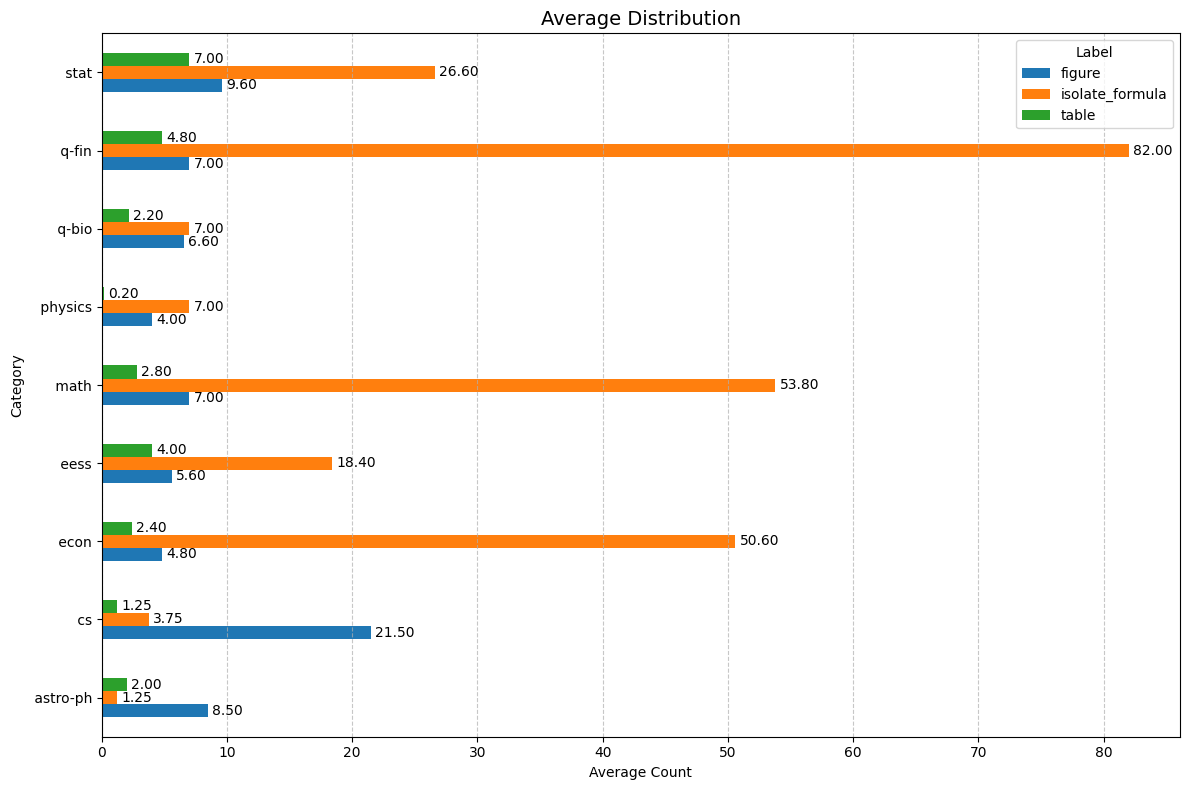

In [ ]:
plt.figure(figsize=(7, 23))

category_means = merged_data.groupby('Category')[['figure', 'isolate_formula', 'table']].mean().reset_index()
ax = category_means.set_index('Category').plot(kind='barh', figsize=(12, 8))

# Annotate values on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=3)

# Set titles and labels
plt.title("Average Distribution", fontsize=14)
plt.xlabel("Average Count", fontsize=10)
plt.ylabel("Category", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title="Label", fontsize=10)
plt.tight_layout()

plt.show()

- q-fin, math, econ 부분에서 수학적 공식 많이 사용됨. 사실 Text의 영역으로.
- 시각적 요소는 figure나 table임. 수학적 공식이 많이 사용되었기 때문에 제외하고 경향성 파악.

<Figure size 700x2000 with 0 Axes>

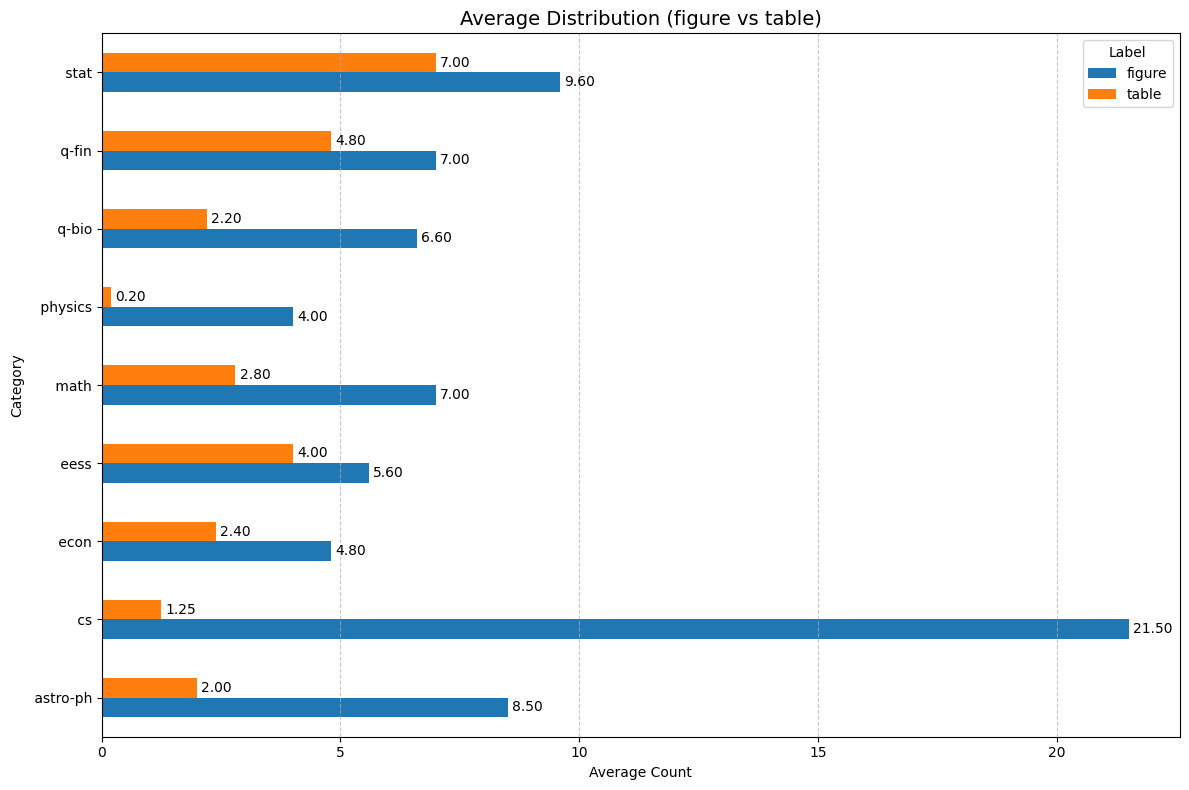

In [ ]:
plt.figure(figsize=(7, 20))

category_means = merged_data.groupby('Category')[['figure', 'table']].mean().reset_index()
ax = category_means.set_index('Category').plot(kind='barh', figsize=(12, 8))

# Annotate values on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=3)

# Set titles and labels
plt.title("Average Distribution (figure vs table)", fontsize=14)
plt.xlabel("Average Count", fontsize=10)
plt.ylabel("Category", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title="Label", fontsize=10)
plt.tight_layout()

plt.show()

-

<Figure size 500x2500 with 0 Axes>

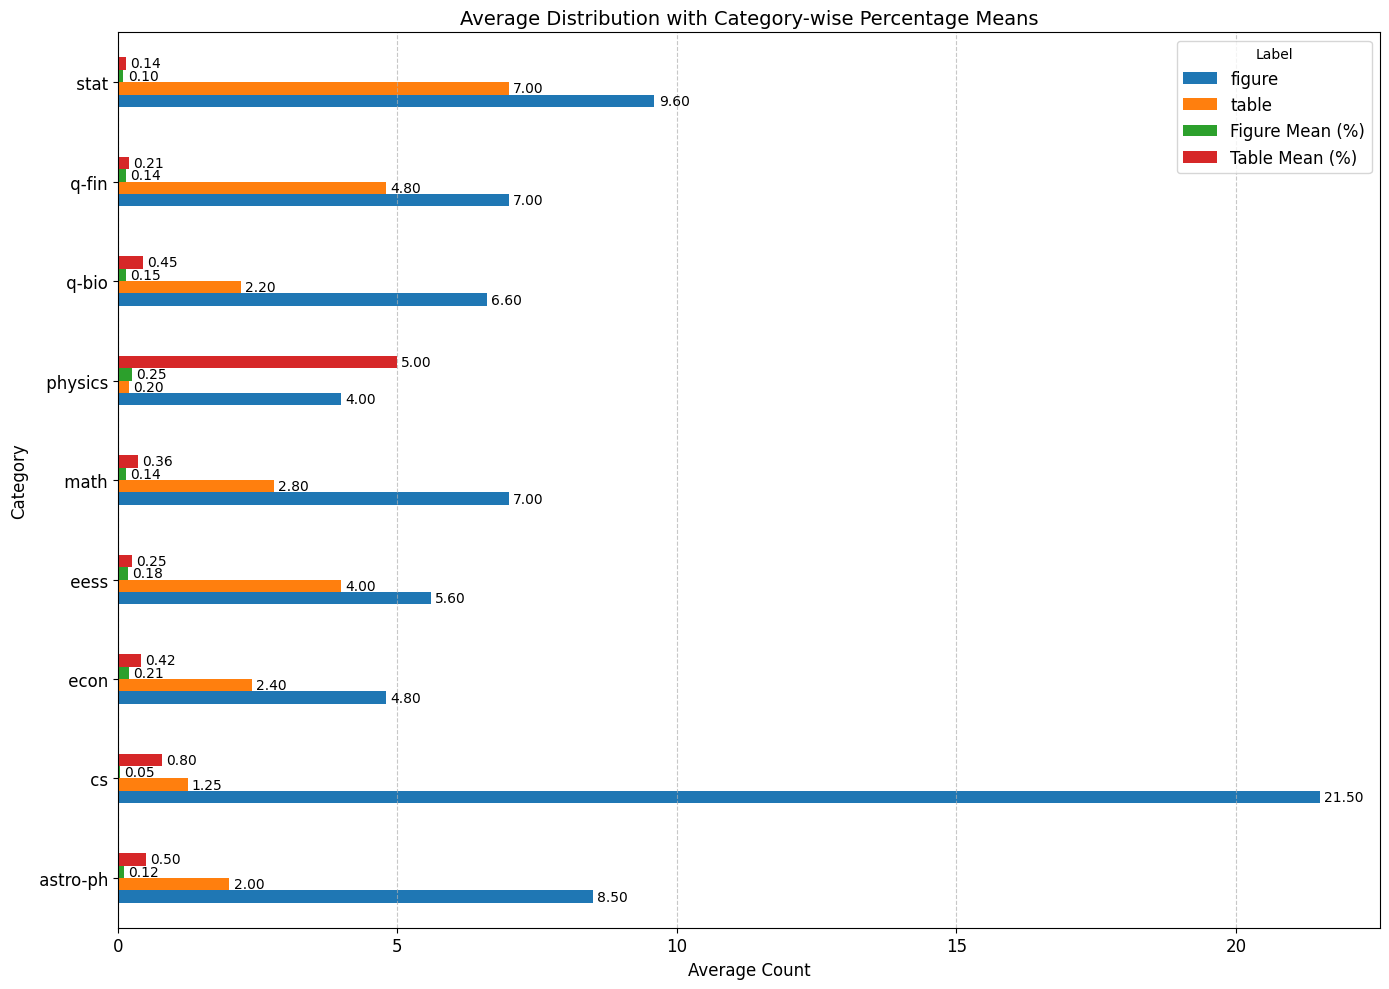

In [ ]:
# 각 카테고리별 평균 비율 계산
category_means = []
for category in merged_data['Category'].unique():
    category_data = merged_data[merged_data['Category'] == category]

    # 각 레이블별 평균 비율 계산
    figure_mean = (category_data.shape[0] / category_data['figure'].sum())
    formula_mean = (category_data.shape[0] / category_data['isolate_formula'].sum())
    table_mean = (category_data.shape[0] / category_data['table'].sum())

    # 결과 저장
    category_means.append({'Category': category, 'Figure Mean (%)': figure_mean, 'Formula Mean (%)': formula_mean, 'Table Mean (%)': table_mean})

# 데이터프레임 생성
category_means_df = pd.DataFrame(category_means)

# 기존 평균 데이터와 병합
category_means_with_label = merged_data.groupby('Category')[['figure', 'table']].mean().reset_index()
final_data = pd.merge(category_means_with_label, category_means_df, on='Category')

# 그래프 시각화
plt.figure(figsize=(5, 25))
ax = final_data.set_index('Category')[['figure', 'table', 'Figure Mean (%)', 'Table Mean (%)']].plot(kind='barh', figsize=(14, 10))

# 막대 위에 값 표시
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=3)


# 그래프 제목과 라벨 설정
plt.title("Average Distribution with Category-wise Percentage Means", fontsize=14)
plt.xlabel("Average Count", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title="Label", fontsize=12)
plt.tight_layout()

# 그래프 출력
plt.show()

- figure, table이 각 category에서 전반적으로 중요한 영향을 미치고 있다는 것을 의미
- figure가 전반적으로 많이 사용되지만 특히 많이 사용되는 cs, stat에 figure로 심도있는 이해 주려는 시도가 있다는 것 의미
- table의 경우 역시 stat, q-fin, bio, math, econ,astro-ph 등에서 표를 통한 분석과 이해를 제공하려 시도했다는 점.

- 따라서 figure, table 의미를 반영할 수 있어야.

- 결과 비교 대상
  - ocr 해서 LLM prompt 참고 요청 case (ocr 성능 쓸 수가 없음)
  - 1) caption 미포함했을 때
  - 2) vision LLM 활용해 함께 활용 case

In [ ]:
#### prompt >> 당신은 XX 분야를 연구하는 전문적인 연구원이야. 그래프를 자세히 분석한 텍스트를 생성해줘. >>> 고도화 >> LLM
#### 추가 고도화할 때는 행마다 있는 summary를 참고해서 분석하고 생성해달라 할 수 있을 듯

원문, 비전-텍스트 구성 추가

In [ ]:
import pandas as pd
import numpy as np


- RAG

In [ ]:
#### RAG 실험해야
#### Raptor RAG 생각하고 있는데 비용이 많이 들긴 함 (summary)
#### self RAG 결합할 수 있음 하기.
#### gpt 써보고, 온프레미스 사용 가능한 타 모델 시도해보기
#### 기본, 성능 개선  / 실험은 사투리, 은어도 포함해야 함.

- evaluate

In [ ]:
#### Test (RAGAS / LLM as a Judge / langchain evaluate)

- 추가 실험 건

In [ ]:
#### LLM >>> sLM
#### 오픈소스, 비용 낮춰도 가능하게
#### 프롬프틑 고도화